In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [2]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [4]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [9]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [14]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-0.92917693 -0.31306811 -0.1043844 ]


In [15]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [16]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.49289322]
(0.06853882018293751+0.008227527944967184j)|2 2 0 1>
(-0.15487815250169742-0.01859186260241223j)|2 2 0 0>
(0.2804117615955391+0.033661151424359236j)|2 1 1 1>
(-0.07488854407553901-0.00898976065673218j)|2 1 0 1>
(-0.06853882018293746-0.0082275279449672j)|2 1 0 0>
(0.2804117615955392+0.03366115142435911j)|1 1 1 2>
(-0.7702533829695715-0.09246265424722531j)|1 1 1 1>
(0.28041176159553916+0.03366115142435924j)|1 1 0 1>
(-0.06853882018293753-0.008227527944967233j)|1 0 2 2>
(-0.07488854407553906-0.008989760656732085j)|1 0 1 2>
(0.28041176159553893+0.033661151424359166j)|1 0 1 1>
(-0.15487815250169745-0.0185918626024122j)|0 0 2 2>
(0.06853882018293753+0.00822752794496725j)|0 0 1 2>



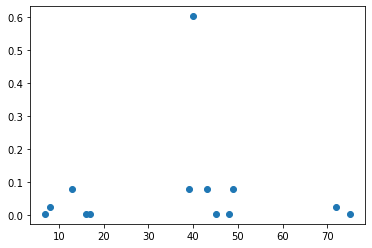

In [17]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [25]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [26]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [27]:
import optuna
n_iter = 4000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(5):
            theta[5*i+j] = trial.suggest_float("5*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)
        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-02 11:47:16,667] A new study created in memory with name: no-name-b1eade94-d697-4cb4-adb6-e2f5863eb65e
[I 2022-05-02 11:47:16,804] Trial 0 finished with value: 4.2491577783384 and parameters: {'5*0+0': 10.077002494012888, '5*0+1': 8.711575137818993, '5*0+2': 3.6229553201673994, '5*0+3': -3.160119281820762, '5*0+4': 11.454198310360109, '5*1+0': -31.00392932908105, '5*1+1': 2.9509081015951235, '5*1+2': -9.894123857308934, '5*1+3': -8.836537189758133, '5*1+4': 6.902254869535891, '5*2+0': -3.8095284293656064, '5*2+1': -7.7761053904229245, '5*2+2': -8.73318463869744, '5*2+3': -0.7903371700713144, '5*2+4': -12.49920018389176, '5*3+0': 1.853119530990405, '5*3+1': 11.103850020507078, '5*3+2': 1.6078489144494892, '5*3+3': 6.244199212458916, '5*3+4': -5.891110847501334}. Best is trial 0 with value: 4.2491577783384.
[I 2022-05-02 11:47:16,911] Trial 1 finished with value: 4.138440890325291 and parameters: {'5*0+0': -4.646044001783717, '5*0+1': 2.575722343333727, '5*0+2': -3.19042494830

[I 2022-05-02 11:47:18,080] Trial 11 finished with value: 3.5733590927560615 and parameters: {'5*0+0': 8.583228239900109, '5*0+1': -0.14345995010685839, '5*0+2': 1.2918019322053913, '5*0+3': 6.234860114030983, '5*0+4': -2.5521116149057295, '5*1+0': 3.4425058712381365, '5*1+1': 9.764436816551818, '5*1+2': 3.1016832766467375, '5*1+3': -2.3810301653723953, '5*1+4': -4.520062780494528, '5*2+0': 1.7831488958305302, '5*2+1': -7.686053537615469, '5*2+2': -0.1507234557693276, '5*2+3': 10.214389545462309, '5*2+4': 6.029691358644767, '5*3+0': -0.10252016200778653, '5*3+1': -2.1470923641088344, '5*3+2': -0.06952258058932513, '5*3+3': -3.754772257426976, '5*3+4': -2.8555958534879706}. Best is trial 9 with value: 3.08163987359306.
[I 2022-05-02 11:47:18,188] Trial 12 finished with value: 4.237848270739267 and parameters: {'5*0+0': 3.2423353228571923, '5*0+1': -4.190829213005389, '5*0+2': 0.24170616647053372, '5*0+3': 4.301000481639765, '5*0+4': -0.28883761049222134, '5*1+0': 5.350096742041582, '5*1

[I 2022-05-02 11:47:19,565] Trial 23 finished with value: 4.312803594064986 and parameters: {'5*0+0': 0.6915838251015165, '5*0+1': 0.3305562914988589, '5*0+2': -5.039694303030979, '5*0+3': -2.7001838336254025, '5*0+4': -8.056409777143227, '5*1+0': 6.38358433580441, '5*1+1': 2.17950857805453, '5*1+2': -10.082842107844547, '5*1+3': 4.877537707167574, '5*1+4': -1.778165931495342, '5*2+0': 2.526194807082971, '5*2+1': -2.457285241417935, '5*2+2': 2.9419751451808858, '5*2+3': -1.4070947096431263, '5*2+4': 2.8150053445133025, '5*3+0': 9.336512591542647, '5*3+1': 1.1297382739808288, '5*3+2': -2.4119120433664447, '5*3+3': -6.626998497619186, '5*3+4': -0.42488359712711854}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:19,681] Trial 24 finished with value: 3.656754113616391 and parameters: {'5*0+0': 2.0087718013844564, '5*0+1': 5.943581966526546, '5*0+2': -6.401550537841231, '5*0+3': 6.441033712041815, '5*0+4': -6.540556737059139, '5*1+0': 8.09619393399521, '5*1+1': -3.057

[I 2022-05-02 11:47:21,153] Trial 35 finished with value: 3.473714683671443 and parameters: {'5*0+0': -6.727912473331028, '5*0+1': -0.1502112991858766, '5*0+2': 0.022268526494123364, '5*0+3': 0.32479887970853305, '5*0+4': -5.5537637744013955, '5*1+0': 0.7335885215144637, '5*1+1': -0.5021293923210628, '5*1+2': -9.104580978756387, '5*1+3': 1.6378414138143476, '5*1+4': -3.9919759853407455, '5*2+0': 4.5754094317906935, '5*2+1': -5.668824777368648, '5*2+2': 5.621174358304051, '5*2+3': 0.7057693329592336, '5*2+4': -3.1681997061914524, '5*3+0': -1.8595758722989366, '5*3+1': -1.134590281240604, '5*3+2': 1.974871388887029, '5*3+3': -1.4010296353516742, '5*3+4': -2.525214502795995}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:21,285] Trial 36 finished with value: 4.858084679465198 and parameters: {'5*0+0': 6.189975122498472, '5*0+1': 0.04464851272291859, '5*0+2': -2.0477622458221765, '5*0+3': -2.3022682975726103, '5*0+4': -2.9477440898631353, '5*1+0': 4.57841445568439, '

[I 2022-05-02 11:47:22,558] Trial 47 finished with value: 4.560292569683211 and parameters: {'5*0+0': 3.4392840435641894, '5*0+1': 2.4344695526597473, '5*0+2': -4.40370820779277, '5*0+3': -3.774588564450292, '5*0+4': -7.52086155091531, '5*1+0': 2.6672889277057528, '5*1+1': 8.437355957688572, '5*1+2': -0.18416606235033317, '5*1+3': 6.906941949387499, '5*1+4': 5.472903194586645, '5*2+0': 4.174047250852417, '5*2+1': -1.635015211250471, '5*2+2': -2.9564331656369265, '5*2+3': -2.2909989049124646, '5*2+4': 4.180481364860905, '5*3+0': 7.265753971530488, '5*3+1': -6.8223267120862525, '5*3+2': -4.816738527221242, '5*3+3': 10.591206252620614, '5*3+4': 3.6431662936631515}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:22,671] Trial 48 finished with value: 2.5003147510131196 and parameters: {'5*0+0': 0.9898410102930941, '5*0+1': 0.6852251578184027, '5*0+2': -2.7201343169973464, '5*0+3': -3.0461491598848287, '5*0+4': -10.744416455413521, '5*1+0': -3.583364349334243, '5*1+1': 

[I 2022-05-02 11:47:23,972] Trial 59 finished with value: 2.5924984934965063 and parameters: {'5*0+0': 2.5126971696224203, '5*0+1': -3.497770195724758, '5*0+2': -8.00159149494375, '5*0+3': -2.283442638595338, '5*0+4': -8.481976435407852, '5*1+0': -2.4196213425832753, '5*1+1': 3.932135866630314, '5*1+2': -3.8175847344915814, '5*1+3': 3.4845910731824308, '5*1+4': 5.508870562662897, '5*2+0': 6.1660860314705195, '5*2+1': -4.452303112041216, '5*2+2': -1.6981566119600608, '5*2+3': -10.614360507074613, '5*2+4': -1.6879426950625422, '5*3+0': 3.277411303517324, '5*3+1': -1.8649005693985705, '5*3+2': 1.890822013263373, '5*3+3': 10.243141520507496, '5*3+4': 4.82985764113179}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:24,098] Trial 60 finished with value: 3.8790755652015263 and parameters: {'5*0+0': 2.7959627401248213, '5*0+1': 6.941133197464052, '5*0+2': -1.5667302928191016, '5*0+3': -10.558562677119246, '5*0+4': -10.38727664842968, '5*1+0': -4.233950893256172, '5*1+1':

[I 2022-05-02 11:47:25,516] Trial 71 finished with value: 3.747195332833085 and parameters: {'5*0+0': 5.174983504722427, '5*0+1': 2.4097679209047627, '5*0+2': -10.009125308986494, '5*0+3': -1.222824552023439, '5*0+4': -10.807982889972518, '5*1+0': -3.7484963458548495, '5*1+1': 8.06674397784219, '5*1+2': -6.374450898667289, '5*1+3': 7.9884854770698634, '5*1+4': 3.9245005285364307, '5*2+0': 4.469347774313232, '5*2+1': -9.686006453268352, '5*2+2': 2.1452426509979956, '5*2+3': -5.769112803432861, '5*2+4': -3.5579268586681225, '5*3+0': 2.2416616621981222, '5*3+1': 0.4923630646218031, '5*3+2': -0.7346497755820822, '5*3+3': 3.545052833586092, '5*3+4': 1.192077452974503}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:25,669] Trial 72 finished with value: 3.2778255660367512 and parameters: {'5*0+0': -0.0282340292534492, '5*0+1': -2.8264145850128815, '5*0+2': -4.5433152632228815, '5*0+3': -6.8158830068009735, '5*0+4': -10.892532495540312, '5*1+0': -4.0024092801476225, '5*1

[I 2022-05-02 11:47:26,933] Trial 83 finished with value: 3.5842581542802776 and parameters: {'5*0+0': -7.114692770619646, '5*0+1': 2.6630170542617755, '5*0+2': -3.9066906295202344, '5*0+3': 0.6791133915266965, '5*0+4': -10.489965447948276, '5*1+0': -9.721649912587367, '5*1+1': 5.325938550178309, '5*1+2': -1.7865938290856438, '5*1+3': 3.4388582078660797, '5*1+4': 5.039307777327638, '5*2+0': 6.341348221850016, '5*2+1': -6.070497265245326, '5*2+2': 2.184526911816342, '5*2+3': -6.848755166807403, '5*2+4': 6.001629420786651, '5*3+0': 9.44502869351334, '5*3+1': -0.8666985065055377, '5*3+2': 0.8817685540105296, '5*3+3': 10.118066271852527, '5*3+4': 5.017521762153719}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:27,046] Trial 84 finished with value: 3.148610404166483 and parameters: {'5*0+0': -1.3808122875346738, '5*0+1': 7.408788799867709, '5*0+2': -2.9482694835911993, '5*0+3': -6.903801963579921, '5*0+4': -11.63158089838502, '5*1+0': -2.8089214330705405, '5*1+1': 8.

[I 2022-05-02 11:47:28,276] Trial 95 finished with value: 2.463455424611293 and parameters: {'5*0+0': -1.006384186246886, '5*0+1': -0.10656402956313524, '5*0+2': -3.2671794898809123, '5*0+3': -6.970596039591086, '5*0+4': -2.7957594745991523, '5*1+0': -11.755840057928516, '5*1+1': 11.677305739980095, '5*1+2': -6.081557146165489, '5*1+3': 6.476759391010139, '5*1+4': -2.163481193583669, '5*2+0': 3.4777397913184975, '5*2+1': -1.5471529951370284, '5*2+2': -0.40450832525378244, '5*2+3': -3.15767034069713, '5*2+4': 6.223589512900943, '5*3+0': 6.614509140226511, '5*3+1': -8.691585761173931, '5*3+2': 6.887684030463361, '5*3+3': 6.774101459296397, '5*3+4': 1.8696342417671512}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:28,385] Trial 96 finished with value: 3.880787188059239 and parameters: {'5*0+0': 3.5241414499319506, '5*0+1': 1.4925821398331893, '5*0+2': -4.136032859369042, '5*0+3': -6.846391030984411, '5*0+4': -6.033674449999787, '5*1+0': -6.516521469835895, '5*1+1':

[I 2022-05-02 11:47:29,670] Trial 107 finished with value: 3.183458080889769 and parameters: {'5*0+0': -7.187878022588083, '5*0+1': 0.7373597129802562, '5*0+2': -3.883650509128767, '5*0+3': -7.004354787728792, '5*0+4': -7.3372694295477, '5*1+0': -10.524507635768284, '5*1+1': 2.014998482115179, '5*1+2': -3.511128551565986, '5*1+3': 8.39055060685601, '5*1+4': -2.285475301881415, '5*2+0': 0.9417232859846467, '5*2+1': -5.867483568118559, '5*2+2': -4.591846155674216, '5*2+3': -0.41620723194882947, '5*2+4': -5.5110385029685505, '5*3+0': 10.822137906259307, '5*3+1': -6.930308893497726, '5*3+2': 1.717601368107227, '5*3+3': 12.275358491851872, '5*3+4': 3.5839575176205636}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:29,785] Trial 108 finished with value: 5.56393168344926 and parameters: {'5*0+0': 5.143174128908934, '5*0+1': -0.20794118469347483, '5*0+2': 0.13141903356856766, '5*0+3': -6.8686386623244955, '5*0+4': -4.234886392943954, '5*1+0': -10.758264836451504, '5*1+1'

[I 2022-05-02 11:47:31,047] Trial 119 finished with value: 3.5413662037002127 and parameters: {'5*0+0': -2.5460617288071177, '5*0+1': -4.464746800343294, '5*0+2': -3.6806907472482626, '5*0+3': -8.588020233909557, '5*0+4': -10.089325853492106, '5*1+0': -16.70923870315382, '5*1+1': 1.0352653154564473, '5*1+2': -5.860268165062266, '5*1+3': 8.963822592261472, '5*1+4': 0.48313168093865677, '5*2+0': 2.579539937968168, '5*2+1': -9.769011982465305, '5*2+2': 2.437744637358015, '5*2+3': -3.1508834970111312, '5*2+4': 6.30242075977434, '5*3+0': 4.937554935721472, '5*3+1': -7.428669804682445, '5*3+2': 5.3103740717843895, '5*3+3': 8.374568789009745, '5*3+4': 7.194044686467851}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:31,156] Trial 120 finished with value: 4.727691704252885 and parameters: {'5*0+0': -6.190794230387757, '5*0+1': -2.2757979401286175, '5*0+2': -5.808758323219765, '5*0+3': -6.682283010695052, '5*0+4': -5.018808474403059, '5*1+0': -10.673968297356737, '5*1+1':

[I 2022-05-02 11:47:32,384] Trial 131 finished with value: 3.5669143272412853 and parameters: {'5*0+0': 4.600453618268467, '5*0+1': 0.7977719898331623, '5*0+2': -6.459709590774419, '5*0+3': -4.9251683212945725, '5*0+4': -0.2298740290671093, '5*1+0': -3.632405120041756, '5*1+1': 5.170256923061094, '5*1+2': -5.787673200881016, '5*1+3': 4.021751118833144, '5*1+4': 5.812696345845472, '5*2+0': 2.247598466425144, '5*2+1': -3.7609490673976604, '5*2+2': 1.7079311999160585, '5*2+3': 0.5701739898995275, '5*2+4': 2.176038948926744, '5*3+0': 6.586553001838579, '5*3+1': -7.224634585485358, '5*3+2': 2.7615596864901137, '5*3+3': 10.352101158826326, '5*3+4': 4.327157032719195}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:32,502] Trial 132 finished with value: 3.690195547319799 and parameters: {'5*0+0': 0.704983529033397, '5*0+1': 6.724839135827525, '5*0+2': -8.961485173766864, '5*0+3': -2.9209649158594875, '5*0+4': 0.5023179323259765, '5*1+0': -6.938747480764849, '5*1+1': -1.8

[I 2022-05-02 11:47:33,716] Trial 143 finished with value: 4.238617264116404 and parameters: {'5*0+0': -3.8815695682590166, '5*0+1': 1.5449228079739035, '5*0+2': -9.493851958087143, '5*0+3': -1.5649139330740458, '5*0+4': 4.88571944633926, '5*1+0': -3.317574274210705, '5*1+1': -5.583772722521032, '5*1+2': 3.2280422258095296, '5*1+3': 3.9539365869711904, '5*1+4': 3.900564790218425, '5*2+0': 0.803902932358465, '5*2+1': -10.454766032773652, '5*2+2': -2.1752107348854013, '5*2+3': -4.446013864146624, '5*2+4': 5.141393087751491, '5*3+0': 1.8116570075122103, '5*3+1': -6.026331648588079, '5*3+2': -3.076397394003443, '5*3+3': 4.75752983134303, '5*3+4': 3.8807590328830637}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:33,832] Trial 144 finished with value: 3.5872650761483538 and parameters: {'5*0+0': 0.6434935877803457, '5*0+1': 2.5638087050401936, '5*0+2': -9.023522398433945, '5*0+3': -5.426177911844624, '5*0+4': 3.920858684823082, '5*1+0': -5.220483484158368, '5*1+1': -5

[I 2022-05-02 11:47:35,061] Trial 155 finished with value: 3.2673932057218846 and parameters: {'5*0+0': -3.272591499490413, '5*0+1': 2.53733008097099, '5*0+2': -8.345124633906725, '5*0+3': -1.7594088271744401, '5*0+4': 8.67360958553956, '5*1+0': -8.490708442096924, '5*1+1': 0.5969614898639978, '5*1+2': 0.5983866043807675, '5*1+3': 2.8498276766480486, '5*1+4': 2.0301870671545643, '5*2+0': 7.719948741282846, '5*2+1': -5.941156215870359, '5*2+2': -3.7401146216955774, '5*2+3': -0.4705227693534714, '5*2+4': 7.474861632901366, '5*3+0': -1.7336733072010642, '5*3+1': -8.56619976800052, '5*3+2': 0.1246708634950302, '5*3+3': 4.261413561482596, '5*3+4': -0.08347604673687048}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:35,168] Trial 156 finished with value: 3.8450037116600595 and parameters: {'5*0+0': -1.7689454059356216, '5*0+1': 3.04770983248061, '5*0+2': -4.4459962176599985, '5*0+3': -4.492196006569014, '5*0+4': 0.4572901512168095, '5*1+0': -6.0518165573993175, '5*1+1'

[I 2022-05-02 11:47:36,420] Trial 167 finished with value: 5.423374583450116 and parameters: {'5*0+0': -3.9510766360663574, '5*0+1': 2.4214140737654786, '5*0+2': -6.791165513258766, '5*0+3': -12.308783471697833, '5*0+4': 1.42629834391115, '5*1+0': -7.466465965007047, '5*1+1': 0.0023776183585164645, '5*1+2': -3.5615909457856345, '5*1+3': 5.2887838271608825, '5*1+4': 5.860554689948035, '5*2+0': 6.191509071887747, '5*2+1': -7.086574988254264, '5*2+2': -2.4270537251661533, '5*2+3': -2.6461973934328955, '5*2+4': 7.948423941006803, '5*3+0': 6.1287757529618325, '5*3+1': -1.3167519891255974, '5*3+2': -0.21034764876914003, '5*3+3': 9.124389561361909, '5*3+4': 8.977635306043654}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:36,537] Trial 168 finished with value: 3.756297941935221 and parameters: {'5*0+0': 1.3317430262913197, '5*0+1': -2.700422238242851, '5*0+2': -8.26292722702709, '5*0+3': -5.416794503384792, '5*0+4': -0.6934697908182423, '5*1+0': -13.211752811120059, '5*

[I 2022-05-02 11:47:37,791] Trial 179 finished with value: 3.3986693744231897 and parameters: {'5*0+0': -4.238331844218734, '5*0+1': 5.664394855864964, '5*0+2': -7.59656972371506, '5*0+3': -9.275570422404874, '5*0+4': 0.5530686470621409, '5*1+0': -12.213162648603067, '5*1+1': 3.845053983736049, '5*1+2': -9.785194701521956, '5*1+3': 6.545429561797443, '5*1+4': 5.413676333759953, '5*2+0': 7.563516243469089, '5*2+1': -10.22886173480797, '5*2+2': -5.972086854364775, '5*2+3': -5.578542475990391, '5*2+4': 3.7175125205160997, '5*3+0': 7.7631159952011135, '5*3+1': -5.613312839971612, '5*3+2': -6.134323349118539, '5*3+3': 8.372206814897112, '5*3+4': 6.409970862324013}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:37,907] Trial 180 finished with value: 5.105907104578303 and parameters: {'5*0+0': -5.827722426411044, '5*0+1': 4.177190167388876, '5*0+2': -4.995978091705472, '5*0+3': -8.549417465571981, '5*0+4': -2.649027333298973, '5*1+0': -8.808329729680874, '5*1+1': 5.8703

[I 2022-05-02 11:47:39,157] Trial 191 finished with value: 3.110728738668337 and parameters: {'5*0+0': -0.7484604850467149, '5*0+1': 2.4586414861521417, '5*0+2': -6.890600662862801, '5*0+3': -7.180591997688055, '5*0+4': 5.791287104395557, '5*1+0': -10.545787585676825, '5*1+1': 5.213200469513399, '5*1+2': -0.8673202381675296, '5*1+3': 6.771619154922898, '5*1+4': 6.994390303522458, '5*2+0': 6.7147305980882726, '5*2+1': -6.618366594192865, '5*2+2': -5.4761831423630865, '5*2+3': -2.597528608850872, '5*2+4': 7.165758852271331, '5*3+0': 10.344241912885327, '5*3+1': -5.2892866951579585, '5*3+2': 5.713520637554057, '5*3+3': 5.750995822408161, '5*3+4': 4.573484810707354}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:39,272] Trial 192 finished with value: 3.772122643492608 and parameters: {'5*0+0': -4.556001575746736, '5*0+1': 3.3916491657543917, '5*0+2': -4.6591627967928915, '5*0+3': -6.386065450846824, '5*0+4': 1.9081824798239324, '5*1+0': -7.11613566906364, '5*1+1': 4.

[I 2022-05-02 11:47:40,583] Trial 203 finished with value: 4.919273744084508 and parameters: {'5*0+0': -0.6643005209912514, '5*0+1': 3.470264130177907, '5*0+2': -4.727249802391999, '5*0+3': -9.395306750342517, '5*0+4': 3.943744499100564, '5*1+0': -3.4971511789919765, '5*1+1': 3.730765812559074, '5*1+2': -4.427471217883435, '5*1+3': 4.568976850661624, '5*1+4': 8.231881554162394, '5*2+0': 0.4322304919463371, '5*2+1': -6.764393031391843, '5*2+2': -5.118650209603248, '5*2+3': -1.34769786112299, '5*2+4': 11.484586165597959, '5*3+0': 14.746763389382846, '5*3+1': 1.7551614727250833, '5*3+2': -0.9194486395761395, '5*3+3': 4.066617430006328, '5*3+4': 0.6663252155801569}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:40,691] Trial 204 finished with value: 3.4473940914579164 and parameters: {'5*0+0': -0.03206194213552971, '5*0+1': 1.9510890837064376, '5*0+2': -3.8882731267533943, '5*0+3': -6.808231727734131, '5*0+4': 1.3490480773864522, '5*1+0': -5.371206947248689, '5*1+1':

[I 2022-05-02 11:47:41,957] Trial 215 finished with value: 4.086002635426047 and parameters: {'5*0+0': -1.146975046163488, '5*0+1': 4.119091149473961, '5*0+2': -7.061788237030794, '5*0+3': -7.730152923744271, '5*0+4': 3.5282260443040987, '5*1+0': -5.364327545558535, '5*1+1': 5.238599054573491, '5*1+2': -7.270457060258231, '5*1+3': 5.340170061405183, '5*1+4': 6.114418993159516, '5*2+0': 3.6390787457606093, '5*2+1': -5.799226041334945, '5*2+2': -4.063244684492415, '5*2+3': -3.0747835470369793, '5*2+4': 4.080436249405838, '5*3+0': 6.373553583319723, '5*3+1': -8.298984119349825, '5*3+2': 3.6093751249375736, '5*3+3': 7.689324168602469, '5*3+4': 9.697287559093127}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:42,067] Trial 216 finished with value: 4.296637253242352 and parameters: {'5*0+0': -6.4314036164545385, '5*0+1': 7.074130104794662, '5*0+2': -6.392208177947124, '5*0+3': -6.2008532562342475, '5*0+4': 1.4746018184085505, '5*1+0': -4.165124849800789, '5*1+1': 1.926

[I 2022-05-02 11:47:43,330] Trial 227 finished with value: 3.6815081602578887 and parameters: {'5*0+0': -2.7012108451592343, '5*0+1': 4.88329362456418, '5*0+2': -4.436152041312524, '5*0+3': -10.166477291963279, '5*0+4': 0.7919437195244314, '5*1+0': 3.645434417267921, '5*1+1': 0.8898147666663272, '5*1+2': -6.744292239494422, '5*1+3': 2.7190498063821593, '5*1+4': 5.3376249625273084, '5*2+0': 2.8163412526381384, '5*2+1': -3.8798111488461915, '5*2+2': -5.406864042594929, '5*2+3': -6.135732007042827, '5*2+4': 6.087855746893451, '5*3+0': 6.900385941680375, '5*3+1': -2.614845926800166, '5*3+2': -3.4128776971035055, '5*3+3': 2.8872827369377, '5*3+4': 6.888550744195429}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:43,449] Trial 228 finished with value: 3.638540663867574 and parameters: {'5*0+0': 1.970261263352966, '5*0+1': 4.315261119970344, '5*0+2': -6.024195269824294, '5*0+3': -5.604756513581862, '5*0+4': -7.1310009856820225, '5*1+0': 2.0045991229342346, '5*1+1': 3.03

[I 2022-05-02 11:47:44,890] Trial 239 finished with value: 5.888668931859767 and parameters: {'5*0+0': -0.029157050756518643, '5*0+1': 2.9441206851204638, '5*0+2': -7.046946963689182, '5*0+3': -2.9770677633563465, '5*0+4': -4.74856819499875, '5*1+0': -1.889294704711699, '5*1+1': 8.945632016234192, '5*1+2': -4.135061896282139, '5*1+3': 10.9824839945964, '5*1+4': 6.610050077714093, '5*2+0': 3.291929621780238, '5*2+1': -6.347861599486594, '5*2+2': -9.782544154722524, '5*2+3': -2.4251279810547226, '5*2+4': -0.1855972011043705, '5*3+0': 4.640285255478232, '5*3+1': 0.6486968192995901, '5*3+2': -3.7843070459583186, '5*3+3': 5.73684002991972, '5*3+4': 7.761082936249747}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:45,028] Trial 240 finished with value: 3.931239521815624 and parameters: {'5*0+0': -10.327119161925243, '5*0+1': 3.3646368663857866, '5*0+2': -4.295255038735472, '5*0+3': -10.305388147032424, '5*0+4': -4.971961987359259, '5*1+0': -4.648895134151122, '5*1+1': 

[I 2022-05-02 11:47:46,507] Trial 251 finished with value: 3.426536818158266 and parameters: {'5*0+0': -1.1283978197932634, '5*0+1': 0.9878587162613041, '5*0+2': -4.393465758596336, '5*0+3': -9.052964757265265, '5*0+4': 2.5999109730878462, '5*1+0': 1.4988502572339886, '5*1+1': 0.7727419433825045, '5*1+2': -6.747181897269517, '5*1+3': 1.8488824933342718, '5*1+4': 8.055298954653484, '5*2+0': 0.7134796657654363, '5*2+1': -10.532764228200165, '5*2+2': -1.3243541780119155, '5*2+3': -7.548513676712642, '5*2+4': -1.2709446685603156, '5*3+0': 5.987138334765911, '5*3+1': -4.641088358872312, '5*3+2': 3.042929178801765, '5*3+3': 8.503354025274648, '5*3+4': 4.182089680015298}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:46,658] Trial 252 finished with value: 3.288574288357046 and parameters: {'5*0+0': -4.046441693426713, '5*0+1': 2.2471610807874143, '5*0+2': -10.79442332750683, '5*0+3': -5.248456269838912, '5*0+4': -0.7852608589154442, '5*1+0': 1.6514268488071322, '5*1+1':

[I 2022-05-02 11:47:48,179] Trial 263 finished with value: 4.07995203474823 and parameters: {'5*0+0': -2.2809838839480268, '5*0+1': 4.685675008567094, '5*0+2': -8.187721973014455, '5*0+3': -2.7722792862337267, '5*0+4': -4.339139182957017, '5*1+0': -2.2874638168371466, '5*1+1': 5.266680253722988, '5*1+2': -7.082199028279935, '5*1+3': 8.290806569050268, '5*1+4': 6.041344103409202, '5*2+0': 0.025555161931986037, '5*2+1': -9.5826776991451, '5*2+2': -2.431791448985593, '5*2+3': -7.328715927580136, '5*2+4': 3.6409336661002003, '5*3+0': 5.786083743013878, '5*3+1': -4.903318825034157, '5*3+2': -2.0347201674711988, '5*3+3': 9.174168744967249, '5*3+4': 6.853833836815754}. Best is trial 14 with value: 1.7160733188728856.
[I 2022-05-02 11:47:48,326] Trial 264 finished with value: 2.3023094419934633 and parameters: {'5*0+0': -2.0787188986863328, '5*0+1': 4.052987091108487, '5*0+2': -6.319010083409752, '5*0+3': -0.17940385752021415, '5*0+4': -1.1530639777668246, '5*1+0': -0.43245769539136125, '5*1+1

[I 2022-05-02 11:47:49,765] Trial 275 finished with value: 7.606488766224235 and parameters: {'5*0+0': 0.7273541660897043, '5*0+1': 5.074980885666647, '5*0+2': -4.715840413608097, '5*0+3': -3.0357348940512674, '5*0+4': -2.682771955393941, '5*1+0': 0.7162521829964359, '5*1+1': 9.645808857807197, '5*1+2': -6.225477001237259, '5*1+3': 8.390689064921379, '5*1+4': 9.997806369412041, '5*2+0': -0.9608703143031254, '5*2+1': -5.666847800391363, '5*2+2': -3.5731779314302585, '5*2+3': -7.549810773606548, '5*2+4': -0.4744621266015001, '5*3+0': 2.6565110430822747, '5*3+1': -2.5528265919574897, '5*3+2': 0.570040061750935, '5*3+3': 5.9868695091381605, '5*3+4': 6.438664660570861}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:49,896] Trial 276 finished with value: 3.127622174314035 and parameters: {'5*0+0': 2.418737520345042, '5*0+1': 3.094628136595029, '5*0+2': -10.407477896278316, '5*0+3': -2.437444556966555, '5*0+4': -3.926621589749268, '5*1+0': -4.341090754953508, '5*1+1': 5

[I 2022-05-02 11:47:51,346] Trial 287 finished with value: 7.353875890559712 and parameters: {'5*0+0': -0.7755157619913458, '5*0+1': 3.7508127590817795, '5*0+2': -7.176773412343883, '5*0+3': -6.8639182930915394, '5*0+4': 4.025567492898636, '5*1+0': 0.13310011463455607, '5*1+1': 5.529392211806111, '5*1+2': -12.455493642011932, '5*1+3': 5.514486826815626, '5*1+4': 11.159473565928755, '5*2+0': 0.7623206310168817, '5*2+1': -4.8095187119783205, '5*2+2': -2.391666887435278, '5*2+3': -0.9388526049099637, '5*2+4': -1.4138231983708052, '5*3+0': 6.402045626334342, '5*3+1': 0.730167766637553, '5*3+2': -4.926506768923033, '5*3+3': 2.5662328343881127, '5*3+4': 4.740224246963405}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:51,475] Trial 288 finished with value: 3.1192274504581703 and parameters: {'5*0+0': -3.642179413137164, '5*0+1': 7.086615106108969, '5*0+2': -7.852604849501118, '5*0+3': -3.36595780390567, '5*0+4': -2.367843930883967, '5*1+0': -2.0938434406857507, '5*1+1'

[I 2022-05-02 11:47:52,927] Trial 299 finished with value: 4.213707014026156 and parameters: {'5*0+0': -2.1922320752614874, '5*0+1': 5.662329059454089, '5*0+2': -9.190961875911956, '5*0+3': -9.808566317271538, '5*0+4': -3.4254337871342218, '5*1+0': -0.6822109470060909, '5*1+1': 6.941833467320433, '5*1+2': -4.532243086474513, '5*1+3': 6.449130915770203, '5*1+4': 9.910996964589563, '5*2+0': -0.43702638571087893, '5*2+1': -5.117297229775961, '5*2+2': 2.911653564375242, '5*2+3': -1.6504414570196428, '5*2+4': -1.2215881010988685, '5*3+0': 0.22124660284878828, '5*3+1': -5.621654330023543, '5*3+2': -3.0157827247313436, '5*3+3': 8.491412259803543, '5*3+4': 5.706972714542831}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:53,063] Trial 300 finished with value: 3.149411837391056 and parameters: {'5*0+0': 0.34566054340293517, '5*0+1': 2.296560709436137, '5*0+2': -10.442701250814695, '5*0+3': -2.034928557202499, '5*0+4': 0.042635784980011415, '5*1+0': 0.12213116540175872, '5

[I 2022-05-02 11:47:54,503] Trial 311 finished with value: 4.194379327400073 and parameters: {'5*0+0': -0.008291753895369958, '5*0+1': -2.4653404027517567, '5*0+2': -8.583769227709949, '5*0+3': -1.199076364162301, '5*0+4': -1.5395539789197878, '5*1+0': -1.3178795430762347, '5*1+1': 10.400009652422117, '5*1+2': -4.978146513728545, '5*1+3': 8.05780363223513, '5*1+4': 10.27126210633785, '5*2+0': 1.621602473935092, '5*2+1': -12.218397018441067, '5*2+2': -2.5887809405527773, '5*2+3': -4.290030495022956, '5*2+4': -0.3303643407516619, '5*3+0': 2.6128207002154933, '5*3+1': -4.788652526647084, '5*3+2': -0.067874307330416, '5*3+3': 9.051866622675064, '5*3+4': 4.835202670980032}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:54,637] Trial 312 finished with value: 1.5441791766752737 and parameters: {'5*0+0': -0.16052513420784664, '5*0+1': 2.8279369991929038, '5*0+2': -9.25276072876024, '5*0+3': -6.686866905799555, '5*0+4': 1.0973526931042694, '5*1+0': 0.8396266828103136, '5*

[I 2022-05-02 11:47:56,112] Trial 323 finished with value: 2.181250574490825 and parameters: {'5*0+0': -0.17531453325869079, '5*0+1': 4.126468234477295, '5*0+2': -10.141163939041288, '5*0+3': -6.487718290294497, '5*0+4': -3.1742172515662195, '5*1+0': -3.934523251963684, '5*1+1': 11.21721062111991, '5*1+2': -5.2874732055697375, '5*1+3': 6.755430239540634, '5*1+4': 9.355417652639083, '5*2+0': -2.5923825823235522, '5*2+1': -10.100824197751797, '5*2+2': -4.28337833047566, '5*2+3': -3.8793336603311754, '5*2+4': -1.2341386014923772, '5*3+0': 0.4323761371766927, '5*3+1': -1.4569730567549817, '5*3+2': 2.803031224766329, '5*3+3': 5.62377706737608, '5*3+4': 6.174226998328111}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:56,246] Trial 324 finished with value: 4.700355529852522 and parameters: {'5*0+0': 0.24212446799991494, '5*0+1': 6.356199898311324, '5*0+2': -10.066743501962307, '5*0+3': -3.8831305857239165, '5*0+4': -0.5172681452687165, '5*1+0': 2.439678766243434, '5*1+

[I 2022-05-02 11:47:57,747] Trial 335 finished with value: 2.0731553121008575 and parameters: {'5*0+0': -0.05277577218015239, '5*0+1': 5.1462899153255, '5*0+2': -10.520012086016052, '5*0+3': -6.715728173457247, '5*0+4': -0.21035209010493827, '5*1+0': -2.9593334841225505, '5*1+1': 9.681827761645149, '5*1+2': -10.679097403270909, '5*1+3': 3.5492544011378513, '5*1+4': 7.4606952472436285, '5*2+0': -5.698412178088411, '5*2+1': -7.589104642171533, '5*2+2': -0.284504089276405, '5*2+3': -3.5462286378396843, '5*2+4': -0.3846658214650833, '5*3+0': 0.7288821514963315, '5*3+1': 0.45699646624848667, '5*3+2': -2.0665178236830335, '5*3+3': 6.559142827769072, '5*3+4': 6.731555023723846}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:57,901] Trial 336 finished with value: 1.8842527410635825 and parameters: {'5*0+0': 0.05815737436494728, '5*0+1': 3.4600735682119823, '5*0+2': -9.555980196953492, '5*0+3': -4.527698370383971, '5*0+4': -3.446963636706037, '5*1+0': -6.496495091477376, 

[I 2022-05-02 11:47:59,359] Trial 347 finished with value: 4.39107489912427 and parameters: {'5*0+0': 1.379679624084649, '5*0+1': 5.082949658344766, '5*0+2': -6.9811908578013, '5*0+3': -6.349427271997159, '5*0+4': -0.16258362830163153, '5*1+0': -4.974284051879037, '5*1+1': 10.802976218713011, '5*1+2': -12.565474687107404, '5*1+3': 8.470135938508983, '5*1+4': 8.392007914063976, '5*2+0': 0.15588077573146908, '5*2+1': -5.770655315689334, '5*2+2': -4.0296490383738455, '5*2+3': -3.8461870877251885, '5*2+4': -1.1840582073877295, '5*3+0': 2.4521032827782556, '5*3+1': -3.2723276041091394, '5*3+2': -1.3789323661343753, '5*3+3': 7.063916816794432, '5*3+4': 6.5743700955484625}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:47:59,485] Trial 348 finished with value: 3.963866696768434 and parameters: {'5*0+0': 2.147138116838224, '5*0+1': 4.243312846925171, '5*0+2': -10.283443051695563, '5*0+3': -7.398153742260671, '5*0+4': -1.580861410344526, '5*1+0': -6.734362838223781, '5*1+1':

[I 2022-05-02 11:48:00,966] Trial 359 finished with value: 4.4503934841625545 and parameters: {'5*0+0': -2.9097527460783086, '5*0+1': 8.063382055051928, '5*0+2': -9.86350140594129, '5*0+3': -11.417851797190247, '5*0+4': -2.5418950403409015, '5*1+0': -4.655108475714454, '5*1+1': 5.78566828140698, '5*1+2': -11.899603119535879, '5*1+3': 3.5555542482099773, '5*1+4': 5.046099347594482, '5*2+0': -0.20440724864195314, '5*2+1': -6.2234145161423156, '5*2+2': -6.964155000368567, '5*2+3': -3.2861554871580774, '5*2+4': -3.3843956380806945, '5*3+0': 0.03649743889423096, '5*3+1': 1.8174976748894838, '5*3+2': 3.552597137208595, '5*3+3': 5.320401243593869, '5*3+4': 6.719643542882716}. Best is trial 271 with value: 1.497629107658998.
[I 2022-05-02 11:48:01,100] Trial 360 finished with value: 0.833653788964519 and parameters: {'5*0+0': 1.0037315112720009, '5*0+1': 3.968718321516737, '5*0+2': -10.663993351178306, '5*0+3': -7.7264691980032065, '5*0+4': 0.6510600618055182, '5*1+0': -5.419309319776922, '5*1

[I 2022-05-02 11:48:02,529] Trial 371 finished with value: 4.896592432235099 and parameters: {'5*0+0': 1.6421736808078178, '5*0+1': 4.4936449424629075, '5*0+2': -9.109132131378308, '5*0+3': -5.69697222694842, '5*0+4': -0.7340927942464897, '5*1+0': -6.7180245151806535, '5*1+1': 7.738365668453742, '5*1+2': -5.220180983378797, '5*1+3': 3.1660929603145798, '5*1+4': 9.320703630424898, '5*2+0': -2.537026184549251, '5*2+1': -5.742872112425152, '5*2+2': -5.9890139970802965, '5*2+3': -3.1362917549055855, '5*2+4': 3.252720641908125, '5*3+0': 1.9836555045173052, '5*3+1': 1.4475735956716074, '5*3+2': 2.246317750119092, '5*3+3': 4.964980501563622, '5*3+4': 4.226039484022906}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:02,662] Trial 372 finished with value: 3.8254013074885007 and parameters: {'5*0+0': 0.7506662719277247, '5*0+1': 5.601159929101417, '5*0+2': -11.085467793499772, '5*0+3': -7.54421708432189, '5*0+4': -3.2347986395787047, '5*1+0': -5.907220343856343, '5*1+1': 9

[I 2022-05-02 11:48:04,141] Trial 383 finished with value: 3.0272940109583284 and parameters: {'5*0+0': 1.0223502802219937, '5*0+1': 2.961900996689262, '5*0+2': -8.620375217951661, '5*0+3': -9.803006551639, '5*0+4': 2.2805374434527597, '5*1+0': -3.0039272675741167, '5*1+1': 6.254421274714607, '5*1+2': -7.21074343197719, '5*1+3': 1.088936368678254, '5*1+4': 5.431848070433661, '5*2+0': -0.47476752178372994, '5*2+1': -3.121622833848285, '5*2+2': -5.941207863093669, '5*2+3': -6.379383216847764, '5*2+4': 0.9512254542445711, '5*3+0': -0.731308387055088, '5*3+1': 3.647118267038133, '5*3+2': -2.0714521011019946, '5*3+3': 4.05317417900086, '5*3+4': 5.382766720867495}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:04,269] Trial 384 finished with value: 2.6843387775116705 and parameters: {'5*0+0': 0.9400980120972868, '5*0+1': 5.654920926142215, '5*0+2': -7.4496585716498585, '5*0+3': -11.276851464818476, '5*0+4': -1.1166776534637737, '5*1+0': -4.767128115463544, '5*1+1': 4.6

[I 2022-05-02 11:48:05,724] Trial 395 finished with value: 2.5210826389081498 and parameters: {'5*0+0': -0.27738462870372027, '5*0+1': 4.375451275893302, '5*0+2': -9.336646005732597, '5*0+3': -11.708695632198081, '5*0+4': 3.5900904311562245, '5*1+0': -5.651180835799919, '5*1+1': 10.134462098961372, '5*1+2': -12.173457539261214, '5*1+3': 6.625677067298526, '5*1+4': 8.48862149412938, '5*2+0': 0.3592401387823405, '5*2+1': -8.496652811262429, '5*2+2': -2.31202242186568, '5*2+3': -6.194977660266464, '5*2+4': -2.083295165329804, '5*3+0': 1.3766169424964345, '5*3+1': -0.9373607492059108, '5*3+2': 2.43550979573606, '5*3+3': 1.0580821345964362, '5*3+4': 6.465737241669655}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:05,879] Trial 396 finished with value: 2.0890666949571832 and parameters: {'5*0+0': -0.5438768811937695, '5*0+1': 6.090652506570588, '5*0+2': -10.779821670473424, '5*0+3': -7.279080159813825, '5*0+4': 2.314623628801176, '5*1+0': -9.09542778524557, '5*1+1': 1

[I 2022-05-02 11:48:07,300] Trial 407 finished with value: 2.923264359256534 and parameters: {'5*0+0': -1.5571813838178574, '5*0+1': 9.610844704622185, '5*0+2': -10.679728698242561, '5*0+3': -7.602153935284262, '5*0+4': 1.349519936884214, '5*1+0': -7.984875563637404, '5*1+1': 12.00415096344856, '5*1+2': -5.729946579762014, '5*1+3': 8.598633551318386, '5*1+4': 7.328194581681609, '5*2+0': -1.972745978394574, '5*2+1': -6.985586400344031, '5*2+2': -5.588157199301493, '5*2+3': -5.4122894561494395, '5*2+4': -1.1083834707832276, '5*3+0': 0.004072159101647821, '5*3+1': -1.0102010756882334, '5*3+2': -3.323261315161344, '5*3+3': 3.2926887277645784, '5*3+4': 6.935177417766603}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:07,434] Trial 408 finished with value: 4.14402232441795 and parameters: {'5*0+0': 1.3130205271270872, '5*0+1': 3.8146583634181743, '5*0+2': -12.299540116561914, '5*0+3': -9.004151037839875, '5*0+4': 2.1791329744746033, '5*1+0': -5.568160504533097, '5*1+1'

[I 2022-05-02 11:48:08,865] Trial 419 finished with value: 2.6327834869899758 and parameters: {'5*0+0': 0.7443240301065456, '5*0+1': 0.5606096011640407, '5*0+2': -5.3653571604468215, '5*0+3': -8.082285817885326, '5*0+4': 4.447045385666701, '5*1+0': -7.242770627401864, '5*1+1': 7.362689891914271, '5*1+2': -9.516817580218962, '5*1+3': 4.679099433168412, '5*1+4': 9.444084007609787, '5*2+0': -0.7586452349152475, '5*2+1': -7.924348398894779, '5*2+2': -6.208946409118903, '5*2+3': -6.214801680822974, '5*2+4': 0.5891374487926796, '5*3+0': -2.2868864176644546, '5*3+1': -1.7849402658754012, '5*3+2': -1.3053634954157063, '5*3+3': 1.9382758115914105, '5*3+4': 0.47456668744094044}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:08,992] Trial 420 finished with value: 11.282169784414684 and parameters: {'5*0+0': 1.2527631859206068, '5*0+1': 2.116527847959869, '5*0+2': -7.469525824397311, '5*0+3': -8.73211861216262, '5*0+4': 5.705100851006009, '5*1+0': -7.418828146004501, '5*1+1'

[I 2022-05-02 11:48:10,434] Trial 431 finished with value: 2.3050545976410297 and parameters: {'5*0+0': 0.9221569530818687, '5*0+1': 5.311023904547364, '5*0+2': -3.5137899320910693, '5*0+3': -7.641198342058035, '5*0+4': 4.892125438383541, '5*1+0': -3.644667910967899, '5*1+1': 8.694886480921443, '5*1+2': -9.388823409420509, '5*1+3': 5.316553127288028, '5*1+4': 7.101663325694098, '5*2+0': -1.1533765316661837, '5*2+1': -5.071426142871956, '5*2+2': -5.492465035381063, '5*2+3': -8.636346738750758, '5*2+4': -2.6030320583365025, '5*3+0': 1.0730239025179467, '5*3+1': 0.6600426063894187, '5*3+2': 0.9208834716961374, '5*3+3': 1.01273682353875, '5*3+4': 1.6082920745845442}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:10,557] Trial 432 finished with value: 1.9618363863983168 and parameters: {'5*0+0': 0.9568679005506322, '5*0+1': 4.076359919334709, '5*0+2': -7.346485792430806, '5*0+3': -9.500557440493303, '5*0+4': 2.621667020638265, '5*1+0': -7.710990868221162, '5*1+1': 6.9

[I 2022-05-02 11:48:11,970] Trial 443 finished with value: 2.0428200060117003 and parameters: {'5*0+0': 0.46264811930133604, '5*0+1': 5.861270043673904, '5*0+2': -4.369951479853348, '5*0+3': -8.134382296059718, '5*0+4': 4.519570005509766, '5*1+0': -3.3629880426093384, '5*1+1': 7.109014906256553, '5*1+2': -10.453791263466425, '5*1+3': 4.315452174248865, '5*1+4': 7.14821815424922, '5*2+0': -2.13940965183689, '5*2+1': -2.89484812500095, '5*2+2': -4.728463547777545, '5*2+3': -2.7601121076436637, '5*2+4': -0.33910895790224177, '5*3+0': 0.21623464661661126, '5*3+1': 0.3374790797326368, '5*3+2': -0.9815228476632263, '5*3+3': -1.0479495683535682, '5*3+4': 3.6057690916404783}. Best is trial 360 with value: 0.833653788964519.
[I 2022-05-02 11:48:12,096] Trial 444 finished with value: 2.672473476031322 and parameters: {'5*0+0': -0.2710509282648498, '5*0+1': 3.537700806061061, '5*0+2': -6.709779551007476, '5*0+3': -10.79892038232856, '5*0+4': 4.15324803679509, '5*1+0': -8.090877487341233, '5*1+1':

[I 2022-05-02 11:48:13,472] Trial 455 finished with value: 0.39263660647246373 and parameters: {'5*0+0': -1.0759938650443703, '5*0+1': 3.290213869524803, '5*0+2': -4.008260768235111, '5*0+3': -10.174651597281997, '5*0+4': 4.999506372238315, '5*1+0': -4.8608010121798, '5*1+1': 7.372016009017802, '5*1+2': -9.338302178980571, '5*1+3': 6.754388022186857, '5*1+4': 9.51906828618579, '5*2+0': -4.069526796260515, '5*2+1': -6.869078322183742, '5*2+2': -3.1896413876706227, '5*2+3': -3.7904114217331992, '5*2+4': -2.253498254764176, '5*3+0': 0.5305745449066348, '5*3+1': 2.390944044051935, '5*3+2': -0.2947767387133744, '5*3+3': -0.45399855975684156, '5*3+4': 0.4128354234477576}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:13,599] Trial 456 finished with value: 2.812046318862248 and parameters: {'5*0+0': 2.8019665123004502, '5*0+1': 3.740038327647166, '5*0+2': -5.234170646392344, '5*0+3': -9.436172199198692, '5*0+4': 2.4994523613383097, '5*1+0': -5.248885771282772, '5*1+1'

[I 2022-05-02 11:48:14,998] Trial 467 finished with value: 2.0717736745891653 and parameters: {'5*0+0': 0.4670439845562364, '5*0+1': 2.6908429172797677, '5*0+2': -5.23392051377454, '5*0+3': -7.529749549288557, '5*0+4': 4.231493969903369, '5*1+0': -3.6174739310668897, '5*1+1': 8.232037390888722, '5*1+2': -9.832823071430484, '5*1+3': 7.425895149083044, '5*1+4': 8.667891769525864, '5*2+0': -0.5692537758487328, '5*2+1': -3.131848797299337, '5*2+2': -4.047744971631655, '5*2+3': -6.112080282713, '5*2+4': -1.8662805487775467, '5*3+0': 1.9471176657202693, '5*3+1': -0.29969038396347947, '5*3+2': 1.8507136985270196, '5*3+3': 1.0190274827088104, '5*3+4': 0.19793885427808777}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:15,121] Trial 468 finished with value: 1.6421035468454048 and parameters: {'5*0+0': 0.8066650139826427, '5*0+1': 3.8521803167600543, '5*0+2': -4.887019936084471, '5*0+3': -10.990680462521627, '5*0+4': 7.1449004202923145, '5*1+0': -5.306210263486112, '5*1+

[I 2022-05-02 11:48:16,489] Trial 479 finished with value: 1.6125126194286468 and parameters: {'5*0+0': -0.025674130748562674, '5*0+1': 2.036765975468122, '5*0+2': -5.586039838446143, '5*0+3': -9.500527526327199, '5*0+4': 2.1879511892832046, '5*1+0': -6.302158627826815, '5*1+1': 7.570179872805742, '5*1+2': -7.288742299158969, '5*1+3': 7.588039606376913, '5*1+4': 9.828213008981267, '5*2+0': 0.5392760658847935, '5*2+1': -3.9790646651287216, '5*2+2': -4.9755262268841784, '5*2+3': -2.6906174414125243, '5*2+4': -0.3368476198990866, '5*3+0': -1.17318674761135, '5*3+1': 0.07125393053864529, '5*3+2': 0.11803062364825198, '5*3+3': 0.8882354517732081, '5*3+4': 0.7073266563269327}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:16,616] Trial 480 finished with value: 1.1861466368055549 and parameters: {'5*0+0': 1.7058267460283316, '5*0+1': 2.667438210546853, '5*0+2': -5.089779655424765, '5*0+3': -8.921085344623986, '5*0+4': 6.155412674435478, '5*1+0': -4.275592630742873, '5

[I 2022-05-02 11:48:18,127] Trial 491 finished with value: 2.786314445536813 and parameters: {'5*0+0': 0.35483702219308166, '5*0+1': 3.200669157952489, '5*0+2': -6.63240063184725, '5*0+3': -7.617886507983062, '5*0+4': 4.875789539314218, '5*1+0': -6.366195688245513, '5*1+1': 6.454427090428395, '5*1+2': -6.493557537653003, '5*1+3': 6.153950054185076, '5*1+4': 10.936110395075406, '5*2+0': -1.0670303732413837, '5*2+1': -5.682049832480471, '5*2+2': -3.4465149629435716, '5*2+3': -3.178466067985914, '5*2+4': 0.38538151566507023, '5*3+0': 1.6131918039096909, '5*3+1': -0.10895466635959639, '5*3+2': 0.9985498814067574, '5*3+3': 1.7887250045750767, '5*3+4': 0.9635064691082288}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:18,256] Trial 492 finished with value: 2.11953657172336 and parameters: {'5*0+0': 2.4260324199805483, '5*0+1': 3.517214009836055, '5*0+2': -9.978296212877414, '5*0+3': -7.895771714726983, '5*0+4': 5.126710202008405, '5*1+0': -4.716555199594872, '5*1+1':

[I 2022-05-02 11:48:19,678] Trial 503 finished with value: 1.7280876807626067 and parameters: {'5*0+0': 1.964067722735622, '5*0+1': 5.592640105949014, '5*0+2': -10.582105559423582, '5*0+3': -8.56310912823851, '5*0+4': 1.7726195075042845, '5*1+0': -3.7753807925567027, '5*1+1': 7.34915778015665, '5*1+2': -11.932249005059429, '5*1+3': 5.944551777803792, '5*1+4': 8.160594860676838, '5*2+0': 0.8213636286302507, '5*2+1': -9.368684695363193, '5*2+2': -6.179275991643913, '5*2+3': -1.4994525216712498, '5*2+4': 0.9707100428891817, '5*3+0': 1.6375203955479267, '5*3+1': 1.4534968633529142, '5*3+2': -0.5423418583026014, '5*3+3': -1.5548456613506925, '5*3+4': 3.8585639772060425}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:19,804] Trial 504 finished with value: 1.5442708394891267 and parameters: {'5*0+0': 2.1292980755258997, '5*0+1': 3.9021856908312973, '5*0+2': -6.111640846108388, '5*0+3': -10.187951985340002, '5*0+4': 5.266970391758222, '5*1+0': -2.4006593446665896, '5*1

[I 2022-05-02 11:48:21,208] Trial 515 finished with value: 3.335560877656752 and parameters: {'5*0+0': 0.2482041811511876, '5*0+1': 3.3951546011356126, '5*0+2': -8.246719888131416, '5*0+3': -10.054593782790853, '5*0+4': 3.4579478796806633, '5*1+0': -3.0618379534831037, '5*1+1': 6.1970692721436444, '5*1+2': -10.337882239413737, '5*1+3': 7.410144398988234, '5*1+4': 10.877419352429905, '5*2+0': 1.7685658891493174, '5*2+1': -8.771215873428181, '5*2+2': -8.32967190156918, '5*2+3': -6.709266456362455, '5*2+4': 0.31175977655620724, '5*3+0': 0.9284738775443173, '5*3+1': 3.276062539059703, '5*3+2': 0.6866407874072602, '5*3+3': -0.6075225436781699, '5*3+4': 3.905120081150801}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:21,337] Trial 516 finished with value: 1.99307336562712 and parameters: {'5*0+0': 3.2462867699424183, '5*0+1': 3.4512791240171614, '5*0+2': -7.822317990242437, '5*0+3': -10.481812690796438, '5*0+4': 4.8791110103021875, '5*1+0': -3.5631977827783454, '5*1

[I 2022-05-02 11:48:22,852] Trial 527 finished with value: 2.079913383067364 and parameters: {'5*0+0': 2.5191759569921928, '5*0+1': 4.204292256631257, '5*0+2': -6.989212176144556, '5*0+3': -7.596367374905747, '5*0+4': 5.39971021547867, '5*1+0': -1.955177870256751, '5*1+1': 7.416423410950961, '5*1+2': -11.035571606761472, '5*1+3': 4.06419281588391, '5*1+4': 8.785526664296736, '5*2+0': 0.9451408113625966, '5*2+1': -6.305066799551567, '5*2+2': -5.322048010276945, '5*2+3': -3.581974186586125, '5*2+4': -0.27146337091921446, '5*3+0': 0.918273617544092, '5*3+1': 0.65836325239489, '5*3+2': 0.6669458182258134, '5*3+3': -2.0687301456450244, '5*3+4': 3.2490663715911934}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:23,000] Trial 528 finished with value: 3.91576155819373 and parameters: {'5*0+0': 0.6330268897427467, '5*0+1': 3.600765085056036, '5*0+2': -6.420349529578676, '5*0+3': -8.489586647073535, '5*0+4': 5.296196125264618, '5*1+0': -1.176242514926148, '5*1+1': 6.3149

[I 2022-05-02 11:48:24,596] Trial 539 finished with value: 2.1927580941649567 and parameters: {'5*0+0': 2.3060635005291212, '5*0+1': 5.150592060015575, '5*0+2': -7.262902248404374, '5*0+3': -10.047085925909581, '5*0+4': 6.269072602650554, '5*1+0': 0.5808990279552506, '5*1+1': 7.406772652258898, '5*1+2': -9.113374978355163, '5*1+3': 8.015343017530242, '5*1+4': 6.755386167858643, '5*2+0': -0.025719047946419188, '5*2+1': -8.950286559241507, '5*2+2': -9.254386206312912, '5*2+3': -0.36139213308955154, '5*2+4': -1.0159368139378198, '5*3+0': 0.042706928913980854, '5*3+1': -1.0996593751687536, '5*3+2': -0.9216075672420424, '5*3+3': -2.425408902348617, '5*3+4': 1.6553361082816047}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:24,734] Trial 540 finished with value: 1.4501323649884157 and parameters: {'5*0+0': 1.0334075265980944, '5*0+1': 3.7908503589249922, '5*0+2': -5.169737980075323, '5*0+3': -7.760166435103578, '5*0+4': 4.533065785494397, '5*1+0': -1.58083840125993, 

[I 2022-05-02 11:48:26,304] Trial 551 finished with value: 2.190958961933789 and parameters: {'5*0+0': 0.9247996934042987, '5*0+1': 1.8448434946732466, '5*0+2': -6.771169022894677, '5*0+3': -9.703971029444194, '5*0+4': 3.6127423830169527, '5*1+0': -2.87137178788177, '5*1+1': 8.786729951051782, '5*1+2': -9.952839196951029, '5*1+3': 5.5269460466574065, '5*1+4': 10.222308093504141, '5*2+0': 2.130762986008371, '5*2+1': -8.522812768862178, '5*2+2': -5.957516494259261, '5*2+3': -1.8388243715124253, '5*2+4': -0.10739664512615521, '5*3+0': 3.448955379285901, '5*3+1': 1.4031245687987874, '5*3+2': 0.34356521673518936, '5*3+3': -2.112742957794497, '5*3+4': 5.335206893871127}. Best is trial 455 with value: 0.39263660647246373.
[I 2022-05-02 11:48:26,446] Trial 552 finished with value: 2.581814237170909 and parameters: {'5*0+0': 1.0843491047718374, '5*0+1': 3.9477805295190773, '5*0+2': -5.556641433742824, '5*0+3': -11.059672239785304, '5*0+4': 5.590381723612878, '5*1+0': -1.5992924685261476, '5*1+1

[I 2022-05-02 11:48:28,003] Trial 563 finished with value: 0.9191117796663735 and parameters: {'5*0+0': 0.7412146109841217, '5*0+1': 4.158465412488026, '5*0+2': -3.7606785752258194, '5*0+3': -8.263544460433335, '5*0+4': 3.300135157548433, '5*1+0': 0.3640700995794539, '5*1+1': 8.424684691175932, '5*1+2': -11.055482880029711, '5*1+3': 6.373388281431121, '5*1+4': 7.712756400547842, '5*2+0': -0.33547527079136785, '5*2+1': -3.867070546436406, '5*2+2': -5.898270057074793, '5*2+3': -3.389183301915436, '5*2+4': 0.6182596079078644, '5*3+0': 2.662888714632874, '5*3+1': 2.575843588701782, '5*3+2': 0.3911671868910195, '5*3+3': -2.2287841739469885, '5*3+4': 3.034210690295655}. Best is trial 562 with value: 0.2394907390276957.
[I 2022-05-02 11:48:28,141] Trial 564 finished with value: 2.6497802294977926 and parameters: {'5*0+0': -0.6668757906410204, '5*0+1': 3.397246928766277, '5*0+2': -6.879025022821152, '5*0+3': -8.328972185652871, '5*0+4': 6.977739741575329, '5*1+0': -2.4214576195150292, '5*1+1':

[I 2022-05-02 11:48:29,670] Trial 575 finished with value: 3.8271666577893373 and parameters: {'5*0+0': 1.6091260018049385, '5*0+1': 4.799930528300792, '5*0+2': -5.608329529132929, '5*0+3': -8.726800170332492, '5*0+4': 5.707646805082795, '5*1+0': -0.9967898480338111, '5*1+1': 8.207517251398341, '5*1+2': -11.210622320458684, '5*1+3': 6.494808739211307, '5*1+4': 6.189309710408709, '5*2+0': 0.4632178673785443, '5*2+1': -4.728550713693688, '5*2+2': -7.816198317759759, '5*2+3': -1.23601918238165, '5*2+4': 2.2226174381164077, '5*3+0': 1.7530917580016656, '5*3+1': -1.508602407073533, '5*3+2': 0.17127646057561552, '5*3+3': -2.0291011475192913, '5*3+4': 2.211226810494019}. Best is trial 562 with value: 0.2394907390276957.
[I 2022-05-02 11:48:29,810] Trial 576 finished with value: 2.53147077158754 and parameters: {'5*0+0': -1.3404007905189914, '5*0+1': 3.187972970816301, '5*0+2': -5.5532468996089195, '5*0+3': -8.839712015279371, '5*0+4': 3.2323054293974733, '5*1+0': -0.0021373423686998905, '5*1+

[I 2022-05-02 11:48:31,351] Trial 587 finished with value: 2.304413360561253 and parameters: {'5*0+0': -0.6456194203775524, '5*0+1': 4.622140790287498, '5*0+2': -3.980626290696529, '5*0+3': -9.214708431631818, '5*0+4': 6.2774843297139995, '5*1+0': 0.8333925526369523, '5*1+1': 6.391382540879498, '5*1+2': -8.437503640541765, '5*1+3': 7.087783345107397, '5*1+4': 6.0735816618862115, '5*2+0': 0.22873181688340444, '5*2+1': -3.884324154629599, '5*2+2': -5.834615859509961, '5*2+3': -4.279434245909734, '5*2+4': -0.21380151912654854, '5*3+0': 0.6518843688700108, '5*3+1': 1.0686068736513425, '5*3+2': -1.5180064672553493, '5*3+3': -2.0250133950908045, '5*3+4': 0.8451974914528357}. Best is trial 562 with value: 0.2394907390276957.
[I 2022-05-02 11:48:31,492] Trial 588 finished with value: 2.6298666772805315 and parameters: {'5*0+0': -0.05331114036290739, '5*0+1': 2.1381518551770453, '5*0+2': -4.257573430383035, '5*0+3': -7.198643875232531, '5*0+4': 6.555777603616991, '5*1+0': -1.9069091157203555, '

[I 2022-05-02 11:48:33,046] Trial 599 finished with value: 1.7083355624357175 and parameters: {'5*0+0': 1.6621958138895783, '5*0+1': 2.635992468537553, '5*0+2': -5.448189983514325, '5*0+3': -7.231234624270687, '5*0+4': 4.807837483250947, '5*1+0': -3.404283601502213, '5*1+1': 6.96735811325438, '5*1+2': -11.298729780330934, '5*1+3': 7.9242165613075715, '5*1+4': 7.803568067664111, '5*2+0': 0.1358261401355812, '5*2+1': -3.169646368676566, '5*2+2': -5.3370857056843, '5*2+3': -3.143740902987166, '5*2+4': 2.272684323189403, '5*3+0': -0.18347033919222863, '5*3+1': 1.088225537936863, '5*3+2': 0.9962352452774896, '5*3+3': -2.8826213027307848, '5*3+4': 1.422578681690018}. Best is trial 562 with value: 0.2394907390276957.
[I 2022-05-02 11:48:33,185] Trial 600 finished with value: 1.8749579034851283 and parameters: {'5*0+0': 0.003563310763829819, '5*0+1': 1.4195090777819546, '5*0+2': -3.610255686351783, '5*0+3': -9.940700175833726, '5*0+4': 6.950050248842028, '5*1+0': -1.7973621736046126, '5*1+1': 

[I 2022-05-02 11:48:34,729] Trial 611 finished with value: 2.317967112394139 and parameters: {'5*0+0': 0.18155814028072614, '5*0+1': 3.718665110622923, '5*0+2': -4.97455276964052, '5*0+3': -6.124166765554424, '5*0+4': 5.183237870099698, '5*1+0': -1.7281382277715318, '5*1+1': 7.300243901617414, '5*1+2': -10.751652345784997, '5*1+3': 7.084179095838795, '5*1+4': 7.241282370758851, '5*2+0': 0.5186031827762092, '5*2+1': -4.34302690009561, '5*2+2': -8.42664462254115, '5*2+3': -3.471589044182907, '5*2+4': 2.1780067108063146, '5*3+0': -0.8930353927264405, '5*3+1': -1.644441147503926, '5*3+2': -0.3485810788610627, '5*3+3': -1.4183059631993475, '5*3+4': 3.6131274766182306}. Best is trial 609 with value: 0.09778983669368024.
[I 2022-05-02 11:48:34,865] Trial 612 finished with value: 1.046439710191444 and parameters: {'5*0+0': -0.8742521067435042, '5*0+1': 1.652577273036232, '5*0+2': -3.708294094210715, '5*0+3': -9.653410780907443, '5*0+4': 4.513203136942944, '5*1+0': -1.7525204029926784, '5*1+1':

[I 2022-05-02 11:48:36,316] Trial 623 finished with value: -0.019637643920687203 and parameters: {'5*0+0': -0.12246405109548794, '5*0+1': 3.627352298873882, '5*0+2': -3.6907955972824413, '5*0+3': -10.219081198322971, '5*0+4': 4.899575912168228, '5*1+0': -0.6858815924021401, '5*1+1': 6.779250923885146, '5*1+2': -9.847842477091527, '5*1+3': 7.730027460893684, '5*1+4': 7.298609969193991, '5*2+0': 2.0966297349075225, '5*2+1': -5.914046697435541, '5*2+2': -7.2186317529587765, '5*2+3': -0.492678021734565, '5*2+4': 3.521938499647361, '5*3+0': -0.5966013290653438, '5*3+1': 0.0961203401802736, '5*3+2': -0.437655573188213, '5*3+3': -3.8283400456554038, '5*3+4': 1.1893611540609328}. Best is trial 623 with value: -0.019637643920687203.
[I 2022-05-02 11:48:36,440] Trial 624 finished with value: 1.8004741267716504 and parameters: {'5*0+0': -0.6730786821097098, '5*0+1': 2.0299299935059576, '5*0+2': -3.8260794559766578, '5*0+3': -8.872730971514661, '5*0+4': 3.91433718815369, '5*1+0': -0.47478280025035

[I 2022-05-02 11:48:37,824] Trial 635 finished with value: 2.3930554438794593 and parameters: {'5*0+0': -0.4484415454050078, '5*0+1': 1.9965404417782808, '5*0+2': -3.181647269582703, '5*0+3': -7.60404454046286, '5*0+4': 4.516316628318762, '5*1+0': 0.7672724346794287, '5*1+1': 7.211624785186491, '5*1+2': -8.557097098589756, '5*1+3': 6.75456734830159, '5*1+4': 5.719265627639357, '5*2+0': 1.3821624699282278, '5*2+1': -5.042106441477322, '5*2+2': -6.6135918149317225, '5*2+3': -1.6791974382822394, '5*2+4': 5.233138998002788, '5*3+0': 1.807784045393669, '5*3+1': 0.10331995609286909, '5*3+2': -0.6263720631811838, '5*3+3': -3.4264714237238225, '5*3+4': 0.616652870964856}. Best is trial 623 with value: -0.019637643920687203.
[I 2022-05-02 11:48:37,948] Trial 636 finished with value: 0.4112419449930038 and parameters: {'5*0+0': -0.27676393661112453, '5*0+1': 3.4330482392889463, '5*0+2': -3.349815954204126, '5*0+3': -9.05103655651908, '5*0+4': 2.9359664661885447, '5*1+0': -2.0215698561097213, '5*

[I 2022-05-02 11:48:39,359] Trial 647 finished with value: 0.4889631404023349 and parameters: {'5*0+0': -0.5902439121081157, '5*0+1': 3.632580063803187, '5*0+2': -4.3650664083461335, '5*0+3': -8.915312422793956, '5*0+4': 5.762386161835091, '5*1+0': 0.17031167517590162, '5*1+1': 7.304817291938508, '5*1+2': -8.639052232917802, '5*1+3': 7.557732313191338, '5*1+4': 6.330650192674428, '5*2+0': 0.5077418761733016, '5*2+1': -5.194451914261354, '5*2+2': -7.607808898536179, '5*2+3': 1.225613343772113, '5*2+4': 2.762715016783385, '5*3+0': 1.6289309590111694, '5*3+1': -0.8956353144736404, '5*3+2': 0.4117839959799427, '5*3+3': -3.7410772428299652, '5*3+4': -0.3127016958133537}. Best is trial 623 with value: -0.019637643920687203.
[I 2022-05-02 11:48:39,497] Trial 648 finished with value: 0.6279050688354708 and parameters: {'5*0+0': -0.7509731135117652, '5*0+1': 3.186237946319892, '5*0+2': -4.5494791727890025, '5*0+3': -8.86273694934404, '5*0+4': 5.164590145828367, '5*1+0': -0.11808320133814021, '5

[I 2022-05-02 11:48:40,889] Trial 659 finished with value: 1.6800185498978735 and parameters: {'5*0+0': -1.358670581501303, '5*0+1': 3.1492736209734873, '5*0+2': -2.8905457950427698, '5*0+3': -9.739962873556248, '5*0+4': 5.864746977547436, '5*1+0': 0.22433939360012012, '5*1+1': 6.913193905952453, '5*1+2': -6.7400955431925595, '5*1+3': 8.75944143244764, '5*1+4': 7.0332273019602685, '5*2+0': 2.3375669553217864, '5*2+1': -6.280211693102991, '5*2+2': -7.664883149949814, '5*2+3': 0.9409643218137645, '5*2+4': 4.491637719456409, '5*3+0': 0.7637431022136596, '5*3+1': -1.6763680748659637, '5*3+2': 1.5426554260633418, '5*3+3': -5.1570034908267495, '5*3+4': 0.43904604968840755}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:41,014] Trial 660 finished with value: 1.8001442445933895 and parameters: {'5*0+0': -0.309462222987483, '5*0+1': 3.436252784390714, '5*0+2': -2.402415803054355, '5*0+3': -7.743380058889192, '5*0+4': 5.720918684456097, '5*1+0': 0.3634645069534257, '5*1

[I 2022-05-02 11:48:42,436] Trial 671 finished with value: 2.09526681645483 and parameters: {'5*0+0': -1.4830620669934622, '5*0+1': 3.750970901813456, '5*0+2': -5.857347691573601, '5*0+3': -8.836931896153509, '5*0+4': 3.4443237560519666, '5*1+0': 0.6390757379557016, '5*1+1': 7.724661758075563, '5*1+2': -8.181163070657055, '5*1+3': 6.599308116275896, '5*1+4': 6.674997350584052, '5*2+0': 0.19434234986008714, '5*2+1': -5.653641820072885, '5*2+2': -7.519028578457824, '5*2+3': 0.2965111851938034, '5*2+4': 3.7962168916654333, '5*3+0': 0.5281787652736205, '5*3+1': -3.3292056147057343, '5*3+2': 0.7489362217509226, '5*3+3': -3.4354094482308417, '5*3+4': 1.0253270444059148}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:42,566] Trial 672 finished with value: 1.1749132706836949 and parameters: {'5*0+0': -1.2672102162981231, '5*0+1': 3.571670851469023, '5*0+2': -4.170103115844676, '5*0+3': -10.166015880835939, '5*0+4': 4.708035956145527, '5*1+0': 0.6655754001642219, '5*1+

[I 2022-05-02 11:48:43,957] Trial 683 finished with value: 0.749498679661085 and parameters: {'5*0+0': -0.48317902042539795, '5*0+1': 5.63914523285168, '5*0+2': -4.56779638132428, '5*0+3': -8.676863758331159, '5*0+4': 3.98196334124708, '5*1+0': 0.5506443023605048, '5*1+1': 7.755968488774095, '5*1+2': -7.629068108080897, '5*1+3': 6.336867057273503, '5*1+4': 6.662048288833072, '5*2+0': 0.5967523373195658, '5*2+1': -6.161673143849816, '5*2+2': -7.648165639740784, '5*2+3': -1.2026274690462921, '5*2+4': 2.154846784410646, '5*3+0': 2.4819075884311474, '5*3+1': -0.3811564094830451, '5*3+2': -0.4736595242807703, '5*3+3': -5.03577998427416, '5*3+4': 1.6148313762885171}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:44,085] Trial 684 finished with value: 0.7429913498473625 and parameters: {'5*0+0': -1.6105993220556591, '5*0+1': 2.8917062252163195, '5*0+2': -3.954340487879619, '5*0+3': -9.44890686374743, '5*0+4': 5.322920314216159, '5*1+0': -2.212296292033682, '5*1+1': 8

[I 2022-05-02 11:48:45,465] Trial 695 finished with value: 0.3175810364692957 and parameters: {'5*0+0': -1.0805021595088329, '5*0+1': 3.987299901723336, '5*0+2': -2.516075495689816, '5*0+3': -9.962039352254656, '5*0+4': 3.289451956712743, '5*1+0': -0.6754615735009721, '5*1+1': 7.130697390156351, '5*1+2': -7.833013722902391, '5*1+3': 6.612596838186496, '5*1+4': 7.092847434048118, '5*2+0': 1.6395457882733964, '5*2+1': -4.515666032380774, '5*2+2': -7.412283039504659, '5*2+3': -0.4950050970349825, '5*2+4': 2.2618932710138493, '5*3+0': -0.17948469403167244, '5*3+1': -1.6782090330806558, '5*3+2': 0.07606247233279606, '5*3+3': -3.7081370559296585, '5*3+4': -0.9610572014867876}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:45,591] Trial 696 finished with value: 0.7266924601200572 and parameters: {'5*0+0': -1.3055222997190552, '5*0+1': 3.9354189088329767, '5*0+2': -4.683793795016447, '5*0+3': -10.313567239693317, '5*0+4': 3.7273694419561947, '5*1+0': 1.512456224026431

[I 2022-05-02 11:48:47,000] Trial 707 finished with value: 1.9441914732044872 and parameters: {'5*0+0': -1.5834765565009472, '5*0+1': 4.716002732180747, '5*0+2': -3.8435119505576014, '5*0+3': -10.380677792261935, '5*0+4': 3.7397775840572005, '5*1+0': 0.5499634021898476, '5*1+1': 9.395644422897892, '5*1+2': -8.313906364053112, '5*1+3': 7.289409011179535, '5*1+4': 6.139233406031925, '5*2+0': 0.7928671861781859, '5*2+1': -3.828934433132032, '5*2+2': -8.967731322929948, '5*2+3': -1.0047681645972852, '5*2+4': 3.0048071369066984, '5*3+0': 0.5443770535140041, '5*3+1': -1.3565792550807827, '5*3+2': 0.740609354758792, '5*3+3': -3.862625198295674, '5*3+4': -0.7937415228255696}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:47,126] Trial 708 finished with value: 0.8561316234242725 and parameters: {'5*0+0': -0.8298343399512065, '5*0+1': 5.1137811209583734, '5*0+2': -3.1833810931964672, '5*0+3': -9.794850715412192, '5*0+4': 2.866634107457709, '5*1+0': -0.7668517553430914, 

[I 2022-05-02 11:48:48,518] Trial 719 finished with value: 0.2449979824720105 and parameters: {'5*0+0': -0.8720493092862253, '5*0+1': 4.272390847861459, '5*0+2': -2.9066323936458183, '5*0+3': -10.237032773875578, '5*0+4': 4.570683407365563, '5*1+0': -1.017459623871276, '5*1+1': 7.436679098921345, '5*1+2': -7.134624511348435, '5*1+3': 7.8960502656701, '5*1+4': 6.4915858956875825, '5*2+0': -0.47157102612997276, '5*2+1': -5.405713717705215, '5*2+2': -9.139585678645208, '5*2+3': -0.7752119317031573, '5*2+4': 2.364922457023, '5*3+0': 1.888610568835351, '5*3+1': -2.6367320308197275, '5*3+2': 0.4832675172206544, '5*3+3': -3.0565895352137478, '5*3+4': -1.8048439630461366}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:48,657] Trial 720 finished with value: 0.8401062226446158 and parameters: {'5*0+0': -1.3621141582609153, '5*0+1': 3.7820466758094224, '5*0+2': -3.567454783072828, '5*0+3': -9.180735571146347, '5*0+4': 4.20084987209951, '5*1+0': -1.416767985594909, '5*1+1

[I 2022-05-02 11:48:50,805] Trial 731 finished with value: 0.41039829816104545 and parameters: {'5*0+0': -0.5630986951675558, '5*0+1': 4.777996052941067, '5*0+2': -3.3393631758073337, '5*0+3': -9.913556815507759, '5*0+4': 3.4715357545684125, '5*1+0': 0.4992214565742501, '5*1+1': 7.792371415338327, '5*1+2': -5.765022760815456, '5*1+3': 6.133889332377697, '5*1+4': 7.102765098594288, '5*2+0': -0.6161442915406399, '5*2+1': -5.752047295863189, '5*2+2': -9.121694768930404, '5*2+3': 0.44365240893013735, '5*2+4': 2.418844018859322, '5*3+0': 1.2844366825987694, '5*3+1': -1.0882624868161423, '5*3+2': 1.2165977902573435, '5*3+3': -3.3643783997154295, '5*3+4': -1.4088372340362039}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:50,993] Trial 732 finished with value: 0.2304001852567788 and parameters: {'5*0+0': -0.577789039776436, '5*0+1': 4.4458862163947686, '5*0+2': -3.83442984947555, '5*0+3': -10.020308566739168, '5*0+4': 4.346110116375223, '5*1+0': -0.07809624655104297,

[I 2022-05-02 11:48:52,805] Trial 743 finished with value: 0.23562769729727898 and parameters: {'5*0+0': -0.8819763274879691, '5*0+1': 4.438310748188444, '5*0+2': -2.7947241884921006, '5*0+3': -9.847214085027172, '5*0+4': 4.613463533045325, '5*1+0': 0.4368295727638373, '5*1+1': 6.680284705916809, '5*1+2': -6.52619794899819, '5*1+3': 8.54083125217549, '5*1+4': 7.937122297046548, '5*2+0': 1.170868394655359, '5*2+1': -6.692026940294804, '5*2+2': -8.359657425768646, '5*2+3': -1.0848953399921386, '5*2+4': 2.3655877953935915, '5*3+0': 1.3155603349559448, '5*3+1': -3.847624165674806, '5*3+2': 0.23593597574206415, '5*3+3': -2.828785918417789, '5*3+4': -2.4459671060989363}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:52,954] Trial 744 finished with value: 3.452065973916119 and parameters: {'5*0+0': 0.8238145368537693, '5*0+1': 4.029845416604568, '5*0+2': -2.083217605234209, '5*0+3': -9.822657597122852, '5*0+4': 3.2414385824161522, '5*1+0': 0.543656563659088, '5*1+1':

[I 2022-05-02 11:48:55,181] Trial 755 finished with value: 1.0263398997912336 and parameters: {'5*0+0': -1.293367068764169, '5*0+1': 3.4797660404665, '5*0+2': -2.1160577693425924, '5*0+3': -9.250164668502379, '5*0+4': 4.400149445213649, '5*1+0': 0.5751690572233789, '5*1+1': 6.1661553457998295, '5*1+2': -5.492342837941537, '5*1+3': 6.133021187109429, '5*1+4': 6.582258290232157, '5*2+0': 1.0643578434074639, '5*2+1': -6.199852572580072, '5*2+2': -9.405106881816776, '5*2+3': -0.2817929774286143, '5*2+4': 3.1742858465202364, '5*3+0': 1.1762365692859809, '5*3+1': -3.611104987847241, '5*3+2': 0.8832851704945108, '5*3+3': -2.745026587934509, '5*3+4': -2.9728411154647056}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:55,354] Trial 756 finished with value: 0.23680417448231467 and parameters: {'5*0+0': -1.2264858079989147, '5*0+1': 3.7706700914843165, '5*0+2': -2.5964032796003353, '5*0+3': -10.018628692189282, '5*0+4': 4.470800751676868, '5*1+0': 0.2140236550198102, '5*

[I 2022-05-02 11:48:57,237] Trial 767 finished with value: 0.06402502724475292 and parameters: {'5*0+0': 0.5590135734262174, '5*0+1': 3.752872860511412, '5*0+2': -1.9090738297883483, '5*0+3': -8.728091600034354, '5*0+4': 3.5530789612774436, '5*1+0': -0.7997953887872404, '5*1+1': 7.7485605948763805, '5*1+2': -6.846462713120687, '5*1+3': 6.431494304605816, '5*1+4': 6.693607966764205, '5*2+0': 0.40124596915040844, '5*2+1': -5.872849388131384, '5*2+2': -8.413443921588945, '5*2+3': -1.105790778203813, '5*2+4': 2.459812643400248, '5*3+0': 0.5834542647863635, '5*3+1': -2.7400371157465404, '5*3+2': 0.3823037585545457, '5*3+3': -3.4132128436163547, '5*3+4': -1.6884902850390306}. Best is trial 656 with value: -0.11212108669411897.
[I 2022-05-02 11:48:57,402] Trial 768 finished with value: 0.2883961222636827 and parameters: {'5*0+0': -0.7574609040083677, '5*0+1': 3.955523348104434, '5*0+2': -3.5278657450621225, '5*0+3': -10.572465276201985, '5*0+4': 3.692347763540037, '5*1+0': -1.0718719512539105

[I 2022-05-02 11:48:59,251] Trial 779 finished with value: -0.12272984404701037 and parameters: {'5*0+0': 0.2065923416054501, '5*0+1': 3.254554545798348, '5*0+2': -2.0984059666780586, '5*0+3': -9.708615461834205, '5*0+4': 3.3639298001739877, '5*1+0': -0.49284391531223243, '5*1+1': 6.775923602051939, '5*1+2': -6.742652255069622, '5*1+3': 6.625779005979581, '5*1+4': 7.264097405939759, '5*2+0': 1.1993701692776673, '5*2+1': -5.891557042393095, '5*2+2': -8.818737399818055, '5*2+3': -1.6683990907846202, '5*2+4': 3.295765080745868, '5*3+0': 0.5773592588239344, '5*3+1': -3.043931803569283, '5*3+2': 0.2956065586618871, '5*3+3': -2.6096572971739933, '5*3+4': -2.653020503121891}. Best is trial 779 with value: -0.12272984404701037.
[I 2022-05-02 11:48:59,416] Trial 780 finished with value: 1.1592663437460033 and parameters: {'5*0+0': -1.2496271137070156, '5*0+1': 4.460615823379808, '5*0+2': -3.2864408849509124, '5*0+3': -8.272355404884017, '5*0+4': 4.475490973307921, '5*1+0': 0.07392840018750202, 

[I 2022-05-02 11:49:01,366] Trial 791 finished with value: 0.21208458279420328 and parameters: {'5*0+0': -0.4990448162083412, '5*0+1': 3.71762249427544, '5*0+2': -2.574744773742334, '5*0+3': -9.02708897636988, '5*0+4': 4.032149054720799, '5*1+0': 0.7299030012027407, '5*1+1': 7.959613289737689, '5*1+2': -7.1993327309463435, '5*1+3': 6.133046243646903, '5*1+4': 7.299323970464458, '5*2+0': 1.0791786777260273, '5*2+1': -4.683754389147954, '5*2+2': -8.665371380256362, '5*2+3': -1.8404715918645067, '5*2+4': 1.2974211309236625, '5*3+0': -0.30616854342065425, '5*3+1': -2.7763333104999863, '5*3+2': 0.624562616796799, '5*3+3': -4.281617929493247, '5*3+4': -2.9389330077505624}. Best is trial 779 with value: -0.12272984404701037.
[I 2022-05-02 11:49:01,546] Trial 792 finished with value: 0.46718256487377574 and parameters: {'5*0+0': 1.0591101928214508, '5*0+1': 4.303309715028306, '5*0+2': -2.324303115936262, '5*0+3': -9.609871968100808, '5*0+4': 4.3482411499283815, '5*1+0': -0.7110604318013511, '5

[I 2022-05-02 11:49:03,566] Trial 803 finished with value: 0.7425599286090737 and parameters: {'5*0+0': -0.013855752609515631, '5*0+1': 4.583813662495599, '5*0+2': -3.200358394473575, '5*0+3': -8.935840178164806, '5*0+4': 3.7057527176320613, '5*1+0': 0.12798587992627775, '5*1+1': 6.886425509307114, '5*1+2': -6.652496056129951, '5*1+3': 6.793218412663219, '5*1+4': 8.918967171780029, '5*2+0': 1.7551619546459296, '5*2+1': -6.103853746379397, '5*2+2': -8.775145061521684, '5*2+3': -1.8817435233307922, '5*2+4': 2.6773828454408406, '5*3+0': 0.33452040269482897, '5*3+1': -3.7793151609839737, '5*3+2': 0.13017000078106722, '5*3+3': -3.5281647124025834, '5*3+4': -3.320916296412154}. Best is trial 796 with value: -0.17906211954135487.
[I 2022-05-02 11:49:03,741] Trial 804 finished with value: 1.9031185491978504 and parameters: {'5*0+0': 0.047448294318863826, '5*0+1': 2.8800503597134464, '5*0+2': -1.6746247631338838, '5*0+3': -10.122696460452508, '5*0+4': 1.5839654100938634, '5*1+0': 0.385774004410

[I 2022-05-02 11:49:05,769] Trial 815 finished with value: 0.7074504230378138 and parameters: {'5*0+0': -0.3398269299782133, '5*0+1': 4.798712578989707, '5*0+2': -1.5574558074162907, '5*0+3': -8.510459996796175, '5*0+4': 4.755442386016074, '5*1+0': -0.28721640905701973, '5*1+1': 5.922241459285891, '5*1+2': -5.877421687618106, '5*1+3': 6.555265891282438, '5*1+4': 6.840866523810881, '5*2+0': -0.08179022394605184, '5*2+1': -7.34035389323836, '5*2+2': -8.941612445885067, '5*2+3': -1.9506329321061144, '5*2+4': 2.22032356571544, '5*3+0': 0.7638411866069801, '5*3+1': -3.928972969648437, '5*3+2': -0.14890920391771534, '5*3+3': -1.6584276482144704, '5*3+4': -1.8319792037845244}. Best is trial 807 with value: -0.18619273587434593.
[I 2022-05-02 11:49:05,951] Trial 816 finished with value: 0.08537307315935927 and parameters: {'5*0+0': 0.9284940355206419, '5*0+1': 4.367389968299641, '5*0+2': -3.416135010044594, '5*0+3': -9.555876861106844, '5*0+4': 4.264075603842525, '5*1+0': -0.14142999791906402,

[I 2022-05-02 11:49:08,031] Trial 827 finished with value: 0.48079815941515325 and parameters: {'5*0+0': 0.7379918059461956, '5*0+1': 3.8666410315062634, '5*0+2': -2.8734147788906053, '5*0+3': -8.954755373702957, '5*0+4': 5.44184930201641, '5*1+0': -0.1475019284865069, '5*1+1': 6.279375240994896, '5*1+2': -5.8711366463708465, '5*1+3': 5.196684541337121, '5*1+4': 8.455464653866741, '5*2+0': 2.007942722067892, '5*2+1': -7.623620003007563, '5*2+2': -9.937184923956467, '5*2+3': -3.7782880925354423, '5*2+4': 2.5312314743152338, '5*3+0': 0.40821280786072844, '5*3+1': -4.2207941177013435, '5*3+2': 0.9650424244969825, '5*3+3': -3.317905812089834, '5*3+4': -0.643075655375722}. Best is trial 807 with value: -0.18619273587434593.
[I 2022-05-02 11:49:08,217] Trial 828 finished with value: 0.8847161463114369 and parameters: {'5*0+0': -0.1662135086622351, '5*0+1': 4.7277958001218465, '5*0+2': -3.1673192954147837, '5*0+3': -9.734050992496108, '5*0+4': 4.07030367197753, '5*1+0': -0.8819502094341105, '

[I 2022-05-02 11:49:10,294] Trial 839 finished with value: 0.14647344831531825 and parameters: {'5*0+0': -0.7259355665818601, '5*0+1': 5.233820469010011, '5*0+2': -2.1688002222185414, '5*0+3': -9.631268648405552, '5*0+4': 5.561869836838281, '5*1+0': 0.5494733608926163, '5*1+1': 5.774471555900682, '5*1+2': -5.436557605756018, '5*1+3': 6.880161287230229, '5*1+4': 7.803513065366782, '5*2+0': 0.9077707449757486, '5*2+1': -7.3244675153615235, '5*2+2': -10.31934019622848, '5*2+3': -1.9512297983058937, '5*2+4': 2.771075104930574, '5*3+0': -0.2395474027355784, '5*3+1': -5.157424735097429, '5*3+2': -0.9147505246341644, '5*3+3': -2.386053784020073, '5*3+4': -3.8258787282111895}. Best is trial 832 with value: -0.21209133577700978.
[I 2022-05-02 11:49:10,484] Trial 840 finished with value: 0.05394093737306743 and parameters: {'5*0+0': -0.37442962411861513, '5*0+1': 3.988476029337007, '5*0+2': -3.3933436811029716, '5*0+3': -8.530344583168684, '5*0+4': 2.995760381363934, '5*1+0': -1.4361594076741426

[I 2022-05-02 11:49:12,533] Trial 851 finished with value: 0.6610797528707315 and parameters: {'5*0+0': -0.8530415346350262, '5*0+1': 5.25353166803992, '5*0+2': -3.1148012883082083, '5*0+3': -9.335821840068713, '5*0+4': 3.762936439094908, '5*1+0': -0.7448545701572713, '5*1+1': 7.266194990967018, '5*1+2': -7.192519797037415, '5*1+3': 4.796588885650916, '5*1+4': 7.824210789863274, '5*2+0': -0.5373813127897568, '5*2+1': -6.723799755215857, '5*2+2': -8.520511399326042, '5*2+3': -3.876944994283672, '5*2+4': 2.6795584587254773, '5*3+0': 0.6186903797166458, '5*3+1': -2.397225090719026, '5*3+2': 1.3488622770084502, '5*3+3': -2.2699603175267087, '5*3+4': -1.9570583433631332}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:12,687] Trial 852 finished with value: -0.17215645030694166 and parameters: {'5*0+0': 0.794910146385512, '5*0+1': 4.08408273306443, '5*0+2': -2.2060739214778704, '5*0+3': -8.071495885843577, '5*0+4': 3.165656571795176, '5*1+0': 0.1639542827280378, '5*1

[I 2022-05-02 11:49:14,606] Trial 863 finished with value: 0.16361691464525893 and parameters: {'5*0+0': -0.008020053656910886, '5*0+1': 4.300845981575852, '5*0+2': -2.1021617492268643, '5*0+3': -8.103748662481106, '5*0+4': 4.668147452658349, '5*1+0': -0.5610842187694289, '5*1+1': 6.528940360399348, '5*1+2': -6.656297819558066, '5*1+3': 6.154008965559083, '5*1+4': 7.948654987772564, '5*2+0': -0.22070271184179968, '5*2+1': -7.463678191812213, '5*2+2': -9.847611824330123, '5*2+3': -2.446651330159174, '5*2+4': 2.109169252333136, '5*3+0': 0.920981877599243, '5*3+1': -3.8344487440275903, '5*3+2': 0.8808754745591169, '5*3+3': -2.8364841226314415, '5*3+4': -1.574203813483385}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:14,789] Trial 864 finished with value: 0.41485284289062113 and parameters: {'5*0+0': 0.8005208083393217, '5*0+1': 5.262499577668953, '5*0+2': -2.7944525599243626, '5*0+3': -9.727675561199268, '5*0+4': 4.088171115069362, '5*1+0': -0.00188391762793188

[I 2022-05-02 11:49:17,027] Trial 875 finished with value: 0.41040366919974847 and parameters: {'5*0+0': 0.6347338260725199, '5*0+1': 3.762333634898096, '5*0+2': -3.355437103984714, '5*0+3': -10.281760393173352, '5*0+4': 5.27325487604849, '5*1+0': -0.4817444007623456, '5*1+1': 5.80281607057206, '5*1+2': -5.9386395858647045, '5*1+3': 5.3694200302274036, '5*1+4': 7.240702265695211, '5*2+0': 0.2313097561949104, '5*2+1': -8.090807964508546, '5*2+2': -9.93651369670736, '5*2+3': -3.4641511572661954, '5*2+4': 2.8291047525607818, '5*3+0': 1.111953715189011, '5*3+1': -4.167112725708009, '5*3+2': 2.021565590813069, '5*3+3': -3.8328823962843135, '5*3+4': -3.0852929885518146}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:17,248] Trial 876 finished with value: 0.22930432590918037 and parameters: {'5*0+0': -0.8425467509509255, '5*0+1': 3.2873925704369746, '5*0+2': -3.5901956381398907, '5*0+3': -9.838270865268186, '5*0+4': 4.872677467552227, '5*1+0': -1.4737687117252223, '5

[I 2022-05-02 11:49:19,169] Trial 887 finished with value: 0.06806075801246769 and parameters: {'5*0+0': -0.7379448793098874, '5*0+1': 4.3205804550897575, '5*0+2': -2.067489973990492, '5*0+3': -8.625763668204515, '5*0+4': 3.303130882438949, '5*1+0': 1.8675980301433108, '5*1+1': 6.736731804705223, '5*1+2': -6.732319748885793, '5*1+3': 5.091537085479426, '5*1+4': 7.520987416335222, '5*2+0': 0.8931208714690284, '5*2+1': -7.449853485453868, '5*2+2': -9.804660699325868, '5*2+3': -1.6678852506101614, '5*2+4': 3.1330188238219776, '5*3+0': -0.7102636145301582, '5*3+1': -4.312689064887109, '5*3+2': 1.0326143654851458, '5*3+3': -2.3978134816722223, '5*3+4': -2.050348581404031}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:19,329] Trial 888 finished with value: 0.12002686845526819 and parameters: {'5*0+0': -0.8859866817639607, '5*0+1': 4.068019083726259, '5*0+2': -1.975746734558322, '5*0+3': -9.33025743535001, '5*0+4': 3.5630686760327004, '5*1+0': -0.17078904358155683, 

[I 2022-05-02 11:49:20,974] Trial 899 finished with value: 0.3895810073911107 and parameters: {'5*0+0': 0.8532505644346311, '5*0+1': 4.084719394708059, '5*0+2': -3.7878047625164606, '5*0+3': -8.545343760949697, '5*0+4': 2.4240109043747884, '5*1+0': 0.12196726821419832, '5*1+1': 5.412460687896402, '5*1+2': -6.93949409291127, '5*1+3': 5.321933085360714, '5*1+4': 7.311582548217739, '5*2+0': 0.9104617147074956, '5*2+1': -7.528857860187096, '5*2+2': -9.070213815966174, '5*2+3': -1.391848537977963, '5*2+4': 2.5924521446611255, '5*3+0': -0.2041973639897937, '5*3+1': -3.103383504359209, '5*3+2': 1.706618774488562, '5*3+3': -1.2711066172490995, '5*3+4': -2.933026628049399}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:21,123] Trial 900 finished with value: -0.05432303671065858 and parameters: {'5*0+0': -0.23676380738029487, '5*0+1': 4.304809158738722, '5*0+2': -3.173287631772021, '5*0+3': -8.488795062013804, '5*0+4': 4.589327434862764, '5*1+0': 1.6354884104514027, '5*

[I 2022-05-02 11:49:22,797] Trial 911 finished with value: 0.00810229462875442 and parameters: {'5*0+0': -0.5602914452031772, '5*0+1': 4.2630609707742835, '5*0+2': -3.426575182716461, '5*0+3': -9.543959444351103, '5*0+4': 3.062788681646372, '5*1+0': 0.12634392502198774, '5*1+1': 6.5448204701859884, '5*1+2': -6.460281058436596, '5*1+3': 5.858145398617674, '5*1+4': 9.074677808941164, '5*2+0': 0.023113088033292595, '5*2+1': -8.296428383669884, '5*2+2': -9.643397766619467, '5*2+3': -2.220009863149861, '5*2+4': 2.292446248381692, '5*3+0': 1.1727333150941144, '5*3+1': -3.3890957465712854, '5*3+2': 1.4141624333019278, '5*3+3': -2.1267831416959804, '5*3+4': -2.287071053631139}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:22,948] Trial 912 finished with value: 0.4178136181732326 and parameters: {'5*0+0': -1.5161071573764484, '5*0+1': 4.646943236351823, '5*0+2': -2.754138747418402, '5*0+3': -9.29954821471619, '5*0+4': 3.1502859609708707, '5*1+0': 0.5718123562312618, '

[I 2022-05-02 11:49:24,643] Trial 923 finished with value: 0.80767806950817 and parameters: {'5*0+0': 0.011470482216203337, '5*0+1': 4.901183784943114, '5*0+2': -1.8615067628216893, '5*0+3': -8.647205619424756, '5*0+4': 3.347297839082483, '5*1+0': 0.7523543327001454, '5*1+1': 4.388022012624299, '5*1+2': -5.773943453911587, '5*1+3': 5.781312703369098, '5*1+4': 8.583981392185883, '5*2+0': 1.1877094991214103, '5*2+1': -7.518029806485217, '5*2+2': -10.79481721743785, '5*2+3': -1.6308051593204052, '5*2+4': 2.272805753771845, '5*3+0': 0.43233353376660627, '5*3+1': -5.984594438165788, '5*3+2': 1.8953553660851647, '5*3+3': -2.385442289595645, '5*3+4': -2.442668818460068}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:24,795] Trial 924 finished with value: 0.33918494052208115 and parameters: {'5*0+0': -0.10044472111394537, '5*0+1': 4.087486247358363, '5*0+2': -2.592988835005059, '5*0+3': -10.070429497182605, '5*0+4': 2.943217074265424, '5*1+0': 0.4972110586569625, '5*1

[I 2022-05-02 11:49:26,475] Trial 935 finished with value: -0.15223136119190048 and parameters: {'5*0+0': -0.12248785328663575, '5*0+1': 4.844192753955909, '5*0+2': -3.6072086674543686, '5*0+3': -9.690993116031768, '5*0+4': 3.603574906584923, '5*1+0': -0.42642305302199524, '5*1+1': 6.234203915986989, '5*1+2': -6.74819152273791, '5*1+3': 5.448326249838677, '5*1+4': 7.9401442133182005, '5*2+0': 0.5696646462011161, '5*2+1': -7.5306119070672155, '5*2+2': -9.459834768815954, '5*2+3': -1.8557297029075408, '5*2+4': 2.9260418838140936, '5*3+0': 1.1064648421651153, '5*3+1': -4.486320837108657, '5*3+2': 0.9127791063018645, '5*3+3': -3.3661838449691293, '5*3+4': -2.9298979509729333}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:26,626] Trial 936 finished with value: -0.08372452100403353 and parameters: {'5*0+0': 0.09315178145708158, '5*0+1': 4.724035320872864, '5*0+2': -1.8887915118098257, '5*0+3': -9.77396859640084, '5*0+4': 3.4502857121130117, '5*1+0': 0.1247571090251

[I 2022-05-02 11:49:28,273] Trial 947 finished with value: -0.15267799010911504 and parameters: {'5*0+0': -0.23778004118065504, '5*0+1': 5.025023576374229, '5*0+2': -2.8299879735968627, '5*0+3': -10.154762183937988, '5*0+4': 4.214569544100182, '5*1+0': -0.4435761378989066, '5*1+1': 6.28563201979783, '5*1+2': -7.397898380394956, '5*1+3': 5.622585750159706, '5*1+4': 7.712684554761715, '5*2+0': 0.8418199839958135, '5*2+1': -6.71275566852958, '5*2+2': -9.468877347155086, '5*2+3': -2.196480397526625, '5*2+4': 2.8258567705134965, '5*3+0': 0.49639906578006643, '5*3+1': -3.3604231664545168, '5*3+2': 0.8667498694771276, '5*3+3': -3.2415540787835226, '5*3+4': -1.7520714261222627}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:28,423] Trial 948 finished with value: -0.13398121163905485 and parameters: {'5*0+0': 0.04397511355800185, '5*0+1': 5.233662817393135, '5*0+2': -2.781719340584528, '5*0+3': -9.60358014070733, '5*0+4': 4.11555568102264, '5*1+0': 0.29279267602198283,

[I 2022-05-02 11:49:30,074] Trial 959 finished with value: -0.2206781608714441 and parameters: {'5*0+0': -0.4401881669452437, '5*0+1': 4.294524244131587, '5*0+2': -3.1247163699440885, '5*0+3': -9.764512186618026, '5*0+4': 3.7663637383478314, '5*1+0': -1.0892345462219004, '5*1+1': 6.52550105851079, '5*1+2': -6.223617554174068, '5*1+3': 6.678841892329093, '5*1+4': 7.967311576898868, '5*2+0': 0.7320835246357121, '5*2+1': -7.68150711380909, '5*2+2': -8.680119748574622, '5*2+3': -1.8737577382356023, '5*2+4': 1.8671828452419754, '5*3+0': 0.09139887320460227, '5*3+1': -4.444625950562057, '5*3+2': 0.8393757161363966, '5*3+3': -2.567303563872611, '5*3+4': -2.015671935447058}. Best is trial 849 with value: -0.32071170237244095.
[I 2022-05-02 11:49:30,226] Trial 960 finished with value: -0.12646711199782268 and parameters: {'5*0+0': -0.3706153064687958, '5*0+1': 4.818667930698758, '5*0+2': -3.5200994957733953, '5*0+3': -10.228354465526195, '5*0+4': 3.599989266798703, '5*1+0': -0.6433192035969787,

[I 2022-05-02 11:49:31,878] Trial 971 finished with value: 0.41911690297326054 and parameters: {'5*0+0': 0.37085838171101126, '5*0+1': 4.945001005295691, '5*0+2': -2.1268700331768398, '5*0+3': -9.996440374519246, '5*0+4': 3.4549790668584777, '5*1+0': 0.1413880193698116, '5*1+1': 5.783359021697939, '5*1+2': -6.085161408790512, '5*1+3': 6.345159849605598, '5*1+4': 7.640993470199667, '5*2+0': 1.0614890410777105, '5*2+1': -7.9573505620870995, '5*2+2': -9.467721860462346, '5*2+3': -0.9143491125446299, '5*2+4': 1.0754286900991734, '5*3+0': 0.5867343415281009, '5*3+1': -4.295694306355943, '5*3+2': 1.1365189642416813, '5*3+3': -3.267286189635928, '5*3+4': -2.285478688990752}. Best is trial 966 with value: -0.3477797066903595.
[I 2022-05-02 11:49:32,029] Trial 972 finished with value: 0.029955150726284248 and parameters: {'5*0+0': -0.542178832418477, '5*0+1': 3.9349500710302414, '5*0+2': -3.0913849437576038, '5*0+3': -9.744471729234917, '5*0+4': 4.23621166189025, '5*1+0': -0.4635624491477966, '

[I 2022-05-02 11:49:33,707] Trial 983 finished with value: -0.07551379623232052 and parameters: {'5*0+0': 0.27859802326949734, '5*0+1': 4.4602549800139855, '5*0+2': -2.6260923967691663, '5*0+3': -8.676849280126183, '5*0+4': 3.5578967828386308, '5*1+0': 0.17959296696487825, '5*1+1': 6.536504406369412, '5*1+2': -6.058066670719464, '5*1+3': 6.757372291622611, '5*1+4': 7.955429077418903, '5*2+0': 0.3081921255408674, '5*2+1': -6.528796448055125, '5*2+2': -9.150319889147527, '5*2+3': -1.5733135965015626, '5*2+4': 2.391370759611594, '5*3+0': 0.031623864542019264, '5*3+1': -4.874275920053621, '5*3+2': 0.7104218716619004, '5*3+3': -3.0199448703078913, '5*3+4': -2.071462677566492}. Best is trial 966 with value: -0.3477797066903595.
[I 2022-05-02 11:49:33,857] Trial 984 finished with value: -0.07504364576262801 and parameters: {'5*0+0': 0.5651118793217481, '5*0+1': 4.508388678268083, '5*0+2': -2.7941031603563684, '5*0+3': -9.320375098505442, '5*0+4': 3.4665902003707174, '5*1+0': -0.50117391688345

[I 2022-05-02 11:49:35,500] Trial 995 finished with value: -0.06824614766605175 and parameters: {'5*0+0': -0.2218365759059373, '5*0+1': 5.052480380888649, '5*0+2': -2.3379932283126377, '5*0+3': -9.386595242336934, '5*0+4': 3.2994982251084384, '5*1+0': 0.16848309717601273, '5*1+1': 5.745484051144734, '5*1+2': -6.107427783940533, '5*1+3': 6.5404856851871696, '5*1+4': 8.252429668047082, '5*2+0': 0.4213272132772827, '5*2+1': -7.951746242176277, '5*2+2': -8.60737918539098, '5*2+3': -1.4862839982822078, '5*2+4': 2.093105667367381, '5*3+0': 0.3489536192096876, '5*3+1': -4.94789004051022, '5*3+2': 0.8841985527337283, '5*3+3': -3.7225466105039042, '5*3+4': -2.411040360138103}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:35,652] Trial 996 finished with value: -0.2808474452057786 and parameters: {'5*0+0': 0.42648410660184866, '5*0+1': 4.003336307286423, '5*0+2': -2.2165502710800205, '5*0+3': -9.380470778601808, '5*0+4': 3.883319113302128, '5*1+0': 0.31467834959131097, 

[I 2022-05-02 11:49:37,320] Trial 1007 finished with value: -0.3161744066708565 and parameters: {'5*0+0': 0.5849979688742571, '5*0+1': 4.223310789365019, '5*0+2': -2.3858363367387008, '5*0+3': -9.429660356180106, '5*0+4': 4.010138239776606, '5*1+0': 0.9665958619162756, '5*1+1': 5.972162704312031, '5*1+2': -6.439436114756777, '5*1+3': 6.824798375479994, '5*1+4': 7.851233690859452, '5*2+0': 0.39402127229935596, '5*2+1': -7.580210666894427, '5*2+2': -8.868890987421484, '5*2+3': -0.8231715172126401, '5*2+4': 2.5548408435475687, '5*3+0': -0.03603733665976004, '5*3+1': -4.7091678609173675, '5*3+2': 1.2920471334131143, '5*3+3': -3.8427869319748957, '5*3+4': -2.5054042798903198}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:37,474] Trial 1008 finished with value: -0.2731488336522129 and parameters: {'5*0+0': 0.38206766104636986, '5*0+1': 4.268991940286735, '5*0+2': -2.6917449634421295, '5*0+3': -9.283692348163104, '5*0+4': 4.164275120493662, '5*1+0': 0.54397642158368

[I 2022-05-02 11:49:39,149] Trial 1019 finished with value: -0.24508978751857885 and parameters: {'5*0+0': 0.9125430597037414, '5*0+1': 3.984478629965796, '5*0+2': -3.1457789257244366, '5*0+3': -9.982068964360536, '5*0+4': 3.6475892639873377, '5*1+0': 0.46331249907322974, '5*1+1': 6.492810659597154, '5*1+2': -6.1789735306761235, '5*1+3': 6.991372548832284, '5*1+4': 8.228863783744975, '5*2+0': 1.4211892266146784, '5*2+1': -7.717210562305409, '5*2+2': -8.580917249934604, '5*2+3': -0.7411475991639294, '5*2+4': 2.565599674867389, '5*3+0': -0.06260284085731041, '5*3+1': -4.517516401901096, '5*3+2': 1.077611187505632, '5*3+3': -3.4682764049866273, '5*3+4': -1.6717334952674927}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:39,298] Trial 1020 finished with value: -0.2613052307597281 and parameters: {'5*0+0': 0.28931869328437143, '5*0+1': 4.5089684141226165, '5*0+2': -2.5291062753354137, '5*0+3': -9.356770840218637, '5*0+4': 3.4530859190414964, '5*1+0': 0.310087669865

[I 2022-05-02 11:49:40,984] Trial 1031 finished with value: -0.33269506484783695 and parameters: {'5*0+0': 0.2879403025053813, '5*0+1': 4.142754560554081, '5*0+2': -2.1140193924781365, '5*0+3': -9.726960687704553, '5*0+4': 4.014955349192656, '5*1+0': 0.3041070434150244, '5*1+1': 5.625538313351997, '5*1+2': -6.83143302264276, '5*1+3': 6.707576830218009, '5*1+4': 7.7042314342242895, '5*2+0': 0.3200092601919908, '5*2+1': -7.509348469625749, '5*2+2': -9.177429694677306, '5*2+3': -1.4782845783187155, '5*2+4': 2.813861731066398, '5*3+0': 0.32348659652643835, '5*3+1': -4.390348417400333, '5*3+2': 1.1939366868530128, '5*3+3': -3.2440919940182704, '5*3+4': -2.0630395802206825}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:41,131] Trial 1032 finished with value: -0.25197779888100463 and parameters: {'5*0+0': 0.07037204375770834, '5*0+1': 3.91053224318906, '5*0+2': -3.2877212086779326, '5*0+3': -9.277526085162764, '5*0+4': 3.8569317861454286, '5*1+0': 0.3258306623365362

[I 2022-05-02 11:49:42,807] Trial 1043 finished with value: -0.023119388968522947 and parameters: {'5*0+0': 0.4660445637213378, '5*0+1': 3.9921605380008547, '5*0+2': -2.4830827477535298, '5*0+3': -9.542393319024116, '5*0+4': 5.09506296091465, '5*1+0': 0.3935523638285675, '5*1+1': 5.933804107487331, '5*1+2': -6.145370913624599, '5*1+3': 6.241824729120796, '5*1+4': 7.981669463283584, '5*2+0': 0.13635243916477385, '5*2+1': -7.439487929960308, '5*2+2': -9.080956783996534, '5*2+3': -1.1269381878489388, '5*2+4': 2.801614854982609, '5*3+0': 0.6099430733263806, '5*3+1': -3.7760708469445516, '5*3+2': 1.4982402747684205, '5*3+3': -4.309147261481229, '5*3+4': -1.5125894361082601}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:42,960] Trial 1044 finished with value: -0.210796577808594 and parameters: {'5*0+0': 0.020170743081788012, '5*0+1': 4.0837930137993075, '5*0+2': -2.911034027696378, '5*0+3': -9.834066353492942, '5*0+4': 3.561972238697083, '5*1+0': 0.3964861216795787

[I 2022-05-02 11:49:44,714] Trial 1055 finished with value: -0.28618560073284877 and parameters: {'5*0+0': -0.4814130949106429, '5*0+1': 3.9273922307795206, '5*0+2': -2.1355580082174805, '5*0+3': -9.81141735394428, '5*0+4': 4.885501874072248, '5*1+0': 0.033622412949224974, '5*1+1': 6.274978064678083, '5*1+2': -6.965760971590443, '5*1+3': 6.966834156552093, '5*1+4': 8.094644262743262, '5*2+0': 0.7136396591665054, '5*2+1': -6.981141554547787, '5*2+2': -8.902246423393299, '5*2+3': -1.3592290010529053, '5*2+4': 2.653062752369747, '5*3+0': 0.1957172011384298, '5*3+1': -3.820128690785648, '5*3+2': 1.3790985294437577, '5*3+3': -3.634839483248655, '5*3+4': -1.519923095489144}. Best is trial 991 with value: -0.38775537448714065.
[I 2022-05-02 11:49:44,873] Trial 1056 finished with value: -0.17675610191475524 and parameters: {'5*0+0': -0.2479163039043879, '5*0+1': 4.311877666045758, '5*0+2': -2.4425706406315117, '5*0+3': -9.422008838885695, '5*0+4': 4.587111919744123, '5*1+0': -0.095407194700989

[I 2022-05-02 11:49:46,867] Trial 1067 finished with value: -0.04166847609857416 and parameters: {'5*0+0': 0.1003677601385082, '5*0+1': 3.8120060422967015, '5*0+2': -2.264569075400932, '5*0+3': -9.73180439776993, '5*0+4': 4.437464366707321, '5*1+0': 0.04100561014599308, '5*1+1': 5.90714399001333, '5*1+2': -6.711318329370383, '5*1+3': 6.465135467986242, '5*1+4': 8.45218773177804, '5*2+0': 0.4180147735939025, '5*2+1': -7.416525861390577, '5*2+2': -9.641006618740446, '5*2+3': -1.7204903532536115, '5*2+4': 2.4698518344475127, '5*3+0': 0.5858331588299165, '5*3+1': -4.294100676321297, '5*3+2': 1.966547283066628, '5*3+3': -4.286087859964196, '5*3+4': -1.658513451668037}. Best is trial 1058 with value: -0.4315010993037561.
[I 2022-05-02 11:49:47,047] Trial 1068 finished with value: -0.254678404886593 and parameters: {'5*0+0': 0.3892745314204914, '5*0+1': 4.075343210436032, '5*0+2': -2.646267039636102, '5*0+3': -10.302887206002127, '5*0+4': 4.691518012311318, '5*1+0': 0.39781094158948477, '5*1+

[I 2022-05-02 11:49:48,837] Trial 1079 finished with value: -0.3526071352450409 and parameters: {'5*0+0': 0.3779761260832326, '5*0+1': 4.202607360145911, '5*0+2': -2.162771955023172, '5*0+3': -10.14518829842582, '5*0+4': 4.497126446327386, '5*1+0': -0.5223589976773114, '5*1+1': 5.590928280254406, '5*1+2': -6.573978810870072, '5*1+3': 6.599939273835278, '5*1+4': 7.76672760324, '5*2+0': 0.30457835933322264, '5*2+1': -7.339007024570709, '5*2+2': -8.905508205725281, '5*2+3': -2.0075100729676514, '5*2+4': 2.7716995784469245, '5*3+0': 0.3616137972821589, '5*3+1': -4.437113092045639, '5*3+2': 2.043731933353121, '5*3+3': -3.5302201635988975, '5*3+4': -2.215999728471533}. Best is trial 1077 with value: -0.46129850519511856.
[I 2022-05-02 11:49:49,017] Trial 1080 finished with value: -0.4024497746786604 and parameters: {'5*0+0': -0.0971222861965223, '5*0+1': 4.036763720833912, '5*0+2': -1.8934960069916018, '5*0+3': -10.080648027190307, '5*0+4': 3.377498169217696, '5*1+0': -0.7459768629249616, '5

[I 2022-05-02 11:49:50,872] Trial 1091 finished with value: -0.31253376424079143 and parameters: {'5*0+0': 0.15292464417781226, '5*0+1': 3.7803543374375908, '5*0+2': -2.7413322673927962, '5*0+3': -9.91869640940049, '5*0+4': 3.6799454830092677, '5*1+0': -0.695187292133997, '5*1+1': 5.988507281271919, '5*1+2': -6.873127044731048, '5*1+3': 5.653417007530663, '5*1+4': 8.025527294951297, '5*2+0': 0.9671004545289842, '5*2+1': -7.205739654429982, '5*2+2': -8.63689113820339, '5*2+3': -1.3376915499297806, '5*2+4': 2.752807105962346, '5*3+0': -0.03470305136028809, '5*3+1': -4.297314724129891, '5*3+2': 1.1958501714409975, '5*3+3': -3.3275107670820283, '5*3+4': -1.9768307850526263}. Best is trial 1087 with value: -0.4961589327279544.
[I 2022-05-02 11:49:51,085] Trial 1092 finished with value: -0.39006788748093146 and parameters: {'5*0+0': -0.01836354159409842, '5*0+1': 4.171336224927012, '5*0+2': -1.3676748364550502, '5*0+3': -9.815357994934853, '5*0+4': 4.2871245205670885, '5*1+0': -0.94759311348

[I 2022-05-02 11:49:52,772] Trial 1103 finished with value: -0.3207177853314492 and parameters: {'5*0+0': 0.022301026844611646, '5*0+1': 4.474318477595305, '5*0+2': -1.2859407973400985, '5*0+3': -10.33332603470857, '5*0+4': 4.232706323127367, '5*1+0': -0.5469661474416938, '5*1+1': 5.36643343842965, '5*1+2': -6.37586462013414, '5*1+3': 5.973956968865969, '5*1+4': 7.854360024711099, '5*2+0': 1.5059442839748174, '5*2+1': -7.454268120194213, '5*2+2': -8.980177973559766, '5*2+3': -0.5862013792114609, '5*2+4': 3.035649709298774, '5*3+0': 0.2233202400934138, '5*3+1': -5.037712213455676, '5*3+2': 1.3008947622976719, '5*3+3': -3.975437970385249, '5*3+4': -1.8625818257815383}. Best is trial 1094 with value: -0.5036000231101694.
[I 2022-05-02 11:49:52,934] Trial 1104 finished with value: -0.3280289412227571 and parameters: {'5*0+0': -0.3881132621412933, '5*0+1': 4.4908159453928995, '5*0+2': -2.3923226191889113, '5*0+3': -10.14538936601578, '5*0+4': 4.463572396278622, '5*1+0': -0.5784111416317639,

[I 2022-05-02 11:49:54,653] Trial 1115 finished with value: 0.04692383015753909 and parameters: {'5*0+0': -0.025248385205361962, '5*0+1': 4.068915441462725, '5*0+2': -1.7348568013537626, '5*0+3': -10.10346233444085, '5*0+4': 5.1168620188266765, '5*1+0': -0.6597890512289435, '5*1+1': 5.815016695216534, '5*1+2': -5.904378179570005, '5*1+3': 6.283470144039523, '5*1+4': 7.099219382002369, '5*2+0': 2.310563062301869, '5*2+1': -7.6657280864778885, '5*2+2': -7.8338369336311, '5*2+3': -0.6162128576206654, '5*2+4': 3.0625976116926585, '5*3+0': 0.45858398881877593, '5*3+1': -5.108953503587666, '5*3+2': 1.3753797392660676, '5*3+3': -3.3652603856365806, '5*3+4': -1.8091074533682305}. Best is trial 1094 with value: -0.5036000231101694.
[I 2022-05-02 11:49:54,801] Trial 1116 finished with value: -0.2928481957348307 and parameters: {'5*0+0': 0.30177683924783644, '5*0+1': 3.784953301581408, '5*0+2': -1.9922625649487085, '5*0+3': -10.301243713828194, '5*0+4': 4.442750631296926, '5*1+0': -0.422742579730

[I 2022-05-02 11:49:56,471] Trial 1127 finished with value: -0.15018778199882027 and parameters: {'5*0+0': 0.2474026545707384, '5*0+1': 4.0345407289213835, '5*0+2': -1.9586421212915082, '5*0+3': -9.978544259038548, '5*0+4': 5.206400631872254, '5*1+0': -0.450930823209686, '5*1+1': 5.3685828864793645, '5*1+2': -5.707232593219637, '5*1+3': 6.067106625665845, '5*1+4': 7.253353899513014, '5*2+0': 2.4909159837405372, '5*2+1': -7.012819314882533, '5*2+2': -8.494277797714053, '5*2+3': -1.1197698040016146, '5*2+4': 2.830736535658135, '5*3+0': 0.3603083055084864, '5*3+1': -4.616486664677217, '5*3+2': 1.7617963746966787, '5*3+3': -3.316710819434311, '5*3+4': -1.6415227847609137}. Best is trial 1094 with value: -0.5036000231101694.
[I 2022-05-02 11:49:56,625] Trial 1128 finished with value: -0.37645649770871314 and parameters: {'5*0+0': 0.4257224121604318, '5*0+1': 3.9986400252196495, '5*0+2': -1.7492912670459193, '5*0+3': -10.1171043571115, '5*0+4': 4.589627054377177, '5*1+0': -0.9217044905567504

[I 2022-05-02 11:49:58,276] Trial 1139 finished with value: -0.1766116387685742 and parameters: {'5*0+0': 0.7209943810934134, '5*0+1': 3.8288935817199787, '5*0+2': -2.089049803205067, '5*0+3': -10.357755101519363, '5*0+4': 4.727507977198528, '5*1+0': -0.8134159516504201, '5*1+1': 5.922936683994794, '5*1+2': -6.1423099625262285, '5*1+3': 6.296887590803578, '5*1+4': 7.971345650318016, '5*2+0': 2.8756036366682207, '5*2+1': -7.657721423564927, '5*2+2': -8.109005618967077, '5*2+3': -1.068008302395096, '5*2+4': 3.506045784890392, '5*3+0': 0.8956552619227027, '5*3+1': -4.699006220508412, '5*3+2': 1.8107657112448399, '5*3+3': -4.896594329891497, '5*3+4': -1.4211140211115882}. Best is trial 1094 with value: -0.5036000231101694.
[I 2022-05-02 11:49:58,421] Trial 1140 finished with value: -0.33547129504828405 and parameters: {'5*0+0': -0.09663247600136685, '5*0+1': 3.3156115988862798, '5*0+2': -1.0403445686859198, '5*0+3': -10.09083133280052, '5*0+4': 5.398862276762631, '5*1+0': -1.59365396776867

[I 2022-05-02 11:50:00,091] Trial 1151 finished with value: -0.49066949333626186 and parameters: {'5*0+0': 0.45859873561897224, '5*0+1': 4.088770025605824, '5*0+2': -1.5782609058657129, '5*0+3': -9.7587833321288, '5*0+4': 4.753181900398653, '5*1+0': -0.7520130222096717, '5*1+1': 5.164136379693827, '5*1+2': -4.359821372363719, '5*1+3': 5.851300061456289, '5*1+4': 7.800553090430564, '5*2+0': 1.6116897906257532, '5*2+1': -6.500793234379337, '5*2+2': -7.9217071314847525, '5*2+3': -1.970693786606582, '5*2+4': 2.1271865033257322, '5*3+0': -1.677651465340531, '5*3+1': -5.8102283402069, '5*3+2': 0.5333740078892437, '5*3+3': -4.37142842533647, '5*3+4': -2.221142360637671}. Best is trial 1094 with value: -0.5036000231101694.
[I 2022-05-02 11:50:00,240] Trial 1152 finished with value: 0.015458909395412446 and parameters: {'5*0+0': 0.4236413578296587, '5*0+1': 3.3280806973850714, '5*0+2': -0.383679104576062, '5*0+3': -9.713038356963136, '5*0+4': 5.254112687888724, '5*1+0': -0.7755682633093613, '5*

[I 2022-05-02 11:50:01,876] Trial 1163 finished with value: -0.39279452300217216 and parameters: {'5*0+0': 0.30825368231189626, '5*0+1': 3.729515604870096, '5*0+2': -0.7509611794516828, '5*0+3': -10.102306252487592, '5*0+4': 5.116973574077991, '5*1+0': 0.4747418250561506, '5*1+1': 6.414151597115135, '5*1+2': -5.239253817245767, '5*1+3': 6.483272903798396, '5*1+4': 7.835814479893824, '5*2+0': 1.3248888415349955, '5*2+1': -6.7495012701198345, '5*2+2': -9.595581247410648, '5*2+3': -1.6668710788700847, '5*2+4': 2.0302508798517453, '5*3+0': -1.5690372409233562, '5*3+1': -5.901079961767471, '5*3+2': 1.3590767706625089, '5*3+3': -4.087068771256589, '5*3+4': -2.9062318121398443}. Best is trial 1162 with value: -0.5304611302357223.
[I 2022-05-02 11:50:02,021] Trial 1164 finished with value: -0.39302679788773676 and parameters: {'5*0+0': 0.16589077697704807, '5*0+1': 3.398771443240408, '5*0+2': -1.3219079102901798, '5*0+3': -10.361175005130828, '5*0+4': 4.884870970912913, '5*1+0': -0.36991835172

[I 2022-05-02 11:50:03,713] Trial 1175 finished with value: 0.010516128815359863 and parameters: {'5*0+0': -0.0838391205191727, '5*0+1': 3.748638289579338, '5*0+2': -1.9341610609000983, '5*0+3': -10.0260726752054, '5*0+4': 4.745000916015197, '5*1+0': 0.10406377492194885, '5*1+1': 6.0175710059577945, '5*1+2': -5.875689622171297, '5*1+3': 6.485533743665113, '5*1+4': 7.933148490128029, '5*2+0': -0.3297374792268124, '5*2+1': -6.003027878569428, '5*2+2': -8.825492415200422, '5*2+3': -1.57435754880387, '5*2+4': 2.0358149220583224, '5*3+0': -1.1079491624004487, '5*3+1': -5.4437245192354204, '5*3+2': 1.40661741589367, '5*3+3': -4.188330108135521, '5*3+4': -1.9003570903482148}. Best is trial 1162 with value: -0.5304611302357223.
[I 2022-05-02 11:50:03,857] Trial 1176 finished with value: -0.20635966284723506 and parameters: {'5*0+0': 0.8782246573998427, '5*0+1': 4.470038136529204, '5*0+2': -0.7889666587336138, '5*0+3': -10.382200485840695, '5*0+4': 5.735476393054583, '5*1+0': -0.327268062615202

[I 2022-05-02 11:50:05,554] Trial 1187 finished with value: -0.22293905029752503 and parameters: {'5*0+0': 0.3220673963667668, '5*0+1': 4.293108059928619, '5*0+2': -0.8057764634150913, '5*0+3': -9.908048508563587, '5*0+4': 5.036089083855677, '5*1+0': -1.4494128233425307, '5*1+1': 5.519667683944853, '5*1+2': -4.071967974101359, '5*1+3': 5.76364849435467, '5*1+4': 8.005499874888498, '5*2+0': 2.31871548434498, '5*2+1': -6.3015046188026265, '5*2+2': -8.21376755718316, '5*2+3': -1.4662939846297722, '5*2+4': 2.235167612203409, '5*3+0': -0.9705065024426848, '5*3+1': -5.375646547892165, '5*3+2': 1.0324491114887706, '5*3+3': -4.939441335980275, '5*3+4': -1.8637683154173896}. Best is trial 1162 with value: -0.5304611302357223.
[I 2022-05-02 11:50:05,722] Trial 1188 finished with value: -0.3105320930893114 and parameters: {'5*0+0': 0.6740814272679752, '5*0+1': 3.937431531041691, '5*0+2': -2.41348259763711, '5*0+3': -10.092902425857085, '5*0+4': 4.600976759903023, '5*1+0': -0.3736013614094469, '5*

[I 2022-05-02 11:50:07,386] Trial 1199 finished with value: -0.4971920131225654 and parameters: {'5*0+0': 0.0642290618359051, '5*0+1': 4.132134359236496, '5*0+2': -1.2222019274695841, '5*0+3': -9.343460446249965, '5*0+4': 4.868662795203405, '5*1+0': -0.7851693936136586, '5*1+1': 5.458200804885402, '5*1+2': -4.482041981880048, '5*1+3': 6.712807485854888, '5*1+4': 6.924586304287983, '5*2+0': 1.8458483611497174, '5*2+1': -5.888887880798681, '5*2+2': -8.182750440776722, '5*2+3': -1.0254141152456098, '5*2+4': 3.189356391439296, '5*3+0': -1.1366406071687944, '5*3+1': -5.7958189196229215, '5*3+2': 0.8494774806734521, '5*3+3': -4.53918552651791, '5*3+4': -2.8753368130779937}. Best is trial 1162 with value: -0.5304611302357223.
[I 2022-05-02 11:50:07,537] Trial 1200 finished with value: -0.44069837944585105 and parameters: {'5*0+0': 0.5692233609080148, '5*0+1': 4.280239046867102, '5*0+2': -2.197341363947387, '5*0+3': -9.88391511914598, '5*0+4': 4.6309335885821366, '5*1+0': -0.739210180418893, '

[I 2022-05-02 11:50:09,214] Trial 1211 finished with value: -0.01878796732571089 and parameters: {'5*0+0': 0.5236218479328791, '5*0+1': 4.904729173646035, '5*0+2': -1.7436028480891705, '5*0+3': -9.345100070566861, '5*0+4': 3.8953525262297943, '5*1+0': 0.665690553968453, '5*1+1': 5.939817323069499, '5*1+2': -4.924944992716254, '5*1+3': 6.871913756877842, '5*1+4': 8.26447252791467, '5*2+0': 1.9066341729498324, '5*2+1': -6.800822652479839, '5*2+2': -8.61863881493162, '5*2+3': -0.8652375953686592, '5*2+4': 2.2872901022348655, '5*3+0': -0.8541333108492969, '5*3+1': -4.916655609639586, '5*3+2': 1.7758973449133957, '5*3+3': -4.6401958362425715, '5*3+4': -1.902773692551801}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:09,368] Trial 1212 finished with value: -0.4131240309588802 and parameters: {'5*0+0': 0.4528503529050746, '5*0+1': 3.5008116468823554, '5*0+2': -1.6692479645200122, '5*0+3': -9.58390526640733, '5*0+4': 4.475509258436788, '5*1+0': -0.32839909706369375, '

[I 2022-05-02 11:50:11,156] Trial 1223 finished with value: -0.264256033312379 and parameters: {'5*0+0': 0.6188091418613385, '5*0+1': 3.9716137389810964, '5*0+2': -3.0687602938964815, '5*0+3': -9.641785159012196, '5*0+4': 5.389719409303134, '5*1+0': -0.4652191572376704, '5*1+1': 5.662794832897939, '5*1+2': -4.004093451269053, '5*1+3': 6.568993224858745, '5*1+4': 7.710681036205904, '5*2+0': 1.972296506179435, '5*2+1': -6.688598426086436, '5*2+2': -8.07735872514646, '5*2+3': -1.7451165135570963, '5*2+4': 2.823666129675989, '5*3+0': -2.0862844683321087, '5*3+1': -5.877484731181537, '5*3+2': 1.3626674060005515, '5*3+3': -4.2635646965192615, '5*3+4': -2.227427799625488}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:11,412] Trial 1224 finished with value: -0.4723214748709497 and parameters: {'5*0+0': 0.33953486306157243, '5*0+1': 4.139383491342722, '5*0+2': -2.178282936787362, '5*0+3': -9.478707528094688, '5*0+4': 4.591091872789797, '5*1+0': -0.38836117591408986, '5

[I 2022-05-02 11:50:13,477] Trial 1235 finished with value: -0.4454309117331987 and parameters: {'5*0+0': 0.6580630702125388, '5*0+1': 4.422147495573203, '5*0+2': -2.245009326960571, '5*0+3': -9.821882604680535, '5*0+4': 4.5836405528654, '5*1+0': -1.4066910537259363, '5*1+1': 4.920691702799026, '5*1+2': -4.299694453326788, '5*1+3': 6.590105279479065, '5*1+4': 7.646613953103368, '5*2+0': 1.5975953814144457, '5*2+1': -6.83882329740714, '5*2+2': -7.437777545646185, '5*2+3': -2.368036053275538, '5*2+4': 2.359643044721106, '5*3+0': -0.25374114081624766, '5*3+1': -5.9293706743584265, '5*3+2': 1.0984850166639482, '5*3+3': -3.448089808363455, '5*3+4': -2.512684020032128}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:13,639] Trial 1236 finished with value: -0.3914931272125172 and parameters: {'5*0+0': 0.3882760164880636, '5*0+1': 4.187114544286573, '5*0+2': -1.5153112167350264, '5*0+3': -10.074677956650635, '5*0+4': 4.949127896518702, '5*1+0': -0.02378499354900332, '5*

[I 2022-05-02 11:50:15,380] Trial 1247 finished with value: -0.21175225332290215 and parameters: {'5*0+0': 0.21973259558802827, '5*0+1': 3.8927159302931362, '5*0+2': -2.083635067070878, '5*0+3': -10.71482489802641, '5*0+4': 4.250241059369516, '5*1+0': -0.8181084526139136, '5*1+1': 4.767908462510933, '5*1+2': -4.757871603753704, '5*1+3': 5.56149671135634, '5*1+4': 8.057405517504264, '5*2+0': 2.348290062609472, '5*2+1': -7.496556472058342, '5*2+2': -7.955954259172972, '5*2+3': -1.9559168799224211, '5*2+4': 3.0470763149797735, '5*3+0': -0.8610216389531294, '5*3+1': -6.095766797719136, '5*3+2': 1.1909153740050575, '5*3+3': -3.99827391124886, '5*3+4': -2.2010115399006436}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:15,529] Trial 1248 finished with value: -0.28444552415268765 and parameters: {'5*0+0': -0.04212117740979987, '5*0+1': 4.056677092510979, '5*0+2': -3.2830985651473292, '5*0+3': -9.710810224410539, '5*0+4': 4.181863576520196, '5*1+0': 0.15511565570709585

[I 2022-05-02 11:50:17,187] Trial 1259 finished with value: -0.39030022534434833 and parameters: {'5*0+0': 0.3583816424185395, '5*0+1': 4.586537634638301, '5*0+2': -1.1840708788686873, '5*0+3': -9.30297704267076, '5*0+4': 4.452421910168506, '5*1+0': -1.3169376002882254, '5*1+1': 4.457236826745758, '5*1+2': -4.485010116600417, '5*1+3': 6.25363000002465, '5*1+4': 7.766012014158647, '5*2+0': 1.2565994824526747, '5*2+1': -6.505671032211194, '5*2+2': -7.482766085697868, '5*2+3': -1.2948390492704864, '5*2+4': 2.307065377717418, '5*3+0': -1.4094583088115624, '5*3+1': -6.795935509498206, '5*3+2': 1.0944238082198539, '5*3+3': -4.062040974872815, '5*3+4': -2.68536324947759}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:17,335] Trial 1260 finished with value: -0.31240392942497375 and parameters: {'5*0+0': -0.10858805386560169, '5*0+1': 4.3766833753078505, '5*0+2': -1.777861958817076, '5*0+3': -9.524390859608634, '5*0+4': 4.717062331748346, '5*1+0': -1.235439940002886, '5

[I 2022-05-02 11:50:18,960] Trial 1271 finished with value: -0.3697817440187811 and parameters: {'5*0+0': 0.559325465128846, '5*0+1': 4.47185518603124, '5*0+2': -2.128867345813074, '5*0+3': -9.595570096827, '5*0+4': 4.236101464607625, '5*1+0': -2.497436571671576, '5*1+1': 4.553543584638668, '5*1+2': -4.899267777766665, '5*1+3': 5.978508963241616, '5*1+4': 7.747843048317002, '5*2+0': 2.0914400399723108, '5*2+1': -6.839461830120232, '5*2+2': -7.647098030987721, '5*2+3': -2.629249336763629, '5*2+4': 2.444966456747851, '5*3+0': -1.142063658398475, '5*3+1': -5.882399550485235, '5*3+2': 1.1900186819954095, '5*3+3': -3.7034021556974177, '5*3+4': -2.1458283392218833}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:19,107] Trial 1272 finished with value: -0.3646120520448383 and parameters: {'5*0+0': 0.5437289401902998, '5*0+1': 4.373914680994787, '5*0+2': -2.1207236527814315, '5*0+3': -9.340134568047839, '5*0+4': 4.411329936171656, '5*1+0': -1.264590882907598, '5*1+1': 4

[I 2022-05-02 11:50:20,758] Trial 1283 finished with value: -0.23985667085649182 and parameters: {'5*0+0': 0.16413437259357408, '5*0+1': 5.370739064810524, '5*0+2': -1.8338240152052838, '5*0+3': -9.07081057992801, '5*0+4': 4.20267598089943, '5*1+0': -1.5243794707276779, '5*1+1': 4.897835821006608, '5*1+2': -4.559419421134926, '5*1+3': 5.930816543032689, '5*1+4': 6.955592102913588, '5*2+0': 1.3478277563548788, '5*2+1': -6.070536145315494, '5*2+2': -7.819048506821908, '5*2+3': -2.03973398906368, '5*2+4': 2.6625503730292364, '5*3+0': -1.1829911834773421, '5*3+1': -6.015079043097999, '5*3+2': 0.4915837957939314, '5*3+3': -3.872921574989469, '5*3+4': -3.1536165825150215}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:20,905] Trial 1284 finished with value: -0.2933568537309153 and parameters: {'5*0+0': -0.23279075455607678, '5*0+1': 4.3379187171339355, '5*0+2': -1.4985275353587364, '5*0+3': -8.938555079226369, '5*0+4': 5.1139560802687045, '5*1+0': -2.408322863408725,

[I 2022-05-02 11:50:22,543] Trial 1295 finished with value: -0.09761907726731509 and parameters: {'5*0+0': -0.32799075774901926, '5*0+1': 4.966148847171615, '5*0+2': -2.380587818284125, '5*0+3': -8.856925436711691, '5*0+4': 4.618835522929236, '5*1+0': -3.3239155697560223, '5*1+1': 5.574587834337668, '5*1+2': -5.130135924817669, '5*1+3': 6.261247905924887, '5*1+4': 6.799190230386512, '5*2+0': 1.813003113824319, '5*2+1': -6.953716860569595, '5*2+2': -8.460139335217463, '5*2+3': -1.4795554563934017, '5*2+4': 2.9349423893321878, '5*3+0': 0.019341069644008613, '5*3+1': -5.324549258532245, '5*3+2': 1.3939574129946306, '5*3+3': -4.360349360427139, '5*3+4': -3.045131459452534}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:22,693] Trial 1296 finished with value: -0.25889884210171815 and parameters: {'5*0+0': 0.14928501745681955, '5*0+1': 4.263151215819759, '5*0+2': -1.6438060129200611, '5*0+3': -8.793405489767078, '5*0+4': 3.949278561828944, '5*1+0': -2.549618587356178

[I 2022-05-02 11:50:24,353] Trial 1307 finished with value: -0.3602603098668851 and parameters: {'5*0+0': 0.3599109742742566, '5*0+1': 4.544709475107455, '5*0+2': -1.6960169997853547, '5*0+3': -8.841487064406483, '5*0+4': 5.681715511287335, '5*1+0': -1.668948269504176, '5*1+1': 5.133267109592301, '5*1+2': -3.995011251037379, '5*1+3': 6.079246969027742, '5*1+4': 7.1958959391952915, '5*2+0': 2.5100482627093865, '5*2+1': -6.609872072325021, '5*2+2': -7.712264951376416, '5*2+3': -1.8364109924920404, '5*2+4': 2.591108209592916, '5*3+0': -0.580348870374386, '5*3+1': -6.325658057451775, '5*3+2': 1.340966173345292, '5*3+3': -3.7270342963046708, '5*3+4': -3.6225922387307588}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:24,505] Trial 1308 finished with value: -0.039269737686642214 and parameters: {'5*0+0': 0.22693245313317584, '5*0+1': 4.434644140814874, '5*0+2': -2.827397632255269, '5*0+3': -8.896314852368473, '5*0+4': 4.412492352538167, '5*1+0': -1.7856338329628898, 

[I 2022-05-02 11:50:26,139] Trial 1319 finished with value: -0.2979720317509047 and parameters: {'5*0+0': 0.27194364627045564, '5*0+1': 3.972754250976127, '5*0+2': -1.8267453845084989, '5*0+3': -9.907749963764777, '5*0+4': 5.192711440703457, '5*1+0': -2.083617223332641, '5*1+1': 5.431396142638702, '5*1+2': -4.3793670693624485, '5*1+3': 6.508775196929464, '5*1+4': 7.2026246052006035, '5*2+0': 2.6346033094945525, '5*2+1': -6.638769190704144, '5*2+2': -7.60470777691255, '5*2+3': -0.9633428201373387, '5*2+4': 3.5600036495157332, '5*3+0': -0.38196175920474634, '5*3+1': -6.214971757344887, '5*3+2': 1.3370418168622766, '5*3+3': -4.788287441102627, '5*3+4': -3.754358603631207}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:26,288] Trial 1320 finished with value: -0.38455354824583954 and parameters: {'5*0+0': 0.8854682246731431, '5*0+1': 3.848212031639773, '5*0+2': -1.7447972377994336, '5*0+3': -8.828806013337813, '5*0+4': 4.9400251588520385, '5*1+0': -1.298209758272815

[I 2022-05-02 11:50:27,950] Trial 1331 finished with value: -0.3139873005373792 and parameters: {'5*0+0': 0.6183075602517927, '5*0+1': 4.373930386691043, '5*0+2': -1.385275330519725, '5*0+3': -9.181004285167218, '5*0+4': 4.34068331317503, '5*1+0': -2.2526628859807665, '5*1+1': 5.448399310519104, '5*1+2': -4.277436317659242, '5*1+3': 6.024270426043591, '5*1+4': 7.73141556822531, '5*2+0': 2.646985226179279, '5*2+1': -7.159154542981102, '5*2+2': -8.4722206653438, '5*2+3': -1.420674185261443, '5*2+4': 2.741562018595538, '5*3+0': -0.2136260739869243, '5*3+1': -6.231022356150299, '5*3+2': 1.3123044655391463, '5*3+3': -4.083017447385242, '5*3+4': -3.601143785600927}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:28,097] Trial 1332 finished with value: -0.4244429983467497 and parameters: {'5*0+0': -0.013382397669249507, '5*0+1': 4.701737376671643, '5*0+2': -1.8644771595492766, '5*0+3': -8.70213846301821, '5*0+4': 4.7974401681179195, '5*1+0': -1.6260899397074886, '5*1+1

[I 2022-05-02 11:50:29,808] Trial 1343 finished with value: -0.1349211248108434 and parameters: {'5*0+0': -0.5347399979547767, '5*0+1': 3.8907074507040247, '5*0+2': -1.0615932243576953, '5*0+3': -9.423495239263586, '5*0+4': 4.683443251849823, '5*1+0': -1.2074133929601982, '5*1+1': 5.01793882583569, '5*1+2': -5.13263140746911, '5*1+3': 6.5534367758657, '5*1+4': 7.716970262575255, '5*2+0': 2.3501048303337604, '5*2+1': -6.467544685630272, '5*2+2': -8.605096440287483, '5*2+3': -2.279540237290557, '5*2+4': 2.1951887725572434, '5*3+0': -0.8441267007300249, '5*3+1': -5.696872093489864, '5*3+2': 1.644983483303164, '5*3+3': -3.953569332117416, '5*3+4': -3.3516449396116403}. Best is trial 1205 with value: -0.535462485962506.
[I 2022-05-02 11:50:29,987] Trial 1344 finished with value: -0.37029481248738233 and parameters: {'5*0+0': 0.17233821618729572, '5*0+1': 4.68264660887885, '5*0+2': -1.6717938642430288, '5*0+3': -8.93653554015094, '5*0+4': 4.047024240593211, '5*1+0': -0.5222854721253883, '5*1

[I 2022-05-02 11:50:31,581] Trial 1355 finished with value: -0.29868133040933253 and parameters: {'5*0+0': -0.45657616506684573, '5*0+1': 4.071597572661886, '5*0+2': -1.229917561376613, '5*0+3': -9.263046064505394, '5*0+4': 4.54565138414821, '5*1+0': -0.3815143354146703, '5*1+1': 4.644598840248656, '5*1+2': -4.320658894754165, '5*1+3': 6.655856382417298, '5*1+4': 7.582815027350065, '5*2+0': 2.258606641767515, '5*2+1': -6.797382853031604, '5*2+2': -7.591282636151364, '5*2+3': -0.783079856867579, '5*2+4': 2.226704498596369, '5*3+0': -1.1349828771586203, '5*3+1': -5.993197126280137, '5*3+2': 1.3519625705046958, '5*3+3': -3.8760776924845954, '5*3+4': -3.4701300418919585}. Best is trial 1348 with value: -0.5476835699048916.
[I 2022-05-02 11:50:31,731] Trial 1356 finished with value: -0.45995767446191266 and parameters: {'5*0+0': -0.15205531972744127, '5*0+1': 4.511056906059906, '5*0+2': -1.8822718113245516, '5*0+3': -8.990298627142119, '5*0+4': 4.078864498816705, '5*1+0': -0.984464015334590

[I 2022-05-02 11:50:33,385] Trial 1367 finished with value: -0.49215755858222 and parameters: {'5*0+0': 0.11968021158098874, '5*0+1': 4.619765584395333, '5*0+2': -2.06648712790124, '5*0+3': -9.150525330931655, '5*0+4': 3.617848632193671, '5*1+0': -0.5471094388936067, '5*1+1': 5.082464012522399, '5*1+2': -4.585653753763939, '5*1+3': 6.619493287511231, '5*1+4': 7.2532531467421295, '5*2+0': 2.7984009430361008, '5*2+1': -6.8148556742712465, '5*2+2': -8.07338582403716, '5*2+3': -1.4549395562557286, '5*2+4': 2.3024074022937873, '5*3+0': -0.5967393023083489, '5*3+1': -5.753874792240115, '5*3+2': 1.0686637618698964, '5*3+3': -3.653519949710229, '5*3+4': -3.459245521680433}. Best is trial 1348 with value: -0.5476835699048916.
[I 2022-05-02 11:50:33,531] Trial 1368 finished with value: -0.5374781985882048 and parameters: {'5*0+0': 0.4656952324337625, '5*0+1': 4.426291780548267, '5*0+2': -1.970996546066524, '5*0+3': -9.38539010978874, '5*0+4': 4.6583655810814095, '5*1+0': -2.050815268444624, '5*1

[I 2022-05-02 11:50:35,188] Trial 1379 finished with value: -0.3384896918134907 and parameters: {'5*0+0': 0.3664188844440693, '5*0+1': 4.35547228671283, '5*0+2': -2.388599701864324, '5*0+3': -9.615280372677955, '5*0+4': 4.333579238784174, '5*1+0': -1.9342949151109505, '5*1+1': 4.811185789582511, '5*1+2': -4.699928810278974, '5*1+3': 6.4060132533316345, '5*1+4': 7.064436150885371, '5*2+0': 3.001279919950194, '5*2+1': -7.157767916985625, '5*2+2': -8.12060273020178, '5*2+3': -1.9408635470787716, '5*2+4': 2.442426571821059, '5*3+0': -0.7057265236148927, '5*3+1': -5.7387826962314366, '5*3+2': 0.7765096389318931, '5*3+3': -3.556004113835315, '5*3+4': -3.221013137216392}. Best is trial 1348 with value: -0.5476835699048916.
[I 2022-05-02 11:50:35,338] Trial 1380 finished with value: -0.5292080604229012 and parameters: {'5*0+0': 0.28212693542740896, '5*0+1': 4.249809533907837, '5*0+2': -1.5775677803687067, '5*0+3': -8.98087667107685, '5*0+4': 4.577446926265248, '5*1+0': -0.97708634880774, '5*1+

[I 2022-05-02 11:50:36,970] Trial 1391 finished with value: -0.4483799127607123 and parameters: {'5*0+0': 0.18940601469948268, '5*0+1': 4.838576844458069, '5*0+2': -2.040674441674227, '5*0+3': -8.842256144745326, '5*0+4': 5.043850486480331, '5*1+0': -1.613445817955459, '5*1+1': 5.0471444006902235, '5*1+2': -4.243645605777699, '5*1+3': 6.2451649786602585, '5*1+4': 7.1887905062409265, '5*2+0': 2.0010409117299335, '5*2+1': -6.766836226074925, '5*2+2': -7.908796921287479, '5*2+3': -1.747421224325191, '5*2+4': 2.4840565608403504, '5*3+0': -0.6517057180554082, '5*3+1': -6.080201717654881, '5*3+2': 1.9181164588595943, '5*3+3': -3.6687124363444643, '5*3+4': -3.4945058590183127}. Best is trial 1348 with value: -0.5476835699048916.
[I 2022-05-02 11:50:37,121] Trial 1392 finished with value: -0.47128409238409497 and parameters: {'5*0+0': 0.18141568017402868, '5*0+1': 4.8121763698250595, '5*0+2': -1.5755798045537939, '5*0+3': -8.83120574970088, '5*0+4': 3.7042944770389323, '5*1+0': -0.804036710364

[I 2022-05-02 11:50:38,766] Trial 1403 finished with value: -0.3770702877391197 and parameters: {'5*0+0': 0.6236740839127948, '5*0+1': 4.259493955937568, '5*0+2': -1.7078898301742418, '5*0+3': -8.617258384944572, '5*0+4': 5.421295687095236, '5*1+0': -1.1735165604077256, '5*1+1': 5.249502083791576, '5*1+2': -4.327648591751994, '5*1+3': 6.6918725142893045, '5*1+4': 6.554214862415994, '5*2+0': 2.648594065878937, '5*2+1': -7.099584379653178, '5*2+2': -7.683356149750085, '5*2+3': -1.455106365957293, '5*2+4': 2.3930765504364384, '5*3+0': -1.1298292646408612, '5*3+1': -5.928577570769778, '5*3+2': 1.2602376389646217, '5*3+3': -3.9529440873681168, '5*3+4': -4.117190705864037}. Best is trial 1399 with value: -0.5653866883706468.
[I 2022-05-02 11:50:38,916] Trial 1404 finished with value: -0.4941890808980328 and parameters: {'5*0+0': 0.1981370277014548, '5*0+1': 4.28427501555267, '5*0+2': -1.3512563028958926, '5*0+3': -9.341608197963659, '5*0+4': 4.755215846924553, '5*1+0': -1.309601399671366, '5

[I 2022-05-02 11:50:40,563] Trial 1415 finished with value: -0.35058151561278894 and parameters: {'5*0+0': 0.12981008839935546, '5*0+1': 3.983496500670697, '5*0+2': -1.943692822903922, '5*0+3': -8.477193824651831, '5*0+4': 4.822914953484272, '5*1+0': -1.0510755348838252, '5*1+1': 4.930583289973009, '5*1+2': -4.054606780426024, '5*1+3': 6.546078363524677, '5*1+4': 6.785036867671043, '5*2+0': 3.0474512929922963, '5*2+1': -7.745843221788755, '5*2+2': -7.468202665537805, '5*2+3': -1.3360393275259481, '5*2+4': 2.4342035004519147, '5*3+0': -1.0459595570212017, '5*3+1': -6.663281483785275, '5*3+2': 1.085565783172559, '5*3+3': -3.3128974979073664, '5*3+4': -3.581862181878816}. Best is trial 1399 with value: -0.5653866883706468.
[I 2022-05-02 11:50:40,711] Trial 1416 finished with value: -0.5714744444942221 and parameters: {'5*0+0': -0.015279049545167608, '5*0+1': 4.686400332357003, '5*0+2': -1.730426719383306, '5*0+3': -9.1655406521479, '5*0+4': 4.262545803675595, '5*1+0': -0.5867083480180475,

[I 2022-05-02 11:50:42,366] Trial 1427 finished with value: -0.5249778104448649 and parameters: {'5*0+0': 0.2950021111651227, '5*0+1': 4.47589668645909, '5*0+2': -1.7472280352442704, '5*0+3': -8.920034294916581, '5*0+4': 4.25467800966196, '5*1+0': -0.8084384995170522, '5*1+1': 5.627106380954285, '5*1+2': -5.2630742687133445, '5*1+3': 6.3401460039280915, '5*1+4': 7.625707187116568, '5*2+0': 2.564343098902268, '5*2+1': -7.795412074569477, '5*2+2': -8.473954142137869, '5*2+3': -1.3626092419093703, '5*2+4': 2.3502650072407083, '5*3+0': -0.8926742286175078, '5*3+1': -6.218304833052008, '5*3+2': 1.4033700657077202, '5*3+3': -3.5535171076105923, '5*3+4': -3.9901340751509062}. Best is trial 1416 with value: -0.5714744444942221.
[I 2022-05-02 11:50:42,513] Trial 1428 finished with value: -0.5419661712815053 and parameters: {'5*0+0': -0.08143960605310135, '5*0+1': 4.5149876451664435, '5*0+2': -1.2700043511303098, '5*0+3': -9.058843171584211, '5*0+4': 3.9470587932362013, '5*1+0': -0.6075624968157

[I 2022-05-02 11:50:44,166] Trial 1439 finished with value: -0.4420508507581984 and parameters: {'5*0+0': 0.17597555668735362, '5*0+1': 5.250534062038285, '5*0+2': -1.287710171724447, '5*0+3': -9.209753567097264, '5*0+4': 4.2306879081985596, '5*1+0': -1.0413055595606244, '5*1+1': 4.6070863420659975, '5*1+2': -4.2328806704811255, '5*1+3': 6.255137636838006, '5*1+4': 7.036955704946131, '5*2+0': 3.272223084239131, '5*2+1': -7.372671583524829, '5*2+2': -8.667615485963362, '5*2+3': -0.9203601503235137, '5*2+4': 1.9417872258781061, '5*3+0': -0.8524938015026898, '5*3+1': -6.659075876191974, '5*3+2': 1.4901459957499212, '5*3+3': -3.6701033433409016, '5*3+4': -4.548637287984973}. Best is trial 1438 with value: -0.5849990708990991.
[I 2022-05-02 11:50:44,348] Trial 1440 finished with value: -0.5519632140335525 and parameters: {'5*0+0': 0.33942393190447595, '5*0+1': 4.551536496192031, '5*0+2': -1.4720338488503053, '5*0+3': -8.867581209906968, '5*0+4': 4.653266516094616, '5*1+0': -1.30189354919412

[I 2022-05-02 11:50:45,986] Trial 1451 finished with value: -0.5339223698362858 and parameters: {'5*0+0': 0.27739651030700424, '5*0+1': 4.844102779650822, '5*0+2': -2.0646885294128254, '5*0+3': -8.499297396266416, '5*0+4': 3.6046822324670016, '5*1+0': -0.5460799792917727, '5*1+1': 6.042817970325021, '5*1+2': -4.496444109987999, '5*1+3': 6.0304239269872495, '5*1+4': 6.714961720011945, '5*2+0': 2.406822790790215, '5*2+1': -8.137581184125503, '5*2+2': -8.775777462344134, '5*2+3': -1.3884659861488917, '5*2+4': 2.5199558679197347, '5*3+0': -0.22796637079993776, '5*3+1': -6.273544826954267, '5*3+2': 1.5452247552832505, '5*3+3': -3.2690756891658097, '5*3+4': -4.5063805062227145}. Best is trial 1438 with value: -0.5849990708990991.
[I 2022-05-02 11:50:46,163] Trial 1452 finished with value: -0.5815337444945142 and parameters: {'5*0+0': -0.09375582650934511, '5*0+1': 4.673295329319854, '5*0+2': -1.326522628920387, '5*0+3': -8.806162396183753, '5*0+4': 3.876323723562506, '5*1+0': -0.536656973381

[I 2022-05-02 11:50:47,846] Trial 1463 finished with value: -0.5210901286250249 and parameters: {'5*0+0': -0.11703020552951454, '5*0+1': 4.995005473901679, '5*0+2': -1.4432682972327502, '5*0+3': -8.640796450845713, '5*0+4': 3.8622871119282203, '5*1+0': -0.17432003587531453, '5*1+1': 5.847058783097332, '5*1+2': -5.069581354898467, '5*1+3': 6.672099235909852, '5*1+4': 6.985987023526248, '5*2+0': 3.105763162068184, '5*2+1': -7.667600964687115, '5*2+2': -9.036244894734882, '5*2+3': -1.2834967264608013, '5*2+4': 2.3914417617467763, '5*3+0': -0.5895399849840137, '5*3+1': -6.143566343260546, '5*3+2': 1.1526946057230434, '5*3+3': -3.419142091777076, '5*3+4': -4.087935774759007}. Best is trial 1460 with value: -0.5986516741744735.
[I 2022-05-02 11:50:48,039] Trial 1464 finished with value: -0.5306087167835914 and parameters: {'5*0+0': -0.07743369570587119, '5*0+1': 4.801220262306803, '5*0+2': -1.3975652809386025, '5*0+3': -8.751459352267446, '5*0+4': 4.22233495914615, '5*1+0': -0.94045661191816

[I 2022-05-02 11:50:49,720] Trial 1475 finished with value: -0.5092849155724379 and parameters: {'5*0+0': 0.08213696193323941, '5*0+1': 4.727960031153746, '5*0+2': -1.486352812464363, '5*0+3': -8.420407316524114, '5*0+4': 4.459445071767948, '5*1+0': 0.07312533372508312, '5*1+1': 5.8543298286690115, '5*1+2': -4.647041731692919, '5*1+3': 6.865389016923574, '5*1+4': 6.660543377561853, '5*2+0': 2.5242051579070868, '5*2+1': -7.770354395922915, '5*2+2': -9.391774143357788, '5*2+3': -0.9628703852138554, '5*2+4': 1.5704605373639935, '5*3+0': -0.6402029583950432, '5*3+1': -6.361347412914623, '5*3+2': 1.9885795831646602, '5*3+3': -3.121439164368657, '5*3+4': -4.25908908930952}. Best is trial 1471 with value: -0.6201877093194057.
[I 2022-05-02 11:50:49,870] Trial 1476 finished with value: -0.49826329317885854 and parameters: {'5*0+0': -0.28394044412391767, '5*0+1': 4.444852771525151, '5*0+2': -0.5526294950872312, '5*0+3': -8.51692329377548, '5*0+4': 4.381313639599535, '5*1+0': -0.9570739735160223

[I 2022-05-02 11:50:51,526] Trial 1487 finished with value: -0.519470792674482 and parameters: {'5*0+0': -0.27102950333764564, '5*0+1': 5.010931608018424, '5*0+2': -1.5144116506351426, '5*0+3': -8.444691711615986, '5*0+4': 4.6327353746064865, '5*1+0': -0.5241783973976359, '5*1+1': 5.6426681429789545, '5*1+2': -5.0791439904928435, '5*1+3': 6.405210708490363, '5*1+4': 6.844764371109262, '5*2+0': 3.412616298108246, '5*2+1': -8.116489550432066, '5*2+2': -8.896899540449823, '5*2+3': -0.7840607820615997, '5*2+4': 1.909278913458877, '5*3+0': -1.089485419711963, '5*3+1': -6.948177259216029, '5*3+2': 1.1482765199679856, '5*3+3': -3.7723191813918078, '5*3+4': -3.8227341314177776}. Best is trial 1471 with value: -0.6201877093194057.
[I 2022-05-02 11:50:51,673] Trial 1488 finished with value: -0.5353141626413356 and parameters: {'5*0+0': -0.40143366141187825, '5*0+1': 4.732154366489164, '5*0+2': -0.8787356329299856, '5*0+3': -7.965083439149457, '5*0+4': 4.227273928472495, '5*1+0': -0.5185450472453

[I 2022-05-02 11:50:53,302] Trial 1499 finished with value: -0.48909089959648666 and parameters: {'5*0+0': 0.062235217098940664, '5*0+1': 4.685616425418022, '5*0+2': -1.4963280986548488, '5*0+3': -8.370193267092665, '5*0+4': 4.338287381915497, '5*1+0': -0.3502205416321792, '5*1+1': 5.595177812248592, '5*1+2': -4.30654955883009, '5*1+3': 6.339033116506771, '5*1+4': 7.075122545460834, '5*2+0': 3.1627552625166016, '5*2+1': -7.846732461549813, '5*2+2': -9.288061622492426, '5*2+3': -1.0905958019345723, '5*2+4': 2.138643276401596, '5*3+0': -0.9218816601499942, '5*3+1': -6.65803686810353, '5*3+2': 1.790124670529209, '5*3+3': -3.985749091930674, '5*3+4': -4.063073089297899}. Best is trial 1471 with value: -0.6201877093194057.
[I 2022-05-02 11:50:53,449] Trial 1500 finished with value: -0.5024744918983681 and parameters: {'5*0+0': 0.17033666152774368, '5*0+1': 4.047744640440259, '5*0+2': -1.3070299675223647, '5*0+3': -8.754580216493922, '5*0+4': 5.175158207034487, '5*1+0': 0.12850377474032293, 

[I 2022-05-02 11:50:55,325] Trial 1511 finished with value: -0.45564410250994686 and parameters: {'5*0+0': 0.1139185134261389, '5*0+1': 4.705836210321312, '5*0+2': -0.8358109776472851, '5*0+3': -8.79395383545446, '5*0+4': 4.451817881779059, '5*1+0': -0.15582880990791947, '5*1+1': 5.4604362466994925, '5*1+2': -4.285451063648404, '5*1+3': 6.1399301643988045, '5*1+4': 7.0303494170851994, '5*2+0': 3.5110092500877985, '5*2+1': -8.191229620746864, '5*2+2': -8.884820317627835, '5*2+3': -1.2317773459975079, '5*2+4': 2.305328364086053, '5*3+0': -1.224240735318137, '5*3+1': -7.33983784065077, '5*3+2': 1.8078468517998725, '5*3+3': -4.41079874385226, '5*3+4': -4.675390980009174}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:50:55,478] Trial 1512 finished with value: -0.4721018599615493 and parameters: {'5*0+0': 0.17967269449767231, '5*0+1': 4.846175557930531, '5*0+2': -1.0615048687897222, '5*0+3': -8.954658868903376, '5*0+4': 4.929016926753858, '5*1+0': -0.748547638589401, 

[I 2022-05-02 11:50:57,187] Trial 1523 finished with value: -0.5062047228199857 and parameters: {'5*0+0': -0.20706233341277624, '5*0+1': 4.842735308608413, '5*0+2': -1.6591676601089747, '5*0+3': -8.10196240043595, '5*0+4': 4.708647922657721, '5*1+0': -0.9546930669032847, '5*1+1': 5.152787055355596, '5*1+2': -3.9858273569188105, '5*1+3': 6.566986512925788, '5*1+4': 6.978704424376612, '5*2+0': 3.932685395083241, '5*2+1': -8.012820102240722, '5*2+2': -8.136095267437573, '5*2+3': -1.610499334050245, '5*2+4': 1.7593562548065642, '5*3+0': -0.9676765502705414, '5*3+1': -6.782347164108121, '5*3+2': 1.8285354426805374, '5*3+3': -3.3666065457220227, '5*3+4': -3.149535889296764}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:50:57,354] Trial 1524 finished with value: -0.5613504825859643 and parameters: {'5*0+0': 0.12120145860321366, '5*0+1': 4.706194997913216, '5*0+2': -1.5769703783546578, '5*0+3': -8.693690461700255, '5*0+4': 4.139256175939581, '5*1+0': -0.0651490539354247

[I 2022-05-02 11:50:59,049] Trial 1535 finished with value: -0.5151280713929436 and parameters: {'5*0+0': 0.31232621180622927, '5*0+1': 4.7840031915794645, '5*0+2': -1.116953007639584, '5*0+3': -8.879940036516578, '5*0+4': 5.285005275014231, '5*1+0': -0.004265680689155282, '5*1+1': 5.268753739167765, '5*1+2': -3.9754498112027257, '5*1+3': 6.765643809449238, '5*1+4': 6.749937503966446, '5*2+0': 4.098418145294453, '5*2+1': -7.928632760878739, '5*2+2': -8.485499990158853, '5*2+3': -1.6517440801867902, '5*2+4': 1.9127121770684894, '5*3+0': -0.4834824918621197, '5*3+1': -6.835353014531507, '5*3+2': 2.5217486013081394, '5*3+3': -4.120112352450033, '5*3+4': -3.258369660655565}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:50:59,197] Trial 1536 finished with value: -0.5529501833089093 and parameters: {'5*0+0': -0.052847625925504974, '5*0+1': 4.812975933520825, '5*0+2': -1.0477656487827776, '5*0+3': -8.22697886542782, '5*0+4': 4.257095856820795, '5*1+0': -0.8155091824149

[I 2022-05-02 11:51:00,905] Trial 1547 finished with value: -0.5827620602329355 and parameters: {'5*0+0': -0.1111375957598354, '5*0+1': 4.925003245703618, '5*0+2': -1.0870042376022067, '5*0+3': -8.42861924426847, '5*0+4': 4.680046837235386, '5*1+0': -1.0347632029026785, '5*1+1': 4.909105021649975, '5*1+2': -4.960065232889447, '5*1+3': 6.501931564105076, '5*1+4': 6.89988554629889, '5*2+0': 4.226032208051683, '5*2+1': -7.566449474068739, '5*2+2': -8.755123389443613, '5*2+3': -1.6017699823031375, '5*2+4': 1.553782054916991, '5*3+0': -0.4022960083603892, '5*3+1': -6.466790755441684, '5*3+2': 2.0873508263925844, '5*3+3': -4.046891610670098, '5*3+4': -2.989814542802709}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:51:01,053] Trial 1548 finished with value: -0.5756942397981034 and parameters: {'5*0+0': -0.29987885503315315, '5*0+1': 4.095057721713596, '5*0+2': -1.0176720704841533, '5*0+3': -8.662462284238465, '5*0+4': 4.910140515195127, '5*1+0': 0.8246248418145128, '5

[I 2022-05-02 11:51:02,703] Trial 1559 finished with value: -0.5639300896443322 and parameters: {'5*0+0': 0.12398642291471322, '5*0+1': 4.2893014249056485, '5*0+2': -1.392533349831932, '5*0+3': -8.799829938294657, '5*0+4': 4.839574630990254, '5*1+0': -0.3987443725524056, '5*1+1': 5.215710421182576, '5*1+2': -3.949544728111191, '5*1+3': 6.173899846951795, '5*1+4': 7.272558430064017, '5*2+0': 3.7209210936719908, '5*2+1': -7.422566787277325, '5*2+2': -8.25375255362091, '5*2+3': -1.6797130081096243, '5*2+4': 1.0995561601410488, '5*3+0': -0.7305571452380092, '5*3+1': -6.8492654198802, '5*3+2': 1.9339656488757166, '5*3+3': -3.582847445895351, '5*3+4': -3.2857078376877245}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:51:02,851] Trial 1560 finished with value: -0.5320134350285268 and parameters: {'5*0+0': 0.24291583137665157, '5*0+1': 4.707974570770712, '5*0+2': -1.1402371414932198, '5*0+3': -8.504143199682053, '5*0+4': 4.714159633869894, '5*1+0': 0.33691351552539833, 

[I 2022-05-02 11:51:04,524] Trial 1571 finished with value: -0.5407764912092805 and parameters: {'5*0+0': -0.24019501213610378, '5*0+1': 4.793404836159708, '5*0+2': -1.3375174992100858, '5*0+3': -8.485263194347409, '5*0+4': 5.130242680034425, '5*1+0': -0.14165719977507313, '5*1+1': 5.23774353707194, '5*1+2': -4.1997532751356506, '5*1+3': 6.408618410793546, '5*1+4': 6.3701606394961345, '5*2+0': 3.3910108982553457, '5*2+1': -7.226026619579821, '5*2+2': -8.37010319401689, '5*2+3': -1.426871415657162, '5*2+4': 1.6823452218001362, '5*3+0': -0.4808173039338337, '5*3+1': -6.4065503107406405, '5*3+2': 1.8002097990718848, '5*3+3': -4.255401556788438, '5*3+4': -3.7344595885720775}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:51:04,671] Trial 1572 finished with value: -0.5419371545559347 and parameters: {'5*0+0': 0.1307185674508486, '5*0+1': 4.939594362222418, '5*0+2': -1.4854892398691488, '5*0+3': -8.057429462397547, '5*0+4': 5.107735060957084, '5*1+0': -0.14392615064935

[I 2022-05-02 11:51:06,308] Trial 1583 finished with value: -0.47011640494502566 and parameters: {'5*0+0': 0.20592586070963176, '5*0+1': 4.383251138464375, '5*0+2': -1.393886323693366, '5*0+3': -8.737975633265934, '5*0+4': 4.6244864377680495, '5*1+0': -0.10002008687441838, '5*1+1': 5.823085111061203, '5*1+2': -4.009826047329578, '5*1+3': 6.400314107294756, '5*1+4': 6.931001661789437, '5*2+0': 3.5564851876102055, '5*2+1': -7.898894882978309, '5*2+2': -9.14858514578127, '5*2+3': -1.31671095529343, '5*2+4': 2.1470683515661437, '5*3+0': -1.0728527183026393, '5*3+1': -7.431303605759635, '5*3+2': 1.4308561657580365, '5*3+3': -4.145574096007483, '5*3+4': -3.7571936366557623}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:51:06,455] Trial 1584 finished with value: -0.5781194386637012 and parameters: {'5*0+0': -0.27018036837999476, '5*0+1': 5.010316172962979, '5*0+2': -1.2897568056514275, '5*0+3': -8.045573178542558, '5*0+4': 4.745348641152496, '5*1+0': -0.112699632791025

[I 2022-05-02 11:51:08,087] Trial 1595 finished with value: -0.6152505010501215 and parameters: {'5*0+0': -0.2280808680361755, '5*0+1': 4.632115576676718, '5*0+2': -1.4956035240322387, '5*0+3': -8.01219616436947, '5*0+4': 4.65157061255096, '5*1+0': -0.062474703288398145, '5*1+1': 5.488135140544901, '5*1+2': -4.277497921003236, '5*1+3': 5.711525961573134, '5*1+4': 6.717672389933449, '5*2+0': 4.376923320369401, '5*2+1': -7.8711778697538, '5*2+2': -8.659416569360674, '5*2+3': -1.3633406363157703, '5*2+4': 1.185368109026861, '5*3+0': -0.9254145884878848, '5*3+1': -6.9370983788868665, '5*3+2': 1.926675717110739, '5*3+3': -3.839701972883112, '5*3+4': -3.7683990645555023}. Best is trial 1506 with value: -0.6603963734597873.
[I 2022-05-02 11:51:08,235] Trial 1596 finished with value: -0.6411008672064251 and parameters: {'5*0+0': 0.09233507008114132, '5*0+1': 4.8732232609506285, '5*0+2': -1.8069488965118041, '5*0+3': -8.319820871065481, '5*0+4': 4.942263429180276, '5*1+0': 0.19155376388103168, 

[I 2022-05-02 11:51:09,863] Trial 1607 finished with value: -0.6048199397535743 and parameters: {'5*0+0': -0.29701190174793596, '5*0+1': 5.171000328675513, '5*0+2': -1.7798124964018849, '5*0+3': -8.364014850682477, '5*0+4': 5.016595488071012, '5*1+0': 0.6465992944088944, '5*1+1': 5.453806355325051, '5*1+2': -3.8600606820789065, '5*1+3': 6.787602964193616, '5*1+4': 7.217365706907122, '5*2+0': 3.8745156981590263, '5*2+1': -7.6364998929166, '5*2+2': -8.596111358522942, '5*2+3': -0.9083095184932554, '5*2+4': 1.2584076021993482, '5*3+0': -0.6374875236348588, '5*3+1': -6.373453642315972, '5*3+2': 2.358872795606733, '5*3+3': -4.068052371604857, '5*3+4': -4.124907834247317}. Best is trial 1605 with value: -0.6632647522654166.
[I 2022-05-02 11:51:10,009] Trial 1608 finished with value: -0.6329633740649402 and parameters: {'5*0+0': -0.04639069364373426, '5*0+1': 4.9429055360600245, '5*0+2': -1.7679657943241303, '5*0+3': -8.495981131896807, '5*0+4': 4.521328759310646, '5*1+0': 0.11650592615613121

[I 2022-05-02 11:51:11,687] Trial 1619 finished with value: -0.6136181175465392 and parameters: {'5*0+0': -0.17334414624731614, '5*0+1': 5.117715159357489, '5*0+2': -1.5715454864889173, '5*0+3': -8.165694453818618, '5*0+4': 4.1963070984784485, '5*1+0': -0.01264922256564703, '5*1+1': 5.017991012888234, '5*1+2': -4.3580002183652224, '5*1+3': 6.293364658275992, '5*1+4': 6.8529075079077675, '5*2+0': 4.311624947044318, '5*2+1': -7.888534893192793, '5*2+2': -8.654888991609539, '5*2+3': -0.8738948892439782, '5*2+4': 1.123135293938374, '5*3+0': -0.3680094888614929, '5*3+1': -6.695506796301392, '5*3+2': 2.2678807842942676, '5*3+3': -4.286020091927763, '5*3+4': -3.6251975178168343}. Best is trial 1605 with value: -0.6632647522654166.
[I 2022-05-02 11:51:11,828] Trial 1620 finished with value: -0.47005630952763067 and parameters: {'5*0+0': -0.6293630693696118, '5*0+1': 5.0547810705973895, '5*0+2': -1.3865112395251222, '5*0+3': -7.98379311423253, '5*0+4': 4.960152158531737, '5*1+0': 0.938013223568

[I 2022-05-02 11:51:13,475] Trial 1631 finished with value: -0.622000420967448 and parameters: {'5*0+0': -0.2473325595670275, '5*0+1': 5.184008649806563, '5*0+2': -1.1900489890793446, '5*0+3': -8.71846956892218, '5*0+4': 4.610904983243005, '5*1+0': 0.30167067835373723, '5*1+1': 4.530904053313015, '5*1+2': -4.460934223814069, '5*1+3': 6.230285217186558, '5*1+4': 7.259563899075954, '5*2+0': 4.2054187826056815, '5*2+1': -7.6044505185271065, '5*2+2': -8.467733973444899, '5*2+3': -1.2115212061537126, '5*2+4': 1.0932960784601327, '5*3+0': -0.22824297713233543, '5*3+1': -6.263951585395329, '5*3+2': 2.8708864611413167, '5*3+3': -4.048066624870426, '5*3+4': -3.082801873027136}. Best is trial 1605 with value: -0.6632647522654166.
[I 2022-05-02 11:51:13,621] Trial 1632 finished with value: -0.5885979230095443 and parameters: {'5*0+0': 0.2661095532265523, '5*0+1': 4.856863376023963, '5*0+2': -1.282862461461969, '5*0+3': -8.237519911923911, '5*0+4': 4.433185240924162, '5*1+0': -0.1086305605103927, 

[I 2022-05-02 11:51:15,262] Trial 1643 finished with value: -0.5663827631222672 and parameters: {'5*0+0': 0.08441768164932341, '5*0+1': 4.776064965464648, '5*0+2': -0.6305040351766124, '5*0+3': -8.604926752063863, '5*0+4': 4.797005777595797, '5*1+0': 0.6298721612864449, '5*1+1': 5.190220661217627, '5*1+2': -4.243417041257992, '5*1+3': 6.347307324866231, '5*1+4': 6.894513605633278, '5*2+0': 5.161750896641515, '5*2+1': -7.381284146926646, '5*2+2': -8.828262412854576, '5*2+3': -0.5962578675175011, '5*2+4': 1.2042369498494632, '5*3+0': -0.07069786584599971, '5*3+1': -6.992150363627341, '5*3+2': 2.5930866045531102, '5*3+3': -4.618431750569049, '5*3+4': -4.056151732633857}. Best is trial 1605 with value: -0.6632647522654166.
[I 2022-05-02 11:51:15,409] Trial 1644 finished with value: -0.33052886860105724 and parameters: {'5*0+0': -0.2088400086598144, '5*0+1': 5.053254670360733, '5*0+2': -1.109819676805311, '5*0+3': -8.69215777774005, '5*0+4': 5.099696712721663, '5*1+0': -0.2728453515686088, 

[I 2022-05-02 11:51:17,069] Trial 1655 finished with value: -0.6040023316551786 and parameters: {'5*0+0': 0.13180530015315786, '5*0+1': 4.946479398884315, '5*0+2': -1.2831178744216938, '5*0+3': -8.697117046440706, '5*0+4': 4.982119450967942, '5*1+0': 0.4665707113812273, '5*1+1': 4.558490952893216, '5*1+2': -4.253347674641288, '5*1+3': 6.614614295357201, '5*1+4': 7.172065221969309, '5*2+0': 4.007952953396979, '5*2+1': -7.473586077484353, '5*2+2': -8.656710586134373, '5*2+3': -0.8314004607117863, '5*2+4': 1.460489446128936, '5*3+0': -0.4944285657054065, '5*3+1': -6.510426184276408, '5*3+2': 2.267137663975305, '5*3+3': -4.400723576843354, '5*3+4': -3.7369798884169474}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:17,214] Trial 1656 finished with value: -0.6326818563496652 and parameters: {'5*0+0': -0.14222505866384313, '5*0+1': 5.102518347831284, '5*0+2': -0.8850141073486915, '5*0+3': -8.274538536192924, '5*0+4': 4.490572228195974, '5*1+0': 0.5339652749479411, '

[I 2022-05-02 11:51:18,855] Trial 1667 finished with value: -0.5825749913079807 and parameters: {'5*0+0': 0.2466709625153406, '5*0+1': 4.5304617162341785, '5*0+2': -0.8791056487601393, '5*0+3': -8.30578331809495, '5*0+4': 4.290867955077013, '5*1+0': 0.34913911733179337, '5*1+1': 5.11201224373794, '5*1+2': -4.311724030868123, '5*1+3': 6.336880619713387, '5*1+4': 6.932756833549117, '5*2+0': 4.244406785430748, '5*2+1': -7.837486443470542, '5*2+2': -8.686424787726637, '5*2+3': -1.1526523534971345, '5*2+4': 1.6666841218580066, '5*3+0': -0.22810696263944716, '5*3+1': -6.965385542206764, '5*3+2': 2.329363530582088, '5*3+3': -3.7675941988533994, '5*3+4': -3.6898809468053235}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:19,005] Trial 1668 finished with value: -0.5974653652628454 and parameters: {'5*0+0': 0.25383538311769693, '5*0+1': 5.165130032856108, '5*0+2': -1.8372700744368275, '5*0+3': -8.38042439920647, '5*0+4': 4.796958864981512, '5*1+0': 0.5568156652932779, '

[I 2022-05-02 11:51:20,654] Trial 1679 finished with value: -0.656901139804036 and parameters: {'5*0+0': 0.1579585619444937, '5*0+1': 5.206329340599792, '5*0+2': -1.1247595684904415, '5*0+3': -8.015012581412714, '5*0+4': 4.5954713120959045, '5*1+0': 0.7414644428336185, '5*1+1': 4.8703421839125385, '5*1+2': -4.4910914971202525, '5*1+3': 6.225131694430373, '5*1+4': 6.906919180142142, '5*2+0': 4.184177908302657, '5*2+1': -7.339213141936458, '5*2+2': -8.64404006698228, '5*2+3': -1.7392207772737887, '5*2+4': 1.331041631131332, '5*3+0': 0.04930296329304758, '5*3+1': -6.34700549455646, '5*3+2': 2.260991757989415, '5*3+3': -3.413127919231945, '5*3+4': -3.512544665839721}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:20,801] Trial 1680 finished with value: -0.5779698551074871 and parameters: {'5*0+0': 0.02977213231897577, '5*0+1': 5.0297032351063455, '5*0+2': -1.1194927606498024, '5*0+3': -8.349029971104791, '5*0+4': 4.524240829557634, '5*1+0': -0.15613355402771723, '

[I 2022-05-02 11:51:22,467] Trial 1691 finished with value: -0.5327504281127717 and parameters: {'5*0+0': 0.19149502783012354, '5*0+1': 4.64972999633469, '5*0+2': -0.7655053404039321, '5*0+3': -7.952509490912522, '5*0+4': 4.070121985748523, '5*1+0': 0.2386499760339978, '5*1+1': 5.737869403746391, '5*1+2': -4.038641491481491, '5*1+3': 6.081268848181793, '5*1+4': 6.858339029166365, '5*2+0': 3.967905170141794, '5*2+1': -7.43946952682008, '5*2+2': -8.841228663593617, '5*2+3': -1.7041380751775743, '5*2+4': 1.7156883975383745, '5*3+0': -0.3059642213504633, '5*3+1': -6.7791006361196375, '5*3+2': 2.063118126125504, '5*3+3': -3.3477537453112824, '5*3+4': -3.6018833933790475}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:22,616] Trial 1692 finished with value: -0.6280913495927437 and parameters: {'5*0+0': -0.0040074919087160765, '5*0+1': 4.911055842061472, '5*0+2': -0.8689561155181784, '5*0+3': -8.497198869219133, '5*0+4': 4.595805835903359, '5*1+0': 0.987359290017601,

[I 2022-05-02 11:51:24,272] Trial 1703 finished with value: -0.6545557602172261 and parameters: {'5*0+0': 0.12095446199645539, '5*0+1': 4.999733726803381, '5*0+2': -0.924372518320081, '5*0+3': -8.401324288217827, '5*0+4': 4.695501012192402, '5*1+0': 0.727501996213719, '5*1+1': 4.926134043131329, '5*1+2': -4.174188116984199, '5*1+3': 6.386938400918115, '5*1+4': 7.127128749437452, '5*2+0': 3.385862351922899, '5*2+1': -7.3895725703753845, '5*2+2': -8.666002878466992, '5*2+3': -1.3576578207103391, '5*2+4': 1.161232686209834, '5*3+0': -0.5302490056623703, '5*3+1': -6.83766519828873, '5*3+2': 2.037586581611254, '5*3+3': -3.6690513476758113, '5*3+4': -3.960569112115401}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:24,420] Trial 1704 finished with value: -0.6427761686679535 and parameters: {'5*0+0': 0.16387186769850273, '5*0+1': 4.928785722380496, '5*0+2': -0.8647474646710057, '5*0+3': -8.5600042392112, '5*0+4': 4.655966358984441, '5*1+0': 0.1936268442340338, '5*1+1

[I 2022-05-02 11:51:26,068] Trial 1715 finished with value: -0.6586639529283485 and parameters: {'5*0+0': 0.18148391501643985, '5*0+1': 5.074599951213211, '5*0+2': -1.2259473852446083, '5*0+3': -8.315665608537616, '5*0+4': 4.6704285302528525, '5*1+0': 0.8109207256529747, '5*1+1': 4.95369588402867, '5*1+2': -4.48561434782009, '5*1+3': 6.161656777300802, '5*1+4': 7.286210192833734, '5*2+0': 3.5574073348590582, '5*2+1': -7.688567084842417, '5*2+2': -8.440686690586507, '5*2+3': -1.4199002036959034, '5*2+4': 1.3984090998095002, '5*3+0': -0.01437943692726068, '5*3+1': -6.7155946301980425, '5*3+2': 2.181196325324375, '5*3+3': -3.716753326744153, '5*3+4': -3.453563648961161}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:26,221] Trial 1716 finished with value: -0.6090673149763837 and parameters: {'5*0+0': -0.21454994148153705, '5*0+1': 5.028266148397785, '5*0+2': -1.2582313034299117, '5*0+3': -8.683286770171541, '5*0+4': 4.466751402505938, '5*1+0': 1.5356478520590342,

[I 2022-05-02 11:51:27,942] Trial 1727 finished with value: -0.662253114482055 and parameters: {'5*0+0': 0.029613988549867826, '5*0+1': 4.653043083930646, '5*0+2': -1.326863954570483, '5*0+3': -8.413059454029671, '5*0+4': 4.343161730416634, '5*1+0': 0.8488147719551968, '5*1+1': 5.369388480026593, '5*1+2': -4.460556520038935, '5*1+3': 6.062224980866193, '5*1+4': 6.939637924580132, '5*2+0': 3.599533085384571, '5*2+1': -7.320343434182659, '5*2+2': -8.421166373855016, '5*2+3': -1.1269938500045131, '5*2+4': 1.6982920851759085, '5*3+0': -0.0034064842117586674, '5*3+1': -6.50474165103146, '5*3+2': 2.496873476796711, '5*3+3': -3.8700682122912324, '5*3+4': -3.4439051932144276}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:28,106] Trial 1728 finished with value: -0.6394641547231534 and parameters: {'5*0+0': 0.11699927343916194, '5*0+1': 4.803766169995445, '5*0+2': -0.6120498558355939, '5*0+3': -8.739386769964653, '5*0+4': 4.365745176512601, '5*1+0': 0.2663439037296427,

[I 2022-05-02 11:51:29,871] Trial 1739 finished with value: -0.6209192311146263 and parameters: {'5*0+0': 0.2575949796271419, '5*0+1': 5.1137460279284, '5*0+2': -0.7697598828239866, '5*0+3': -8.371712113267176, '5*0+4': 4.471532875669635, '5*1+0': 1.058195842665482, '5*1+1': 4.911976376754039, '5*1+2': -4.317994782182451, '5*1+3': 6.041729734064079, '5*1+4': 7.111058490216376, '5*2+0': 3.501049126103399, '5*2+1': -7.725687939080001, '5*2+2': -8.489576585208203, '5*2+3': -1.1550113693009822, '5*2+4': 1.3486143164346536, '5*3+0': 0.2850379743661353, '5*3+1': -7.1767698382721505, '5*3+2': 2.5387017122104742, '5*3+3': -3.700582635240072, '5*3+4': -3.638503526457008}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:30,021] Trial 1740 finished with value: -0.648530100574122 and parameters: {'5*0+0': -0.07526027264509602, '5*0+1': 4.56405406198607, '5*0+2': -1.0763539297046034, '5*0+3': -8.521632118998435, '5*0+4': 4.2873549723025945, '5*1+0': 0.4678943859370388, '5*1+

[I 2022-05-02 11:51:31,676] Trial 1751 finished with value: -0.5925452775162355 and parameters: {'5*0+0': 0.1878707708075858, '5*0+1': 4.9242058627211325, '5*0+2': -1.0677812912458864, '5*0+3': -8.532196734709883, '5*0+4': 3.950215976015894, '5*1+0': 0.1414089396304462, '5*1+1': 5.102274627741758, '5*1+2': -4.628865760232, '5*1+3': 6.390274437647426, '5*1+4': 7.21565013399861, '5*2+0': 3.6083775336825816, '5*2+1': -7.382072020932942, '5*2+2': -8.534262631130698, '5*2+3': -0.8110474251859462, '5*2+4': 1.5280578544745265, '5*3+0': 0.2999273284546381, '5*3+1': -6.465528780060719, '5*3+2': 2.3250662754143625, '5*3+3': -3.7693238009254215, '5*3+4': -3.006092486610209}. Best is trial 1652 with value: -0.6758913404832987.
[I 2022-05-02 11:51:31,823] Trial 1752 finished with value: -0.6263026370101905 and parameters: {'5*0+0': 0.33019483211064043, '5*0+1': 4.634354822583182, '5*0+2': -1.1141332811163944, '5*0+3': -8.614820396867808, '5*0+4': 4.772661629438454, '5*1+0': 0.6083588596247274, '5*1

[I 2022-05-02 11:51:33,513] Trial 1763 finished with value: -0.6470759534773041 and parameters: {'5*0+0': -0.10380765895045616, '5*0+1': 4.839823913404421, '5*0+2': -1.116058837961392, '5*0+3': -8.902717627118601, '5*0+4': 4.151559885286689, '5*1+0': 0.03338785663523974, '5*1+1': 5.283932452335609, '5*1+2': -4.708189457578031, '5*1+3': 6.450905597928799, '5*1+4': 7.312855356245482, '5*2+0': 3.6671601524362427, '5*2+1': -7.5994739452753155, '5*2+2': -8.560747422367491, '5*2+3': -0.92537814337901, '5*2+4': 1.798965485638477, '5*3+0': -0.023121725359742697, '5*3+1': -6.860356349468965, '5*3+2': 2.146130813807492, '5*3+3': -4.08908144160319, '5*3+4': -3.615648862147256}. Best is trial 1755 with value: -0.6803322129027249.
[I 2022-05-02 11:51:33,662] Trial 1764 finished with value: -0.6219086405092381 and parameters: {'5*0+0': 0.048362989978373905, '5*0+1': 4.358350875471604, '5*0+2': -0.677182565425769, '5*0+3': -9.028460384933583, '5*0+4': 4.338437900971015, '5*1+0': 0.7429879272182524, '

[I 2022-05-02 11:51:35,316] Trial 1775 finished with value: -0.6568863430586542 and parameters: {'5*0+0': 0.18898006497093472, '5*0+1': 4.534168384263511, '5*0+2': -0.7532108652214963, '5*0+3': -8.803253062640405, '5*0+4': 4.686506585111947, '5*1+0': 0.28164502850179424, '5*1+1': 5.3026063722936785, '5*1+2': -4.713992610552513, '5*1+3': 6.720525760139648, '5*1+4': 7.198425432753207, '5*2+0': 3.5093315254498165, '5*2+1': -7.162610220363125, '5*2+2': -8.451084566110465, '5*2+3': -0.8653553986778185, '5*2+4': 1.5990335686167034, '5*3+0': -0.24763531614375486, '5*3+1': -6.817018031106837, '5*3+2': 2.439453101377211, '5*3+3': -4.037129711814505, '5*3+4': -3.6345230233050985}. Best is trial 1755 with value: -0.6803322129027249.
[I 2022-05-02 11:51:35,466] Trial 1776 finished with value: -0.6529308617712446 and parameters: {'5*0+0': 0.005853858941666738, '5*0+1': 4.730699947797515, '5*0+2': -1.0532681183605694, '5*0+3': -8.88923614179506, '5*0+4': 4.221097759952409, '5*1+0': 0.526524440654965

[I 2022-05-02 11:51:37,131] Trial 1787 finished with value: -0.6152377611257986 and parameters: {'5*0+0': 0.11254172137673955, '5*0+1': 5.021692106255231, '5*0+2': -0.5625981221452212, '5*0+3': -8.593264022219882, '5*0+4': 4.181846974611853, '5*1+0': 0.4091282851285359, '5*1+1': 5.054546168858612, '5*1+2': -4.605650863595558, '5*1+3': 6.6783606992548314, '5*1+4': 7.341438752374077, '5*2+0': 3.4017210591380977, '5*2+1': -7.654762702475302, '5*2+2': -8.948982723601851, '5*2+3': -0.702198257278958, '5*2+4': 1.0902276505703035, '5*3+0': -0.26353972507296963, '5*3+1': -7.165690395899015, '5*3+2': 2.3430441635369035, '5*3+3': -3.919994793872734, '5*3+4': -3.924554741341003}. Best is trial 1755 with value: -0.6803322129027249.
[I 2022-05-02 11:51:37,280] Trial 1788 finished with value: -0.5943696169215208 and parameters: {'5*0+0': -0.0813629482759151, '5*0+1': 4.643265978129594, '5*0+2': -1.074564070463161, '5*0+3': -8.761103755645232, '5*0+4': 4.332408699398922, '5*1+0': 0.28984839669721363,

[I 2022-05-02 11:51:38,936] Trial 1799 finished with value: -0.6591104596162496 and parameters: {'5*0+0': 0.0037912850805197516, '5*0+1': 4.623230031423314, '5*0+2': -0.8999460895218503, '5*0+3': -8.968408871758799, '5*0+4': 4.420767442416905, '5*1+0': 0.592652114667059, '5*1+1': 4.926826945603919, '5*1+2': -4.630055400549653, '5*1+3': 6.2238583737942745, '5*1+4': 7.321317534255783, '5*2+0': 3.59537057054175, '5*2+1': -7.559878255072323, '5*2+2': -8.294315197407041, '5*2+3': -1.104221242800055, '5*2+4': 1.649449042018324, '5*3+0': 0.0009223927481826766, '5*3+1': -6.943275542272393, '5*3+2': 2.442783780499022, '5*3+3': -3.7320275220948806, '5*3+4': -3.624237052658619}. Best is trial 1795 with value: -0.683167570428224.
[I 2022-05-02 11:51:39,085] Trial 1800 finished with value: -0.6747473694339655 and parameters: {'5*0+0': 0.011970276478167346, '5*0+1': 4.631569414983789, '5*0+2': -0.9835440836334135, '5*0+3': -8.667363653613384, '5*0+4': 4.467980410812533, '5*1+0': 0.7543735971650016, 

[I 2022-05-02 11:51:40,741] Trial 1811 finished with value: -0.6490791699277927 and parameters: {'5*0+0': -0.24597549529365403, '5*0+1': 4.923061785977351, '5*0+2': -0.7799824887074697, '5*0+3': -8.402542638758103, '5*0+4': 4.581994194406385, '5*1+0': 0.7031069957694727, '5*1+1': 5.245043810072644, '5*1+2': -4.665812893722998, '5*1+3': 6.130200011803622, '5*1+4': 7.245403156085782, '5*2+0': 3.9676450544953505, '5*2+1': -7.636549079644877, '5*2+2': -8.755751449489532, '5*2+3': -1.112397024665496, '5*2+4': 1.2037395686116832, '5*3+0': -0.19118932087016755, '5*3+1': -7.051028099652117, '5*3+2': 2.468707423321649, '5*3+3': -3.9836810211422637, '5*3+4': -3.6362128636558535}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:40,893] Trial 1812 finished with value: -0.6568565525896395 and parameters: {'5*0+0': -0.024551479606108654, '5*0+1': 4.497423114249411, '5*0+2': -0.777232325405836, '5*0+3': -8.620560551328746, '5*0+4': 4.3042866698451805, '5*1+0': 0.59748119046901

[I 2022-05-02 11:51:42,517] Trial 1823 finished with value: -0.6566571968565524 and parameters: {'5*0+0': 0.2415980838563748, '5*0+1': 4.603448361201461, '5*0+2': -1.0065117046845207, '5*0+3': -8.662036727996147, '5*0+4': 4.485571186112251, '5*1+0': 0.2777855311309165, '5*1+1': 5.15311079280843, '5*1+2': -4.405349092923139, '5*1+3': 6.310814593948898, '5*1+4': 7.320226769872894, '5*2+0': 3.885593194320201, '5*2+1': -7.77064610244533, '5*2+2': -8.508695381191215, '5*2+3': -0.9313550401743866, '5*2+4': 1.3566735531441327, '5*3+0': -0.14468615244633637, '5*3+1': -6.8890030416545045, '5*3+2': 2.868319721903028, '5*3+3': -3.8249964916059387, '5*3+4': -3.736942760184275}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:42,671] Trial 1824 finished with value: -0.6495643402466214 and parameters: {'5*0+0': -0.0901883087369039, '5*0+1': 4.621862820918347, '5*0+2': -1.0335527123557127, '5*0+3': -8.698144613108713, '5*0+4': 4.536329053165474, '5*1+0': 0.6667900655578265, '5

[I 2022-05-02 11:51:44,304] Trial 1835 finished with value: -0.6543307655994575 and parameters: {'5*0+0': 0.08654356296444875, '5*0+1': 4.690240902935186, '5*0+2': -1.1461794596386563, '5*0+3': -8.431971356784876, '5*0+4': 4.904315382311666, '5*1+0': 0.5221997294173063, '5*1+1': 4.986238065211035, '5*1+2': -4.656155238030407, '5*1+3': 6.255463449615144, '5*1+4': 7.342015024539278, '5*2+0': 3.9672834065539226, '5*2+1': -7.831962810043464, '5*2+2': -8.10482818561143, '5*2+3': -1.00679155747506, '5*2+4': 1.1199389178578545, '5*3+0': -0.009896773300741735, '5*3+1': -7.093313423582604, '5*3+2': 2.581124088724869, '5*3+3': -4.379954131803379, '5*3+4': -3.394113977822022}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:44,450] Trial 1836 finished with value: -0.6723562529417457 and parameters: {'5*0+0': 0.04687920727184064, '5*0+1': 4.535109559826163, '5*0+2': -0.9454948061545321, '5*0+3': -8.752260739064127, '5*0+4': 4.8508223991971935, '5*1+0': 0.2340001621243664, '

[I 2022-05-02 11:51:46,101] Trial 1847 finished with value: -0.6789177918797845 and parameters: {'5*0+0': 0.0133345437666855, '5*0+1': 4.634288070799764, '5*0+2': -0.7848580414602869, '5*0+3': -8.838297242219776, '5*0+4': 4.748779476902858, '5*1+0': 0.7138977975207528, '5*1+1': 5.176155691751002, '5*1+2': -4.89031499552315, '5*1+3': 6.19237030345003, '5*1+4': 7.391806826616524, '5*2+0': 4.000526337545035, '5*2+1': -7.6100662416841764, '5*2+2': -8.422898444709174, '5*2+3': -0.8932134117190788, '5*2+4': 1.140303277080994, '5*3+0': -0.3286861110840241, '5*3+1': -6.864704694604262, '5*3+2': 2.4606139529412596, '5*3+3': -4.392735989966857, '5*3+4': -3.199149934995913}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:46,248] Trial 1848 finished with value: -0.6593130182930584 and parameters: {'5*0+0': -0.059042429872737195, '5*0+1': 4.493418068711112, '5*0+2': -0.623868541774766, '5*0+3': -8.603989023683585, '5*0+4': 4.775498501547626, '5*1+0': 0.4869894984622266, '5*

[I 2022-05-02 11:51:47,886] Trial 1859 finished with value: -0.657885906502747 and parameters: {'5*0+0': -0.022082748647079375, '5*0+1': 4.81055744475699, '5*0+2': -0.9134190949277093, '5*0+3': -8.466380817954763, '5*0+4': 4.535649231857575, '5*1+0': 0.7962520928734615, '5*1+1': 5.088413423113664, '5*1+2': -4.409322646180569, '5*1+3': 6.200816642318765, '5*1+4': 7.304386083935848, '5*2+0': 4.171077707676032, '5*2+1': -7.7027098471468065, '5*2+2': -8.43571629698886, '5*2+3': -0.689506180274608, '5*2+4': 0.7824315660241604, '5*3+0': -0.043912442673506386, '5*3+1': -6.913684353629381, '5*3+2': 2.668505409423601, '5*3+3': -4.166186561392957, '5*3+4': -3.3844843693836104}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:48,032] Trial 1860 finished with value: -0.6612132265105536 and parameters: {'5*0+0': -0.10471400726198668, '5*0+1': 4.684518041175306, '5*0+2': -0.898901389575121, '5*0+3': -8.348292482302343, '5*0+4': 4.719379805870826, '5*1+0': 0.7557528866469476, 

[I 2022-05-02 11:51:49,701] Trial 1871 finished with value: -0.6591328277669872 and parameters: {'5*0+0': 0.12731562450721773, '5*0+1': 4.514931754960524, '5*0+2': -0.9310722192904193, '5*0+3': -8.71569488909882, '5*0+4': 4.639888131645655, '5*1+0': 0.22308886760567254, '5*1+1': 5.190078049153023, '5*1+2': -4.577855726745369, '5*1+3': 6.00430545278555, '5*1+4': 7.348032154915476, '5*2+0': 4.215833359439975, '5*2+1': -7.823083877668497, '5*2+2': -8.406733949605176, '5*2+3': -0.9770928122621264, '5*2+4': 1.1708606050764545, '5*3+0': -0.43002076660074706, '5*3+1': -7.1746585941075, '5*3+2': 2.695886684393313, '5*3+3': -4.444809650153806, '5*3+4': -3.3102133394973308}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:49,850] Trial 1872 finished with value: -0.6776126499520025 and parameters: {'5*0+0': 0.0277385258938304, '5*0+1': 4.524949288801396, '5*0+2': -0.8406203313896923, '5*0+3': -8.656403825974756, '5*0+4': 4.724061003477537, '5*1+0': 0.19389622967759745, '5*

[I 2022-05-02 11:51:51,486] Trial 1883 finished with value: -0.6838679042643847 and parameters: {'5*0+0': 0.06760491935390617, '5*0+1': 4.542900016124951, '5*0+2': -1.0656934305876862, '5*0+3': -8.906128449346216, '5*0+4': 4.638457278122989, '5*1+0': 0.2548268342708544, '5*1+1': 5.254035135959524, '5*1+2': -4.904564071400814, '5*1+3': 6.086809497808186, '5*1+4': 7.651784057694208, '5*2+0': 4.330029026581112, '5*2+1': -7.965620622518112, '5*2+2': -8.416098795033465, '5*2+3': -0.7903505404346406, '5*2+4': 1.2060785942791108, '5*3+0': -0.6438817073560631, '5*3+1': -6.669497551180658, '5*3+2': 2.6880504748871585, '5*3+3': -4.557747107587969, '5*3+4': -3.18991586498311}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:51,633] Trial 1884 finished with value: -0.6473556499416371 and parameters: {'5*0+0': -0.05503797719047937, '5*0+1': 4.4626360806232945, '5*0+2': -0.5423649585821879, '5*0+3': -9.005312435091067, '5*0+4': 4.686163921237523, '5*1+0': 0.3498772786456552, 

[I 2022-05-02 11:51:53,283] Trial 1895 finished with value: -0.678980967768655 and parameters: {'5*0+0': 0.059934071581684775, '5*0+1': 4.716895922894982, '5*0+2': -0.7862588762027556, '5*0+3': -8.784262456258896, '5*0+4': 4.798178310481484, '5*1+0': 0.5093572871388898, '5*1+1': 5.182293631730069, '5*1+2': -4.75375688482347, '5*1+3': 6.312841055499404, '5*1+4': 7.475656790549562, '5*2+0': 4.434969377120402, '5*2+1': -7.646456083992108, '5*2+2': -8.68055446707805, '5*2+3': -0.9230661172818311, '5*2+4': 1.0311935529321676, '5*3+0': -0.6565239526592692, '5*3+1': -6.815805479354185, '5*3+2': 2.546615759103658, '5*3+3': -4.369929625799021, '5*3+4': -3.1050883871634816}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:53,432] Trial 1896 finished with value: -0.66894194659749 and parameters: {'5*0+0': 0.12196128317706277, '5*0+1': 4.613263969463575, '5*0+2': -0.9893849498219336, '5*0+3': -8.975939920583489, '5*0+4': 4.809656833804538, '5*1+0': 0.6609457835070115, '5*1+

[I 2022-05-02 11:51:55,099] Trial 1907 finished with value: -0.6814308152854747 and parameters: {'5*0+0': 0.11173385816660338, '5*0+1': 4.50061768309622, '5*0+2': -0.8759526870078126, '5*0+3': -8.784665385903551, '5*0+4': 4.57078295263036, '5*1+0': 0.611830180612453, '5*1+1': 5.390846103026224, '5*1+2': -4.858578945558307, '5*1+3': 6.288047646944098, '5*1+4': 7.279540981607889, '5*2+0': 4.397397637741352, '5*2+1': -7.835489403495944, '5*2+2': -8.610520980066774, '5*2+3': -0.7019113223926577, '5*2+4': 1.30996631056141, '5*3+0': -0.6090040095561431, '5*3+1': -6.847036033687331, '5*3+2': 2.5535588193930683, '5*3+3': -4.359563994300617, '5*3+4': -3.129453724264371}. Best is trial 1807 with value: -0.6866395040843716.
[I 2022-05-02 11:51:55,246] Trial 1908 finished with value: -0.677381564107872 and parameters: {'5*0+0': 0.15585622177697495, '5*0+1': 4.714057521817645, '5*0+2': -0.8194813738906551, '5*0+3': -8.666218765695724, '5*0+4': 4.676285278661078, '5*1+0': 0.5836708009291296, '5*1+1'

[I 2022-05-02 11:51:57,035] Trial 1919 finished with value: -0.6867973533000603 and parameters: {'5*0+0': 0.138161001402104, '5*0+1': 4.693330612179739, '5*0+2': -1.0466674072115643, '5*0+3': -8.834982053066051, '5*0+4': 4.492893765578353, '5*1+0': 0.8485039622580575, '5*1+1': 5.1653612338246875, '5*1+2': -4.611599896686325, '5*1+3': 6.408525693995104, '5*1+4': 7.3710969708757705, '5*2+0': 4.031234621493233, '5*2+1': -7.937467492100311, '5*2+2': -8.507207582887029, '5*2+3': -0.7880076292721014, '5*2+4': 1.2469930956936446, '5*3+0': -0.32869088930355356, '5*3+1': -7.08113172307694, '5*3+2': 2.6164137165164045, '5*3+3': -4.29191519866155, '5*3+4': -3.3962179007969966}. Best is trial 1919 with value: -0.6867973533000603.
[I 2022-05-02 11:51:57,222] Trial 1920 finished with value: -0.6792695228144551 and parameters: {'5*0+0': 0.038477231089479286, '5*0+1': 4.617983523864014, '5*0+2': -0.9377046734402882, '5*0+3': -8.766503953050412, '5*0+4': 4.594475965296643, '5*1+0': 0.7282893140692679, 

[I 2022-05-02 11:51:59,205] Trial 1931 finished with value: -0.6748795925128774 and parameters: {'5*0+0': 0.09277370130229931, '5*0+1': 4.580901543855646, '5*0+2': -0.7739258249204496, '5*0+3': -8.925315863496113, '5*0+4': 4.65083610196094, '5*1+0': 0.8901067352768487, '5*1+1': 5.238723604200189, '5*1+2': -4.664908330650958, '5*1+3': 6.400185613852119, '5*1+4': 7.383136469117887, '5*2+0': 3.8228651027939593, '5*2+1': -7.622292125017449, '5*2+2': -8.693433943292062, '5*2+3': -0.7620408611601703, '5*2+4': 1.5111134874711816, '5*3+0': -0.566788064263594, '5*3+1': -7.049388253511811, '5*3+2': 2.603440117777659, '5*3+3': -4.282603351013517, '5*3+4': -3.2377296256003}. Best is trial 1929 with value: -0.687411703533636.
[I 2022-05-02 11:51:59,385] Trial 1932 finished with value: -0.6828149070705958 and parameters: {'5*0+0': 0.06960908605557814, '5*0+1': 4.653559611574339, '5*0+2': -1.0252925459700422, '5*0+3': -8.901994228815836, '5*0+4': 4.632270450297768, '5*1+0': 0.6659279890068847, '5*1+1

[I 2022-05-02 11:52:01,174] Trial 1943 finished with value: -0.6720145175555604 and parameters: {'5*0+0': 0.2229202894967219, '5*0+1': 4.639010713546009, '5*0+2': -1.0972508596940997, '5*0+3': -8.837293216651611, '5*0+4': 4.668127443936208, '5*1+0': 0.6927566747858203, '5*1+1': 4.93117909909683, '5*1+2': -4.596300420961246, '5*1+3': 6.443798860280577, '5*1+4': 7.499625112418945, '5*2+0': 4.159039964680024, '5*2+1': -8.05290548618433, '5*2+2': -8.32160296210221, '5*2+3': -0.8219609820946452, '5*2+4': 1.0685406074071988, '5*3+0': -0.5636403064378278, '5*3+1': -6.982694864994553, '5*3+2': 2.550731309991323, '5*3+3': -4.291611646382296, '5*3+4': -3.2426708498333414}. Best is trial 1938 with value: -0.6879055417659456.
[I 2022-05-02 11:52:01,329] Trial 1944 finished with value: -0.6621601058221194 and parameters: {'5*0+0': 0.1771833190216334, '5*0+1': 4.8924876422388435, '5*0+2': -1.1001771558065243, '5*0+3': -8.825075249486801, '5*0+4': 4.7189083768464055, '5*1+0': 0.5394939283935418, '5*1

[I 2022-05-02 11:52:03,032] Trial 1955 finished with value: -0.6766894235467469 and parameters: {'5*0+0': 0.08546827247176228, '5*0+1': 4.630206272642029, '5*0+2': -0.8252145205099953, '5*0+3': -8.525814028590586, '5*0+4': 4.537733635254916, '5*1+0': 0.5554637455812588, '5*1+1': 5.252147962456214, '5*1+2': -4.626900702090982, '5*1+3': 6.54703045633561, '5*1+4': 7.163501580034493, '5*2+0': 3.90113086068666, '5*2+1': -7.656338447457058, '5*2+2': -8.462605101907096, '5*2+3': -0.7878961328913616, '5*2+4': 1.2144999443003581, '5*3+0': -0.4985353293800578, '5*3+1': -7.039615901543171, '5*3+2': 2.672423480056423, '5*3+3': -4.253614489708744, '5*3+4': -3.5097024306180185}. Best is trial 1938 with value: -0.6879055417659456.
[I 2022-05-02 11:52:03,185] Trial 1956 finished with value: -0.6874405078120371 and parameters: {'5*0+0': 0.1413522310690195, '5*0+1': 4.593390658834186, '5*0+2': -0.9817998950258842, '5*0+3': -8.769031521752057, '5*0+4': 4.704357163695145, '5*1+0': 0.7101766109587087, '5*1

[I 2022-05-02 11:52:04,832] Trial 1967 finished with value: -0.6777858634753575 and parameters: {'5*0+0': 0.12390371404302589, '5*0+1': 4.619482216581158, '5*0+2': -0.9588595598319088, '5*0+3': -8.858839286437535, '5*0+4': 4.84074815580805, '5*1+0': 0.5626161795799104, '5*1+1': 5.274766516449725, '5*1+2': -4.935047951867844, '5*1+3': 6.247312884479341, '5*1+4': 7.620690036670891, '5*2+0': 4.381598789752951, '5*2+1': -7.780337895613412, '5*2+2': -8.604779946977569, '5*2+3': -0.782862733997293, '5*2+4': 1.014729142936348, '5*3+0': -0.6273188851845886, '5*3+1': -6.776686236581066, '5*3+2': 2.463974612114938, '5*3+3': -4.332831887898923, '5*3+4': -2.86197350407528}. Best is trial 1962 with value: -0.6899962284742519.
[I 2022-05-02 11:52:05,014] Trial 1968 finished with value: -0.6775400624023716 and parameters: {'5*0+0': 0.06322693604899356, '5*0+1': 4.645901694761309, '5*0+2': -0.8739588794973758, '5*0+3': -8.69530547605877, '5*0+4': 4.562791148720822, '5*1+0': 0.5668582136965296, '5*1+1'

[I 2022-05-02 11:52:06,670] Trial 1979 finished with value: -0.6743977313423977 and parameters: {'5*0+0': 0.11819720938951653, '5*0+1': 4.561003189197642, '5*0+2': -0.9562809923778546, '5*0+3': -8.851403055407001, '5*0+4': 4.7563999017516165, '5*1+0': 0.5791749289990483, '5*1+1': 5.260147634743404, '5*1+2': -4.957985744298364, '5*1+3': 6.278546578875969, '5*1+4': 7.659644064102001, '5*2+0': 3.826943194153212, '5*2+1': -7.650583314949907, '5*2+2': -8.54636451397184, '5*2+3': -1.0704980782834368, '5*2+4': 1.0876957556867, '5*3+0': -0.6735079879515851, '5*3+1': -6.835830619361008, '5*3+2': 2.513706217701519, '5*3+3': -4.3472417138905275, '5*3+4': -2.87960338536759}. Best is trial 1962 with value: -0.6899962284742519.
[I 2022-05-02 11:52:06,817] Trial 1980 finished with value: -0.6877410886824102 and parameters: {'5*0+0': 0.07450627580150465, '5*0+1': 4.632428085904429, '5*0+2': -0.9130663081269565, '5*0+3': -9.0363515877992, '5*0+4': 4.936103780648787, '5*1+0': 0.4626267823714465, '5*1+1'

[I 2022-05-02 11:52:08,463] Trial 1991 finished with value: -0.6823756677931258 and parameters: {'5*0+0': 0.09468963243072234, '5*0+1': 4.60616152006609, '5*0+2': -0.9209649959077395, '5*0+3': -8.858636006320978, '5*0+4': 4.887585453417897, '5*1+0': 0.43095644803718336, '5*1+1': 5.141876354568706, '5*1+2': -4.840595379945677, '5*1+3': 6.413761380630793, '5*1+4': 7.6107917940262, '5*2+0': 4.028248217270741, '5*2+1': -7.726327221415873, '5*2+2': -8.552650928575744, '5*2+3': -0.9359259077215744, '5*2+4': 1.0278974003276085, '5*3+0': -0.42428289573758754, '5*3+1': -6.910386812372172, '5*3+2': 2.6197320128313772, '5*3+3': -4.409584465383946, '5*3+4': -2.9815339303586303}. Best is trial 1962 with value: -0.6899962284742519.
[I 2022-05-02 11:52:08,611] Trial 1992 finished with value: -0.6719922053009653 and parameters: {'5*0+0': 0.14944418346336297, '5*0+1': 4.521340429312278, '5*0+2': -0.9376294599900388, '5*0+3': -8.97473992106097, '5*0+4': 4.92368281752397, '5*1+0': 0.3397517756060212, '5*

[I 2022-05-02 11:52:10,257] Trial 2003 finished with value: -0.6889883303704532 and parameters: {'5*0+0': 0.11037346530411557, '5*0+1': 4.529973468739376, '5*0+2': -0.9855858879600058, '5*0+3': -8.853809132905122, '5*0+4': 4.750132395133981, '5*1+0': 0.7049566943772917, '5*1+1': 5.232379358539476, '5*1+2': -4.700866538739093, '5*1+3': 6.54043394052518, '5*1+4': 7.625577346051487, '5*2+0': 3.9476113316482464, '5*2+1': -7.824993454634561, '5*2+2': -8.468300207147346, '5*2+3': -0.7678239589768172, '5*2+4': 1.0403050600672548, '5*3+0': -0.5309815528306963, '5*3+1': -6.881752708126221, '5*3+2': 2.5754694149300295, '5*3+3': -4.374746504082987, '5*3+4': -3.185654161439819}. Best is trial 1999 with value: -0.6924400028148574.
[I 2022-05-02 11:52:10,409] Trial 2004 finished with value: -0.6883922289232718 and parameters: {'5*0+0': 0.026189394969012084, '5*0+1': 4.470031930407021, '5*0+2': -1.0093306188072473, '5*0+3': -9.000351370497025, '5*0+4': 4.916136144439972, '5*1+0': 0.7190637236438163, 

[I 2022-05-02 11:52:12,077] Trial 2015 finished with value: -0.6889959049183245 and parameters: {'5*0+0': 0.07645681548455738, '5*0+1': 4.628993495879282, '5*0+2': -0.9895993163800232, '5*0+3': -8.885352136307192, '5*0+4': 4.910780386722027, '5*1+0': 0.598434365875625, '5*1+1': 5.1269923190409905, '5*1+2': -4.6390773714108695, '5*1+3': 6.494057565719231, '5*1+4': 7.5054335017841955, '5*2+0': 4.0455195831158335, '5*2+1': -7.747883249896483, '5*2+2': -8.474061359391142, '5*2+3': -0.91971139298488, '5*2+4': 1.0470142235610858, '5*3+0': -0.5127595880383541, '5*3+1': -6.825681092263169, '5*3+2': 2.674704549227989, '5*3+3': -4.469525367127715, '5*3+4': -3.0368510002132734}. Best is trial 1999 with value: -0.6924400028148574.
[I 2022-05-02 11:52:12,229] Trial 2016 finished with value: -0.6837426880312163 and parameters: {'5*0+0': 0.017380071101331974, '5*0+1': 4.622242374694895, '5*0+2': -1.0643464953681392, '5*0+3': -8.903057955217024, '5*0+4': 4.741962093619785, '5*1+0': 0.5301537927751787,

[I 2022-05-02 11:52:13,885] Trial 2027 finished with value: -0.6859410597997962 and parameters: {'5*0+0': -0.06437644656735686, '5*0+1': 4.654510356279912, '5*0+2': -0.9251961460766511, '5*0+3': -8.70456732015117, '5*0+4': 4.632981936140218, '5*1+0': 0.7298039092485482, '5*1+1': 5.275996190320613, '5*1+2': -4.628243279015423, '5*1+3': 6.424856569856835, '5*1+4': 7.585043431004725, '5*2+0': 4.003535244409194, '5*2+1': -7.876604563358013, '5*2+2': -8.558893328116826, '5*2+3': -0.8835597189831705, '5*2+4': 1.072550675176555, '5*3+0': -0.2812961810290043, '5*3+1': -7.0403515522471505, '5*3+2': 2.5761945687134666, '5*3+3': -4.260750767195027, '5*3+4': -3.518080833175527}. Best is trial 2020 with value: -0.6951725674107456.
[I 2022-05-02 11:52:14,039] Trial 2028 finished with value: -0.6798666901775435 and parameters: {'5*0+0': -0.04578984786054776, '5*0+1': 4.512683093260138, '5*0+2': -0.8525476771123713, '5*0+3': -9.027201292001685, '5*0+4': 4.720994635810861, '5*1+0': 0.43989281355185594,

[I 2022-05-02 11:52:15,700] Trial 2039 finished with value: -0.6844010886221674 and parameters: {'5*0+0': 0.042018697409244535, '5*0+1': 4.67844292923766, '5*0+2': -0.8672043134938319, '5*0+3': -8.940882319054454, '5*0+4': 4.820116808637115, '5*1+0': 0.3407529635730784, '5*1+1': 5.030271067220751, '5*1+2': -4.701995625514756, '5*1+3': 6.376007303124824, '5*1+4': 7.532130681512584, '5*2+0': 4.33046577992268, '5*2+1': -7.892928790776053, '5*2+2': -8.466843137420726, '5*2+3': -1.0075717578155823, '5*2+4': 1.2129421340361537, '5*3+0': -0.3940992444858379, '5*3+1': -6.999754788684526, '5*3+2': 2.6098050965229884, '5*3+3': -4.419776962173934, '5*3+4': -3.1034334805708865}. Best is trial 2032 with value: -0.6962002123414052.
[I 2022-05-02 11:52:15,844] Trial 2040 finished with value: -0.6911209950131065 and parameters: {'5*0+0': 0.021945726454288453, '5*0+1': 4.665109214079076, '5*0+2': -1.026495129607021, '5*0+3': -8.911022145607646, '5*0+4': 4.7220032259046265, '5*1+0': 0.27580962344959137,

[I 2022-05-02 11:52:17,501] Trial 2051 finished with value: -0.6945233522329876 and parameters: {'5*0+0': 0.017536271256472554, '5*0+1': 4.66882971505504, '5*0+2': -0.8848863887388259, '5*0+3': -8.945008357052302, '5*0+4': 4.801506218850784, '5*1+0': 0.5660995415348888, '5*1+1': 5.0874073057681475, '5*1+2': -4.74024493999856, '5*1+3': 6.338508232215351, '5*1+4': 7.636272692574111, '5*2+0': 4.266850315109988, '5*2+1': -7.945815928272389, '5*2+2': -8.396452499327248, '5*2+3': -1.0519520750034148, '5*2+4': 1.1822995637785352, '5*3+0': -0.27249344076215776, '5*3+1': -7.03900546821312, '5*3+2': 2.5395222439622653, '5*3+3': -4.310609114367453, '5*3+4': -3.0539144369304125}. Best is trial 2032 with value: -0.6962002123414052.
[I 2022-05-02 11:52:17,644] Trial 2052 finished with value: -0.6873125392820829 and parameters: {'5*0+0': -0.03508830068402189, '5*0+1': 4.708322431102911, '5*0+2': -0.945640751130607, '5*0+3': -8.834028546977548, '5*0+4': 4.651559441490675, '5*1+0': 0.632277186631052, '

[I 2022-05-02 11:52:19,281] Trial 2063 finished with value: -0.6902249244047538 and parameters: {'5*0+0': -0.03141084706721733, '5*0+1': 4.772226195200611, '5*0+2': -1.0543846234850478, '5*0+3': -8.952915676530264, '5*0+4': 4.730971699574968, '5*1+0': 0.5734313777904527, '5*1+1': 5.057720374030334, '5*1+2': -4.813307430965437, '5*1+3': 6.4869502866218545, '5*1+4': 7.67099244790611, '5*2+0': 4.063638154353139, '5*2+1': -7.995379229843737, '5*2+2': -8.540441397756936, '5*2+3': -0.9534748260369112, '5*2+4': 1.1820692193025868, '5*3+0': -0.10785947774742041, '5*3+1': -6.932534147158763, '5*3+2': 2.538329827398706, '5*3+3': -4.255246477333539, '5*3+4': -3.237476628439584}. Best is trial 2054 with value: -0.697196495651397.
[I 2022-05-02 11:52:19,429] Trial 2064 finished with value: -0.6963470205439456 and parameters: {'5*0+0': 0.08918887794222707, '5*0+1': 4.78880660114649, '5*0+2': -0.9427930743575076, '5*0+3': -8.961386874220272, '5*0+4': 4.753264831707767, '5*1+0': 0.610769228663227, '5*

[I 2022-05-02 11:52:21,192] Trial 2075 finished with value: -0.6898121333812678 and parameters: {'5*0+0': 0.09645940446512505, '5*0+1': 4.680585422934062, '5*0+2': -1.0147473427629545, '5*0+3': -8.886163764782609, '5*0+4': 4.82499897602824, '5*1+0': 0.581579591450073, '5*1+1': 4.978302773910306, '5*1+2': -4.816933828289733, '5*1+3': 6.308252915614703, '5*1+4': 7.674978273908073, '5*2+0': 4.303236352231752, '5*2+1': -7.842533140896971, '5*2+2': -8.467407382873365, '5*2+3': -0.9961322699200779, '5*2+4': 0.9375464464739265, '5*3+0': -0.30054984420254516, '5*3+1': -6.8926737874466015, '5*3+2': 2.5083260207463183, '5*3+3': -4.4016315387009035, '5*3+4': -3.011480023250834}. Best is trial 2065 with value: -0.6978669122865785.
[I 2022-05-02 11:52:21,333] Trial 2076 finished with value: -0.6925359396459554 and parameters: {'5*0+0': 0.07030142000859207, '5*0+1': 4.569345638107525, '5*0+2': -0.9704050703508768, '5*0+3': -8.97261125086664, '5*0+4': 4.70733017851063, '5*1+0': 0.6274660188475698, '5

[I 2022-05-02 11:52:22,962] Trial 2087 finished with value: -0.6844930951408055 and parameters: {'5*0+0': -0.06747121285950261, '5*0+1': 4.814058327721987, '5*0+2': -0.939396489679264, '5*0+3': -8.90520319966231, '5*0+4': 4.705896604137365, '5*1+0': 0.7455729863285936, '5*1+1': 4.984790559758945, '5*1+2': -4.798809005793435, '5*1+3': 6.384320018221774, '5*1+4': 7.680052894712396, '5*2+0': 4.419006922344513, '5*2+1': -7.89965279862795, '5*2+2': -8.325232238819854, '5*2+3': -1.0253954295168795, '5*2+4': 0.9313253445046785, '5*3+0': -0.2786878108517043, '5*3+1': -7.061222425320203, '5*3+2': 2.7261361259982513, '5*3+3': -4.15026902482397, '5*3+4': -3.083821404390642}. Best is trial 2065 with value: -0.6978669122865785.
[I 2022-05-02 11:52:23,109] Trial 2088 finished with value: -0.6953645581383041 and parameters: {'5*0+0': -0.033201315709779446, '5*0+1': 4.782060876500104, '5*0+2': -0.8357479069821783, '5*0+3': -9.054937879949165, '5*0+4': 4.590010673650645, '5*1+0': 0.625506071031547, '5*

[I 2022-05-02 11:52:24,766] Trial 2099 finished with value: -0.684588594692934 and parameters: {'5*0+0': 0.01717815863528648, '5*0+1': 4.724609827148423, '5*0+2': -0.7788492218382697, '5*0+3': -9.12335804023795, '5*0+4': 4.762149029012652, '5*1+0': 0.8678633439301815, '5*1+1': 4.850201331973068, '5*1+2': -4.925183232511405, '5*1+3': 6.628267153725285, '5*1+4': 7.788853567483605, '5*2+0': 4.130045686033133, '5*2+1': -7.841566279007923, '5*2+2': -8.291377010066082, '5*2+3': -0.9619822261981903, '5*2+4': 1.0144965856214045, '5*3+0': -0.12082813297807496, '5*3+1': -6.873690173328068, '5*3+2': 2.7156961592204496, '5*3+3': -4.312281142333761, '5*3+4': -3.12167553531614}. Best is trial 2065 with value: -0.6978669122865785.
[I 2022-05-02 11:52:24,912] Trial 2100 finished with value: -0.6869981462984918 and parameters: {'5*0+0': 0.1531549969702396, '5*0+1': 4.798533815732096, '5*0+2': -0.9044580649947375, '5*0+3': -8.91161434800372, '5*0+4': 4.698307565820799, '5*1+0': 0.6769128941170376, '5*1+

[I 2022-05-02 11:52:26,568] Trial 2111 finished with value: -0.6923498308796445 and parameters: {'5*0+0': 0.034884664912088297, '5*0+1': 4.712255406198844, '5*0+2': -0.9509170215557747, '5*0+3': -8.975780030229076, '5*0+4': 4.738557931807223, '5*1+0': 0.6011992831637453, '5*1+1': 5.008272334930687, '5*1+2': -4.86573977112373, '5*1+3': 6.299591621443321, '5*1+4': 7.663665868029863, '5*2+0': 4.524657749597865, '5*2+1': -8.089857738405996, '5*2+2': -8.365552936340722, '5*2+3': -0.9232499872199849, '5*2+4': 1.2385612229801066, '5*3+0': -0.11231523073333477, '5*3+1': -6.915161361687505, '5*3+2': 2.6945475342888785, '5*3+3': -4.389640535117836, '5*3+4': -2.9305151606227984}. Best is trial 2065 with value: -0.6978669122865785.
[I 2022-05-02 11:52:26,717] Trial 2112 finished with value: -0.6902787715398226 and parameters: {'5*0+0': -0.07141953773964882, '5*0+1': 4.798101790439965, '5*0+2': -0.8053047969117022, '5*0+3': -8.972146990316041, '5*0+4': 4.6800666562717925, '5*1+0': 0.577143774642672

[I 2022-05-02 11:52:28,368] Trial 2123 finished with value: -0.6859528209891622 and parameters: {'5*0+0': -0.10711204915748618, '5*0+1': 4.7773960420678305, '5*0+2': -0.8397644105572402, '5*0+3': -9.091692537186972, '5*0+4': 4.71572343391351, '5*1+0': 0.5667524124356864, '5*1+1': 5.034251187889602, '5*1+2': -4.723164506945006, '5*1+3': 6.41822605535257, '5*1+4': 7.7033851792930985, '5*2+0': 4.715998752720791, '5*2+1': -7.940442015634589, '5*2+2': -8.300196276358196, '5*2+3': -0.7807751524343349, '5*2+4': 1.030852908713724, '5*3+0': -0.22518559317583103, '5*3+1': -7.165967260458119, '5*3+2': 2.7673484481173007, '5*3+3': -4.5143360526156675, '5*3+4': -3.073942221266974}. Best is trial 2113 with value: -0.698667453462552.
[I 2022-05-02 11:52:28,518] Trial 2124 finished with value: -0.6902170786056566 and parameters: {'5*0+0': 0.002172438025121231, '5*0+1': 4.837574453888655, '5*0+2': -0.9254058101177475, '5*0+3': -9.098405823567994, '5*0+4': 4.577729206842607, '5*1+0': 0.5404872437454354,

[I 2022-05-02 11:52:30,160] Trial 2135 finished with value: -0.6877419649995953 and parameters: {'5*0+0': 0.06671231304660212, '5*0+1': 4.698739980504197, '5*0+2': -0.908991822193713, '5*0+3': -9.001720758108702, '5*0+4': 4.698450730180585, '5*1+0': 0.668244094178243, '5*1+1': 4.976867909449317, '5*1+2': -4.689267080773552, '5*1+3': 6.2979806824504365, '5*1+4': 7.683674451482109, '5*2+0': 4.6287768757777314, '5*2+1': -7.991790177340358, '5*2+2': -8.474863378409232, '5*2+3': -0.8192203348604931, '5*2+4': 1.2229375395202302, '5*3+0': -0.17584411633847297, '5*3+1': -7.143236402230672, '5*3+2': 2.5987482299257505, '5*3+3': -4.315963628260904, '5*3+4': -3.1053324598594285}. Best is trial 2113 with value: -0.698667453462552.
[I 2022-05-02 11:52:30,324] Trial 2136 finished with value: -0.6936248926407306 and parameters: {'5*0+0': -0.04266883574295682, '5*0+1': 4.866981229548247, '5*0+2': -0.896509348369144, '5*0+3': -8.993512811360961, '5*0+4': 4.5713860492333165, '5*1+0': 0.6855640253460397,

[I 2022-05-02 11:52:31,990] Trial 2147 finished with value: -0.6981078019500696 and parameters: {'5*0+0': -0.05487026483207262, '5*0+1': 4.8538553883118185, '5*0+2': -0.9643877509990096, '5*0+3': -9.039314895316501, '5*0+4': 4.694489192035522, '5*1+0': 0.6682902219746976, '5*1+1': 4.908247387816753, '5*1+2': -4.590754684480808, '5*1+3': 6.475314804779155, '5*1+4': 7.684954604602101, '5*2+0': 4.461128778714284, '5*2+1': -8.110827380554545, '5*2+2': -8.381842497100614, '5*2+3': -0.908294311376664, '5*2+4': 1.0571531915750356, '5*3+0': -0.21166037805706106, '5*3+1': -7.217826066332615, '5*3+2': 2.544144537829768, '5*3+3': -4.273128514315643, '5*3+4': -3.301768929958559}. Best is trial 2145 with value: -0.7002065559142506.
[I 2022-05-02 11:52:32,141] Trial 2148 finished with value: -0.6933814662327716 and parameters: {'5*0+0': -0.009975372645662242, '5*0+1': 4.868994575961073, '5*0+2': -0.980867646913569, '5*0+3': -9.24909259145737, '5*0+4': 4.596239997258542, '5*1+0': 0.6226772277285502, 

[I 2022-05-02 11:52:33,800] Trial 2159 finished with value: -0.6996950026393478 and parameters: {'5*0+0': -0.07023048130362834, '5*0+1': 4.917803245055033, '5*0+2': -1.0344692775132107, '5*0+3': -9.132215170030642, '5*0+4': 4.8882211671179165, '5*1+0': 0.7720871830660283, '5*1+1': 4.8913021151143115, '5*1+2': -4.627009638247041, '5*1+3': 6.424759154684231, '5*1+4': 7.849339461669573, '5*2+0': 4.490396127769784, '5*2+1': -8.116813028460124, '5*2+2': -8.477733937793774, '5*2+3': -1.0704128187931092, '5*2+4': 1.0301075674039892, '5*3+0': -0.1788819959762346, '5*3+1': -7.104960805161031, '5*3+2': 2.6495643723895004, '5*3+3': -4.217564372860128, '5*3+4': -3.208340353886967}. Best is trial 2149 with value: -0.7008407736468831.
[I 2022-05-02 11:52:33,948] Trial 2160 finished with value: -0.6909600008037735 and parameters: {'5*0+0': -0.027643702245470275, '5*0+1': 4.862289175440982, '5*0+2': -0.786986493510635, '5*0+3': -9.08214838924118, '5*0+4': 4.845759308511733, '5*1+0': 0.6475123128180161

[I 2022-05-02 11:52:35,613] Trial 2171 finished with value: -0.6919693875838757 and parameters: {'5*0+0': -0.044502813508375386, '5*0+1': 4.902397732706206, '5*0+2': -1.0220533849254305, '5*0+3': -9.200207822799014, '5*0+4': 4.8107390423378105, '5*1+0': 0.6844312950520126, '5*1+1': 4.983374937776069, '5*1+2': -4.9211322799607595, '5*1+3': 6.344777376169977, '5*1+4': 7.922659392052967, '5*2+0': 4.48712881556154, '5*2+1': -8.075943479786924, '5*2+2': -8.577079372202467, '5*2+3': -1.1596208970825934, '5*2+4': 1.0841112469070115, '5*3+0': 0.014801731743612843, '5*3+1': -6.989293056270067, '5*3+2': 2.4988195169550917, '5*3+3': -4.199645397089372, '5*3+4': -3.2339300847326156}. Best is trial 2149 with value: -0.7008407736468831.
[I 2022-05-02 11:52:35,762] Trial 2172 finished with value: -0.6997678815424015 and parameters: {'5*0+0': -0.006797802685351722, '5*0+1': 4.855468541859167, '5*0+2': -0.8675790550157794, '5*0+3': -9.131605023304601, '5*0+4': 4.80496238672775, '5*1+0': 0.6697310269092

[I 2022-05-02 11:52:37,453] Trial 2183 finished with value: -0.6970443362365054 and parameters: {'5*0+0': 0.012274175352969792, '5*0+1': 4.95572874087242, '5*0+2': -0.8659234782728011, '5*0+3': -9.054910218, '5*0+4': 4.812895392825778, '5*1+0': 0.6703997618052568, '5*1+1': 4.71591183309065, '5*1+2': -5.01083665989068, '5*1+3': 6.3157813520137145, '5*1+4': 7.816345319864537, '5*2+0': 4.5197396572335835, '5*2+1': -8.075042195711005, '5*2+2': -8.444096997630151, '5*2+3': -1.0233480832287913, '5*2+4': 0.9717760601000823, '5*3+0': 0.15059482234204125, '5*3+1': -7.037168975596554, '5*3+2': 2.7192559078245435, '5*3+3': -4.266665339444527, '5*3+4': -3.1342772234817478}. Best is trial 2177 with value: -0.7018238866218123.
[I 2022-05-02 11:52:37,604] Trial 2184 finished with value: -0.6937637151733299 and parameters: {'5*0+0': -0.03212614387968516, '5*0+1': 4.962581289878258, '5*0+2': -1.029525509535463, '5*0+3': -9.063190407477657, '5*0+4': 4.7785961240845225, '5*1+0': 0.609118032707751, '5*1+1

[I 2022-05-02 11:52:39,261] Trial 2195 finished with value: -0.6987696994449921 and parameters: {'5*0+0': -0.016217453209357954, '5*0+1': 4.972847118188681, '5*0+2': -0.9226863048779768, '5*0+3': -9.337767938801672, '5*0+4': 4.6499817582924, '5*1+0': 0.6305154140272521, '5*1+1': 4.6989737707804835, '5*1+2': -4.869521096279074, '5*1+3': 6.484017439248869, '5*1+4': 8.034571893806236, '5*2+0': 4.519704798488218, '5*2+1': -8.153166831690129, '5*2+2': -8.43200587643992, '5*2+3': -0.9223455274226443, '5*2+4': 1.0442906670391463, '5*3+0': -0.014246890015210373, '5*3+1': -7.134656950909382, '5*3+2': 2.7009742254255484, '5*3+3': -4.276587915020622, '5*3+4': -3.351216566832043}. Best is trial 2189 with value: -0.7023481405942145.
[I 2022-05-02 11:52:39,409] Trial 2196 finished with value: -0.6963342343736463 and parameters: {'5*0+0': -0.041982533169869274, '5*0+1': 4.885514587268559, '5*0+2': -0.8857678365161188, '5*0+3': -9.222589430290768, '5*0+4': 4.587909066787473, '5*1+0': 0.676129258598427

[I 2022-05-02 11:52:41,074] Trial 2207 finished with value: -0.6874472787564809 and parameters: {'5*0+0': -0.12481938284391397, '5*0+1': 4.957998732448227, '5*0+2': -0.8562966015958754, '5*0+3': -9.1301767570498, '5*0+4': 4.779116139893095, '5*1+0': 0.5867483204059559, '5*1+1': 4.888286001529004, '5*1+2': -5.015673849953396, '5*1+3': 6.241647543999593, '5*1+4': 8.018574797577106, '5*2+0': 4.684677010421495, '5*2+1': -8.04276099636675, '5*2+2': -8.551876698120823, '5*2+3': -0.9594005867068132, '5*2+4': 0.9518871000330809, '5*3+0': -0.059933948494883926, '5*3+1': -7.0283354407287, '5*3+2': 2.5863241802557053, '5*3+3': -4.39129440749681, '5*3+4': -3.2584048270814776}. Best is trial 2189 with value: -0.7023481405942145.
[I 2022-05-02 11:52:41,221] Trial 2208 finished with value: -0.699932312127988 and parameters: {'5*0+0': -0.03971896806334854, '5*0+1': 5.082158685765566, '5*0+2': -0.8683901077316075, '5*0+3': -9.284195940831545, '5*0+4': 4.680075031351751, '5*1+0': 0.6290714337676255, '5*

[I 2022-05-02 11:52:42,882] Trial 2219 finished with value: -0.6928470117214854 and parameters: {'5*0+0': 0.03406129818555518, '5*0+1': 4.936398334349173, '5*0+2': -0.9081046779340457, '5*0+3': -9.171426799252338, '5*0+4': 4.722421826311595, '5*1+0': 0.6317212861325122, '5*1+1': 4.75132368900862, '5*1+2': -4.773073748050234, '5*1+3': 6.453397807755032, '5*1+4': 7.8683398805358, '5*2+0': 4.800577749372356, '5*2+1': -8.103408600928732, '5*2+2': -8.526403642996739, '5*2+3': -0.9457655152815791, '5*2+4': 0.979074229408817, '5*3+0': 0.04244201833262994, '5*3+1': -7.192657951433665, '5*3+2': 2.6401563341716883, '5*3+3': -4.281666785237228, '5*3+4': -3.5179565563406774}. Best is trial 2215 with value: -0.7038238521763225.
[I 2022-05-02 11:52:43,029] Trial 2220 finished with value: -0.6989249866895592 and parameters: {'5*0+0': -0.005112466040808533, '5*0+1': 5.043743728088633, '5*0+2': -0.8891476658134312, '5*0+3': -9.201568368271529, '5*0+4': 4.726793527331724, '5*1+0': 0.5872918478926827, '5

[I 2022-05-02 11:52:44,675] Trial 2231 finished with value: -0.6988847541587755 and parameters: {'5*0+0': -0.005213628580178186, '5*0+1': 5.085347872551599, '5*0+2': -0.8222182649947891, '5*0+3': -9.163132417696907, '5*0+4': 4.748766692919197, '5*1+0': 0.6383100125058392, '5*1+1': 4.726490402621724, '5*1+2': -4.9383278287533425, '5*1+3': 6.290343030829124, '5*1+4': 7.867140778227114, '5*2+0': 4.821928154655279, '5*2+1': -8.102653336880195, '5*2+2': -8.438265048046507, '5*2+3': -1.0433047999762934, '5*2+4': 1.0489473343465225, '5*3+0': 0.0073212445242936824, '5*3+1': -7.0012730049014165, '5*3+2': 2.8103294547907764, '5*3+3': -4.330120041912008, '5*3+4': -3.1365631923616095}. Best is trial 2215 with value: -0.7038238521763225.
[I 2022-05-02 11:52:44,821] Trial 2232 finished with value: -0.6983412786603698 and parameters: {'5*0+0': -0.003577826350453976, '5*0+1': 4.970971969117823, '5*0+2': -0.8665728593440737, '5*0+3': -9.28854466652404, '5*0+4': 4.722317130821345, '5*1+0': 0.78971957143

[I 2022-05-02 11:52:46,470] Trial 2243 finished with value: -0.7034912090624872 and parameters: {'5*0+0': -0.004570430191331449, '5*0+1': 4.8754641066097015, '5*0+2': -0.9115081823304939, '5*0+3': -9.181393451232932, '5*0+4': 4.738958218667442, '5*1+0': 0.7067330975086694, '5*1+1': 4.7716840263568905, '5*1+2': -4.890346802991299, '5*1+3': 6.3727238930880805, '5*1+4': 7.97302519947042, '5*2+0': 4.787880195858446, '5*2+1': -8.135183743337212, '5*2+2': -8.331288450484333, '5*2+3': -0.8011615190180211, '5*2+4': 0.9120729965491406, '5*3+0': 0.07550594395291817, '5*3+1': -7.0308330200139855, '5*3+2': 2.891308607803656, '5*3+3': -4.5354084762234175, '5*3+4': -3.0551676173551403}. Best is trial 2215 with value: -0.7038238521763225.
[I 2022-05-02 11:52:46,621] Trial 2244 finished with value: -0.6895565288026719 and parameters: {'5*0+0': 0.05180573236724764, '5*0+1': 4.952648265348573, '5*0+2': -1.0338355563688926, '5*0+3': -9.11185438821794, '5*0+4': 4.656388460351131, '5*1+0': 0.83630834976620

[I 2022-05-02 11:52:48,298] Trial 2255 finished with value: -0.7002282685743846 and parameters: {'5*0+0': 0.022790419900766988, '5*0+1': 4.968848889475282, '5*0+2': -1.0006952688270296, '5*0+3': -9.216271820743783, '5*0+4': 4.777108447232549, '5*1+0': 0.5475099711225275, '5*1+1': 4.8184984537873135, '5*1+2': -4.826947913450475, '5*1+3': 6.182091177597287, '5*1+4': 8.058456925787125, '5*2+0': 4.935438865480302, '5*2+1': -8.211514222597861, '5*2+2': -8.302941835885877, '5*2+3': -0.9670575742215007, '5*2+4': 0.9399863575598982, '5*3+0': 0.015431489435197732, '5*3+1': -7.005783043288821, '5*3+2': 2.786983464260093, '5*3+3': -4.472726118708767, '5*3+4': -3.0351410903191205}. Best is trial 2251 with value: -0.7052113432948417.
[I 2022-05-02 11:52:48,442] Trial 2256 finished with value: -0.702946481858169 and parameters: {'5*0+0': 0.04576992119311571, '5*0+1': 4.978397418980591, '5*0+2': -0.9411087195967887, '5*0+3': -9.218063841886144, '5*0+4': 4.734857804797036, '5*1+0': 0.6889566672545145,

[I 2022-05-02 11:52:50,076] Trial 2267 finished with value: -0.6935911392505916 and parameters: {'5*0+0': -0.006638588888403898, '5*0+1': 4.941139160959014, '5*0+2': -1.0662103889680838, '5*0+3': -9.16754607458245, '5*0+4': 4.740277844453278, '5*1+0': 0.902079660969122, '5*1+1': 4.754798954671571, '5*1+2': -4.851494856853003, '5*1+3': 6.406837504538283, '5*1+4': 7.905630569076105, '5*2+0': 4.724180799556022, '5*2+1': -8.182516670644757, '5*2+2': -8.327515909794853, '5*2+3': -0.8534166137696788, '5*2+4': 0.839819044590456, '5*3+0': 0.032474724007427236, '5*3+1': -6.985110911719209, '5*3+2': 2.746799976533662, '5*3+3': -4.313968949486285, '5*3+4': -3.0320277205828328}. Best is trial 2251 with value: -0.7052113432948417.
[I 2022-05-02 11:52:50,222] Trial 2268 finished with value: -0.6997859499118493 and parameters: {'5*0+0': -0.004004586245985922, '5*0+1': 4.997270510000011, '5*0+2': -0.8733673713958154, '5*0+3': -9.306356018343202, '5*0+4': 4.655444061656386, '5*1+0': 0.7834094927221844,

[I 2022-05-02 11:52:51,868] Trial 2279 finished with value: -0.7046063493737938 and parameters: {'5*0+0': 0.018254422350122555, '5*0+1': 5.093589827367678, '5*0+2': -0.9505483406192313, '5*0+3': -9.205529458175432, '5*0+4': 4.69135909041803, '5*1+0': 0.6407466585664401, '5*1+1': 4.652397257235145, '5*1+2': -4.716990309432284, '5*1+3': 6.3898207811474235, '5*1+4': 7.9364639516969255, '5*2+0': 4.7817729616883025, '5*2+1': -8.05645268788847, '5*2+2': -8.32562183061575, '5*2+3': -0.9858586646558368, '5*2+4': 1.0383490573029308, '5*3+0': 0.052362544962656556, '5*3+1': -7.153002659526961, '5*3+2': 2.6189832246817857, '5*3+3': -4.2900851346519575, '5*3+4': -3.362449758784802}. Best is trial 2271 with value: -0.7057881200032916.
[I 2022-05-02 11:52:52,014] Trial 2280 finished with value: -0.7016571630200106 and parameters: {'5*0+0': 0.02944330735724501, '5*0+1': 5.047420509355755, '5*0+2': -1.0120808084692998, '5*0+3': -9.245372679625543, '5*0+4': 4.636247116375211, '5*1+0': 0.6793004029602275

[I 2022-05-02 11:52:53,641] Trial 2291 finished with value: -0.6976814270199534 and parameters: {'5*0+0': 0.00873793244933849, '5*0+1': 5.042364863540131, '5*0+2': -0.9790829679901708, '5*0+3': -9.217685818743714, '5*0+4': 4.778779224242955, '5*1+0': 0.6903116037083619, '5*1+1': 4.696023564523947, '5*1+2': -4.530138143578483, '5*1+3': 6.392147315878926, '5*1+4': 7.9145772380045445, '5*2+0': 4.458294920193577, '5*2+1': -8.00723453504229, '5*2+2': -8.251142931126266, '5*2+3': -0.9240871904287733, '5*2+4': 0.9636206854897447, '5*3+0': -0.036093921968976636, '5*3+1': -7.107722583460191, '5*3+2': 2.6245231612428386, '5*3+3': -4.461602535562813, '5*3+4': -3.2477949461085007}. Best is trial 2271 with value: -0.7057881200032916.
[I 2022-05-02 11:52:53,795] Trial 2292 finished with value: -0.7044588124815978 and parameters: {'5*0+0': 0.0005270827287969446, '5*0+1': 5.106319743857546, '5*0+2': -0.9655881971892013, '5*0+3': -9.155752358999418, '5*0+4': 4.67971194217168, '5*1+0': 0.930598159983511

[I 2022-05-02 11:52:55,664] Trial 2303 finished with value: -0.7027864623318936 and parameters: {'5*0+0': 0.0048232925676122435, '5*0+1': 5.162950249676837, '5*0+2': -1.0402395596999914, '5*0+3': -9.32674175052786, '5*0+4': 4.477883436582619, '5*1+0': 0.6680546111268638, '5*1+1': 4.624188057221989, '5*1+2': -4.636469572437361, '5*1+3': 6.352821038402327, '5*1+4': 8.07272224213269, '5*2+0': 4.837560612576166, '5*2+1': -8.228002949303843, '5*2+2': -8.439107323300078, '5*2+3': -0.7140973810123403, '5*2+4': 1.0275251813044481, '5*3+0': 0.04497360873592107, '5*3+1': -7.219568230150671, '5*3+2': 2.562984971464926, '5*3+3': -4.585393553682567, '5*3+4': -3.23679320639291}. Best is trial 2294 with value: -0.7086712184966695.
[I 2022-05-02 11:52:55,810] Trial 2304 finished with value: -0.696666383675256 and parameters: {'5*0+0': -0.05632661647147209, '5*0+1': 5.169212788335277, '5*0+2': -1.006404666013128, '5*0+3': -9.313302382202822, '5*0+4': 4.661108983059879, '5*1+0': 0.7348436167931793, '5*1

[I 2022-05-02 11:52:57,505] Trial 2315 finished with value: -0.6974465371966474 and parameters: {'5*0+0': 0.00031481390503131437, '5*0+1': 5.351907237921514, '5*0+2': -1.0033103002831472, '5*0+3': -9.244192793772708, '5*0+4': 4.527424697176165, '5*1+0': 0.7774939197931338, '5*1+1': 4.4432774558535515, '5*1+2': -4.591958591648129, '5*1+3': 6.4015536584835555, '5*1+4': 8.11293901348445, '5*2+0': 4.899431813758008, '5*2+1': -8.214977347237582, '5*2+2': -8.532689780447582, '5*2+3': -0.8570888872676352, '5*2+4': 0.8655252685710169, '5*3+0': 0.017174195264845496, '5*3+1': -7.2914579315510295, '5*3+2': 2.5627943069657637, '5*3+3': -4.381019457379244, '5*3+4': -3.4511335857344285}. Best is trial 2294 with value: -0.7086712184966695.
[I 2022-05-02 11:52:57,653] Trial 2316 finished with value: -0.703584874258194 and parameters: {'5*0+0': 0.0337574772551047, '5*0+1': 5.183253056099711, '5*0+2': -1.0452325067169248, '5*0+3': -9.184262237292259, '5*0+4': 4.586971068822819, '5*1+0': 0.81268840857264

[I 2022-05-02 11:52:59,306] Trial 2327 finished with value: -0.7072919263655725 and parameters: {'5*0+0': 0.054634819273174845, '5*0+1': 5.412335895929084, '5*0+2': -0.9067241824285841, '5*0+3': -9.429597546181974, '5*0+4': 4.6249316757947625, '5*1+0': 0.8774856684992629, '5*1+1': 4.358736809041049, '5*1+2': -4.698947086765291, '5*1+3': 6.416156513126811, '5*1+4': 8.24729199956347, '5*2+0': 4.763071106737971, '5*2+1': -8.201679015077511, '5*2+2': -8.499497273373791, '5*2+3': -0.8481761114566322, '5*2+4': 1.0130557109540277, '5*3+0': 0.18285940277888263, '5*3+1': -7.152580234731613, '5*3+2': 2.754798168999371, '5*3+3': -4.445290808666252, '5*3+4': -3.374387237969653}. Best is trial 2294 with value: -0.7086712184966695.
[I 2022-05-02 11:52:59,456] Trial 2328 finished with value: -0.7021231872594844 and parameters: {'5*0+0': -0.0410883349390959, '5*0+1': 5.162887409295003, '5*0+2': -0.9433182017253398, '5*0+3': -9.23731774661265, '5*0+4': 4.74096963524507, '5*1+0': 0.7355044743162429, '5*

[I 2022-05-02 11:53:01,164] Trial 2339 finished with value: -0.6993073882443028 and parameters: {'5*0+0': 0.03017010350186232, '5*0+1': 5.258172600007902, '5*0+2': -0.977863781930315, '5*0+3': -9.43316782492528, '5*0+4': 4.640967596525491, '5*1+0': 0.8022027495440314, '5*1+1': 4.557309260585083, '5*1+2': -4.7116883872688495, '5*1+3': 6.413115644003857, '5*1+4': 8.326008476423048, '5*2+0': 4.6171926481045595, '5*2+1': -8.22374811028016, '5*2+2': -8.484305269091573, '5*2+3': -0.9263385586438823, '5*2+4': 1.144482350811551, '5*3+0': 0.25413966311386627, '5*3+1': -7.057324482717084, '5*3+2': 2.8015265156131663, '5*3+3': -4.387026762384411, '5*3+4': -3.220781328821377}. Best is trial 2336 with value: -0.7086953094229025.
[I 2022-05-02 11:53:01,312] Trial 2340 finished with value: -0.7009448110673985 and parameters: {'5*0+0': 0.051287393563760275, '5*0+1': 5.196674549537581, '5*0+2': -1.05877427250829, '5*0+3': -9.352833971222218, '5*0+4': 4.730310074351516, '5*1+0': 0.7266762722702345, '5*1

[I 2022-05-02 11:53:02,997] Trial 2351 finished with value: -0.7068495214840526 and parameters: {'5*0+0': -0.0469134074825346, '5*0+1': 5.365478058802489, '5*0+2': -0.8724881625427151, '5*0+3': -9.538239299661289, '5*0+4': 4.632651007503244, '5*1+0': 0.874296785962976, '5*1+1': 4.426525452586538, '5*1+2': -4.7354218765563605, '5*1+3': 6.5543897109906055, '5*1+4': 8.25470555213593, '5*2+0': 4.829091598444336, '5*2+1': -8.228550786832734, '5*2+2': -8.47990580341311, '5*2+3': -0.6854505775570611, '5*2+4': 0.9644501871867345, '5*3+0': 0.13507877367577, '5*3+1': -7.139526271207407, '5*3+2': 2.8559144178947333, '5*3+3': -4.570024910581337, '5*3+4': -3.4726021266987255}. Best is trial 2346 with value: -0.7112698967448887.
[I 2022-05-02 11:53:03,145] Trial 2352 finished with value: -0.7108116997701741 and parameters: {'5*0+0': 0.023323854440816784, '5*0+1': 5.3729363537131904, '5*0+2': -0.9853528645879057, '5*0+3': -9.398549648029128, '5*0+4': 4.824236691247049, '5*1+0': 0.8906706036105058, '5

[I 2022-05-02 11:53:04,788] Trial 2363 finished with value: -0.7010473575241188 and parameters: {'5*0+0': 0.10051538667657745, '5*0+1': 5.377421768785414, '5*0+2': -0.8933778002797939, '5*0+3': -9.559474384795825, '5*0+4': 4.8246294723518135, '5*1+0': 0.8543758495112186, '5*1+1': 4.304046945344997, '5*1+2': -4.620984440616438, '5*1+3': 6.660413715484105, '5*1+4': 8.222886071114475, '5*2+0': 5.0050637194925764, '5*2+1': -8.287754235097925, '5*2+2': -8.41799613801129, '5*2+3': -0.7366336116972475, '5*2+4': 0.9134616270413102, '5*3+0': 0.23189492417859753, '5*3+1': -7.188330015702404, '5*3+2': 2.8769275127656053, '5*3+3': -4.6318938035946084, '5*3+4': -3.438729464452663}. Best is trial 2346 with value: -0.7112698967448887.
[I 2022-05-02 11:53:04,937] Trial 2364 finished with value: -0.7091421897449179 and parameters: {'5*0+0': 0.013874033076039577, '5*0+1': 5.363816776565991, '5*0+2': -1.1762600852162015, '5*0+3': -9.437690143238369, '5*0+4': 4.69095806040789, '5*1+0': 1.0811182572941052,

[I 2022-05-02 11:53:06,621] Trial 2375 finished with value: -0.7087029657230628 and parameters: {'5*0+0': 0.133075231024206, '5*0+1': 5.272178324387545, '5*0+2': -1.308212759687473, '5*0+3': -9.378511350869886, '5*0+4': 4.821072270666698, '5*1+0': 1.1022367217646372, '5*1+1': 4.671011614306523, '5*1+2': -4.469934583552417, '5*1+3': 6.399853489747521, '5*1+4': 8.244124678289426, '5*2+0': 4.850397842165686, '5*2+1': -8.44170502264252, '5*2+2': -8.50107869567046, '5*2+3': -1.002280278823873, '5*2+4': 0.7672319071111633, '5*3+0': 0.041211218627760574, '5*3+1': -7.1140255135177455, '5*3+2': 3.02009695186031, '5*3+3': -4.478717734500811, '5*3+4': -3.2374072056520524}. Best is trial 2374 with value: -0.7127808313749298.
[I 2022-05-02 11:53:06,769] Trial 2376 finished with value: -0.7033995512044424 and parameters: {'5*0+0': -0.07319043029125495, '5*0+1': 5.139428113788136, '5*0+2': -1.103696636650103, '5*0+3': -9.312880170378943, '5*0+4': 4.797006145988795, '5*1+0': 0.9059463404811516, '5*1+1

[I 2022-05-02 11:53:08,450] Trial 2387 finished with value: -0.7137751058422869 and parameters: {'5*0+0': -0.011746022119836642, '5*0+1': 5.447435386257727, '5*0+2': -1.241126092635553, '5*0+3': -9.37585852234603, '5*0+4': 4.662229024303091, '5*1+0': 1.1393015154217396, '5*1+1': 4.427025691205686, '5*1+2': -4.452303502087235, '5*1+3': 6.453136351844935, '5*1+4': 8.3357237545675, '5*2+0': 4.78615698478325, '5*2+1': -8.449280386218383, '5*2+2': -8.470338234934609, '5*2+3': -0.8262235917899361, '5*2+4': 0.8187595790762786, '5*3+0': 0.10880605290071237, '5*3+1': -7.177343661827954, '5*3+2': 2.945737203937923, '5*3+3': -4.56714334628524, '5*3+4': -3.3929581876410717}. Best is trial 2387 with value: -0.7137751058422869.
[I 2022-05-02 11:53:08,603] Trial 2388 finished with value: -0.7144730888433465 and parameters: {'5*0+0': 0.005723170829434384, '5*0+1': 5.585806939817298, '5*0+2': -1.2397539955759376, '5*0+3': -9.449213722871459, '5*0+4': 4.882077171465391, '5*1+0': 1.1312458277598263, '5*1

[I 2022-05-02 11:53:10,465] Trial 2399 finished with value: -0.6955217124109125 and parameters: {'5*0+0': 0.028296251727414373, '5*0+1': 5.454685788300662, '5*0+2': -1.2754838653346097, '5*0+3': -9.43165733706443, '5*0+4': 4.811492759439155, '5*1+0': 1.0858045965275924, '5*1+1': 4.539759939501021, '5*1+2': -4.779831816923167, '5*1+3': 6.37737512229791, '5*1+4': 8.307199978077199, '5*2+0': 4.783533562719484, '5*2+1': -8.486988210995444, '5*2+2': -8.570318823196628, '5*2+3': -1.0997196060296845, '5*2+4': 0.9196715793045142, '5*3+0': 0.28469799734922985, '5*3+1': -6.92491569394296, '5*3+2': 2.9523680459710056, '5*3+3': -4.419955782512986, '5*3+4': -3.2301014705672113}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:10,619] Trial 2400 finished with value: -0.7089561865349767 and parameters: {'5*0+0': 0.06964591177955412, '5*0+1': 5.546090441090543, '5*0+2': -1.1959138344778133, '5*0+3': -9.519753950193579, '5*0+4': 4.710329014494042, '5*1+0': 1.0388891552414312, '5

[I 2022-05-02 11:53:12,332] Trial 2411 finished with value: -0.7104812834079212 and parameters: {'5*0+0': -0.07852851157059398, '5*0+1': 5.633259354373429, '5*0+2': -1.2053435586499246, '5*0+3': -9.430159857982456, '5*0+4': 4.888008722940098, '5*1+0': 1.1425583245721131, '5*1+1': 4.203275868133502, '5*1+2': -4.385001348347183, '5*1+3': 6.557049619563541, '5*1+4': 8.265021066748345, '5*2+0': 4.945553199847623, '5*2+1': -8.46913737393025, '5*2+2': -8.5218587240938, '5*2+3': -0.8963602759584816, '5*2+4': 0.8505622277480775, '5*3+0': 0.19755427590802893, '5*3+1': -7.088702213741972, '5*3+2': 3.077786892086036, '5*3+3': -4.489661372833223, '5*3+4': -3.4187098351244347}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:12,483] Trial 2412 finished with value: -0.7013036707098025 and parameters: {'5*0+0': -0.06710666128175286, '5*0+1': 5.580464807307241, '5*0+2': -1.2454726084910097, '5*0+3': -9.375685899911893, '5*0+4': 4.807001542836794, '5*1+0': 1.0297290412516387, '5

[I 2022-05-02 11:53:14,221] Trial 2423 finished with value: -0.7110527312513573 and parameters: {'5*0+0': 0.07093618331532156, '5*0+1': 5.803976054223174, '5*0+2': -1.3541663073894321, '5*0+3': -9.561067506626626, '5*0+4': 4.67951005960228, '5*1+0': 1.12896187071983, '5*1+1': 4.167252061108979, '5*1+2': -4.489515672206934, '5*1+3': 6.446903070346166, '5*1+4': 8.458381563070677, '5*2+0': 5.105005588136663, '5*2+1': -8.497101799571805, '5*2+2': -8.58383877679003, '5*2+3': -0.8063943625769551, '5*2+4': 0.8830737659225436, '5*3+0': 0.2880984926737707, '5*3+1': -6.990664886122973, '5*3+2': 2.8698027850071854, '5*3+3': -4.535286258410176, '5*3+4': -3.4327356610666167}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:14,369] Trial 2424 finished with value: -0.7065011889463815 and parameters: {'5*0+0': 0.04289588633394797, '5*0+1': 5.569000736378355, '5*0+2': -1.3231761205280193, '5*0+3': -9.334478127906918, '5*0+4': 4.853310917622305, '5*1+0': 1.044257206397072, '5*1+1

[I 2022-05-02 11:53:16,077] Trial 2435 finished with value: -0.7111889552193273 and parameters: {'5*0+0': 0.07915595820357087, '5*0+1': 5.659399268279317, '5*0+2': -1.2960636688479492, '5*0+3': -9.505216516545342, '5*0+4': 4.782133577635505, '5*1+0': 1.1418080007920217, '5*1+1': 4.081569290366, '5*1+2': -4.503770448331803, '5*1+3': 6.300880360300989, '5*1+4': 8.500944654021097, '5*2+0': 5.317636063373888, '5*2+1': -8.669666648141929, '5*2+2': -8.455914558825212, '5*2+3': -0.7385724648536591, '5*2+4': 0.6993559809652397, '5*3+0': 0.2316561757950548, '5*3+1': -7.172888485529768, '5*3+2': 3.0053497402187026, '5*3+3': -4.768712103037547, '5*3+4': -3.5375452278605475}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:16,229] Trial 2436 finished with value: -0.7020184594634046 and parameters: {'5*0+0': 0.054260074749821335, '5*0+1': 5.634722075288218, '5*0+2': -1.3709493184819423, '5*0+3': -9.44708364159928, '5*0+4': 4.856900656254623, '5*1+0': 1.080089160481981, '5*1+

[I 2022-05-02 11:53:17,929] Trial 2447 finished with value: -0.712548981807766 and parameters: {'5*0+0': 0.04994720277513978, '5*0+1': 5.718999336723507, '5*0+2': -1.4086419433889825, '5*0+3': -9.569945049360877, '5*0+4': 4.825692757164556, '5*1+0': 1.4567332518987266, '5*1+1': 4.049693623670867, '5*1+2': -4.479297107379122, '5*1+3': 6.4574278269586225, '5*1+4': 8.50240663067962, '5*2+0': 5.378425426894631, '5*2+1': -8.754390780815514, '5*2+2': -8.517002989238094, '5*2+3': -0.847564332046959, '5*2+4': 0.6592033248197207, '5*3+0': 0.22393331795195162, '5*3+1': -7.163235978172943, '5*3+2': 3.0660545683312197, '5*3+3': -4.692920934610239, '5*3+4': -3.291561352462262}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:18,083] Trial 2448 finished with value: -0.7010118000982134 and parameters: {'5*0+0': 0.07281856106060815, '5*0+1': 5.796055920844734, '5*0+2': -1.2812936486282829, '5*0+3': -9.47355656397256, '5*0+4': 4.731013156675451, '5*1+0': 1.1400519309022596, '5*1

[I 2022-05-02 11:53:19,770] Trial 2459 finished with value: -0.70085007116437 and parameters: {'5*0+0': -0.025520211253368674, '5*0+1': 5.563062080136688, '5*0+2': -1.2617986261215604, '5*0+3': -9.321912021456905, '5*0+4': 4.815954150875527, '5*1+0': 1.1511578520044443, '5*1+1': 4.221121767821536, '5*1+2': -4.526188142269174, '5*1+3': 6.41468352374765, '5*1+4': 8.249957039215554, '5*2+0': 5.47068497691232, '5*2+1': -8.795627300486613, '5*2+2': -8.587965532018178, '5*2+3': -0.7592814059322391, '5*2+4': 0.6966021364322444, '5*3+0': 0.1819588052901493, '5*3+1': -7.351006435496597, '5*3+2': 2.7680986944552397, '5*3+3': -4.709274829617784, '5*3+4': -3.4019068184392944}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:19,922] Trial 2460 finished with value: -0.7042328175504654 and parameters: {'5*0+0': 0.021898589293569942, '5*0+1': 5.665652608133534, '5*0+2': -1.2858749094920352, '5*0+3': -9.606783605028381, '5*0+4': 4.953382559524735, '5*1+0': 1.2290815782459146, '5

[I 2022-05-02 11:53:21,680] Trial 2471 finished with value: -0.7091934521916159 and parameters: {'5*0+0': 0.08332141260944377, '5*0+1': 5.7972308072433885, '5*0+2': -1.3276424436134096, '5*0+3': -9.68972138605596, '5*0+4': 4.717423391158617, '5*1+0': 1.3353522338194108, '5*1+1': 4.227776174692162, '5*1+2': -4.432314588806825, '5*1+3': 6.594691828683032, '5*1+4': 8.581883944805554, '5*2+0': 5.000419289990791, '5*2+1': -8.655004311472702, '5*2+2': -8.685374914661217, '5*2+3': -0.7454783477540523, '5*2+4': 0.6913686627110837, '5*3+0': 0.348206449615081, '5*3+1': -7.187325036890889, '5*3+2': 3.0270517223873386, '5*3+3': -4.783629956122457, '5*3+4': -3.5438480854494503}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:21,832] Trial 2472 finished with value: -0.7056162708709445 and parameters: {'5*0+0': 0.06522126682068338, '5*0+1': 5.514584592120241, '5*0+2': -1.3143875955692546, '5*0+3': -9.643920721698004, '5*0+4': 4.82975126644052, '5*1+0': 1.170672034740206, '5*1

[I 2022-05-02 11:53:23,520] Trial 2483 finished with value: -0.709206682557554 and parameters: {'5*0+0': 0.05703882238019799, '5*0+1': 5.738634110866171, '5*0+2': -1.3839225655076377, '5*0+3': -9.44614599699412, '5*0+4': 4.818231245375372, '5*1+0': 1.112664057456507, '5*1+1': 4.076606341823533, '5*1+2': -4.395754526397681, '5*1+3': 6.473124455642898, '5*1+4': 8.4763692641081, '5*2+0': 5.147051832708099, '5*2+1': -8.297681807281524, '5*2+2': -8.471821878340224, '5*2+3': -0.7902165464490756, '5*2+4': 0.6979799072593192, '5*3+0': 0.2510775738920451, '5*3+1': -7.013915668701346, '5*3+2': 3.05535778818789, '5*3+3': -4.802799012338146, '5*3+4': -3.483676941487949}. Best is trial 2388 with value: -0.7144730888433465.
[I 2022-05-02 11:53:23,671] Trial 2484 finished with value: -0.7088594606727722 and parameters: {'5*0+0': 0.033556950502735085, '5*0+1': 5.552420510070476, '5*0+2': -1.3747708153833071, '5*0+3': -9.375322209637805, '5*0+4': 4.852851126142891, '5*1+0': 1.27972038766489, '5*1+1': 4

[I 2022-05-02 11:53:25,401] Trial 2495 finished with value: -0.7096051173531808 and parameters: {'5*0+0': -0.017299141007718663, '5*0+1': 5.738024999783633, '5*0+2': -1.2030763748073676, '5*0+3': -9.539502229483, '5*0+4': 4.843123030132855, '5*1+0': 1.2898254401464302, '5*1+1': 4.137312121638938, '5*1+2': -4.4727308694447645, '5*1+3': 6.356212430061045, '5*1+4': 8.49384588830116, '5*2+0': 5.498649233530994, '5*2+1': -8.630573778458903, '5*2+2': -8.398788420602573, '5*2+3': -0.8159265276985632, '5*2+4': 0.6350401193349338, '5*3+0': 0.2269338432325511, '5*3+1': -7.160346626586221, '5*3+2': 3.2529983182515974, '5*3+3': -4.754206088159914, '5*3+4': -3.3667473794629026}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:25,551] Trial 2496 finished with value: -0.7095716954748906 and parameters: {'5*0+0': 0.0033005656601133512, '5*0+1': 5.5774362463517235, '5*0+2': -1.2122053909388317, '5*0+3': -9.422112405235902, '5*0+4': 4.97670108043006, '5*1+0': 1.0668601227236678, 

[I 2022-05-02 11:53:27,315] Trial 2507 finished with value: -0.706338833517736 and parameters: {'5*0+0': 0.15878361598046192, '5*0+1': 5.656343138878158, '5*0+2': -1.209947554517262, '5*0+3': -9.464305459835252, '5*0+4': 4.77030107764511, '5*1+0': 1.2919253095623486, '5*1+1': 4.2107501660152815, '5*1+2': -4.521464826916651, '5*1+3': 6.434942952687174, '5*1+4': 8.529358268356313, '5*2+0': 5.143178639811767, '5*2+1': -8.394844119206008, '5*2+2': -8.513997939233647, '5*2+3': -0.6638200634432918, '5*2+4': 0.6759102982161584, '5*3+0': -0.04526601575968271, '5*3+1': -7.1482296391990525, '5*3+2': 3.1408441670661524, '5*3+3': -4.898184431116864, '5*3+4': -3.330762227518573}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:27,496] Trial 2508 finished with value: -0.705078476937206 and parameters: {'5*0+0': 0.13435352104992337, '5*0+1': 5.715370220582038, '5*0+2': -1.1743588070429223, '5*0+3': -9.521713697353087, '5*0+4': 4.845082850155196, '5*1+0': 1.4437849523551993, '5

[I 2022-05-02 11:53:29,210] Trial 2519 finished with value: -0.7077503609774042 and parameters: {'5*0+0': 0.10073155813516646, '5*0+1': 5.712280239891156, '5*0+2': -1.2480347165520687, '5*0+3': -9.591932184863728, '5*0+4': 4.829638034198609, '5*1+0': 1.424112057228821, '5*1+1': 4.224314335803924, '5*1+2': -4.446485231128525, '5*1+3': 6.392327018350753, '5*1+4': 8.72970828388724, '5*2+0': 5.311187868911642, '5*2+1': -8.717222690713855, '5*2+2': -8.518645619398066, '5*2+3': -0.6843113970826962, '5*2+4': 0.5432785423552488, '5*3+0': -0.036790833507862504, '5*3+1': -7.430098771426069, '5*3+2': 3.0420163287022874, '5*3+3': -4.897140256560935, '5*3+4': -3.3918040797838724}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:29,365] Trial 2520 finished with value: -0.7070102277355226 and parameters: {'5*0+0': 0.006905296408194012, '5*0+1': 5.680537745306763, '5*0+2': -1.3327693148708981, '5*0+3': -9.575881493040711, '5*0+4': 5.0126764417589404, '5*1+0': 1.3912497496910687

[I 2022-05-02 11:53:31,120] Trial 2531 finished with value: -0.7102854843702024 and parameters: {'5*0+0': 0.05666595968920644, '5*0+1': 5.876758516683945, '5*0+2': -1.2393132322809497, '5*0+3': -9.699854330602356, '5*0+4': 4.977452974886263, '5*1+0': 1.1512783454008262, '5*1+1': 4.010028946013582, '5*1+2': -4.525676464834921, '5*1+3': 6.732304825066569, '5*1+4': 8.526426698497563, '5*2+0': 5.308402236058277, '5*2+1': -8.690023960279483, '5*2+2': -8.430808710605133, '5*2+3': -0.6351859207940799, '5*2+4': 0.9178210065670649, '5*3+0': 0.2557690089988496, '5*3+1': -7.245936026112872, '5*3+2': 3.0237351090118567, '5*3+3': -4.737016556778958, '5*3+4': -3.519320263955755}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:31,270] Trial 2532 finished with value: -0.701679712767907 and parameters: {'5*0+0': -0.034292743052750034, '5*0+1': 5.7114159738591574, '5*0+2': -1.3178067674248073, '5*0+3': -9.907808505986694, '5*0+4': 5.024826293624133, '5*1+0': 0.958872132891861, '

[I 2022-05-02 11:53:32,964] Trial 2543 finished with value: -0.7105365334656054 and parameters: {'5*0+0': -0.02124207549658353, '5*0+1': 5.731384009073656, '5*0+2': -1.3508876391189102, '5*0+3': -9.599382109679699, '5*0+4': 4.966009241934953, '5*1+0': 1.2626088698724613, '5*1+1': 4.108706764100954, '5*1+2': -4.469061659295309, '5*1+3': 6.618057359423038, '5*1+4': 8.65703490250069, '5*2+0': 5.417886656395527, '5*2+1': -8.70850589708265, '5*2+2': -8.446823937074212, '5*2+3': -0.611889462990222, '5*2+4': 0.7500959119716232, '5*3+0': 0.062019569117601245, '5*3+1': -7.33600103037726, '5*3+2': 2.960366507876535, '5*3+3': -4.935758938219745, '5*3+4': -3.4422608980668232}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:33,117] Trial 2544 finished with value: -0.690101119050942 and parameters: {'5*0+0': 0.10387398213320978, '5*0+1': 5.812213113369014, '5*0+2': -1.5594856967880748, '5*0+3': -9.655597446564743, '5*0+4': 5.056306099361818, '5*1+0': 1.4166615039541188, '5*1

[I 2022-05-02 11:53:34,873] Trial 2555 finished with value: -0.7027765864990649 and parameters: {'5*0+0': 0.11219857455045999, '5*0+1': 5.482896849933824, '5*0+2': -1.4063948575253673, '5*0+3': -9.553880949943652, '5*0+4': 4.808407810877797, '5*1+0': 1.1123022960077524, '5*1+1': 4.270038448749517, '5*1+2': -4.564728078993904, '5*1+3': 6.466059553039924, '5*1+4': 8.488808813608332, '5*2+0': 5.305380970843932, '5*2+1': -8.916784892209321, '5*2+2': -8.403542568206047, '5*2+3': -0.6460206762126219, '5*2+4': 0.862596612361469, '5*3+0': 0.10999627779574117, '5*3+1': -7.391454186337795, '5*3+2': 2.8242934521089955, '5*3+3': -4.875630340453244, '5*3+4': -3.4814234758596454}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:35,027] Trial 2556 finished with value: -0.7095592548530407 and parameters: {'5*0+0': 0.06350972877798344, '5*0+1': 5.7109447177258215, '5*0+2': -1.2180795776840325, '5*0+3': -9.628364236492574, '5*0+4': 4.8275359230039605, '5*1+0': 1.1307307179620842,

[I 2022-05-02 11:53:36,737] Trial 2567 finished with value: -0.7086097431952352 and parameters: {'5*0+0': -0.02203396830742016, '5*0+1': 5.7152772421350395, '5*0+2': -1.124521627164181, '5*0+3': -9.584980716930378, '5*0+4': 4.797195054580908, '5*1+0': 1.070292161021348, '5*1+1': 4.084361068894758, '5*1+2': -4.562259314864159, '5*1+3': 6.404507966220779, '5*1+4': 8.548814701472338, '5*2+0': 5.305777608339882, '5*2+1': -8.710949597786975, '5*2+2': -8.375347719775887, '5*2+3': -0.6038966397894362, '5*2+4': 0.8745978738297808, '5*3+0': 0.10304717440384087, '5*3+1': -7.310335632116836, '5*3+2': 3.1953063254894585, '5*3+3': -4.89003337131102, '5*3+4': -3.3923416028733984}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:36,893] Trial 2568 finished with value: -0.694569115546088 and parameters: {'5*0+0': 0.13976533470877955, '5*0+1': 5.943312630687912, '5*0+2': -1.4334664654426479, '5*0+3': -9.649667976335731, '5*0+4': 4.945328425654449, '5*1+0': 1.3893383107262447, '5

[I 2022-05-02 11:53:38,611] Trial 2579 finished with value: -0.7036131830700824 and parameters: {'5*0+0': 0.06918487027945779, '5*0+1': 5.6320304739834555, '5*0+2': -1.365784883144525, '5*0+3': -9.604428112759892, '5*0+4': 4.908238174848926, '5*1+0': 1.38364379534474, '5*1+1': 4.189137485063937, '5*1+2': -4.7794873455987155, '5*1+3': 6.514217274815208, '5*1+4': 8.621278965079153, '5*2+0': 5.319067351568631, '5*2+1': -8.856977934412226, '5*2+2': -8.399587866842753, '5*2+3': -0.788291951227137, '5*2+4': 0.690699555763407, '5*3+0': 0.16366318517733647, '5*3+1': -7.2510785585367845, '5*3+2': 3.1437597432321587, '5*3+3': -4.911774100656049, '5*3+4': -3.412018966933273}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:38,773] Trial 2580 finished with value: -0.6985289504751887 and parameters: {'5*0+0': 0.036657712187318066, '5*0+1': 5.722389356454322, '5*0+2': -1.2361419687226154, '5*0+3': -9.601436837936745, '5*0+4': 4.96650235963727, '5*1+0': 1.0549172591937745, '5*

[I 2022-05-02 11:53:40,665] Trial 2591 finished with value: -0.7055481340080239 and parameters: {'5*0+0': 0.04144492461701019, '5*0+1': 5.731057439334367, '5*0+2': -1.0776269654323902, '5*0+3': -9.576361012765307, '5*0+4': 4.933097045546321, '5*1+0': 1.1913147363972205, '5*1+1': 4.101700831821941, '5*1+2': -4.70443106686609, '5*1+3': 6.627572185987218, '5*1+4': 8.531402169267423, '5*2+0': 5.308805437545955, '5*2+1': -8.877659603772367, '5*2+2': -8.469229447229742, '5*2+3': -0.6027239519779459, '5*2+4': 0.8464788831922185, '5*3+0': 0.2639816186759056, '5*3+1': -7.535936908049368, '5*3+2': 3.0236363210533383, '5*3+3': -4.8601674911240735, '5*3+4': -3.5105612427035835}. Best is trial 2493 with value: -0.7150136912338282.
[I 2022-05-02 11:53:40,824] Trial 2592 finished with value: -0.7113890749589474 and parameters: {'5*0+0': 0.048343344296508106, '5*0+1': 5.716652180517483, '5*0+2': -1.1945016816662548, '5*0+3': -9.620762154316491, '5*0+4': 5.012276481914899, '5*1+0': 1.3328287475068052, 

[I 2022-05-02 11:53:42,707] Trial 2603 finished with value: -0.7125760446752993 and parameters: {'5*0+0': 0.07560957990776376, '5*0+1': 5.698887545749763, '5*0+2': -1.0486004088023, '5*0+3': -9.631509976029491, '5*0+4': 5.0131648772685935, '5*1+0': 1.0969727638186977, '5*1+1': 4.100137080818411, '5*1+2': -4.72740902906573, '5*1+3': 6.684588486385137, '5*1+4': 8.535532201604392, '5*2+0': 5.043851044841278, '5*2+1': -8.784414082700248, '5*2+2': -8.39374976414002, '5*2+3': -0.6446091266072853, '5*2+4': 0.7716261013849598, '5*3+0': 0.32406299420143303, '5*3+1': -7.276256520177454, '5*3+2': 3.2014988315883985, '5*3+3': -4.944924595038908, '5*3+4': -3.4776135372262935}. Best is trial 2601 with value: -0.7165951791624713.
[I 2022-05-02 11:53:42,876] Trial 2604 finished with value: -0.7093669457950047 and parameters: {'5*0+0': 0.11366205777396436, '5*0+1': 5.796790048998224, '5*0+2': -1.0792653678713557, '5*0+3': -9.59111665873746, '5*0+4': 4.908360803219549, '5*1+0': 1.251764611202318, '5*1+1

[I 2022-05-02 11:53:44,762] Trial 2615 finished with value: -0.7083304450582916 and parameters: {'5*0+0': 0.03697150042962061, '5*0+1': 5.681631826639174, '5*0+2': -1.1424467412883428, '5*0+3': -9.65793785277009, '5*0+4': 5.050630443421261, '5*1+0': 1.2110428525132348, '5*1+1': 4.182578760520491, '5*1+2': -4.871903669390503, '5*1+3': 6.69344860114992, '5*1+4': 8.504413947724101, '5*2+0': 5.157846807669416, '5*2+1': -8.895654502574862, '5*2+2': -8.489650844348736, '5*2+3': -0.47763266781416813, '5*2+4': 0.8007186420745989, '5*3+0': 0.05986316160438443, '5*3+1': -7.177997305274332, '5*3+2': 3.341190397144544, '5*3+3': -4.9703742587698825, '5*3+4': -3.486989800215763}. Best is trial 2601 with value: -0.7165951791624713.
[I 2022-05-02 11:53:44,922] Trial 2616 finished with value: -0.7160910758709235 and parameters: {'5*0+0': -0.002727559051067637, '5*0+1': 5.7280418399975215, '5*0+2': -1.1245275041575609, '5*0+3': -9.580681530869656, '5*0+4': 5.013602238921951, '5*1+0': 1.2039077192241938,

[I 2022-05-02 11:53:47,063] Trial 2627 finished with value: -0.7079552975974962 and parameters: {'5*0+0': 0.06834937312276831, '5*0+1': 5.747886398478579, '5*0+2': -1.0067303400196224, '5*0+3': -9.513620307075142, '5*0+4': 4.783991852623171, '5*1+0': 1.1915327584634539, '5*1+1': 3.872712680008208, '5*1+2': -4.877543568199282, '5*1+3': 6.562842364423443, '5*1+4': 8.386430950456528, '5*2+0': 5.10295341691667, '5*2+1': -8.785268354920712, '5*2+2': -8.417542789612376, '5*2+3': -0.5801330379407292, '5*2+4': 0.6426738720648661, '5*3+0': 0.1879839050878324, '5*3+1': -7.352621433746949, '5*3+2': 3.161644249613579, '5*3+3': -4.933854525675979, '5*3+4': -3.2861094187297915}. Best is trial 2601 with value: -0.7165951791624713.
[I 2022-05-02 11:53:47,241] Trial 2628 finished with value: -0.7065291600351293 and parameters: {'5*0+0': 0.0297008846355764, '5*0+1': 5.895403112664108, '5*0+2': -1.1338131572485395, '5*0+3': -9.763057131566047, '5*0+4': 4.843238587806435, '5*1+0': 1.4204587440154057, '5*1

[I 2022-05-02 11:53:49,140] Trial 2639 finished with value: -0.711934497477802 and parameters: {'5*0+0': -0.08373698198189487, '5*0+1': 5.662628258007698, '5*0+2': -1.10329197125886, '5*0+3': -9.690331671384998, '5*0+4': 4.988318122301172, '5*1+0': 1.1978738835879446, '5*1+1': 4.099347560635376, '5*1+2': -4.637934812913943, '5*1+3': 6.667036582121175, '5*1+4': 8.632559870090043, '5*2+0': 5.195042513204835, '5*2+1': -9.008586166723761, '5*2+2': -8.18337133973905, '5*2+3': -0.5451268166213912, '5*2+4': 0.6718535340572774, '5*3+0': 0.007955096549927043, '5*3+1': -7.543591123328464, '5*3+2': 3.013225428837413, '5*3+3': -4.89005181387967, '5*3+4': -3.546230879180526}. Best is trial 2601 with value: -0.7165951791624713.
[I 2022-05-02 11:53:49,315] Trial 2640 finished with value: -0.7131367667914512 and parameters: {'5*0+0': 0.06118902929048867, '5*0+1': 5.7359335988585665, '5*0+2': -1.3352485030349786, '5*0+3': -9.657900097508898, '5*0+4': 5.056927612914595, '5*1+0': 1.2799584988734032, '5*1

[I 2022-05-02 11:53:51,505] Trial 2651 finished with value: -0.708330358208025 and parameters: {'5*0+0': -0.07541741600773395, '5*0+1': 5.645225141121718, '5*0+2': -1.124239804519907, '5*0+3': -9.7637659227344, '5*0+4': 5.11455401143051, '5*1+0': 1.461206539145501, '5*1+1': 4.203985722635285, '5*1+2': -4.624225277600974, '5*1+3': 6.712387465706238, '5*1+4': 8.622152940606977, '5*2+0': 5.004805244088456, '5*2+1': -8.965036229566179, '5*2+2': -8.320794841441186, '5*2+3': -0.18752137637047223, '5*2+4': 0.7628750661071364, '5*3+0': 0.06668142797803125, '5*3+1': -7.48120205040302, '5*3+2': 3.3252676855528263, '5*3+3': -5.164886850630409, '5*3+4': -3.3737665951021767}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:53:51,712] Trial 2652 finished with value: -0.7120217823011484 and parameters: {'5*0+0': -0.04995816509144087, '5*0+1': 5.731833434179869, '5*0+2': -1.2799434321947225, '5*0+3': -9.67722908528321, '5*0+4': 4.980672618931811, '5*1+0': 1.184885508088151, '5*1+1

[I 2022-05-02 11:53:53,677] Trial 2663 finished with value: -0.7095734207725128 and parameters: {'5*0+0': -0.05972305845757333, '5*0+1': 5.814044778671221, '5*0+2': -1.0949799641522402, '5*0+3': -9.58334406652169, '5*0+4': 5.096608591872137, '5*1+0': 1.4807482574373922, '5*1+1': 4.100730951929224, '5*1+2': -4.630192416924302, '5*1+3': 6.793185178207521, '5*1+4': 8.422022291044167, '5*2+0': 5.15924552803392, '5*2+1': -9.125034106557518, '5*2+2': -8.370834542565737, '5*2+3': -0.4899217909667979, '5*2+4': 0.6172374917412543, '5*3+0': 0.06723409072447244, '5*3+1': -7.439012366069151, '5*3+2': 3.3443323995265146, '5*3+3': -5.05861386807589, '5*3+4': -3.465607655220027}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:53:53,849] Trial 2664 finished with value: -0.7134653962719053 and parameters: {'5*0+0': -0.06804732936875332, '5*0+1': 5.537424157992514, '5*0+2': -1.127576891903983, '5*0+3': -9.613220620624732, '5*0+4': 5.035189026820842, '5*1+0': 1.2849970142597862, '5*

[I 2022-05-02 11:53:55,674] Trial 2675 finished with value: -0.7097721216140693 and parameters: {'5*0+0': -0.04583566266917834, '5*0+1': 5.746025459945915, '5*0+2': -1.1725695666237612, '5*0+3': -9.561093087180677, '5*0+4': 5.053234235623463, '5*1+0': 1.248364590854929, '5*1+1': 4.201238831289756, '5*1+2': -4.679056138621733, '5*1+3': 6.7377399723288995, '5*1+4': 8.524303570505518, '5*2+0': 5.098473885830332, '5*2+1': -8.944921876255147, '5*2+2': -8.520797403449517, '5*2+3': -0.6233450832094779, '5*2+4': 0.5722616067926074, '5*3+0': -0.005546279541803312, '5*3+1': -7.360617618291992, '5*3+2': 3.3102317338034037, '5*3+3': -4.996393630331651, '5*3+4': -3.519615344102011}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:53:55,832] Trial 2676 finished with value: -0.7077063477918853 and parameters: {'5*0+0': -0.04926918601668068, '5*0+1': 5.7477501745644775, '5*0+2': -1.116821998773952, '5*0+3': -9.512327197912198, '5*0+4': 5.038039729272689, '5*1+0': 1.504218619630382

[I 2022-05-02 11:53:57,807] Trial 2687 finished with value: -0.7078628550959934 and parameters: {'5*0+0': -0.08822418723238926, '5*0+1': 5.8654058087493715, '5*0+2': -1.1911954145992978, '5*0+3': -9.825759582135639, '5*0+4': 4.940253787509186, '5*1+0': 1.4282988643871317, '5*1+1': 4.0413250838835415, '5*1+2': -4.357586682086456, '5*1+3': 6.7776012762240585, '5*1+4': 8.806921817169565, '5*2+0': 4.869142727113408, '5*2+1': -9.095272494651013, '5*2+2': -8.345596868052484, '5*2+3': -0.565298756885029, '5*2+4': 0.7119934231652525, '5*3+0': 0.320429273124446, '5*3+1': -7.70583532621008, '5*3+2': 3.3637745867473203, '5*3+3': -5.025768484635033, '5*3+4': -3.6682202366337946}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:53:57,990] Trial 2688 finished with value: -0.7053127410531461 and parameters: {'5*0+0': -0.13163364070347852, '5*0+1': 5.59364798951347, '5*0+2': -1.1618824986203091, '5*0+3': -9.78936472248063, '5*0+4': 5.011895912147394, '5*1+0': 1.251014406951685, '5

[I 2022-05-02 11:53:59,928] Trial 2699 finished with value: -0.709455173020901 and parameters: {'5*0+0': -0.03465268371311772, '5*0+1': 5.778204919726737, '5*0+2': -1.1758339923689336, '5*0+3': -9.71829129330237, '5*0+4': 4.992133319015434, '5*1+0': 1.184274738813706, '5*1+1': 4.008056212856858, '5*1+2': -4.479012082234266, '5*1+3': 6.710804486688799, '5*1+4': 8.777467663664734, '5*2+0': 5.075224550653872, '5*2+1': -9.078294103266359, '5*2+2': -8.259082637369652, '5*2+3': -0.8168913129627188, '5*2+4': 0.6275930719234936, '5*3+0': 0.35462856189493225, '5*3+1': -7.459285956145275, '5*3+2': 3.3542932919820667, '5*3+3': -4.926015340826721, '5*3+4': -3.859617360584335}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:54:00,118] Trial 2700 finished with value: -0.7131099978937295 and parameters: {'5*0+0': -0.08069070716414777, '5*0+1': 5.71896324989445, '5*0+2': -1.1877367006397903, '5*0+3': -9.71337671800075, '5*0+4': 4.980193810850928, '5*1+0': 1.1954617415217272, '5*1

[I 2022-05-02 11:54:02,248] Trial 2711 finished with value: -0.7080833265839316 and parameters: {'5*0+0': 0.003282181253903709, '5*0+1': 5.6890915801254875, '5*0+2': -1.1328486241950668, '5*0+3': -9.767440982460597, '5*0+4': 4.9436656508047445, '5*1+0': 1.0117801932644503, '5*1+1': 4.008940804545327, '5*1+2': -4.715838858215974, '5*1+3': 6.57816688545506, '5*1+4': 8.705262757937989, '5*2+0': 5.085174046234838, '5*2+1': -9.023515766080882, '5*2+2': -8.10449652463484, '5*2+3': -0.5408249359648428, '5*2+4': 0.6639518229405312, '5*3+0': 0.18051178510189803, '5*3+1': -7.489755679176794, '5*3+2': 3.288869928366439, '5*3+3': -5.135112836658813, '5*3+4': -3.4250946650214713}. Best is trial 2648 with value: -0.7169549188366442.
[I 2022-05-02 11:54:02,437] Trial 2712 finished with value: -0.7093767732184508 and parameters: {'5*0+0': -0.08251385343263322, '5*0+1': 5.733976635642287, '5*0+2': -1.0558910183279564, '5*0+3': -9.840405707806541, '5*0+4': 5.058516264235432, '5*1+0': 1.3916539127584804,

[I 2022-05-02 11:54:04,334] Trial 2723 finished with value: -0.7144664349109479 and parameters: {'5*0+0': -0.0688194472222603, '5*0+1': 5.804424245152037, '5*0+2': -1.1903787989513892, '5*0+3': -9.73229285969239, '5*0+4': 4.921425323042811, '5*1+0': 1.4715968700791004, '5*1+1': 4.05827620325864, '5*1+2': -4.633058453249438, '5*1+3': 6.700797838808609, '5*1+4': 8.6446589022934, '5*2+0': 4.90881321020624, '5*2+1': -9.087242488822584, '5*2+2': -8.362678400691028, '5*2+3': -0.5988131977569118, '5*2+4': 0.6496663781010297, '5*3+0': 0.12919782933302096, '5*3+1': -7.528094239885648, '5*3+2': 3.46371832279384, '5*3+3': -4.982673983704719, '5*3+4': -3.662810844357361}. Best is trial 2717 with value: -0.7170518713621352.
[I 2022-05-02 11:54:04,487] Trial 2724 finished with value: -0.7126267918875351 and parameters: {'5*0+0': -0.07252475019942292, '5*0+1': 5.7542581408228095, '5*0+2': -1.117612778810533, '5*0+3': -9.749882431893672, '5*0+4': 5.007505421390261, '5*1+0': 1.506123450023616, '5*1+1':

[I 2022-05-02 11:54:06,170] Trial 2735 finished with value: -0.713205345920489 and parameters: {'5*0+0': -0.021569568509061804, '5*0+1': 5.66781807788349, '5*0+2': -1.0356385760749727, '5*0+3': -9.774917204628476, '5*0+4': 5.075429727539767, '5*1+0': 1.307285292786232, '5*1+1': 4.036746627642204, '5*1+2': -4.660849193561759, '5*1+3': 6.637072384246657, '5*1+4': 8.733418198603541, '5*2+0': 5.231107193291933, '5*2+1': -9.124097887000458, '5*2+2': -8.3024399299131, '5*2+3': -0.5954908331706846, '5*2+4': 0.5939103891527623, '5*3+0': 0.2199593149368826, '5*3+1': -7.619858815174429, '5*3+2': 3.6821152169856117, '5*3+3': -5.1014594075880195, '5*3+4': -3.496839288995429}. Best is trial 2717 with value: -0.7170518713621352.
[I 2022-05-02 11:54:06,311] Trial 2736 finished with value: -0.7053512482428385 and parameters: {'5*0+0': -0.06353988303653747, '5*0+1': 5.710815437840465, '5*0+2': -0.9699263712719608, '5*0+3': -9.793357888113691, '5*0+4': 5.01601763699628, '5*1+0': 1.2939359824636394, '5*1

[I 2022-05-02 11:54:07,794] Trial 2747 finished with value: -0.7147884513554631 and parameters: {'5*0+0': 0.0012108523652776051, '5*0+1': 5.903673552797469, '5*0+2': -1.2554377606408866, '5*0+3': -9.661523218089538, '5*0+4': 5.047621219182815, '5*1+0': 1.5611728515203185, '5*1+1': 4.0267740953546936, '5*1+2': -4.546326717865939, '5*1+3': 6.813434318765127, '5*1+4': 8.574527440268367, '5*2+0': 5.142470864008801, '5*2+1': -9.324935786910775, '5*2+2': -8.459645581502256, '5*2+3': -0.4572374093821481, '5*2+4': 0.537539940396175, '5*3+0': -0.028813440163956594, '5*3+1': -7.581192261672766, '5*3+2': 3.453667265267307, '5*3+3': -4.998039815833858, '5*3+4': -3.7210686954522}. Best is trial 2744 with value: -0.7186994872079497.
[I 2022-05-02 11:54:07,929] Trial 2748 finished with value: -0.7126640027994041 and parameters: {'5*0+0': -0.011589515244037417, '5*0+1': 5.753676592230892, '5*0+2': -1.1581671521002266, '5*0+3': -9.719813521311707, '5*0+4': 5.10247452919572, '5*1+0': 1.4441703729184499,

[I 2022-05-02 11:54:09,485] Trial 2759 finished with value: -0.7154525754755267 and parameters: {'5*0+0': 0.0036547530067725983, '5*0+1': 5.715084719460479, '5*0+2': -1.17802309698858, '5*0+3': -9.602446113098996, '5*0+4': 4.995116811803104, '5*1+0': 1.5079159575201482, '5*1+1': 4.097131685368197, '5*1+2': -4.553216760467775, '5*1+3': 6.695002619190142, '5*1+4': 8.656584358425466, '5*2+0': 4.986093171722143, '5*2+1': -9.159637383576838, '5*2+2': -8.23133385631945, '5*2+3': -0.6561592701170874, '5*2+4': 0.5390677708905975, '5*3+0': 0.1730151495923375, '5*3+1': -7.574419948103043, '5*3+2': 3.4191294147118585, '5*3+3': -4.975068091901593, '5*3+4': -3.628394077159597}. Best is trial 2744 with value: -0.7186994872079497.
[I 2022-05-02 11:54:09,614] Trial 2760 finished with value: -0.7167721081166482 and parameters: {'5*0+0': -0.0599127596306971, '5*0+1': 5.6481375439294705, '5*0+2': -1.1042148029554981, '5*0+3': -9.689457899024454, '5*0+4': 4.99135902534018, '5*1+0': 1.5873033677500665, '5*

[I 2022-05-02 11:54:11,058] Trial 2771 finished with value: -0.7145958699327252 and parameters: {'5*0+0': 0.04677172283582823, '5*0+1': 5.713909070818542, '5*0+2': -1.1304355342587942, '5*0+3': -9.643358459341178, '5*0+4': 5.015845946053175, '5*1+0': 1.3980016264062929, '5*1+1': 4.049062093081172, '5*1+2': -4.577137310572227, '5*1+3': 6.683812893222004, '5*1+4': 8.649395628429117, '5*2+0': 5.0780475242685235, '5*2+1': -9.023903241368018, '5*2+2': -8.311031133630976, '5*2+3': -0.5720721294825303, '5*2+4': 0.5507254543941007, '5*3+0': 0.17667483480057128, '5*3+1': -7.513442488000487, '5*3+2': 3.3576619696132766, '5*3+3': -4.891991837385107, '5*3+4': -3.6863455558828258}. Best is trial 2744 with value: -0.7186994872079497.
[I 2022-05-02 11:54:11,188] Trial 2772 finished with value: -0.7173779628980848 and parameters: {'5*0+0': 0.0008287039354923174, '5*0+1': 5.633621996362652, '5*0+2': -1.1150973424465116, '5*0+3': -9.620820837885075, '5*0+4': 5.044916704903456, '5*1+0': 1.409341220142432

[I 2022-05-02 11:54:12,646] Trial 2783 finished with value: -0.7142068222686676 and parameters: {'5*0+0': 0.021689267472336106, '5*0+1': 5.79894020135144, '5*0+2': -1.1709278487452714, '5*0+3': -9.678553011110646, '5*0+4': 5.083721668981395, '5*1+0': 1.4967859977639228, '5*1+1': 3.9741740163108603, '5*1+2': -4.605260381143304, '5*1+3': 6.825587131470358, '5*1+4': 8.552106710999194, '5*2+0': 5.060663502545417, '5*2+1': -9.115479732782417, '5*2+2': -8.228899611648227, '5*2+3': -0.6281540038641985, '5*2+4': 0.6127474981551642, '5*3+0': 0.2195895648716928, '5*3+1': -7.512759209325207, '5*3+2': 3.4206494002396726, '5*3+3': -4.8320429460588645, '5*3+4': -3.4606709907527438}. Best is trial 2744 with value: -0.7186994872079497.
[I 2022-05-02 11:54:12,780] Trial 2784 finished with value: -0.7171293434931876 and parameters: {'5*0+0': -0.00913902592788821, '5*0+1': 5.641444738819346, '5*0+2': -1.123492093781041, '5*0+3': -9.731030041736936, '5*0+4': 4.9292209185921605, '5*1+0': 1.3353415270621856

[I 2022-05-02 11:54:14,238] Trial 2795 finished with value: -0.7168629160602517 and parameters: {'5*0+0': 0.0008609696397727537, '5*0+1': 5.623717961164956, '5*0+2': -1.156126117034403, '5*0+3': -9.600789064305657, '5*0+4': 5.025047369544852, '5*1+0': 1.379732897504295, '5*1+1': 4.176873065366592, '5*1+2': -4.664718697038597, '5*1+3': 6.744880206908503, '5*1+4': 8.4846124273303, '5*2+0': 4.9854804237810555, '5*2+1': -9.04067013963807, '5*2+2': -8.410599528580642, '5*2+3': -0.6270380254548424, '5*2+4': 0.6435878985671342, '5*3+0': 0.013952407385225747, '5*3+1': -7.384581695397523, '5*3+2': 3.457253134192007, '5*3+3': -4.925432174009878, '5*3+4': -3.444624909666865}. Best is trial 2786 with value: -0.7187223065494858.
[I 2022-05-02 11:54:14,370] Trial 2796 finished with value: -0.7184078606756537 and parameters: {'5*0+0': -0.02895748789304157, '5*0+1': 5.710030811317014, '5*0+2': -1.1653303814662634, '5*0+3': -9.676393701048857, '5*0+4': 4.895620996316285, '5*1+0': 1.3605396835626193, '5

[I 2022-05-02 11:54:15,845] Trial 2807 finished with value: -0.7140139575423161 and parameters: {'5*0+0': -0.019710250964626495, '5*0+1': 5.67322718100589, '5*0+2': -1.1533513058372529, '5*0+3': -9.806696046638647, '5*0+4': 5.030472134391587, '5*1+0': 1.2529471506628889, '5*1+1': 4.09858938998588, '5*1+2': -4.654590936221158, '5*1+3': 6.719156845320641, '5*1+4': 8.655554917544384, '5*2+0': 5.062084351055397, '5*2+1': -9.098459922450008, '5*2+2': -8.287697180634499, '5*2+3': -0.5970439286396579, '5*2+4': 0.8211747540466161, '5*3+0': 0.007584503044657145, '5*3+1': -7.4502016666052695, '5*3+2': 3.360756703356493, '5*3+3': -5.014169925320109, '5*3+4': -3.4966976605955273}. Best is trial 2786 with value: -0.7187223065494858.
[I 2022-05-02 11:54:15,974] Trial 2808 finished with value: -0.7104719666877646 and parameters: {'5*0+0': -0.06877355102716348, '5*0+1': 5.630326680065041, '5*0+2': -1.2488137250655895, '5*0+3': -9.533869936165484, '5*0+4': 5.0488825930914, '5*1+0': 1.3734721341829088, 

[I 2022-05-02 11:54:17,456] Trial 2819 finished with value: -0.7128457189532846 and parameters: {'5*0+0': -0.004853726992189937, '5*0+1': 5.621339629567891, '5*0+2': -1.1222569444780355, '5*0+3': -9.633137661627703, '5*0+4': 4.821392860767624, '5*1+0': 1.3464613608301652, '5*1+1': 4.134339917016153, '5*1+2': -4.701509972745824, '5*1+3': 6.612171728963399, '5*1+4': 8.609653676949772, '5*2+0': 5.055049434283561, '5*2+1': -8.969089478736192, '5*2+2': -8.364423217058707, '5*2+3': -0.6353103968838995, '5*2+4': 0.807642949774956, '5*3+0': 0.2053216843436409, '5*3+1': -7.375848356485347, '5*3+2': 3.35209450987845, '5*3+3': -4.812613347900843, '5*3+4': -3.357576909353405}. Best is trial 2809 with value: -0.7187699284583725.
[I 2022-05-02 11:54:17,589] Trial 2820 finished with value: -0.7188494813966902 and parameters: {'5*0+0': 0.003691927033981874, '5*0+1': 5.687720495279792, '5*0+2': -1.2753355916810936, '5*0+3': -9.720853952670613, '5*0+4': 5.002824835431316, '5*1+0': 1.4683966285393912, '5

[I 2022-05-02 11:54:19,067] Trial 2831 finished with value: -0.7156759401120104 and parameters: {'5*0+0': 0.05208444483270151, '5*0+1': 5.717987872969809, '5*0+2': -1.2252070399010342, '5*0+3': -9.655758837538416, '5*0+4': 4.967119220929274, '5*1+0': 1.5077049368251145, '5*1+1': 4.089449250274728, '5*1+2': -4.630626862413465, '5*1+3': 6.676932269747763, '5*1+4': 8.604961541707494, '5*2+0': 4.990806672030687, '5*2+1': -9.052455693140647, '5*2+2': -8.511262559713796, '5*2+3': -0.6163369804463017, '5*2+4': 0.667478910275446, '5*3+0': 0.1360249402802305, '5*3+1': -7.475845431953498, '5*3+2': 3.519796777716635, '5*3+3': -4.976281372058124, '5*3+4': -3.46553963945005}. Best is trial 2824 with value: -0.7195649331118524.
[I 2022-05-02 11:54:19,196] Trial 2832 finished with value: -0.7166456124693923 and parameters: {'5*0+0': -0.0388006680530219, '5*0+1': 5.727998690329363, '5*0+2': -1.1753131101500496, '5*0+3': -9.714600750450373, '5*0+4': 4.9886107875045145, '5*1+0': 1.3948929903811416, '5*1

[I 2022-05-02 11:54:20,683] Trial 2843 finished with value: -0.7193707429176299 and parameters: {'5*0+0': -0.012590061583776997, '5*0+1': 5.608066598302116, '5*0+2': -1.1606573864496705, '5*0+3': -9.784255817300277, '5*0+4': 4.937029803042874, '5*1+0': 1.6461140272599188, '5*1+1': 4.1964563507394095, '5*1+2': -4.678502023582648, '5*1+3': 6.646844821988134, '5*1+4': 8.706700077131087, '5*2+0': 4.918102136858803, '5*2+1': -9.139577440403082, '5*2+2': -8.414769508983074, '5*2+3': -0.5358282692696771, '5*2+4': 0.6793954136723384, '5*3+0': 0.04846403165015609, '5*3+1': -7.5559546676819, '5*3+2': 3.4081092282331316, '5*3+3': -5.009810277660747, '5*3+4': -3.576213113071678}. Best is trial 2824 with value: -0.7195649331118524.
[I 2022-05-02 11:54:20,822] Trial 2844 finished with value: -0.7169863784340939 and parameters: {'5*0+0': -0.06407528237497184, '5*0+1': 5.722568604513692, '5*0+2': -1.1408320577497117, '5*0+3': -9.731197979249272, '5*0+4': 5.0205206418792425, '5*1+0': 1.3772009088130768

[I 2022-05-02 11:54:22,297] Trial 2855 finished with value: -0.7189204702278643 and parameters: {'5*0+0': 0.012330922016475638, '5*0+1': 5.584357980020582, '5*0+2': -1.1888955202836236, '5*0+3': -9.709792613383962, '5*0+4': 4.96637121639448, '5*1+0': 1.5517293910969303, '5*1+1': 4.197531531337836, '5*1+2': -4.696711614463793, '5*1+3': 6.685627854143111, '5*1+4': 8.59334336946136, '5*2+0': 5.025036071034114, '5*2+1': -9.204445768862863, '5*2+2': -8.347360465334722, '5*2+3': -0.5170427266399401, '5*2+4': 0.6806113534455575, '5*3+0': 0.046789954904993006, '5*3+1': -7.557610009514631, '5*3+2': 3.4275315045875545, '5*3+3': -4.995534467820512, '5*3+4': -3.5427479515097318}. Best is trial 2851 with value: -0.7200788553983428.
[I 2022-05-02 11:54:22,426] Trial 2856 finished with value: -0.7168611249004792 and parameters: {'5*0+0': 0.025938576400027176, '5*0+1': 5.655433067425125, '5*0+2': -1.2633473763053065, '5*0+3': -9.624840345714855, '5*0+4': 5.0240087228130585, '5*1+0': 1.5006285096294956

[I 2022-05-02 11:54:23,933] Trial 2867 finished with value: -0.718074463018851 and parameters: {'5*0+0': -0.003914481313812879, '5*0+1': 5.687630431267982, '5*0+2': -1.167572698721896, '5*0+3': -9.731992016417916, '5*0+4': 4.999086591085028, '5*1+0': 1.5415419027009547, '5*1+1': 4.085640922097926, '5*1+2': -4.673427979678382, '5*1+3': 6.5998418764271936, '5*1+4': 8.668792679693484, '5*2+0': 4.962479045649808, '5*2+1': -9.055560528212574, '5*2+2': -8.389595698617674, '5*2+3': -0.6383932297282497, '5*2+4': 0.6353142441617669, '5*3+0': 0.11913672068559675, '5*3+1': -7.453044351940197, '5*3+2': 3.400955598862578, '5*3+3': -4.955875052426168, '5*3+4': -3.5479131252966205}. Best is trial 2859 with value: -0.7202408690027347.
[I 2022-05-02 11:54:24,064] Trial 2868 finished with value: -0.7195597005514731 and parameters: {'5*0+0': -0.0008323720536633043, '5*0+1': 5.696521929306526, '5*0+2': -1.1555847811243003, '5*0+3': -9.705219124812615, '5*0+4': 4.979100753071772, '5*1+0': 1.557577582805104

[I 2022-05-02 11:54:25,526] Trial 2879 finished with value: -0.7173346179308058 and parameters: {'5*0+0': -0.004840330421992477, '5*0+1': 5.587467467649317, '5*0+2': -1.1146874227274035, '5*0+3': -9.73441614399535, '5*0+4': 4.995605325349584, '5*1+0': 1.5833485217109924, '5*1+1': 4.2356974694523455, '5*1+2': -4.622644978957251, '5*1+3': 6.618643569722198, '5*1+4': 8.659615771117574, '5*2+0': 5.123859731604064, '5*2+1': -9.095146031687364, '5*2+2': -8.42019096992233, '5*2+3': -0.6920004780261239, '5*2+4': 0.7213356792715637, '5*3+0': 0.0830847036933842, '5*3+1': -7.600830357716849, '5*3+2': 3.401294433740434, '5*3+3': -4.892836104962435, '5*3+4': -3.59732123024588}. Best is trial 2876 with value: -0.720377225497913.
[I 2022-05-02 11:54:25,656] Trial 2880 finished with value: -0.7179848399406263 and parameters: {'5*0+0': 0.04667285529158708, '5*0+1': 5.6812553156498575, '5*0+2': -1.1581375587046867, '5*0+3': -9.727265248604652, '5*0+4': 4.937417597498853, '5*1+0': 1.6545550279299894, '5*

[I 2022-05-02 11:54:27,171] Trial 2891 finished with value: -0.7195810769708381 and parameters: {'5*0+0': 0.024263099956625393, '5*0+1': 5.7086953150091775, '5*0+2': -1.194590356988767, '5*0+3': -9.66159748380794, '5*0+4': 4.844504755639657, '5*1+0': 1.6633720648795585, '5*1+1': 4.212883109539577, '5*1+2': -4.487325927557933, '5*1+3': 6.659725346915215, '5*1+4': 8.651418210021507, '5*2+0': 4.8216758900434336, '5*2+1': -9.077152676433899, '5*2+2': -8.46546733196199, '5*2+3': -0.6657536988533059, '5*2+4': 0.6601222113027915, '5*3+0': 0.038355252423021235, '5*3+1': -7.533236073473094, '5*3+2': 3.288240908153404, '5*3+3': -4.840890746132638, '5*3+4': -3.7103696069681185}. Best is trial 2884 with value: -0.7205002621342214.
[I 2022-05-02 11:54:27,341] Trial 2892 finished with value: -0.719309858744955 and parameters: {'5*0+0': 0.050165877030587336, '5*0+1': 5.700159725951526, '5*0+2': -1.2007181582151178, '5*0+3': -9.72014982110185, '5*0+4': 4.905399448895018, '5*1+0': 1.6919457825619604, '

[I 2022-05-02 11:54:28,884] Trial 2903 finished with value: -0.7187425321699616 and parameters: {'5*0+0': 0.005945771275853929, '5*0+1': 5.550009623543572, '5*0+2': -1.1108572724632917, '5*0+3': -9.66403151862361, '5*0+4': 4.91913509100006, '5*1+0': 1.7107464774580847, '5*1+1': 4.259421475997159, '5*1+2': -4.693870197658867, '5*1+3': 6.689080313778986, '5*1+4': 8.653043584130899, '5*2+0': 4.988900089691752, '5*2+1': -9.125229901408943, '5*2+2': -8.382291750099299, '5*2+3': -0.5626559794472831, '5*2+4': 0.7078842562804624, '5*3+0': 0.06665235444383999, '5*3+1': -7.532221552150133, '5*3+2': 3.447108689361043, '5*3+3': -4.983971719312506, '5*3+4': -3.52917131182648}. Best is trial 2895 with value: -0.7213751354028537.
[I 2022-05-02 11:54:29,020] Trial 2904 finished with value: -0.7186629442679013 and parameters: {'5*0+0': 0.01694797114961845, '5*0+1': 5.7314169503796135, '5*0+2': -1.1608483290575078, '5*0+3': -9.79795248844927, '5*0+4': 4.9353569971887525, '5*1+0': 1.699831914620003, '5*1

[I 2022-05-02 11:54:30,503] Trial 2915 finished with value: -0.7194626312717316 and parameters: {'5*0+0': -0.012715457087554354, '5*0+1': 5.5799325128406405, '5*0+2': -1.060828284234583, '5*0+3': -9.658664427324938, '5*0+4': 5.003960663869861, '5*1+0': 1.643397989121217, '5*1+1': 4.231709130073771, '5*1+2': -4.763127722542588, '5*1+3': 6.745009821840882, '5*1+4': 8.574527708618378, '5*2+0': 5.068940378391354, '5*2+1': -9.110369777465438, '5*2+2': -8.415047486154496, '5*2+3': -0.5580406929201318, '5*2+4': 0.6379666679285084, '5*3+0': 0.05858812712127964, '5*3+1': -7.5201960520995, '5*3+2': 3.47975743974778, '5*3+3': -4.958747289837067, '5*3+4': -3.527934296458891}. Best is trial 2895 with value: -0.7213751354028537.
[I 2022-05-02 11:54:30,632] Trial 2916 finished with value: -0.7193792378616157 and parameters: {'5*0+0': 0.042971040656465384, '5*0+1': 5.573578974077915, '5*0+2': -1.09064548396609, '5*0+3': -9.715273267694313, '5*0+4': 5.0451476507892785, '5*1+0': 1.6032790045093575, '5*1

[I 2022-05-02 11:54:32,076] Trial 2927 finished with value: -0.7200388564083194 and parameters: {'5*0+0': -0.012095602987902057, '5*0+1': 5.713972972895285, '5*0+2': -1.1519181365138336, '5*0+3': -9.747740340468738, '5*0+4': 4.976740614130409, '5*1+0': 1.6799729379912791, '5*1+1': 4.136900862610424, '5*1+2': -4.603562532974945, '5*1+3': 6.724270661114692, '5*1+4': 8.729199616397135, '5*2+0': 5.005550658017614, '5*2+1': -9.117992493525646, '5*2+2': -8.405742248924724, '5*2+3': -0.6255217318022438, '5*2+4': 0.5558342410164647, '5*3+0': 0.08367711646370278, '5*3+1': -7.595370547769756, '5*3+2': 3.424969553285082, '5*3+3': -4.97431621877383, '5*3+4': -3.579859646813025}. Best is trial 2895 with value: -0.7213751354028537.
[I 2022-05-02 11:54:32,205] Trial 2928 finished with value: -0.7204381624784837 and parameters: {'5*0+0': 0.0014004726157084077, '5*0+1': 5.5918242729551295, '5*0+2': -1.1708036822267065, '5*0+3': -9.689088911104282, '5*0+4': 5.068136666824853, '5*1+0': 1.652406561752804,

[I 2022-05-02 11:54:33,696] Trial 2939 finished with value: -0.7203355645239512 and parameters: {'5*0+0': 0.0015787708170527082, '5*0+1': 5.567356452882274, '5*0+2': -1.0832977773416643, '5*0+3': -9.790902092201097, '5*0+4': 4.930213830503625, '5*1+0': 1.6662158483401268, '5*1+1': 4.18441960493374, '5*1+2': -4.699640053911038, '5*1+3': 6.6673448845194825, '5*1+4': 8.70860668803674, '5*2+0': 5.127114966042993, '5*2+1': -9.150918520066655, '5*2+2': -8.312372228479681, '5*2+3': -0.558314607325, '5*2+4': 0.667949106586803, '5*3+0': 0.11582289729909065, '5*3+1': -7.626590303344496, '5*3+2': 3.4721060968726, '5*3+3': -4.993780046653889, '5*3+4': -3.420123466858611}. Best is trial 2935 with value: -0.7215938373818749.
[I 2022-05-02 11:54:33,838] Trial 2940 finished with value: -0.7207687283650978 and parameters: {'5*0+0': 0.00573763778169952, '5*0+1': 5.605175148088909, '5*0+2': -1.0835345402056429, '5*0+3': -9.69352291712438, '5*0+4': 5.0283114738774035, '5*1+0': 1.6201449613813734, '5*1+1':

[I 2022-05-02 11:54:35,290] Trial 2951 finished with value: -0.7197600112554865 and parameters: {'5*0+0': -0.014222473991068556, '5*0+1': 5.558772195171477, '5*0+2': -1.131862819385233, '5*0+3': -9.63461756138814, '5*0+4': 5.01710955301014, '5*1+0': 1.7243850513659722, '5*1+1': 4.213506903635931, '5*1+2': -4.655508852158059, '5*1+3': 6.62400060406879, '5*1+4': 8.619193246409015, '5*2+0': 4.998146770988585, '5*2+1': -9.184470008979769, '5*2+2': -8.277124289802103, '5*2+3': -0.5956032352090681, '5*2+4': 0.6379552875825281, '5*3+0': 0.062322012137179805, '5*3+1': -7.60648223299226, '5*3+2': 3.4907766884858495, '5*3+3': -4.955444493177161, '5*3+4': -3.495510432957465}. Best is trial 2935 with value: -0.7215938373818749.
[I 2022-05-02 11:54:35,420] Trial 2952 finished with value: -0.7194491417421126 and parameters: {'5*0+0': 0.03920805482274186, '5*0+1': 5.636281952118153, '5*0+2': -1.2242144442301315, '5*0+3': -9.689700606913789, '5*0+4': 5.036932751816895, '5*1+0': 1.6176291660036963, '5*

[I 2022-05-02 11:54:36,914] Trial 2963 finished with value: -0.7198757357873468 and parameters: {'5*0+0': 0.01815694823862752, '5*0+1': 5.570016017022616, '5*0+2': -1.1341726058878832, '5*0+3': -9.65219624215653, '5*0+4': 5.029062036026726, '5*1+0': 1.6631779034868712, '5*1+1': 4.273460955520851, '5*1+2': -4.5624261659672, '5*1+3': 6.7087250485224335, '5*1+4': 8.606730428047978, '5*2+0': 5.106486262914877, '5*2+1': -9.254176300606934, '5*2+2': -8.342521252901983, '5*2+3': -0.6434673080853953, '5*2+4': 0.6355646511040753, '5*3+0': 0.07791249366989547, '5*3+1': -7.729789575620534, '5*3+2': 3.4778103058344043, '5*3+3': -4.912934919389443, '5*3+4': -3.6393486266071844}. Best is trial 2956 with value: -0.7218354694738925.
[I 2022-05-02 11:54:37,044] Trial 2964 finished with value: -0.7196084232334475 and parameters: {'5*0+0': 0.04266556256670363, '5*0+1': 5.617630544399386, '5*0+2': -1.1239538437116465, '5*0+3': -9.747564874551601, '5*0+4': 5.037453043634561, '5*1+0': 1.8040805395406432, '5

[I 2022-05-02 11:54:38,512] Trial 2975 finished with value: -0.7221123158754806 and parameters: {'5*0+0': 0.030209039552311977, '5*0+1': 5.627235264454159, '5*0+2': -1.2466675287201383, '5*0+3': -9.780698106088348, '5*0+4': 5.059104139840141, '5*1+0': 1.8555866863432215, '5*1+1': 4.244046849448615, '5*1+2': -4.554833468797571, '5*1+3': 6.737239224106261, '5*1+4': 8.727977908401085, '5*2+0': 5.071318234098971, '5*2+1': -9.30209647711294, '5*2+2': -8.379246137857507, '5*2+3': -0.6437042268337394, '5*2+4': 0.6026828192214331, '5*3+0': -0.06083971287231707, '5*3+1': -7.694712334203893, '5*3+2': 3.4406642853019394, '5*3+3': -4.9238151295785375, '5*3+4': -3.5623785937711894}. Best is trial 2975 with value: -0.7221123158754806.
[I 2022-05-02 11:54:38,641] Trial 2976 finished with value: -0.7187845587142881 and parameters: {'5*0+0': 0.016152280056948676, '5*0+1': 5.581180777429289, '5*0+2': -1.1494132218302964, '5*0+3': -9.744619087254504, '5*0+4': 5.002888268776304, '5*1+0': 1.632495904019666

[I 2022-05-02 11:54:40,109] Trial 2987 finished with value: -0.7205094635916568 and parameters: {'5*0+0': 0.05595955158959631, '5*0+1': 5.610844906833511, '5*0+2': -1.1530809318997115, '5*0+3': -9.81624280448814, '5*0+4': 5.120424083373409, '5*1+0': 1.8020120722515724, '5*1+1': 4.205225363914202, '5*1+2': -4.613578976569026, '5*1+3': 6.74269521804473, '5*1+4': 8.697160956463838, '5*2+0': 5.030863064630865, '5*2+1': -9.252777004919754, '5*2+2': -8.268319825379525, '5*2+3': -0.6162683162585185, '5*2+4': 0.6406190500577592, '5*3+0': 0.013486717337642336, '5*3+1': -7.7105333359500445, '5*3+2': 3.3981928550048575, '5*3+3': -4.972036367371319, '5*3+4': -3.535780505959697}. Best is trial 2975 with value: -0.7221123158754806.
[I 2022-05-02 11:54:40,241] Trial 2988 finished with value: -0.7201864666763075 and parameters: {'5*0+0': 0.03481216038233097, '5*0+1': 5.677596808209489, '5*0+2': -1.2174802914707246, '5*0+3': -9.839376716235568, '5*0+4': 4.999209462569801, '5*1+0': 1.8188403810218543, '

[I 2022-05-02 11:54:41,691] Trial 2999 finished with value: -0.7192850401888181 and parameters: {'5*0+0': 0.005918508128640882, '5*0+1': 5.574276182499357, '5*0+2': -1.2113634779181084, '5*0+3': -9.716075483328845, '5*0+4': 5.075293748924344, '5*1+0': 1.7602517641385258, '5*1+1': 4.230369772447788, '5*1+2': -4.645483557863467, '5*1+3': 6.650831096841266, '5*1+4': 8.699671229965716, '5*2+0': 5.048908502026108, '5*2+1': -9.220761790058303, '5*2+2': -8.312676241731026, '5*2+3': -0.5935029943772174, '5*2+4': 0.5701191534096121, '5*3+0': -0.09906601038137267, '5*3+1': -7.659181251240034, '5*3+2': 3.4757985643837666, '5*3+3': -5.011109948384058, '5*3+4': -3.575259902136108}. Best is trial 2975 with value: -0.7221123158754806.
[I 2022-05-02 11:54:41,824] Trial 3000 finished with value: -0.7214917524327265 and parameters: {'5*0+0': 0.023666703302187023, '5*0+1': 5.6862877886879275, '5*0+2': -1.221661592731412, '5*0+3': -9.872590667605335, '5*0+4': 5.042167261828052, '5*1+0': 1.8470714400250734

[I 2022-05-02 11:54:43,274] Trial 3011 finished with value: -0.7211954902234619 and parameters: {'5*0+0': 0.039915347581016836, '5*0+1': 5.620520042342963, '5*0+2': -1.2049354612542829, '5*0+3': -9.771339008403924, '5*0+4': 4.971038239053908, '5*1+0': 1.8060662427827263, '5*1+1': 4.256265153842358, '5*1+2': -4.585138906709219, '5*1+3': 6.729727953060408, '5*1+4': 8.78151616390496, '5*2+0': 5.075413993112956, '5*2+1': -9.345942317035421, '5*2+2': -8.331611163425228, '5*2+3': -0.6339517121483127, '5*2+4': 0.5404032199229855, '5*3+0': -0.08657197190199545, '5*3+1': -7.707686618022579, '5*3+2': 3.3681988109559646, '5*3+3': -4.926079962432907, '5*3+4': -3.5860858898241394}. Best is trial 2975 with value: -0.7221123158754806.
[I 2022-05-02 11:54:43,408] Trial 3012 finished with value: -0.7217341089177062 and parameters: {'5*0+0': 0.05439903943577665, '5*0+1': 5.674230069170784, '5*0+2': -1.2140813334114728, '5*0+3': -9.819591011995419, '5*0+4': 5.007351392433955, '5*1+0': 1.9037807552651014,

[I 2022-05-02 11:54:44,887] Trial 3023 finished with value: -0.7207105958892189 and parameters: {'5*0+0': 0.0400675813196955, '5*0+1': 5.653078829503612, '5*0+2': -1.1371712849227331, '5*0+3': -9.795780005980179, '5*0+4': 5.076724453375299, '5*1+0': 1.862716424959427, '5*1+1': 4.170557336795699, '5*1+2': -4.710869131033025, '5*1+3': 6.768304576206491, '5*1+4': 8.837830699833837, '5*2+0': 5.048982633429815, '5*2+1': -9.354289028482546, '5*2+2': -8.375893188872965, '5*2+3': -0.6148740781387906, '5*2+4': 0.5244469269528855, '5*3+0': 0.06708934455302082, '5*3+1': -7.6777114336999315, '5*3+2': 3.505037372835257, '5*3+3': -5.014681493925994, '5*3+4': -3.602697184944283}. Best is trial 3019 with value: -0.7228905270671201.
[I 2022-05-02 11:54:45,019] Trial 3024 finished with value: -0.7202150630757431 and parameters: {'5*0+0': 0.060860926214655164, '5*0+1': 5.721049756133335, '5*0+2': -1.2221588938713355, '5*0+3': -9.852177519437214, '5*0+4': 4.991089986802412, '5*1+0': 1.84593663004945, '5*1

[I 2022-05-02 11:54:46,482] Trial 3035 finished with value: -0.7228467827489585 and parameters: {'5*0+0': 0.01591477569918063, '5*0+1': 5.613678902989822, '5*0+2': -1.1768262954073432, '5*0+3': -9.817551848130618, '5*0+4': 5.065762257877254, '5*1+0': 1.9028076118807393, '5*1+1': 4.20740585933636, '5*1+2': -4.626964779872896, '5*1+3': 6.714308091121082, '5*1+4': 8.767149454529982, '5*2+0': 4.98534707921943, '5*2+1': -9.319834436888632, '5*2+2': -8.290790979964124, '5*2+3': -0.6355356217290307, '5*2+4': 0.5616073782732217, '5*3+0': -0.021232382568365946, '5*3+1': -7.740151718690258, '5*3+2': 3.4240918052600198, '5*3+3': -5.0423197766954155, '5*3+4': -3.421130065660209}. Best is trial 3019 with value: -0.7228905270671201.
[I 2022-05-02 11:54:46,641] Trial 3036 finished with value: -0.7218390950919586 and parameters: {'5*0+0': 0.06121333080870708, '5*0+1': 5.606784836198428, '5*0+2': -1.166545923112908, '5*0+3': -9.757648178331554, '5*0+4': 4.995668647631302, '5*1+0': 1.8950185933866166, '

[I 2022-05-02 11:54:48,075] Trial 3047 finished with value: -0.7206443071459423 and parameters: {'5*0+0': 0.010348228680777135, '5*0+1': 5.615168916002582, '5*0+2': -1.237676040737025, '5*0+3': -9.823316737942736, '5*0+4': 5.078344334361747, '5*1+0': 1.9802827175073763, '5*1+1': 4.194205669874345, '5*1+2': -4.604573533690776, '5*1+3': 6.733769170811003, '5*1+4': 8.788024353088582, '5*2+0': 4.992895962343291, '5*2+1': -9.298019821284155, '5*2+2': -8.317392173912449, '5*2+3': -0.5846625522832801, '5*2+4': 0.4783746291452335, '5*3+0': -0.06050637912109351, '5*3+1': -7.658418468737101, '5*3+2': 3.4216943473069708, '5*3+3': -5.105012134500987, '5*3+4': -3.506053217242169}. Best is trial 3019 with value: -0.7228905270671201.
[I 2022-05-02 11:54:48,209] Trial 3048 finished with value: -0.721267387747155 and parameters: {'5*0+0': 0.053112291596856355, '5*0+1': 5.617773009180315, '5*0+2': -1.2350570297342849, '5*0+3': -9.847211102638157, '5*0+4': 4.999375085038347, '5*1+0': 1.978736494590081, '

[I 2022-05-02 11:54:49,650] Trial 3059 finished with value: -0.7225298466854255 and parameters: {'5*0+0': -0.011486239171761538, '5*0+1': 5.579732761962221, '5*0+2': -1.1585953256959698, '5*0+3': -9.876150106617803, '5*0+4': 5.11376722105785, '5*1+0': 1.981381142114968, '5*1+1': 4.253045211541111, '5*1+2': -4.580442604615205, '5*1+3': 6.7376718589808124, '5*1+4': 8.844882468621718, '5*2+0': 4.981614540986735, '5*2+1': -9.338733301227, '5*2+2': -8.280851006524182, '5*2+3': -0.5836473858206748, '5*2+4': 0.552009500630379, '5*3+0': 0.021251451804146906, '5*3+1': -7.774268449454871, '5*3+2': 3.453497019377941, '5*3+3': -5.104305987370522, '5*3+4': -3.531092233039692}. Best is trial 3019 with value: -0.7228905270671201.
[I 2022-05-02 11:54:49,779] Trial 3060 finished with value: -0.7220867281846057 and parameters: {'5*0+0': 0.04719491151177019, '5*0+1': 5.560683675371216, '5*0+2': -1.2156383107353068, '5*0+3': -9.861611582981713, '5*0+4': 5.0634113860508325, '5*1+0': 1.8939640693616826, '5*

[I 2022-05-02 11:54:51,216] Trial 3071 finished with value: -0.7222529794238819 and parameters: {'5*0+0': 0.012847979657722693, '5*0+1': 5.615957817864976, '5*0+2': -1.2064677361686356, '5*0+3': -9.815515280594727, '5*0+4': 5.01337972878408, '5*1+0': 1.9765019481360167, '5*1+1': 4.250476872001178, '5*1+2': -4.531308357264572, '5*1+3': 6.668639688404157, '5*1+4': 8.835049301836394, '5*2+0': 5.050496068922787, '5*2+1': -9.294010119259928, '5*2+2': -8.282850951659041, '5*2+3': -0.7241960887877459, '5*2+4': 0.5307151862028153, '5*3+0': 0.013730065709332065, '5*3+1': -7.763077711243523, '5*3+2': 3.4084315810566292, '5*3+3': -4.941762501804263, '5*3+4': -3.4611053926953934}. Best is trial 3019 with value: -0.7228905270671201.
[I 2022-05-02 11:54:51,347] Trial 3072 finished with value: -0.722142763689029 and parameters: {'5*0+0': 0.043174434246097626, '5*0+1': 5.612462177210869, '5*0+2': -1.0991842715838054, '5*0+3': -9.913012460888337, '5*0+4': 5.023308267516753, '5*1+0': 2.106710169337575, 

[I 2022-05-02 11:54:52,802] Trial 3083 finished with value: -0.722307544822091 and parameters: {'5*0+0': -0.018078056229371427, '5*0+1': 5.615350403792498, '5*0+2': -1.181683694714178, '5*0+3': -9.909853760357548, '5*0+4': 5.115260059507357, '5*1+0': 1.9466606532307942, '5*1+1': 4.2582953829013555, '5*1+2': -4.543965162435075, '5*1+3': 6.722465183320836, '5*1+4': 8.883291429888356, '5*2+0': 5.189829316662955, '5*2+1': -9.446711255611065, '5*2+2': -8.271111639029408, '5*2+3': -0.6404560663536722, '5*2+4': 0.538334567900537, '5*3+0': 0.03324306038862464, '5*3+1': -7.867879907945455, '5*3+2': 3.4300364783754804, '5*3+3': -5.075894904681364, '5*3+4': -3.3980287682577037}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:54:52,935] Trial 3084 finished with value: -0.7224571131881786 and parameters: {'5*0+0': 0.0008668830415430352, '5*0+1': 5.613944800570882, '5*0+2': -1.1817628402048335, '5*0+3': -9.856137336706952, '5*0+4': 5.038962135749603, '5*1+0': 1.960428960534297,

[I 2022-05-02 11:54:54,397] Trial 3095 finished with value: -0.722750630567368 and parameters: {'5*0+0': 0.042357620901336164, '5*0+1': 5.608468499857242, '5*0+2': -1.1966095462969075, '5*0+3': -9.893317468918271, '5*0+4': 5.088127350852153, '5*1+0': 1.9895493356590905, '5*1+1': 4.210360574172547, '5*1+2': -4.6079612739519815, '5*1+3': 6.694855346630625, '5*1+4': 8.897083068250375, '5*2+0': 5.091057365586969, '5*2+1': -9.413971489080684, '5*2+2': -8.292915019376402, '5*2+3': -0.6256503646788857, '5*2+4': 0.5103269856039228, '5*3+0': -0.0177736310116432, '5*3+1': -7.793531740773916, '5*3+2': 3.4363631540806328, '5*3+3': -5.109177482165028, '5*3+4': -3.4147303203589128}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:54:54,615] Trial 3096 finished with value: -0.7210578224586608 and parameters: {'5*0+0': -0.0054418588029745574, '5*0+1': 5.613151080368493, '5*0+2': -1.142552823204046, '5*0+3': -9.95157553335906, '5*0+4': 5.106779487580371, '5*1+0': 2.0841604688677164

[I 2022-05-02 11:54:56,279] Trial 3107 finished with value: -0.722581464504642 and parameters: {'5*0+0': 0.010160727390727799, '5*0+1': 5.533196718187631, '5*0+2': -1.1778877714664706, '5*0+3': -9.895457151104843, '5*0+4': 5.0690150239947345, '5*1+0': 1.9070460259169995, '5*1+1': 4.319482192215256, '5*1+2': -4.575183903349414, '5*1+3': 6.77746015422326, '5*1+4': 8.81335924742902, '5*2+0': 5.028308438173886, '5*2+1': -9.366035710858789, '5*2+2': -8.26041151893704, '5*2+3': -0.5760256318907964, '5*2+4': 0.5914864616446599, '5*3+0': -0.042385419319591375, '5*3+1': -7.7951046827104635, '5*3+2': 3.4782852152701143, '5*3+3': -5.059379164383385, '5*3+4': -3.4584089410995706}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:54:56,411] Trial 3108 finished with value: -0.7220682618598415 and parameters: {'5*0+0': 0.04397895072542858, '5*0+1': 5.578430542442289, '5*0+2': -1.2337147711947454, '5*0+3': -9.875169486987604, '5*0+4': 5.036468438712656, '5*1+0': 1.9670084140232593,

[I 2022-05-02 11:54:57,900] Trial 3119 finished with value: -0.7194943431368276 and parameters: {'5*0+0': 0.0737698273267415, '5*0+1': 5.573462629558853, '5*0+2': -1.0953483608831152, '5*0+3': -9.7885387007608, '5*0+4': 5.07298406906657, '5*1+0': 1.8331224511668647, '5*1+1': 4.212879537198482, '5*1+2': -4.692049971077985, '5*1+3': 6.649265589419958, '5*1+4': 8.752698611904314, '5*2+0': 5.059295126419748, '5*2+1': -9.296783115935987, '5*2+2': -8.289679350519442, '5*2+3': -0.6351978909036411, '5*2+4': 0.5296234040558663, '5*3+0': 0.06835057347246948, '5*3+1': -7.635369905596516, '5*3+2': 3.5046734557289425, '5*3+3': -4.9920422565772915, '5*3+4': -3.3272954650529907}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:54:58,059] Trial 3120 finished with value: -0.722547399461212 and parameters: {'5*0+0': 0.01515677816193577, '5*0+1': 5.4956541558227, '5*0+2': -1.1642657634408085, '5*0+3': -9.872645719871935, '5*0+4': 5.001452249658293, '5*1+0': 2.0354397404012934, '5*1+1

[I 2022-05-02 11:54:59,520] Trial 3131 finished with value: -0.7215464303804138 and parameters: {'5*0+0': 0.02262628393965179, '5*0+1': 5.562443334816285, '5*0+2': -1.1068670689326308, '5*0+3': -9.953650608214998, '5*0+4': 5.0192334413241175, '5*1+0': 2.106129976583899, '5*1+1': 4.245576168080214, '5*1+2': -4.609757136104238, '5*1+3': 6.714421431006264, '5*1+4': 8.914504269616513, '5*2+0': 5.041969597489939, '5*2+1': -9.409779596733864, '5*2+2': -8.253703448821675, '5*2+3': -0.5266938694804726, '5*2+4': 0.5068294044031444, '5*3+0': -0.059063305802047765, '5*3+1': -7.892506885906712, '5*3+2': 3.45989476477576, '5*3+3': -5.168508960050974, '5*3+4': -3.406384535521903}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:54:59,649] Trial 3132 finished with value: -0.7218097039346139 and parameters: {'5*0+0': 0.029530639847635654, '5*0+1': 5.60166842298189, '5*0+2': -1.160132285546734, '5*0+3': -9.897072216248034, '5*0+4': 5.013707911896418, '5*1+0': 1.950687453449948, '5*

[I 2022-05-02 11:55:01,115] Trial 3143 finished with value: -0.7229291479743808 and parameters: {'5*0+0': 0.02086727964764188, '5*0+1': 5.588506140864764, '5*0+2': -1.209770665137137, '5*0+3': -9.925011115102748, '5*0+4': 5.030191385970157, '5*1+0': 2.026075850054636, '5*1+1': 4.278233495008786, '5*1+2': -4.610811900205212, '5*1+3': 6.666892276094046, '5*1+4': 8.880144968428711, '5*2+0': 4.998874148270079, '5*2+1': -9.440392208154028, '5*2+2': -8.302324059191273, '5*2+3': -0.5840453427329415, '5*2+4': 0.5837674072693084, '5*3+0': -0.015432247990511468, '5*3+1': -7.816195458804833, '5*3+2': 3.4877657928925765, '5*3+3': -5.047492000752027, '5*3+4': -3.333763254596157}. Best is trial 3076 with value: -0.7230110334605099.
[I 2022-05-02 11:55:01,248] Trial 3144 finished with value: -0.7218668101877791 and parameters: {'5*0+0': -0.0017825575179663804, '5*0+1': 5.5220345616761595, '5*0+2': -1.1023805707354772, '5*0+3': -9.912251337339766, '5*0+4': 5.0854126985079375, '5*1+0': 2.01213310619728

[I 2022-05-02 11:55:02,746] Trial 3155 finished with value: -0.7225834086810601 and parameters: {'5*0+0': -0.0015047803884844103, '5*0+1': 5.596219049277051, '5*0+2': -1.2234363218144724, '5*0+3': -9.890705272201297, '5*0+4': 5.032510166308776, '5*1+0': 2.0777517681746165, '5*1+1': 4.264813703973241, '5*1+2': -4.586333890470663, '5*1+3': 6.637787563307401, '5*1+4': 8.888589694828411, '5*2+0': 4.989137066732089, '5*2+1': -9.498093566516133, '5*2+2': -8.308951231037684, '5*2+3': -0.5687350903164355, '5*2+4': 0.5569385706564403, '5*3+0': 0.057703455628310606, '5*3+1': -7.816304418808339, '5*3+2': 3.5634721385129033, '5*3+3': -5.082650478437678, '5*3+4': -3.3809243772618225}. Best is trial 3145 with value: -0.7232139739069802.
[I 2022-05-02 11:55:02,879] Trial 3156 finished with value: -0.7230037008312981 and parameters: {'5*0+0': 0.020133465290721405, '5*0+1': 5.633046438471119, '5*0+2': -1.1714630912356465, '5*0+3': -9.880785409800769, '5*0+4': 5.085221331801373, '5*1+0': 2.0061321336881

[I 2022-05-02 11:55:04,368] Trial 3167 finished with value: -0.7228908410780752 and parameters: {'5*0+0': 0.02339140664381901, '5*0+1': 5.606419734956904, '5*0+2': -1.2009650118278785, '5*0+3': -9.930597368920328, '5*0+4': 5.083085758726739, '5*1+0': 1.9948986704605922, '5*1+1': 4.247629369462077, '5*1+2': -4.6405143623445815, '5*1+3': 6.695664169302113, '5*1+4': 8.895486170810681, '5*2+0': 5.12211410484972, '5*2+1': -9.42445621378901, '5*2+2': -8.340159219254867, '5*2+3': -0.5844548166913117, '5*2+4': 0.5077579096445332, '5*3+0': -0.017573379106684682, '5*3+1': -7.765842351654874, '5*3+2': 3.5117730067507704, '5*3+3': -5.122978988200503, '5*3+4': -3.3060120814942864}. Best is trial 3165 with value: -0.7233549880156535.
[I 2022-05-02 11:55:04,498] Trial 3168 finished with value: -0.7232872450414655 and parameters: {'5*0+0': 0.02268689656973474, '5*0+1': 5.593255200171884, '5*0+2': -1.2025493757705186, '5*0+3': -9.949236105914872, '5*0+4': 5.080586354503675, '5*1+0': 2.0999701637045676,

[I 2022-05-02 11:55:05,948] Trial 3179 finished with value: -0.7219697549607298 and parameters: {'5*0+0': 0.03195991907113123, '5*0+1': 5.678728187211503, '5*0+2': -1.2065358755362197, '5*0+3': -9.890464641165602, '5*0+4': 5.045026157400235, '5*1+0': 1.9444175588873904, '5*1+1': 4.178868093814698, '5*1+2': -4.623515447884086, '5*1+3': 6.672536050400136, '5*1+4': 8.842324683290139, '5*2+0': 5.178454001496221, '5*2+1': -9.376839848622131, '5*2+2': -8.3079582277642, '5*2+3': -0.6238198280088358, '5*2+4': 0.5094030220650058, '5*3+0': 0.08381661964340775, '5*3+1': -7.697391304357242, '5*3+2': 3.4661044469875475, '5*3+3': -5.077819879488997, '5*3+4': -3.251094466375342}. Best is trial 3170 with value: -0.7238616069322827.
[I 2022-05-02 11:55:06,077] Trial 3180 finished with value: -0.7227183166003526 and parameters: {'5*0+0': 0.033016863170049766, '5*0+1': 5.555300690899264, '5*0+2': -1.1910028057371165, '5*0+3': -9.945581103142107, '5*0+4': 5.028648634094457, '5*1+0': 2.0475552092196936, '5

[I 2022-05-02 11:55:07,531] Trial 3191 finished with value: -0.7236541623795865 and parameters: {'5*0+0': 0.019387104905759456, '5*0+1': 5.6683786495830715, '5*0+2': -1.2480533338771453, '5*0+3': -9.874772280779615, '5*0+4': 5.085255639761929, '5*1+0': 2.095605364539422, '5*1+1': 4.221287450820228, '5*1+2': -4.590567554761367, '5*1+3': 6.688753758543116, '5*1+4': 8.820260531699079, '5*2+0': 5.109741278870703, '5*2+1': -9.448822698325447, '5*2+2': -8.322744317626475, '5*2+3': -0.6141607659458054, '5*2+4': 0.5137195821234994, '5*3+0': 0.00888448468969286, '5*3+1': -7.808774828462833, '5*3+2': 3.417530025172549, '5*3+3': -5.1140239807043875, '5*3+4': -3.306739941833619}. Best is trial 3170 with value: -0.7238616069322827.
[I 2022-05-02 11:55:07,661] Trial 3192 finished with value: -0.7230012052123763 and parameters: {'5*0+0': 0.03191964672085008, '5*0+1': 5.525933979427268, '5*0+2': -1.212867664070517, '5*0+3': -9.82915036926831, '5*0+4': 5.091335526920807, '5*1+0': 2.0215486039636708, '5

[I 2022-05-02 11:55:09,115] Trial 3203 finished with value: -0.7225034763095705 and parameters: {'5*0+0': 0.005431765240373639, '5*0+1': 5.578283483680276, '5*0+2': -1.2884621166961938, '5*0+3': -9.817721183622199, '5*0+4': 5.098746686058136, '5*1+0': 1.8514253782972194, '5*1+1': 4.306114453719113, '5*1+2': -4.6006954102590365, '5*1+3': 6.706126598646417, '5*1+4': 8.741828981454928, '5*2+0': 5.099098539835068, '5*2+1': -9.360656050628878, '5*2+2': -8.311867480057467, '5*2+3': -0.6537765990939562, '5*2+4': 0.5794350718233058, '5*3+0': -0.006000722577970789, '5*3+1': -7.69404968863883, '5*3+2': 3.3712957259280203, '5*3+3': -5.029290625152114, '5*3+4': -3.267076767521442}. Best is trial 3201 with value: -0.7239859747481803.
[I 2022-05-02 11:55:09,251] Trial 3204 finished with value: -0.7230265565174131 and parameters: {'5*0+0': 0.007568051949944048, '5*0+1': 5.56465412906708, '5*0+2': -1.1386733566362686, '5*0+3': -9.833115581011556, '5*0+4': 5.146395532156876, '5*1+0': 2.056622321740814,

[I 2022-05-02 11:55:10,719] Trial 3215 finished with value: -0.7236882827654337 and parameters: {'5*0+0': 0.005623600413352969, '5*0+1': 5.488857656773078, '5*0+2': -1.219786104286882, '5*0+3': -9.853789802619085, '5*0+4': 5.095161818186354, '5*1+0': 2.082314096515207, '5*1+1': 4.360301931887063, '5*1+2': -4.540730049238289, '5*1+3': 6.68715731272583, '5*1+4': 8.780786293372042, '5*2+0': 5.067238991340294, '5*2+1': -9.40061660828937, '5*2+2': -8.286454905105296, '5*2+3': -0.6533039318729084, '5*2+4': 0.5546141617865393, '5*3+0': -0.10707823021077592, '5*3+1': -7.819919354742819, '5*3+2': 3.38809084790681, '5*3+3': -5.027684588072286, '5*3+4': -3.1982887163103384}. Best is trial 3206 with value: -0.7240073917038937.
[I 2022-05-02 11:55:10,855] Trial 3216 finished with value: -0.7245759824312034 and parameters: {'5*0+0': 0.00951812888791913, '5*0+1': 5.583532984828364, '5*0+2': -1.2406364639842888, '5*0+3': -9.853080105802237, '5*0+4': 5.1258075861722725, '5*1+0': 2.074802020538938, '5*1

[I 2022-05-02 11:55:12,330] Trial 3227 finished with value: -0.7241546248262312 and parameters: {'5*0+0': 0.02111353028239331, '5*0+1': 5.510539253301224, '5*0+2': -1.2631876942649918, '5*0+3': -9.823673999422454, '5*0+4': 5.147033142266328, '5*1+0': 2.0901773827535206, '5*1+1': 4.355526462391323, '5*1+2': -4.510557157746778, '5*1+3': 6.685612959829834, '5*1+4': 8.746133197230236, '5*2+0': 4.9745889964927725, '5*2+1': -9.472049094469318, '5*2+2': -8.243294840498265, '5*2+3': -0.5848194374470725, '5*2+4': 0.5409772716274178, '5*3+0': -0.09980128198942712, '5*3+1': -7.8708144655846, '5*3+2': 3.3115403542877, '5*3+3': -5.102744734910158, '5*3+4': -3.211523517575936}. Best is trial 3216 with value: -0.7245759824312034.
[I 2022-05-02 11:55:12,463] Trial 3228 finished with value: -0.7241823273191155 and parameters: {'5*0+0': 0.04591978628410519, '5*0+1': 5.556605979289193, '5*0+2': -1.2417023704334718, '5*0+3': -9.900257619771251, '5*0+4': 5.152146513673837, '5*1+0': 2.140467913227424, '5*1+

[I 2022-05-02 11:55:13,912] Trial 3239 finished with value: -0.7234418744775752 and parameters: {'5*0+0': -0.012745861853994761, '5*0+1': 5.508411855822804, '5*0+2': -1.2510908179943858, '5*0+3': -9.864266573244388, '5*0+4': 5.061720975762678, '5*1+0': 2.1461139014037856, '5*1+1': 4.395485761998957, '5*1+2': -4.559823889549144, '5*1+3': 6.6301417946615135, '5*1+4': 8.815294106451413, '5*2+0': 4.950976055024848, '5*2+1': -9.48808181570473, '5*2+2': -8.27369218627954, '5*2+3': -0.6171533745477497, '5*2+4': 0.563515940779497, '5*3+0': -0.026908042011852942, '5*3+1': -7.886458903152696, '5*3+2': 3.374002200991203, '5*3+3': -5.124892672234848, '5*3+4': -3.1786748632772643}. Best is trial 3216 with value: -0.7245759824312034.
[I 2022-05-02 11:55:14,041] Trial 3240 finished with value: -0.7240892055920964 and parameters: {'5*0+0': 0.03783291292500383, '5*0+1': 5.556997508685811, '5*0+2': -1.2528488732237935, '5*0+3': -9.870260852266654, '5*0+4': 5.1483429816724655, '5*1+0': 2.2722731514345593

[I 2022-05-02 11:55:15,526] Trial 3251 finished with value: -0.7224938911947066 and parameters: {'5*0+0': -0.00776439565993467, '5*0+1': 5.5327604739349505, '5*0+2': -1.2454867887679621, '5*0+3': -9.86023880659432, '5*0+4': 5.124445786528832, '5*1+0': 2.224274626595845, '5*1+1': 4.414513697962861, '5*1+2': -4.50414053768764, '5*1+3': 6.673277451147441, '5*1+4': 8.782914598922032, '5*2+0': 4.959435368210054, '5*2+1': -9.495636480677092, '5*2+2': -8.243561143183708, '5*2+3': -0.6120610574373357, '5*2+4': 0.5082730061800057, '5*3+0': -0.08048739369372923, '5*3+1': -7.87719212826415, '5*3+2': 3.392776918015376, '5*3+3': -5.132320883063953, '5*3+4': -3.260239631299877}. Best is trial 3246 with value: -0.72489898854411.
[I 2022-05-02 11:55:15,658] Trial 3252 finished with value: -0.7239108566713606 and parameters: {'5*0+0': 0.035189073246124664, '5*0+1': 5.571152207555568, '5*0+2': -1.2697411516815844, '5*0+3': -9.88830793143296, '5*0+4': 5.1055472181494235, '5*1+0': 2.1918405253462083, '5*1

[I 2022-05-02 11:55:17,124] Trial 3263 finished with value: -0.7228942550734537 and parameters: {'5*0+0': 0.03510036297254861, '5*0+1': 5.4865325077326705, '5*0+2': -1.27849204109044, '5*0+3': -9.888795404718524, '5*0+4': 5.194572006775049, '5*1+0': 2.1990303065746675, '5*1+1': 4.449025314864386, '5*1+2': -4.529649231039892, '5*1+3': 6.713390902671483, '5*1+4': 8.797456413191528, '5*2+0': 4.881618844657885, '5*2+1': -9.539579721026696, '5*2+2': -8.168380831979022, '5*2+3': -0.6062762764995754, '5*2+4': 0.527810935516159, '5*3+0': -0.08937856660606719, '5*3+1': -7.987931608258032, '5*3+2': 3.3320597541648826, '5*3+3': -5.107289444791463, '5*3+4': -3.1227208455534754}. Best is trial 3246 with value: -0.72489898854411.
[I 2022-05-02 11:55:17,260] Trial 3264 finished with value: -0.7234699060478409 and parameters: {'5*0+0': -0.0048483432187898315, '5*0+1': 5.644820775578833, '5*0+2': -1.2492640774423969, '5*0+3': -9.967311506282417, '5*0+4': 5.191239777051559, '5*1+0': 2.296126396680364, '

[I 2022-05-02 11:55:18,728] Trial 3275 finished with value: -0.7236110736667584 and parameters: {'5*0+0': 0.0004715327243526384, '5*0+1': 5.5446227460710595, '5*0+2': -1.2399229890506798, '5*0+3': -9.928477132076218, '5*0+4': 5.165051226665864, '5*1+0': 2.2752652664573567, '5*1+1': 4.393245331893077, '5*1+2': -4.559864483384694, '5*1+3': 6.825468453208548, '5*1+4': 8.799578387545564, '5*2+0': 4.674948658383232, '5*2+1': -9.511838791799223, '5*2+2': -8.228238711084392, '5*2+3': -0.5816773037638548, '5*2+4': 0.6041748961644112, '5*3+0': -0.16583113610416977, '5*3+1': -7.932480272587097, '5*3+2': 3.2133867706879347, '5*3+3': -5.132584325280346, '5*3+4': -3.306187590642819}. Best is trial 3246 with value: -0.72489898854411.
[I 2022-05-02 11:55:18,857] Trial 3276 finished with value: -0.7241721322730228 and parameters: {'5*0+0': 0.005222047688538945, '5*0+1': 5.577606432815543, '5*0+2': -1.1371803674938519, '5*0+3': -9.831601797255209, '5*0+4': 5.052403116155693, '5*1+0': 2.3014979783927205

[I 2022-05-02 11:55:20,375] Trial 3287 finished with value: -0.7234666026748784 and parameters: {'5*0+0': 0.018337833330352063, '5*0+1': 5.574791971808458, '5*0+2': -1.2474296984956115, '5*0+3': -9.896882863688404, '5*0+4': 5.082577623112794, '5*1+0': 2.375178282438555, '5*1+1': 4.388389754676855, '5*1+2': -4.521140418946401, '5*1+3': 6.687122853512912, '5*1+4': 8.822589653459888, '5*2+0': 4.828915459428828, '5*2+1': -9.512252284328591, '5*2+2': -8.236773282161128, '5*2+3': -0.5737748167032751, '5*2+4': 0.5622494768082105, '5*3+0': -0.06343805129267795, '5*3+1': -8.066769927779191, '5*3+2': 3.209790801010512, '5*3+3': -5.10833088071099, '5*3+4': -3.222930980307043}. Best is trial 3246 with value: -0.72489898854411.
[I 2022-05-02 11:55:20,508] Trial 3288 finished with value: -0.7244062542591727 and parameters: {'5*0+0': 0.00997024052632023, '5*0+1': 5.586120579289838, '5*0+2': -1.2463471919193487, '5*0+3': -9.88701811606836, '5*0+4': 5.11766492928806, '5*1+0': 2.3932629785821327, '5*1+1

[I 2022-05-02 11:55:21,972] Trial 3299 finished with value: -0.7236394156379481 and parameters: {'5*0+0': -0.013224361930991513, '5*0+1': 5.62475728209085, '5*0+2': -1.2012396374368797, '5*0+3': -9.879803783396989, '5*0+4': 5.103246728089602, '5*1+0': 2.3475477451561155, '5*1+1': 4.300577481815054, '5*1+2': -4.4950133273759425, '5*1+3': 6.718842891322351, '5*1+4': 8.782521532367964, '5*2+0': 4.820533590368907, '5*2+1': -9.56470967966894, '5*2+2': -8.170186560611295, '5*2+3': -0.6380060277042459, '5*2+4': 0.6198092715132233, '5*3+0': -0.008410076718183543, '5*3+1': -7.996449985019079, '5*3+2': 3.3070992328595175, '5*3+3': -4.9993498047958544, '5*3+4': -3.2103907312017257}. Best is trial 3291 with value: -0.7251011937050825.
[I 2022-05-02 11:55:22,102] Trial 3300 finished with value: -0.72397026887347 and parameters: {'5*0+0': 0.05133290575773729, '5*0+1': 5.625562734370941, '5*0+2': -1.2451900094517967, '5*0+3': -9.759050583648657, '5*0+4': 5.013813778366206, '5*1+0': 2.372602635481188,

[I 2022-05-02 11:55:23,550] Trial 3311 finished with value: -0.7246613216173824 and parameters: {'5*0+0': 0.02157153673752699, '5*0+1': 5.5205679529954095, '5*0+2': -1.242321146986065, '5*0+3': -9.856028033453288, '5*0+4': 5.197022058951844, '5*1+0': 2.246487142973514, '5*1+1': 4.401387990769668, '5*1+2': -4.582038740853436, '5*1+3': 6.69563517012164, '5*1+4': 8.75734349101092, '5*2+0': 4.969847231582126, '5*2+1': -9.49015899202884, '5*2+2': -8.220994499861536, '5*2+3': -0.6412249737153649, '5*2+4': 0.5901811563061885, '5*3+0': -0.033543372587870796, '5*3+1': -7.918792035195841, '5*3+2': 3.1431894632619075, '5*3+3': -5.059219391046935, '5*3+4': -3.1094603481805505}. Best is trial 3291 with value: -0.7251011937050825.
[I 2022-05-02 11:55:23,681] Trial 3312 finished with value: -0.7245824514587575 and parameters: {'5*0+0': 0.017211496391371962, '5*0+1': 5.676372879115574, '5*0+2': -1.2563788884760585, '5*0+3': -9.932743536836972, '5*0+4': 5.063260995862512, '5*1+0': 2.2163078578812705, '

[I 2022-05-02 11:55:25,153] Trial 3323 finished with value: -0.7241211718863046 and parameters: {'5*0+0': 0.04139833377924854, '5*0+1': 5.583901075236066, '5*0+2': -1.1995838040417401, '5*0+3': -9.850842311336523, '5*0+4': 5.0750467734014, '5*1+0': 2.228062002289594, '5*1+1': 4.299328922723535, '5*1+2': -4.707031756558662, '5*1+3': 6.639703294799849, '5*1+4': 8.819156592080178, '5*2+0': 4.976391862990904, '5*2+1': -9.53586634691476, '5*2+2': -8.240259003687957, '5*2+3': -0.6276094342927786, '5*2+4': 0.5567831946440266, '5*3+0': 0.04262191140119745, '5*3+1': -7.924029904089606, '5*3+2': 3.2304096527820914, '5*3+3': -5.076042213461632, '5*3+4': -3.2019557831073553}. Best is trial 3291 with value: -0.7251011937050825.
[I 2022-05-02 11:55:25,283] Trial 3324 finished with value: -0.7233704241402558 and parameters: {'5*0+0': 0.0608529282653729, '5*0+1': 5.553774612831829, '5*0+2': -1.1393233154419558, '5*0+3': -9.87460269077997, '5*0+4': 5.20409632459572, '5*1+0': 2.2562027063810954, '5*1+1'

[I 2022-05-02 11:55:26,746] Trial 3335 finished with value: -0.7228691918031737 and parameters: {'5*0+0': -0.02019503788875062, '5*0+1': 5.569490479715062, '5*0+2': -1.265189296039413, '5*0+3': -9.938654702132526, '5*0+4': 5.2005032051511995, '5*1+0': 2.2854234333846657, '5*1+1': 4.333355387929677, '5*1+2': -4.562482217009415, '5*1+3': 6.782799485631373, '5*1+4': 8.830074473397778, '5*2+0': 4.922978471888801, '5*2+1': -9.599557549181245, '5*2+2': -8.205406477493241, '5*2+3': -0.6262058391515485, '5*2+4': 0.5674611563620985, '5*3+0': 0.010382140942307064, '5*3+1': -7.924248008284673, '5*3+2': 3.276142719453786, '5*3+3': -5.1031374073577735, '5*3+4': -3.03188609064689}. Best is trial 3291 with value: -0.7251011937050825.
[I 2022-05-02 11:55:26,879] Trial 3336 finished with value: -0.7245893573249976 and parameters: {'5*0+0': 0.010242972129368269, '5*0+1': 5.544082943040522, '5*0+2': -1.1990091376338874, '5*0+3': -9.862441491987173, '5*0+4': 5.179098819602216, '5*1+0': 2.3659290757106453,

[I 2022-05-02 11:55:28,348] Trial 3347 finished with value: -0.7220277549186238 and parameters: {'5*0+0': 0.009214598857240214, '5*0+1': 5.5290728269254465, '5*0+2': -1.2809463108796237, '5*0+3': -9.873558643201287, '5*0+4': 5.130241832525159, '5*1+0': 2.499470792103549, '5*1+1': 4.402200823994155, '5*1+2': -4.638344353078804, '5*1+3': 6.692428297481336, '5*1+4': 8.76566384954542, '5*2+0': 4.973222496628149, '5*2+1': -9.614972544108593, '5*2+2': -8.24334873301528, '5*2+3': -0.500705668358757, '5*2+4': 0.5715500878629909, '5*3+0': -0.18496503972967346, '5*3+1': -8.027132375006147, '5*3+2': 3.076143086372393, '5*3+3': -5.082449104216607, '5*3+4': -3.134627420933604}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:28,481] Trial 3348 finished with value: -0.7243164696583486 and parameters: {'5*0+0': 0.010348480201899192, '5*0+1': 5.528016995527316, '5*0+2': -1.2025302405358969, '5*0+3': -9.806382545552632, '5*0+4': 5.190449728209709, '5*1+0': 2.2247819608503567, '5

[I 2022-05-02 11:55:29,958] Trial 3359 finished with value: -0.7244585769851793 and parameters: {'5*0+0': 0.029621683057116984, '5*0+1': 5.585472351696434, '5*0+2': -1.3050403708820388, '5*0+3': -9.879637272087843, '5*0+4': 5.080015283551421, '5*1+0': 2.465688209134045, '5*1+1': 4.3865166261729245, '5*1+2': -4.469424735089073, '5*1+3': 6.656714017611123, '5*1+4': 8.763027152093706, '5*2+0': 4.836915774123082, '5*2+1': -9.564707828529707, '5*2+2': -8.19290573429034, '5*2+3': -0.6154481592297208, '5*2+4': 0.6047839790570562, '5*3+0': -0.18132992454825406, '5*3+1': -8.078291887010746, '5*3+2': 3.0078915524491894, '5*3+3': -5.065997006426712, '5*3+4': -3.031335331011529}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:30,088] Trial 3360 finished with value: -0.7243073421471526 and parameters: {'5*0+0': 0.019774050041182566, '5*0+1': 5.582689708101031, '5*0+2': -1.2169580206387933, '5*0+3': -9.820872764304283, '5*0+4': 5.194481434242369, '5*1+0': 2.4420920061964755,

[I 2022-05-02 11:55:31,593] Trial 3371 finished with value: -0.7236065870089152 and parameters: {'5*0+0': 0.018326620428829887, '5*0+1': 5.567317287224544, '5*0+2': -1.2475648883343649, '5*0+3': -9.847894429500027, '5*0+4': 5.060740154024121, '5*1+0': 2.3959272060707004, '5*1+1': 4.383338825728204, '5*1+2': -4.687532098429124, '5*1+3': 6.727998021536373, '5*1+4': 8.661931309706718, '5*2+0': 4.810801175756162, '5*2+1': -9.569662708137555, '5*2+2': -8.227722851559832, '5*2+3': -0.604976104616563, '5*2+4': 0.6448285801535449, '5*3+0': -0.0962882017119901, '5*3+1': -7.992003758796652, '5*3+2': 2.9344050797965626, '5*3+3': -5.004415744441761, '5*3+4': -3.141275049282569}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:31,727] Trial 3372 finished with value: -0.724526795551632 and parameters: {'5*0+0': 0.005962379618068231, '5*0+1': 5.549828357217813, '5*0+2': -1.2610903597522967, '5*0+3': -9.89822381297077, '5*0+4': 5.176822827027505, '5*1+0': 2.3884815420512235, '5

[I 2022-05-02 11:55:33,171] Trial 3383 finished with value: -0.7233403667425874 and parameters: {'5*0+0': -0.020080610329471473, '5*0+1': 5.48733062005937, '5*0+2': -1.2631847907463463, '5*0+3': -9.827306359787375, '5*0+4': 5.140109661682948, '5*1+0': 2.453967467907509, '5*1+1': 4.4873634835799905, '5*1+2': -4.486454844670123, '5*1+3': 6.634726528253591, '5*1+4': 8.78165517561359, '5*2+0': 4.665229228023867, '5*2+1': -9.616646623081543, '5*2+2': -8.161103924534538, '5*2+3': -0.7450240767917632, '5*2+4': 0.5269377271178839, '5*3+0': -0.14389576719365316, '5*3+1': -8.099067435523821, '5*3+2': 2.943876763263982, '5*3+3': -4.906910025198547, '5*3+4': -3.02994926653641}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:33,300] Trial 3384 finished with value: -0.7241399601141008 and parameters: {'5*0+0': 0.010972933644569948, '5*0+1': 5.565884566940835, '5*0+2': -1.287729518336066, '5*0+3': -9.901021940635273, '5*0+4': 5.1676940440455015, '5*1+0': 2.439309955627423, '5

[I 2022-05-02 11:55:34,810] Trial 3395 finished with value: -0.7232846565104175 and parameters: {'5*0+0': 0.02786489822484406, '5*0+1': 5.537100411389753, '5*0+2': -1.2511565545565875, '5*0+3': -9.782798268881551, '5*0+4': 5.227908493684655, '5*1+0': 2.4743352913648473, '5*1+1': 4.462987425833741, '5*1+2': -4.571910527697274, '5*1+3': 6.7956079229391735, '5*1+4': 8.638855003953484, '5*2+0': 4.505830144212797, '5*2+1': -9.5267407034837, '5*2+2': -8.184316108957725, '5*2+3': -0.5745790771360627, '5*2+4': 0.6381181190605764, '5*3+0': -0.19272903612905018, '5*3+1': -7.970208532061504, '5*3+2': 3.0034477075101362, '5*3+3': -4.98711545176036, '5*3+4': -3.070184895983018}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:34,940] Trial 3396 finished with value: -0.7240881377313414 and parameters: {'5*0+0': -0.008397526099490935, '5*0+1': 5.68250776332771, '5*0+2': -1.3023830445387035, '5*0+3': -9.903646214143544, '5*0+4': 5.193483436667758, '5*1+0': 2.4674619792580432, '

[I 2022-05-02 11:55:36,421] Trial 3407 finished with value: -0.7245699271878779 and parameters: {'5*0+0': 0.05524135236213037, '5*0+1': 5.656518158068729, '5*0+2': -1.1953710744862605, '5*0+3': -9.733225775597239, '5*0+4': 5.078082039568536, '5*1+0': 2.1547577642716633, '5*1+1': 4.353773554522426, '5*1+2': -4.656879954690942, '5*1+3': 6.7764780314442, '5*1+4': 8.578386335442172, '5*2+0': 4.645678891787227, '5*2+1': -9.308193030997566, '5*2+2': -8.3569340532631, '5*2+3': -0.6750443476630699, '5*2+4': 0.6948239704617798, '5*3+0': -0.14289575307006971, '5*3+1': -7.802337266234658, '5*3+2': 2.8891250204927643, '5*3+3': -4.81169005841953, '5*3+4': -3.250337517991021}. Best is trial 3338 with value: -0.7254890593847224.
[I 2022-05-02 11:55:36,554] Trial 3408 finished with value: -0.7256318957539715 and parameters: {'5*0+0': -0.01833138205675542, '5*0+1': 5.633080409219379, '5*0+2': -1.2124776463251028, '5*0+3': -9.795133367283805, '5*0+4': 5.084537577872853, '5*1+0': 2.3451771009268256, '5*1

[I 2022-05-02 11:55:38,050] Trial 3419 finished with value: -0.7251118305189334 and parameters: {'5*0+0': 0.007138157464884308, '5*0+1': 5.635310993030426, '5*0+2': -1.1750707381402703, '5*0+3': -9.758169927349009, '5*0+4': 5.125651212399599, '5*1+0': 2.381259113245755, '5*1+1': 4.314841253585048, '5*1+2': -4.692805169089895, '5*1+3': 6.746534183120245, '5*1+4': 8.576848836400918, '5*2+0': 4.704348327956028, '5*2+1': -9.400421512929812, '5*2+2': -8.273987573896463, '5*2+3': -0.6349066673154616, '5*2+4': 0.6567866118806285, '5*3+0': -0.08613702481957351, '5*3+1': -7.931236797726645, '5*3+2': 2.977723513083061, '5*3+3': -4.914094608997718, '5*3+4': -3.1411852214451312}. Best is trial 3411 with value: -0.7256356342692952.
[I 2022-05-02 11:55:38,194] Trial 3420 finished with value: -0.72468047308543 and parameters: {'5*0+0': -0.014340108946550124, '5*0+1': 5.613964623120665, '5*0+2': -1.215534049929581, '5*0+3': -9.807887501819005, '5*0+4': 5.149912840817819, '5*1+0': 2.3163508023938277, '

[I 2022-05-02 11:55:40,244] Trial 3431 finished with value: -0.7238527570009333 and parameters: {'5*0+0': -0.05804686668068116, '5*0+1': 5.616583931643512, '5*0+2': -1.2527521550369338, '5*0+3': -9.78693685635908, '5*0+4': 5.110631054727266, '5*1+0': 2.4115116271183417, '5*1+1': 4.342413638520506, '5*1+2': -4.562804425118808, '5*1+3': 6.71952532543218, '5*1+4': 8.683449781707791, '5*2+0': 4.767146918858674, '5*2+1': -9.496990553060229, '5*2+2': -8.230348188314544, '5*2+3': -0.6464125821712666, '5*2+4': 0.5727064838842442, '5*3+0': -0.18402708478694207, '5*3+1': -8.02055589146151, '5*3+2': 2.993086290318346, '5*3+3': -5.003897379746914, '5*3+4': -3.211848709465118}. Best is trial 3430 with value: -0.7259701662327344.
[I 2022-05-02 11:55:40,409] Trial 3432 finished with value: -0.723021772901971 and parameters: {'5*0+0': 0.025503429551383718, '5*0+1': 5.642494726000542, '5*0+2': -1.2210253334502938, '5*0+3': -9.702515060544924, '5*0+4': 5.131777034193528, '5*1+0': 2.334649788183757, '5*1

[I 2022-05-02 11:55:42,481] Trial 3443 finished with value: -0.7243335308967329 and parameters: {'5*0+0': 0.015593631796332524, '5*0+1': 5.687237542990911, '5*0+2': -1.2853861658770156, '5*0+3': -9.81102738551403, '5*0+4': 5.1546423701081485, '5*1+0': 2.35783360609778, '5*1+1': 4.303480990961303, '5*1+2': -4.617894426937893, '5*1+3': 6.744379823354666, '5*1+4': 8.688362664904966, '5*2+0': 4.734886056875448, '5*2+1': -9.443262588615058, '5*2+2': -8.225231509352138, '5*2+3': -0.6536054068753732, '5*2+4': 0.5686619154410529, '5*3+0': -0.17614227286473486, '5*3+1': -7.899386811523424, '5*3+2': 2.9462058703036953, '5*3+3': -5.007162771777426, '5*3+4': -3.1948385100101455}. Best is trial 3430 with value: -0.7259701662327344.
[I 2022-05-02 11:55:42,658] Trial 3444 finished with value: -0.7256902099454943 and parameters: {'5*0+0': 0.04807946157448301, '5*0+1': 5.725323089579047, '5*0+2': -1.224626934164027, '5*0+3': -9.798407691873935, '5*0+4': 5.096492164072182, '5*1+0': 2.4472994572293905, '

[I 2022-05-02 11:55:44,491] Trial 3455 finished with value: -0.7260797360934131 and parameters: {'5*0+0': 0.04851352416616511, '5*0+1': 5.741240751773162, '5*0+2': -1.1846552874208514, '5*0+3': -9.882153072201636, '5*0+4': 5.077644333196234, '5*1+0': 2.175555979411794, '5*1+1': 4.191868638422817, '5*1+2': -4.718812638018193, '5*1+3': 6.671593955550246, '5*1+4': 8.780732433587787, '5*2+0': 4.793890800886245, '5*2+1': -9.331228025541346, '5*2+2': -8.312590237811756, '5*2+3': -0.5726326820609474, '5*2+4': 0.5454381965271895, '5*3+0': -0.17151869061305405, '5*3+1': -7.832895619695511, '5*3+2': 2.8358868757522426, '5*3+3': -5.107140168004002, '5*3+4': -3.167144087562747}. Best is trial 3455 with value: -0.7260797360934131.
[I 2022-05-02 11:55:44,653] Trial 3456 finished with value: -0.7257299933047041 and parameters: {'5*0+0': 0.030575387608824472, '5*0+1': 5.747474227719674, '5*0+2': -1.1472067427377894, '5*0+3': -9.851490665427887, '5*0+4': 5.078218858629996, '5*1+0': 2.2854402825474023, 

[I 2022-05-02 11:55:46,572] Trial 3467 finished with value: -0.7256679502349862 and parameters: {'5*0+0': 0.0783649384829666, '5*0+1': 5.6567605956618525, '5*0+2': -1.2228210755006519, '5*0+3': -9.851986083260863, '5*0+4': 5.090035895112137, '5*1+0': 2.2884856078493314, '5*1+1': 4.279911484416849, '5*1+2': -4.672814993525102, '5*1+3': 6.720746320770329, '5*1+4': 8.742448716762597, '5*2+0': 4.772528420971493, '5*2+1': -9.446722160040103, '5*2+2': -8.277072929501054, '5*2+3': -0.5887486030278172, '5*2+4': 0.6122760783058093, '5*3+0': -0.11025442849551038, '5*3+1': -7.920631026957192, '5*3+2': 2.8617189182037315, '5*3+3': -5.037593290052753, '5*3+4': -3.1335737577301206}. Best is trial 3457 with value: -0.7263893522984559.
[I 2022-05-02 11:55:46,739] Trial 3468 finished with value: -0.7258318011466532 and parameters: {'5*0+0': 0.043854104957139685, '5*0+1': 5.690576814433948, '5*0+2': -1.2215540494893464, '5*0+3': -9.857970095946156, '5*0+4': 5.062048435026489, '5*1+0': 2.2168894042337364

[I 2022-05-02 11:55:48,576] Trial 3479 finished with value: -0.7243731548470027 and parameters: {'5*0+0': 0.011622502962904666, '5*0+1': 5.778980174348112, '5*0+2': -1.1785590383865165, '5*0+3': -9.80191268253076, '5*0+4': 5.043180107196094, '5*1+0': 2.1060772884326995, '5*1+1': 4.156518204924449, '5*1+2': -4.794466300596097, '5*1+3': 6.586466085610548, '5*1+4': 8.706676642869484, '5*2+0': 4.747424307532161, '5*2+1': -9.371468893746348, '5*2+2': -8.2649515745, '5*2+3': -0.7435450865621125, '5*2+4': 0.5844209176382636, '5*3+0': -0.13211516747142818, '5*3+1': -7.774340696224026, '5*3+2': 2.8000250692438016, '5*3+3': -4.938498629243506, '5*3+4': -3.1288136290147075}. Best is trial 3457 with value: -0.7263893522984559.
[I 2022-05-02 11:55:48,740] Trial 3480 finished with value: -0.7261056698379122 and parameters: {'5*0+0': 0.030604306554550598, '5*0+1': 5.71182218542685, '5*0+2': -1.2072943007904051, '5*0+3': -9.83967036436067, '5*0+4': 5.113630300184166, '5*1+0': 2.316232602579483, '5*1+1

[I 2022-05-02 11:55:50,569] Trial 3491 finished with value: -0.7250849614151165 and parameters: {'5*0+0': 0.05133158166039474, '5*0+1': 5.819720625264336, '5*0+2': -1.2432448240025478, '5*0+3': -9.893709447080294, '5*0+4': 5.091979993685347, '5*1+0': 2.300060672766758, '5*1+1': 4.146176322890367, '5*1+2': -4.679543013729068, '5*1+3': 6.667398009856097, '5*1+4': 8.756435260092214, '5*2+0': 4.6843762143508645, '5*2+1': -9.406503037850745, '5*2+2': -8.260323291221999, '5*2+3': -0.7101092551913324, '5*2+4': 0.6516035318240918, '5*3+0': -0.11168461774358626, '5*3+1': -7.869131494844272, '5*3+2': 2.8338225282479588, '5*3+3': -4.981706167881801, '5*3+4': -3.156914984575519}. Best is trial 3457 with value: -0.7263893522984559.
[I 2022-05-02 11:55:50,734] Trial 3492 finished with value: -0.7261449220849387 and parameters: {'5*0+0': 0.05220607597918188, '5*0+1': 5.77945385341425, '5*0+2': -1.2294182719963562, '5*0+3': -9.825232113726686, '5*0+4': 5.108150107636577, '5*1+0': 2.306747426035357, '5

[I 2022-05-02 11:55:52,595] Trial 3503 finished with value: -0.7258174900846099 and parameters: {'5*0+0': -0.0034099711419112444, '5*0+1': 5.8133822251365, '5*0+2': -1.1503328454201067, '5*0+3': -9.808221057615997, '5*0+4': 5.121381480299782, '5*1+0': 2.2837665668907947, '5*1+1': 4.112810519758132, '5*1+2': -4.732055937044623, '5*1+3': 6.702966389985395, '5*1+4': 8.717070458414588, '5*2+0': 4.729781057632293, '5*2+1': -9.435877867031314, '5*2+2': -8.254888606752873, '5*2+3': -0.6947409492448477, '5*2+4': 0.6070399947328328, '5*3+0': -0.05147945633697956, '5*3+1': -7.917200523005974, '5*3+2': 2.897951513875853, '5*3+3': -4.986348584541602, '5*3+4': -3.236940572827741}. Best is trial 3457 with value: -0.7263893522984559.
[I 2022-05-02 11:55:52,765] Trial 3504 finished with value: -0.7264868527848524 and parameters: {'5*0+0': 0.03644792993688528, '5*0+1': 5.680496882566013, '5*0+2': -1.1550280406032274, '5*0+3': -9.859092425081856, '5*0+4': 5.13480262428054, '5*1+0': 2.3548780246197927, '

[I 2022-05-02 11:55:54,586] Trial 3515 finished with value: -0.7262111327888408 and parameters: {'5*0+0': 0.05101909677274322, '5*0+1': 5.736698593183379, '5*0+2': -1.2112572176273309, '5*0+3': -9.897627524527994, '5*0+4': 5.10392802659382, '5*1+0': 2.457004803999756, '5*1+1': 4.214059415620341, '5*1+2': -4.699062159757288, '5*1+3': 6.6763377627540645, '5*1+4': 8.838390125854783, '5*2+0': 4.517466710680667, '5*2+1': -9.617507134032982, '5*2+2': -8.203871476867302, '5*2+3': -0.6958137674403606, '5*2+4': 0.5192532056266101, '5*3+0': -0.15608892272043468, '5*3+1': -8.028294850860854, '5*3+2': 2.903237997769764, '5*3+3': -5.006962272692107, '5*3+4': -3.119453408784692}. Best is trial 3513 with value: -0.7266218607061599.
[I 2022-05-02 11:55:54,757] Trial 3516 finished with value: -0.7251066599522613 and parameters: {'5*0+0': 0.019178686270845603, '5*0+1': 5.834032858071932, '5*0+2': -1.1264060099907902, '5*0+3': -9.83331572447859, '5*0+4': 5.135227238981974, '5*1+0': 2.1764579759189195, '5

[I 2022-05-02 11:55:56,760] Trial 3527 finished with value: -0.72597711194564 and parameters: {'5*0+0': 0.05165370596747111, '5*0+1': 5.787545285898275, '5*0+2': -1.1495413167499517, '5*0+3': -9.972064222149806, '5*0+4': 5.079883217066119, '5*1+0': 2.3386139599117977, '5*1+1': 4.125331480194594, '5*1+2': -4.8084454077592955, '5*1+3': 6.703919589606402, '5*1+4': 8.897630360019818, '5*2+0': 4.7116778481222195, '5*2+1': -9.606655964593775, '5*2+2': -8.240772029446823, '5*2+3': -0.6389379839031718, '5*2+4': 0.5707456940766805, '5*3+0': -0.011389598553267488, '5*3+1': -7.996371304464097, '5*3+2': 2.985888090637819, '5*3+3': -5.064614888697287, '5*3+4': -3.1499398582411686}. Best is trial 3513 with value: -0.7266218607061599.
[I 2022-05-02 11:55:56,944] Trial 3528 finished with value: -0.7256101629711583 and parameters: {'5*0+0': 0.07434651918808452, '5*0+1': 5.7744369638305395, '5*0+2': -1.2328722358363808, '5*0+3': -9.97278924616822, '5*0+4': 5.085964117091763, '5*1+0': 2.365198544849128, 

[I 2022-05-02 11:55:59,034] Trial 3539 finished with value: -0.724642460260742 and parameters: {'5*0+0': 0.03104936654477521, '5*0+1': 5.729839765416237, '5*0+2': -1.2460838044206137, '5*0+3': -9.875193244683235, '5*0+4': 5.004441522783828, '5*1+0': 2.367361120024647, '5*1+1': 4.1891883698481545, '5*1+2': -4.664645714410202, '5*1+3': 6.668953870907356, '5*1+4': 8.745598023476182, '5*2+0': 4.543713249381911, '5*2+1': -9.68106521588399, '5*2+2': -8.110500315133777, '5*2+3': -0.7387065570176944, '5*2+4': 0.6289626140081752, '5*3+0': -0.23781938738978525, '5*3+1': -8.088961362134313, '5*3+2': 2.772040961702668, '5*3+3': -4.94951354634275, '5*3+4': -3.0997006203716286}. Best is trial 3533 with value: -0.7267145366935914.
[I 2022-05-02 11:55:59,218] Trial 3540 finished with value: -0.7257502553385147 and parameters: {'5*0+0': 0.022874968562562784, '5*0+1': 5.720241064019029, '5*0+2': -1.2360750537842444, '5*0+3': -9.849028453760901, '5*0+4': 5.060673348757347, '5*1+0': 2.48958115551492, '5*1

[I 2022-05-02 11:56:01,115] Trial 3551 finished with value: -0.7258525532684847 and parameters: {'5*0+0': 0.024462039492008557, '5*0+1': 5.729786858189298, '5*0+2': -1.2544869298742813, '5*0+3': -9.884125238639252, '5*0+4': 5.043150087514761, '5*1+0': 2.250022130200133, '5*1+1': 4.153034376291661, '5*1+2': -4.710680665407984, '5*1+3': 6.670002888909285, '5*1+4': 8.832387878123777, '5*2+0': 4.7679241436848105, '5*2+1': -9.669509879740799, '5*2+2': -8.108642600805503, '5*2+3': -0.634968136934095, '5*2+4': 0.5515765520267697, '5*3+0': -0.19322775057418978, '5*3+1': -8.045964095811899, '5*3+2': 2.88761011112897, '5*3+3': -5.070287542651773, '5*3+4': -3.1266070268966386}. Best is trial 3548 with value: -0.7267845193785967.
[I 2022-05-02 11:56:01,277] Trial 3552 finished with value: -0.7244960653848831 and parameters: {'5*0+0': 0.02642692976171335, '5*0+1': 5.692935493777972, '5*0+2': -1.3238380102000193, '5*0+3': -9.876162945045033, '5*0+4': 5.108995262091003, '5*1+0': 2.4637519325884347, '

[I 2022-05-02 11:56:03,199] Trial 3563 finished with value: -0.7252355516791187 and parameters: {'5*0+0': 0.048477718337827574, '5*0+1': 5.697920702552757, '5*0+2': -1.2366227878293832, '5*0+3': -9.835363457180176, '5*0+4': 5.038724131853485, '5*1+0': 2.3396193143347177, '5*1+1': 4.198289646846341, '5*1+2': -4.771378993817518, '5*1+3': 6.626524902849499, '5*1+4': 8.743643335294294, '5*2+0': 4.6776458690155485, '5*2+1': -9.71803792402524, '5*2+2': -8.159848623258252, '5*2+3': -0.5783867034862109, '5*2+4': 0.5159587975595352, '5*3+0': -0.1201697870611085, '5*3+1': -8.039437639881337, '5*3+2': 2.9864172719796294, '5*3+3': -5.0406319243339395, '5*3+4': -3.140105803815594}. Best is trial 3548 with value: -0.7267845193785967.
[I 2022-05-02 11:56:03,392] Trial 3564 finished with value: -0.7250681528131614 and parameters: {'5*0+0': 0.0409652604904721, '5*0+1': 5.717104131489186, '5*0+2': -1.2788254212315344, '5*0+3': -9.883167549464298, '5*0+4': 5.104451820488451, '5*1+0': 2.555446721897736, '

[I 2022-05-02 11:56:05,285] Trial 3575 finished with value: -0.7262624265174067 and parameters: {'5*0+0': 0.05903629096199871, '5*0+1': 5.791695642388218, '5*0+2': -1.2798512405349292, '5*0+3': -9.869852598855026, '5*0+4': 5.093492593855523, '5*1+0': 2.431938975815896, '5*1+1': 4.207340525826426, '5*1+2': -4.641244112353564, '5*1+3': 6.735550885989464, '5*1+4': 8.773617158615792, '5*2+0': 4.73870779977049, '5*2+1': -9.667833473135014, '5*2+2': -8.143074975698125, '5*2+3': -0.5691449803467938, '5*2+4': 0.534603921723382, '5*3+0': -0.18983079834884944, '5*3+1': -8.088679413335086, '5*3+2': 2.769656351777931, '5*3+3': -5.131327383228215, '5*3+4': -3.1496654446108185}. Best is trial 3570 with value: -0.7271676041284801.
[I 2022-05-02 11:56:05,451] Trial 3576 finished with value: -0.7257896640763362 and parameters: {'5*0+0': 0.017135658717471833, '5*0+1': 5.783847619007746, '5*0+2': -1.266471762303717, '5*0+3': -9.95683401740961, '5*0+4': 5.087257118237444, '5*1+0': 2.661457228079949, '5*1+

[I 2022-05-02 11:56:07,542] Trial 3587 finished with value: -0.7260929248661292 and parameters: {'5*0+0': 0.05739533661211446, '5*0+1': 5.740349542878896, '5*0+2': -1.2653916145766448, '5*0+3': -9.760475604365995, '5*0+4': 5.067476139304686, '5*1+0': 2.524209403213622, '5*1+1': 4.255478617541622, '5*1+2': -4.690655837036158, '5*1+3': 6.66616819283427, '5*1+4': 8.653630652781288, '5*2+0': 4.71802675041222, '5*2+1': -9.698690553171335, '5*2+2': -8.156752982848667, '5*2+3': -0.5503460310929209, '5*2+4': 0.5288216474016326, '5*3+0': -0.21160463615217515, '5*3+1': -8.14299656099702, '5*3+2': 2.7610811251823373, '5*3+3': -5.100405239413269, '5*3+4': -2.9730740262910174}. Best is trial 3581 with value: -0.7273702597358491.
[I 2022-05-02 11:56:07,731] Trial 3588 finished with value: -0.7263376516085431 and parameters: {'5*0+0': 0.06519593697313597, '5*0+1': 5.844645022875336, '5*0+2': -1.2365674873339474, '5*0+3': -9.882433944793599, '5*0+4': 5.124505775683943, '5*1+0': 2.440020470075392, '5*1

[I 2022-05-02 11:56:09,649] Trial 3599 finished with value: -0.7263949148341605 and parameters: {'5*0+0': 0.023366748680785032, '5*0+1': 5.856586637725799, '5*0+2': -1.2858309049610956, '5*0+3': -9.851777162908192, '5*0+4': 5.068871811617268, '5*1+0': 2.6616072158866726, '5*1+1': 4.217238094499591, '5*1+2': -4.725187548748137, '5*1+3': 6.683267439138248, '5*1+4': 8.760104528690192, '5*2+0': 4.5824696806585825, '5*2+1': -9.75370997595142, '5*2+2': -8.194957473851249, '5*2+3': -0.5146135739959233, '5*2+4': 0.5715891708448364, '5*3+0': -0.14935545853607918, '5*3+1': -8.168378878094638, '5*3+2': 2.7588512018664364, '5*3+3': -5.110314975595531, '5*3+4': -3.253939973648169}. Best is trial 3581 with value: -0.7273702597358491.
[I 2022-05-02 11:56:09,860] Trial 3600 finished with value: -0.7259059395123834 and parameters: {'5*0+0': 0.0703876026450305, '5*0+1': 5.780404918807128, '5*0+2': -1.285033278464573, '5*0+3': -9.89213305542637, '5*0+4': 5.079322560749512, '5*1+0': 2.483960899920687, '5*

[I 2022-05-02 11:56:11,954] Trial 3611 finished with value: -0.7223489524333758 and parameters: {'5*0+0': 0.05808710668268792, '5*0+1': 5.831295418920357, '5*0+2': -1.3575804897429729, '5*0+3': -9.745634719063101, '5*0+4': 5.082638133866471, '5*1+0': 2.5825967285417546, '5*1+1': 4.196430433654592, '5*1+2': -4.614284826629772, '5*1+3': 6.636040976998207, '5*1+4': 8.722868608741003, '5*2+0': 4.729920335746498, '5*2+1': -9.781233271857985, '5*2+2': -8.0943174305697, '5*2+3': -0.4652567308066711, '5*2+4': 0.49281290295340846, '5*3+0': -0.09140450004153601, '5*3+1': -8.15907897771689, '5*3+2': 2.834315932549522, '5*3+3': -5.135455424170994, '5*3+4': -3.1095193991618455}. Best is trial 3581 with value: -0.7273702597358491.
[I 2022-05-02 11:56:12,139] Trial 3612 finished with value: -0.7259185024378352 and parameters: {'5*0+0': 0.048215412699008836, '5*0+1': 5.814254624593839, '5*0+2': -1.2643957117101414, '5*0+3': -9.845344644963966, '5*0+4': 5.109677659047286, '5*1+0': 2.4792961056601865, '

[I 2022-05-02 11:56:14,206] Trial 3623 finished with value: -0.7251159151924031 and parameters: {'5*0+0': 0.07333677852005299, '5*0+1': 5.7668295293118, '5*0+2': -1.3142581190644007, '5*0+3': -9.854306075622466, '5*0+4': 5.172012272670695, '5*1+0': 2.4055981382121145, '5*1+1': 4.2265095411290785, '5*1+2': -4.642018887341488, '5*1+3': 6.623538867393225, '5*1+4': 8.776168855540618, '5*2+0': 4.749313540760739, '5*2+1': -9.65281319079086, '5*2+2': -8.165399718126354, '5*2+3': -0.5896841627534227, '5*2+4': 0.6183814232899348, '5*3+0': -0.20543393861007586, '5*3+1': -8.045018008715815, '5*3+2': 2.737244919723344, '5*3+3': -5.117022821703175, '5*3+4': -3.156598403317694}. Best is trial 3581 with value: -0.7273702597358491.
[I 2022-05-02 11:56:14,395] Trial 3624 finished with value: -0.7269849164954362 and parameters: {'5*0+0': 0.04101326904272562, '5*0+1': 5.793623922350835, '5*0+2': -1.2257642843743404, '5*0+3': -9.805835894104572, '5*0+4': 5.138636106917602, '5*1+0': 2.361734210499168, '5*1

[I 2022-05-02 11:56:16,322] Trial 3635 finished with value: -0.7254344816938881 and parameters: {'5*0+0': 0.041939729546886184, '5*0+1': 5.757291650859595, '5*0+2': -1.2138727931041315, '5*0+3': -9.866696464267598, '5*0+4': 5.119652549456197, '5*1+0': 2.3120173620884628, '5*1+1': 4.193444307936988, '5*1+2': -4.758423007352556, '5*1+3': 6.786105659955751, '5*1+4': 8.731450634327217, '5*2+0': 4.672167691053878, '5*2+1': -9.606019084096635, '5*2+2': -8.084228580065046, '5*2+3': -0.5391283994241336, '5*2+4': 0.6758169002738231, '5*3+0': -0.21885165372530505, '5*3+1': -8.034333831105629, '5*3+2': 2.6820924242024957, '5*3+3': -5.041697372493286, '5*3+4': -3.179241193943494}. Best is trial 3626 with value: -0.7275551417893041.
[I 2022-05-02 11:56:16,506] Trial 3636 finished with value: -0.7243744692409709 and parameters: {'5*0+0': 0.029842184974365485, '5*0+1': 5.751186608640085, '5*0+2': -1.1958343922760164, '5*0+3': -10.000490972342476, '5*0+4': 5.169951870314313, '5*1+0': 2.393735506797489

[I 2022-05-02 11:56:18,550] Trial 3647 finished with value: -0.7267517318200029 and parameters: {'5*0+0': 0.023221649824327263, '5*0+1': 5.820118612342296, '5*0+2': -1.2855131008468976, '5*0+3': -9.874278079163984, '5*0+4': 5.138333714710428, '5*1+0': 2.2741979615272867, '5*1+1': 4.158436171678674, '5*1+2': -4.697501855106467, '5*1+3': 6.676077512112995, '5*1+4': 8.800227709377179, '5*2+0': 4.845533136583852, '5*2+1': -9.671859651646129, '5*2+2': -8.166277558169767, '5*2+3': -0.597434861270062, '5*2+4': 0.5859796484969465, '5*3+0': -0.2538680423564453, '5*3+1': -8.044919505182234, '5*3+2': 2.770686434424526, '5*3+3': -5.053630956456728, '5*3+4': -3.2437029900067973}. Best is trial 3637 with value: -0.7276521688366138.
[I 2022-05-02 11:56:18,744] Trial 3648 finished with value: -0.7272211492317474 and parameters: {'5*0+0': 0.06827840675444953, '5*0+1': 5.777098465845662, '5*0+2': -1.227988124878614, '5*0+3': -9.872798425533073, '5*0+4': 5.186048860947916, '5*1+0': 2.5384193093673098, '5

[I 2022-05-02 11:56:20,917] Trial 3659 finished with value: -0.7275439093932337 and parameters: {'5*0+0': 0.06220469697474715, '5*0+1': 5.813566595469829, '5*0+2': -1.2505963143875376, '5*0+3': -9.832275599460571, '5*0+4': 5.1181835692883375, '5*1+0': 2.464730153217582, '5*1+1': 4.218171332452896, '5*1+2': -4.731050692168013, '5*1+3': 6.774590490532855, '5*1+4': 8.736287343210078, '5*2+0': 4.6451378525886025, '5*2+1': -9.753083705343625, '5*2+2': -8.173376389472988, '5*2+3': -0.614418974091089, '5*2+4': 0.6033107206934418, '5*3+0': -0.28071574461247567, '5*3+1': -8.092583467924468, '5*3+2': 2.8141669643881047, '5*3+3': -5.006374151358992, '5*3+4': -3.265031147755689}. Best is trial 3637 with value: -0.7276521688366138.
[I 2022-05-02 11:56:21,119] Trial 3660 finished with value: -0.7252582035354124 and parameters: {'5*0+0': 0.12002783892174884, '5*0+1': 5.778942362203712, '5*0+2': -1.3525876727357853, '5*0+3': -9.854229454025122, '5*0+4': 5.057735831081334, '5*1+0': 2.5161923378519875, 

[I 2022-05-02 11:56:23,144] Trial 3671 finished with value: -0.7260942146009015 and parameters: {'5*0+0': 0.08622950614389024, '5*0+1': 5.77114991077179, '5*0+2': -1.30368109159666, '5*0+3': -9.84598692010568, '5*0+4': 5.106799776867456, '5*1+0': 2.44750974435908, '5*1+1': 4.268369456250744, '5*1+2': -4.764413395924176, '5*1+3': 6.727642782470199, '5*1+4': 8.737279348868055, '5*2+0': 4.703694735709405, '5*2+1': -9.726190627756193, '5*2+2': -8.18572171861479, '5*2+3': -0.6479188233690272, '5*2+4': 0.5659071796814549, '5*3+0': -0.37206536685188996, '5*3+1': -8.08751466370097, '5*3+2': 2.647112052041334, '5*3+3': -5.070523662938952, '5*3+4': -3.1419576389962587}. Best is trial 3637 with value: -0.7276521688366138.
[I 2022-05-02 11:56:23,307] Trial 3672 finished with value: -0.7259383453829448 and parameters: {'5*0+0': 0.03770356145150701, '5*0+1': 5.755503825928584, '5*0+2': -1.2154693645299255, '5*0+3': -9.92118390706435, '5*0+4': 5.100595246343592, '5*1+0': 2.617333405104861, '5*1+1': 4

[I 2022-05-02 11:56:25,152] Trial 3683 finished with value: -0.726900987649299 and parameters: {'5*0+0': 0.0625735946154884, '5*0+1': 5.768386959633357, '5*0+2': -1.2491787646294386, '5*0+3': -9.802807407576617, '5*0+4': 5.053935195252735, '5*1+0': 2.3825476737390927, '5*1+1': 4.208654073557982, '5*1+2': -4.654866822448121, '5*1+3': 6.689572670182582, '5*1+4': 8.688327846613618, '5*2+0': 4.7247105788376595, '5*2+1': -9.652285936015632, '5*2+2': -8.15693953647694, '5*2+3': -0.6105638869964531, '5*2+4': 0.5927632448366302, '5*3+0': -0.21591860380767122, '5*3+1': -8.08455570089203, '5*3+2': 2.810381564225247, '5*3+3': -5.019850535024347, '5*3+4': -3.222993497083679}. Best is trial 3637 with value: -0.7276521688366138.
[I 2022-05-02 11:56:25,317] Trial 3684 finished with value: -0.7267868154360463 and parameters: {'5*0+0': 0.04416186150404896, '5*0+1': 5.7894153951461504, '5*0+2': -1.2944682956823317, '5*0+3': -9.865997322315572, '5*0+4': 5.040152205106042, '5*1+0': 2.458909591294996, '5*1

[I 2022-05-02 11:56:27,153] Trial 3695 finished with value: -0.7265870067936345 and parameters: {'5*0+0': 0.048827739435384175, '5*0+1': 5.767244757966996, '5*0+2': -1.2910087986476677, '5*0+3': -9.805406399414366, '5*0+4': 5.0463100242654075, '5*1+0': 2.3941007768636338, '5*1+1': 4.267585368803849, '5*1+2': -4.697596370605533, '5*1+3': 6.7344491772735875, '5*1+4': 8.69989099997847, '5*2+0': 4.680035896832907, '5*2+1': -9.632893075279224, '5*2+2': -8.156676769756675, '5*2+3': -0.5931532496205238, '5*2+4': 0.598276172781747, '5*3+0': -0.22341889192302383, '5*3+1': -8.056773386638497, '5*3+2': 2.632264542973406, '5*3+3': -4.959334794519017, '5*3+4': -3.2105450638565407}. Best is trial 3687 with value: -0.7277639462973919.
[I 2022-05-02 11:56:27,316] Trial 3696 finished with value: -0.7262609689504974 and parameters: {'5*0+0': 0.018798753890014563, '5*0+1': 5.828358468587987, '5*0+2': -1.2843312916095562, '5*0+3': -9.79787275720108, '5*0+4': 5.027590459253065, '5*1+0': 2.5208594349273024,

[I 2022-05-02 11:56:29,476] Trial 3707 finished with value: -0.7255453209969429 and parameters: {'5*0+0': 0.07349978123384739, '5*0+1': 5.8178245070510215, '5*0+2': -1.2815844853194653, '5*0+3': -9.880772439607945, '5*0+4': 5.09698220502978, '5*1+0': 2.6400934448514515, '5*1+1': 4.193037861718218, '5*1+2': -4.664682679092417, '5*1+3': 6.750108534345847, '5*1+4': 8.813582893468185, '5*2+0': 4.7268205191715404, '5*2+1': -9.789395870182352, '5*2+2': -8.139921217314479, '5*2+3': -0.5399294285212753, '5*2+4': 0.49987171633761496, '5*3+0': -0.2470952065493976, '5*3+1': -8.191546528779893, '5*3+2': 2.7100103988584805, '5*3+3': -5.0929936413305725, '5*3+4': -3.1923141969049476}. Best is trial 3687 with value: -0.7277639462973919.
[I 2022-05-02 11:56:29,656] Trial 3708 finished with value: -0.7276098834260739 and parameters: {'5*0+0': 0.04443633216207939, '5*0+1': 5.822058578230269, '5*0+2': -1.2716803545727202, '5*0+3': -9.84712037537581, '5*0+4': 5.070583978279798, '5*1+0': 2.373617047986943,

[I 2022-05-02 11:56:31,777] Trial 3719 finished with value: -0.727037732702365 and parameters: {'5*0+0': 0.04940195111488101, '5*0+1': 5.788378699543462, '5*0+2': -1.2679820753949536, '5*0+3': -9.831980746556566, '5*0+4': 5.065315845807376, '5*1+0': 2.3777939315348906, '5*1+1': 4.1866908673564165, '5*1+2': -4.670639854889836, '5*1+3': 6.731235525969381, '5*1+4': 8.727092067317116, '5*2+0': 4.807131822576332, '5*2+1': -9.652614638564769, '5*2+2': -8.14044323889973, '5*2+3': -0.6296891963826929, '5*2+4': 0.5728187264493751, '5*3+0': -0.1612136912050135, '5*3+1': -8.080492296622246, '5*3+2': 2.6928309250356626, '5*3+3': -5.002575755424288, '5*3+4': -3.1926309747597688}. Best is trial 3716 with value: -0.7279871210475354.
[I 2022-05-02 11:56:31,965] Trial 3720 finished with value: -0.7274624529362801 and parameters: {'5*0+0': 0.05102556195740746, '5*0+1': 5.8094114714114795, '5*0+2': -1.3021090421288488, '5*0+3': -9.77969025373885, '5*0+4': 5.0746647550743536, '5*1+0': 2.3964116948700562, 

[I 2022-05-02 11:56:33,661] Trial 3731 finished with value: -0.7279650677216948 and parameters: {'5*0+0': 0.04885889035127166, '5*0+1': 5.841445715139902, '5*0+2': -1.2392972423870041, '5*0+3': -9.813703204480476, '5*0+4': 5.02729024563313, '5*1+0': 2.27912118234459, '5*1+1': 4.115149827952705, '5*1+2': -4.716463692706897, '5*1+3': 6.677530975939175, '5*1+4': 8.744620208557505, '5*2+0': 4.724621571917553, '5*2+1': -9.656499494076272, '5*2+2': -8.122369280483804, '5*2+3': -0.5857420147275495, '5*2+4': 0.5891561045050348, '5*3+0': -0.14730294608428066, '5*3+1': -8.094874385677288, '5*3+2': 2.6543439007498137, '5*3+3': -5.03896569991763, '5*3+4': -3.309688948684943}. Best is trial 3723 with value: -0.7281229752202373.
[I 2022-05-02 11:56:33,812] Trial 3732 finished with value: -0.7273160608106692 and parameters: {'5*0+0': 0.00423127255110467, '5*0+1': 5.748605121200452, '5*0+2': -1.2443276621697796, '5*0+3': -9.813031510073298, '5*0+4': 5.032354650640429, '5*1+0': 2.3935841520359635, '5*1

[I 2022-05-02 11:56:35,519] Trial 3743 finished with value: -0.7272512241586162 and parameters: {'5*0+0': 0.05053481315809729, '5*0+1': 5.7820550901808065, '5*0+2': -1.2463819490913022, '5*0+3': -9.80606613138411, '5*0+4': 5.058064116054566, '5*1+0': 2.3656546056818883, '5*1+1': 4.248858528196741, '5*1+2': -4.734382915465517, '5*1+3': 6.6504541566388164, '5*1+4': 8.757518813639225, '5*2+0': 4.713608457811611, '5*2+1': -9.66841450094848, '5*2+2': -8.179944348982614, '5*2+3': -0.5598949673763205, '5*2+4': 0.5867597944234094, '5*3+0': -0.21565335283103787, '5*3+1': -8.064033886675373, '5*3+2': 2.7438187942019865, '5*3+3': -5.104756820224087, '5*3+4': -3.2805819472255364}. Best is trial 3723 with value: -0.7281229752202373.
[I 2022-05-02 11:56:35,670] Trial 3744 finished with value: -0.7277259489986486 and parameters: {'5*0+0': 0.05043190932444407, '5*0+1': 5.845543827171902, '5*0+2': -1.2629566871036202, '5*0+3': -9.837100525882727, '5*0+4': 5.044838415490812, '5*1+0': 2.3632261322052464,

[I 2022-05-02 11:56:37,387] Trial 3755 finished with value: -0.7279154315009502 and parameters: {'5*0+0': 0.060048177031920835, '5*0+1': 5.875884068206642, '5*0+2': -1.2772650966975596, '5*0+3': -9.814216162125968, '5*0+4': 5.074383173886803, '5*1+0': 2.4395876867130233, '5*1+1': 4.151427964179414, '5*1+2': -4.682821826302001, '5*1+3': 6.687916512626819, '5*1+4': 8.758609218909003, '5*2+0': 4.70931551659927, '5*2+1': -9.763146970483877, '5*2+2': -8.108190770305225, '5*2+3': -0.5940945837933195, '5*2+4': 0.5489921876144582, '5*3+0': -0.2202856049587555, '5*3+1': -8.162725491742062, '5*3+2': 2.5886488188111922, '5*3+3': -5.066787488594364, '5*3+4': -3.2622181260195293}. Best is trial 3752 with value: -0.7281599557857257.
[I 2022-05-02 11:56:37,540] Trial 3756 finished with value: -0.7277385619324371 and parameters: {'5*0+0': 0.049312452075725904, '5*0+1': 5.808383424204858, '5*0+2': -1.2608609764501653, '5*0+3': -9.782116428812921, '5*0+4': 5.0937399461854795, '5*1+0': 2.4412865324796225

[I 2022-05-02 11:56:39,301] Trial 3767 finished with value: -0.7279755818121816 and parameters: {'5*0+0': 0.054281323879358516, '5*0+1': 5.852921136908339, '5*0+2': -1.3043739507518617, '5*0+3': -9.821783374506175, '5*0+4': 5.065649819485242, '5*1+0': 2.407699301806778, '5*1+1': 4.1633594112328, '5*1+2': -4.683695451541276, '5*1+3': 6.701354728511963, '5*1+4': 8.774319724288997, '5*2+0': 4.761701364366236, '5*2+1': -9.772511377282976, '5*2+2': -8.135013176063126, '5*2+3': -0.6255215333592292, '5*2+4': 0.5235494457801138, '5*3+0': -0.14953045002355114, '5*3+1': -8.14023348464815, '5*3+2': 2.6629334594278555, '5*3+3': -5.0342105685001375, '5*3+4': -3.325410034858476}. Best is trial 3760 with value: -0.7282910863243865.
[I 2022-05-02 11:56:39,461] Trial 3768 finished with value: -0.7279872345802401 and parameters: {'5*0+0': 0.04737760141547626, '5*0+1': 5.8019549125812375, '5*0+2': -1.2557380841598118, '5*0+3': -9.82378283706624, '5*0+4': 5.075142106491536, '5*1+0': 2.478690129181577, '5*

[I 2022-05-02 11:56:41,211] Trial 3779 finished with value: -0.7277612922747158 and parameters: {'5*0+0': 0.05803627375733858, '5*0+1': 5.773954731621503, '5*0+2': -1.229922604952924, '5*0+3': -9.793468196139731, '5*0+4': 5.029199707095518, '5*1+0': 2.486124693602303, '5*1+1': 4.237911332618348, '5*1+2': -4.7149054536758666, '5*1+3': 6.636374076141655, '5*1+4': 8.79288459848477, '5*2+0': 4.66047073484708, '5*2+1': -9.761898660403933, '5*2+2': -8.097425372384686, '5*2+3': -0.6099825762701859, '5*2+4': 0.49460643012689454, '5*3+0': -0.22369102365601085, '5*3+1': -8.210645497292132, '5*3+2': 2.6473317034177044, '5*3+3': -5.0283666038976245, '5*3+4': -3.3258544343945844}. Best is trial 3760 with value: -0.7282910863243865.
[I 2022-05-02 11:56:41,383] Trial 3780 finished with value: -0.7275666747208319 and parameters: {'5*0+0': 0.06595480850451678, '5*0+1': 5.79607167580832, '5*0+2': -1.2003461995589488, '5*0+3': -9.79918708903052, '5*0+4': 5.06833469008499, '5*1+0': 2.3583653162599667, '5*

[I 2022-05-02 11:56:43,123] Trial 3791 finished with value: -0.7279674391729589 and parameters: {'5*0+0': 0.03705562208907598, '5*0+1': 5.823916974048217, '5*0+2': -1.239269443510597, '5*0+3': -9.782422002737873, '5*0+4': 5.046506690875698, '5*1+0': 2.3883462807064086, '5*1+1': 4.21604917170246, '5*1+2': -4.715542942060096, '5*1+3': 6.7336102473342265, '5*1+4': 8.706527820960567, '5*2+0': 4.670859687068699, '5*2+1': -9.81837087458116, '5*2+2': -8.088983404749463, '5*2+3': -0.5682729300880218, '5*2+4': 0.5915205824157747, '5*3+0': -0.1664557918192123, '5*3+1': -8.193301225899557, '5*3+2': 2.6450367418905834, '5*3+3': -5.011734816899565, '5*3+4': -3.4018518398310023}. Best is trial 3781 with value: -0.7284382751502619.
[I 2022-05-02 11:56:43,274] Trial 3792 finished with value: -0.7274918273324346 and parameters: {'5*0+0': 0.10097949960844313, '5*0+1': 5.812967408834107, '5*0+2': -1.2465324996985818, '5*0+3': -9.84398077039851, '5*0+4': 5.10735047882867, '5*1+0': 2.471025005600251, '5*1+

[I 2022-05-02 11:56:44,980] Trial 3803 finished with value: -0.7278989435071664 and parameters: {'5*0+0': 0.04664499598138895, '5*0+1': 5.7803863047803725, '5*0+2': -1.246696487084788, '5*0+3': -9.841153883605028, '5*0+4': 5.063353944896603, '5*1+0': 2.3767233321127503, '5*1+1': 4.201596056674615, '5*1+2': -4.686305329692219, '5*1+3': 6.721635057044334, '5*1+4': 8.764149228772938, '5*2+0': 4.62660837736765, '5*2+1': -9.758999400152486, '5*2+2': -8.054168908216445, '5*2+3': -0.5457003326756937, '5*2+4': 0.559764308037034, '5*3+0': -0.20091814843834252, '5*3+1': -8.183931384457766, '5*3+2': 2.727268155136029, '5*3+3': -5.099185931979395, '5*3+4': -3.3174992845672793}. Best is trial 3781 with value: -0.7284382751502619.
[I 2022-05-02 11:56:45,132] Trial 3804 finished with value: -0.7278486735179929 and parameters: {'5*0+0': 0.05620259033872227, '5*0+1': 5.810152507778261, '5*0+2': -1.2421052972757185, '5*0+3': -9.80330399712388, '5*0+4': 5.056049740473893, '5*1+0': 2.3565093577435374, '5*

[I 2022-05-02 11:56:46,885] Trial 3815 finished with value: -0.7279876549540553 and parameters: {'5*0+0': 0.06058909270512002, '5*0+1': 5.860649453739573, '5*0+2': -1.2089930071318045, '5*0+3': -9.805517244871695, '5*0+4': 5.05388468632623, '5*1+0': 2.4712172317666905, '5*1+1': 4.123466870996722, '5*1+2': -4.741341150703503, '5*1+3': 6.708736796215885, '5*1+4': 8.738033867755115, '5*2+0': 4.690644907214542, '5*2+1': -9.763265451663974, '5*2+2': -8.086880387482834, '5*2+3': -0.5619038857370692, '5*2+4': 0.5617414373078113, '5*3+0': -0.163258517061379, '5*3+1': -8.190167212477856, '5*3+2': 2.5882033374048525, '5*3+3': -5.057294931396034, '5*3+4': -3.3495394657655395}. Best is trial 3781 with value: -0.7284382751502619.
[I 2022-05-02 11:56:47,037] Trial 3816 finished with value: -0.7278767302849107 and parameters: {'5*0+0': 0.04105993543553259, '5*0+1': 5.808431784472374, '5*0+2': -1.2288965024787155, '5*0+3': -9.743891302514768, '5*0+4': 5.0890672979098674, '5*1+0': 2.3327884384897373, '

[I 2022-05-02 11:56:48,774] Trial 3827 finished with value: -0.7276404442185436 and parameters: {'5*0+0': 0.05419289790233994, '5*0+1': 5.859880025928991, '5*0+2': -1.2842960947667503, '5*0+3': -9.799496213357035, '5*0+4': 5.093184531207405, '5*1+0': 2.441633652748837, '5*1+1': 4.1695733298201825, '5*1+2': -4.713186579575755, '5*1+3': 6.663801455958788, '5*1+4': 8.749918167577535, '5*2+0': 4.761672923610113, '5*2+1': -9.820966607411206, '5*2+2': -8.113302175786005, '5*2+3': -0.514132898925198, '5*2+4': 0.5285075395283562, '5*3+0': -0.1552605678891555, '5*3+1': -8.156660756489861, '5*3+2': 2.588009964665584, '5*3+3': -5.1173195024802745, '5*3+4': -3.2560720982552454}. Best is trial 3824 with value: -0.7284970808793927.
[I 2022-05-02 11:56:48,929] Trial 3828 finished with value: -0.7280093715134046 and parameters: {'5*0+0': 0.03377282319175498, '5*0+1': 5.775701264551433, '5*0+2': -1.203325807261642, '5*0+3': -9.815559600191321, '5*0+4': 5.1175630928599825, '5*1+0': 2.444547882062432, '5

[I 2022-05-02 11:56:50,632] Trial 3839 finished with value: -0.727642712008914 and parameters: {'5*0+0': 0.043938125035313025, '5*0+1': 5.811565618534431, '5*0+2': -1.2236574318254458, '5*0+3': -9.765575269314965, '5*0+4': 5.127863275057311, '5*1+0': 2.343695158664394, '5*1+1': 4.151329401227607, '5*1+2': -4.814000126974558, '5*1+3': 6.722635531411281, '5*1+4': 8.690742747993811, '5*2+0': 4.715782900645486, '5*2+1': -9.722067280475912, '5*2+2': -8.064892763817182, '5*2+3': -0.6022817003434687, '5*2+4': 0.5564284493418726, '5*3+0': -0.1336940646753235, '5*3+1': -8.09260759578891, '5*3+2': 2.573416937619375, '5*3+3': -5.022471329107712, '5*3+4': -3.2674387138797325}. Best is trial 3836 with value: -0.7287062528375614.
[I 2022-05-02 11:56:50,784] Trial 3840 finished with value: -0.7280165685876645 and parameters: {'5*0+0': 0.04891192231714177, '5*0+1': 5.870826676443655, '5*0+2': -1.2642621823958895, '5*0+3': -9.830778303339795, '5*0+4': 5.114667563759912, '5*1+0': 2.3627797845095517, '5*

[I 2022-05-02 11:56:52,492] Trial 3851 finished with value: -0.7282648870985856 and parameters: {'5*0+0': 0.041358477941926174, '5*0+1': 5.785678819829544, '5*0+2': -1.222618857863597, '5*0+3': -9.822222059504535, '5*0+4': 5.1255153382028595, '5*1+0': 2.353342387642861, '5*1+1': 4.1752501324092215, '5*1+2': -4.780536796316352, '5*1+3': 6.695857149689853, '5*1+4': 8.782512637809992, '5*2+0': 4.705913191646335, '5*2+1': -9.76783662910309, '5*2+2': -8.060291840506178, '5*2+3': -0.5604079493323333, '5*2+4': 0.5253057935247577, '5*3+0': -0.17420889208678775, '5*3+1': -8.168018671415046, '5*3+2': 2.6035983446763034, '5*3+3': -5.100947242451174, '5*3+4': -3.2669322355635773}. Best is trial 3841 with value: -0.7289372088904901.
[I 2022-05-02 11:56:52,644] Trial 3852 finished with value: -0.7285964060527067 and parameters: {'5*0+0': 0.06194093537209994, '5*0+1': 5.82362466115756, '5*0+2': -1.2289126339155665, '5*0+3': -9.867805226028056, '5*0+4': 5.1163089085017885, '5*1+0': 2.380797824071112, 

[I 2022-05-02 11:56:54,471] Trial 3863 finished with value: -0.7283338186148202 and parameters: {'5*0+0': 0.054040292771454126, '5*0+1': 5.8166626923074825, '5*0+2': -1.2287121649509134, '5*0+3': -9.860011717324351, '5*0+4': 5.144260909507127, '5*1+0': 2.3815148743022867, '5*1+1': 4.142116242750668, '5*1+2': -4.835947233862335, '5*1+3': 6.7152345911607485, '5*1+4': 8.754155465504594, '5*2+0': 4.672895936658885, '5*2+1': -9.792558906864837, '5*2+2': -8.054683791839935, '5*2+3': -0.4492770917615374, '5*2+4': 0.546878450350675, '5*3+0': -0.20377464162273354, '5*3+1': -8.149302159458703, '5*3+2': 2.563314562536749, '5*3+3': -5.188261139147536, '5*3+4': -3.1550926222024644}. Best is trial 3859 with value: -0.7292203561542847.
[I 2022-05-02 11:56:54,654] Trial 3864 finished with value: -0.7278978971318268 and parameters: {'5*0+0': 0.07803011679247651, '5*0+1': 5.879792809173653, '5*0+2': -1.1854705272740524, '5*0+3': -9.863863797005402, '5*0+4': 5.170592242426678, '5*1+0': 2.3337458089440877

[I 2022-05-02 11:56:56,432] Trial 3875 finished with value: -0.7289890613747245 and parameters: {'5*0+0': 0.046256438003495916, '5*0+1': 5.877905257151342, '5*0+2': -1.2401298579103195, '5*0+3': -9.83352952533969, '5*0+4': 5.115027658080608, '5*1+0': 2.4103223430956566, '5*1+1': 4.114634128254373, '5*1+2': -4.823902880805237, '5*1+3': 6.7054846004946365, '5*1+4': 8.745332939492604, '5*2+0': 4.557676004711346, '5*2+1': -9.80940318774115, '5*2+2': -8.069533813750246, '5*2+3': -0.49903278602677537, '5*2+4': 0.5754855579617397, '5*3+0': -0.1832831240762873, '5*3+1': -8.193198105534181, '5*3+2': 2.484225533730418, '5*3+3': -5.116558787715454, '5*3+4': -3.270134988334831}. Best is trial 3859 with value: -0.7292203561542847.
[I 2022-05-02 11:56:56,594] Trial 3876 finished with value: -0.7281647944297263 and parameters: {'5*0+0': 0.03708604364249565, '5*0+1': 5.861909292829674, '5*0+2': -1.2660231411405032, '5*0+3': -9.881451388358819, '5*0+4': 5.156207126264896, '5*1+0': 2.3600989316274217, '

[I 2022-05-02 11:56:58,336] Trial 3887 finished with value: -0.7286916066779646 and parameters: {'5*0+0': 0.026207667033348696, '5*0+1': 5.927514227092547, '5*0+2': -1.2379224464377225, '5*0+3': -9.848619202833952, '5*0+4': 5.131608727696001, '5*1+0': 2.469535403856396, '5*1+1': 4.075316737216387, '5*1+2': -4.792491213886919, '5*1+3': 6.720404336658447, '5*1+4': 8.793391250694926, '5*2+0': 4.636675347025555, '5*2+1': -9.830530515507519, '5*2+2': -8.025082037039436, '5*2+3': -0.5129813484459181, '5*2+4': 0.5587682699875406, '5*3+0': -0.1619963394916721, '5*3+1': -8.256779553427249, '5*3+2': 2.396198998568854, '5*3+3': -5.140289712192696, '5*3+4': -3.242469652795557}. Best is trial 3859 with value: -0.7292203561542847.
[I 2022-05-02 11:56:58,492] Trial 3888 finished with value: -0.7292488980518604 and parameters: {'5*0+0': 0.03197547707291582, '5*0+1': 5.906622902683223, '5*0+2': -1.2325304501646737, '5*0+3': -9.852049118365304, '5*0+4': 5.116643369308272, '5*1+0': 2.470794076675691, '5*

[I 2022-05-02 11:57:00,177] Trial 3899 finished with value: -0.7293266077866132 and parameters: {'5*0+0': 0.046626330831836156, '5*0+1': 5.902661624829437, '5*0+2': -1.227713695357126, '5*0+3': -9.819809405848973, '5*0+4': 5.168656337948145, '5*1+0': 2.4336990644608143, '5*1+1': 4.094774846981751, '5*1+2': -4.830478471469061, '5*1+3': 6.769893320764887, '5*1+4': 8.728787603013432, '5*2+0': 4.577650649077752, '5*2+1': -9.88394016695194, '5*2+2': -8.025271695501228, '5*2+3': -0.4672734086789355, '5*2+4': 0.5705801322944398, '5*3+0': -0.21861353353037333, '5*3+1': -8.280057875962568, '5*3+2': 2.3901638535712655, '5*3+3': -5.179999328467981, '5*3+4': -3.280592250270805}. Best is trial 3891 with value: -0.7293751730591936.
[I 2022-05-02 11:57:00,329] Trial 3900 finished with value: -0.7291369515344233 and parameters: {'5*0+0': 0.039607792654298056, '5*0+1': 5.970523426833882, '5*0+2': -1.2827346374994175, '5*0+3': -9.875388867075223, '5*0+4': 5.118047349302539, '5*1+0': 2.34049101761815, '5

[I 2022-05-02 11:57:02,056] Trial 3911 finished with value: -0.7285193677612539 and parameters: {'5*0+0': 0.025477590160784363, '5*0+1': 5.911867811062272, '5*0+2': -1.2096159890051401, '5*0+3': -9.83036902473635, '5*0+4': 5.144831307297124, '5*1+0': 2.254744136275619, '5*1+1': 4.107723887136228, '5*1+2': -4.798652241707658, '5*1+3': 6.755889997716483, '5*1+4': 8.709255304909828, '5*2+0': 4.60213538835352, '5*2+1': -9.804652400998926, '5*2+2': -8.046816925975303, '5*2+3': -0.4635762355219112, '5*2+4': 0.5984451582935314, '5*3+0': -0.16870009592829252, '5*3+1': -8.253243452558491, '5*3+2': 2.3359566497299324, '5*3+3': -5.164529458025882, '5*3+4': -3.290980214099464}. Best is trial 3891 with value: -0.7293751730591936.
[I 2022-05-02 11:57:02,218] Trial 3912 finished with value: -0.728468302661739 and parameters: {'5*0+0': 0.04017075560562797, '5*0+1': 5.897037734034177, '5*0+2': -1.2242423130680276, '5*0+3': -9.803734411489247, '5*0+4': 5.050560003412985, '5*1+0': 2.474797325451809, '5*1

[I 2022-05-02 11:57:03,965] Trial 3923 finished with value: -0.7292867864116611 and parameters: {'5*0+0': 0.04253816953432312, '5*0+1': 5.9024261537098495, '5*0+2': -1.2610189824109084, '5*0+3': -9.839068524351616, '5*0+4': 5.116629635430438, '5*1+0': 2.3756488724048657, '5*1+1': 4.099919005747948, '5*1+2': -4.857716838266513, '5*1+3': 6.7195738648301395, '5*1+4': 8.75165542673838, '5*2+0': 4.583773232996903, '5*2+1': -9.883426176897784, '5*2+2': -8.057458375992384, '5*2+3': -0.46663940957411104, '5*2+4': 0.5315242271188967, '5*3+0': -0.24889139687467143, '5*3+1': -8.218374685049913, '5*3+2': 2.4573294338136242, '5*3+3': -5.170628085024733, '5*3+4': -3.247490752677904}. Best is trial 3918 with value: -0.7295775222330938.
[I 2022-05-02 11:57:04,131] Trial 3924 finished with value: -0.728723251593545 and parameters: {'5*0+0': 0.06611640672412118, '5*0+1': 5.984783228346955, '5*0+2': -1.2458638110807565, '5*0+3': -9.862968173298942, '5*0+4': 5.1254512070161224, '5*1+0': 2.376428110610802,

[I 2022-05-02 11:57:05,814] Trial 3935 finished with value: -0.7282129686797763 and parameters: {'5*0+0': 0.07220668640740124, '5*0+1': 5.958546474477468, '5*0+2': -1.2276022981670758, '5*0+3': -9.809110634651795, '5*0+4': 5.122033154438365, '5*1+0': 2.2889692558568524, '5*1+1': 4.072306978600267, '5*1+2': -4.87547693863599, '5*1+3': 6.724347591431378, '5*1+4': 8.681556463439927, '5*2+0': 4.511111284081126, '5*2+1': -9.817935887818294, '5*2+2': -8.126037218107552, '5*2+3': -0.4537901775394979, '5*2+4': 0.5576743005080532, '5*3+0': -0.22872150168961577, '5*3+1': -8.19545384049169, '5*3+2': 2.336782481987882, '5*3+3': -5.179529510735108, '5*3+4': -3.2632864661920595}. Best is trial 3918 with value: -0.7295775222330938.
[I 2022-05-02 11:57:05,966] Trial 3936 finished with value: -0.729554249651408 and parameters: {'5*0+0': 0.016265619005852102, '5*0+1': 5.9844574889431685, '5*0+2': -1.2086867174362996, '5*0+3': -9.863006108771806, '5*0+4': 5.063598733924052, '5*1+0': 2.33546531054439, '5*

[I 2022-05-02 11:57:07,698] Trial 3947 finished with value: -0.7290039528716183 and parameters: {'5*0+0': 0.015769828642151727, '5*0+1': 6.002912376466641, '5*0+2': -1.259726606369792, '5*0+3': -9.876875768922543, '5*0+4': 5.16876354536005, '5*1+0': 2.392672625122936, '5*1+1': 4.006748375203988, '5*1+2': -4.872055667000322, '5*1+3': 6.812894955138721, '5*1+4': 8.753040464402794, '5*2+0': 4.54349445318681, '5*2+1': -10.016435864577497, '5*2+2': -7.976863478488014, '5*2+3': -0.3910502903558404, '5*2+4': 0.5413456897452584, '5*3+0': -0.27172134520193497, '5*3+1': -8.358551719297232, '5*3+2': 2.291870304781283, '5*3+3': -5.23158212535235, '5*3+4': -3.258649171679494}. Best is trial 3941 with value: -0.7300230990222891.
[I 2022-05-02 11:57:07,855] Trial 3948 finished with value: -0.7287983004016897 and parameters: {'5*0+0': 0.05854410518492866, '5*0+1': 6.047171051237742, '5*0+2': -1.1796592514984463, '5*0+3': -9.855628478069752, '5*0+4': 5.1016701209478255, '5*1+0': 2.298448480883131, '5*1

[I 2022-05-02 11:57:09,565] Trial 3959 finished with value: -0.7286304716331359 and parameters: {'5*0+0': 0.011279832580651794, '5*0+1': 6.032947470720034, '5*0+2': -1.1993619393315167, '5*0+3': -9.894104123869386, '5*0+4': 5.132950409423155, '5*1+0': 2.406629344017446, '5*1+1': 3.9591387245536875, '5*1+2': -4.955130174675124, '5*1+3': 6.729830115518212, '5*1+4': 8.811373739178293, '5*2+0': 4.4872138580570775, '5*2+1': -10.03069059988086, '5*2+2': -7.982085057377266, '5*2+3': -0.39857836042767325, '5*2+4': 0.5095271134104239, '5*3+0': -0.26941166050071874, '5*3+1': -8.360634428595416, '5*3+2': 2.295192867993576, '5*3+3': -5.307564983317978, '5*3+4': -3.2669476495549787}. Best is trial 3941 with value: -0.7300230990222891.
[I 2022-05-02 11:57:09,810] Trial 3960 finished with value: -0.7295056698287828 and parameters: {'5*0+0': 0.06463966241970483, '5*0+1': 5.969842942309773, '5*0+2': -1.236816400547774, '5*0+3': -9.818674984390984, '5*0+4': 5.142962425982297, '5*1+0': 2.2514865190113786

[I 2022-05-02 11:57:11,667] Trial 3971 finished with value: -0.7291345728984004 and parameters: {'5*0+0': 0.0571628373350725, '5*0+1': 6.064305765260409, '5*0+2': -1.2802873206425145, '5*0+3': -9.953479867343397, '5*0+4': 5.15289145765426, '5*1+0': 2.4051528197487717, '5*1+1': 3.9145637802525566, '5*1+2': -4.939739686394788, '5*1+3': 6.747872319151239, '5*1+4': 8.854270834044822, '5*2+0': 4.545670874247959, '5*2+1': -9.992647296271354, '5*2+2': -8.006554010002006, '5*2+3': -0.36067804818424093, '5*2+4': 0.515220737118247, '5*3+0': -0.24042170502298754, '5*3+1': -8.24759994469112, '5*3+2': 2.310087484440218, '5*3+3': -5.3704245462012805, '5*3+4': -3.2029066735134575}. Best is trial 3941 with value: -0.7300230990222891.
[I 2022-05-02 11:57:11,831] Trial 3972 finished with value: -0.728649728521473 and parameters: {'5*0+0': 0.02391766530854679, '5*0+1': 6.024335445717869, '5*0+2': -1.1920291369905176, '5*0+3': -9.885710694226065, '5*0+4': 5.1068027483593825, '5*1+0': 2.3094644455759177, '

[I 2022-05-02 11:57:13,794] Trial 3983 finished with value: -0.7299179616962506 and parameters: {'5*0+0': 0.06481633654490113, '5*0+1': 6.067408215608522, '5*0+2': -1.198783843605688, '5*0+3': -9.911894149416373, '5*0+4': 5.131638890908979, '5*1+0': 2.465890387126392, '5*1+1': 3.9555241451838055, '5*1+2': -5.045721260261079, '5*1+3': 6.799065979852369, '5*1+4': 8.77228052803049, '5*2+0': 4.287778537351242, '5*2+1': -10.010559454571256, '5*2+2': -7.999838304812429, '5*2+3': -0.35490709374980645, '5*2+4': 0.6312179480288409, '5*3+0': -0.2949014389958896, '5*3+1': -8.263428746472641, '5*3+2': 2.3002564930700986, '5*3+3': -5.278806026165004, '5*3+4': -3.2723861804684624}. Best is trial 3974 with value: -0.7300248519935667.
[I 2022-05-02 11:57:13,982] Trial 3984 finished with value: -0.7297917103923571 and parameters: {'5*0+0': 0.07214096638132857, '5*0+1': 6.078631473925708, '5*0+2': -1.284671023109984, '5*0+3': -9.950124027781568, '5*0+4': 5.161881619473798, '5*1+0': 2.4918134299343646, '

[I 2022-05-02 11:57:15,933] Trial 3995 finished with value: -0.7285946973505658 and parameters: {'5*0+0': 0.015916041956030615, '5*0+1': 6.032967332227963, '5*0+2': -1.243461675489021, '5*0+3': -9.938080797829858, '5*0+4': 5.12545795239585, '5*1+0': 2.5105731959588837, '5*1+1': 3.998154926947595, '5*1+2': -4.99197128323268, '5*1+3': 6.763501249698167, '5*1+4': 8.848040875872522, '5*2+0': 4.4745745684039395, '5*2+1': -9.986201771829707, '5*2+2': -8.035160510114444, '5*2+3': -0.3746192736276734, '5*2+4': 0.5795517107279419, '5*3+0': -0.21058667928022728, '5*3+1': -8.250604059975622, '5*3+2': 2.5474408058889457, '5*3+3': -5.265688544073501, '5*3+4': -3.193093665679083}. Best is trial 3974 with value: -0.7300248519935667.
[I 2022-05-02 11:57:16,102] Trial 3996 finished with value: -0.7294565240898973 and parameters: {'5*0+0': 0.06788602331643384, '5*0+1': 6.111932037774032, '5*0+2': -1.2469348183484084, '5*0+3': -9.883832110777014, '5*0+4': 5.145656014918289, '5*1+0': 2.4189471739985278, '

In [28]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var

print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.9215765194935351


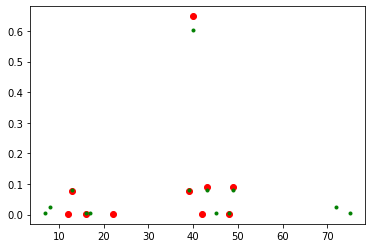

In [29]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [246]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-3:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(-0.03960846510253137+0.26799088357116774j)|2 1 1 1>
(0.01579664286304912-0.07522185191212113j)|2 1 0 1>
(0.015796642863047432-0.07522185191211689j)|2 0 1 1>
(-0.039608465102536176+0.267990883571169j)|1 1 1 2>
(0.2115635059722372-0.7895398944596179j)|1 1 1 1>
(0.015796642863048112-0.0752218519121132j)|1 1 0 2>
(-0.0860951046650502+0.26770384667885594j)|1 1 0 1>
(0.015796642863047862-0.07522185191211483j)|1 0 1 2>
(-0.08609510466505055+0.2677038466788568j)|1 0 1 1>

